# Goals

● Train a model using a subset of the training data from CAMELYON16.

● Include a script to run it on a testing image and generate a heatmap 

● Design a thoughtful evaluation method, and include the results on at least
three images from the testing set.


# Tips, from research paper

●  “We surprisingly found that slimmed-down Inception architectures with only 3% of the parameters achieved similar performance to the full version”

● Authors found that using a pretrained model on ImageNet ultimately hurt accuracy (Why? Pathology images do not match the natural images from ImageNet) -- but -- it improved convergence speed. This is a good place to start. Try transfer learning
and/or fine-tuning.

● Start with a low zoom level (much smaller images), a simple model, and a small amount of data.

● Implement an end-to-end prototype (training data in -> heatmap on a test image out), then slowly scale up.

● Begin with transfer learning from a model trained on ImageNet, then fine-tuning, then consider training a model from scratch. Only after this is working end-to-end, consider data augmentation, using higher zooms,
etc.

## Packages and Installations

In [1]:
!pip show tensorflow-gpu

Name: tensorflow-gpu
Version: 1.9.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/anaconda/lib/python3.6/site-packages
Requires: setuptools, wheel, termcolor, tensorboard, gast, protobuf, numpy, absl-py, grpcio, six, astor
Required-by: 


In [2]:
#need to udpate sckikit from base for skimage.color functions
!pip show scikit-image  #need >=0.15.0

Name: scikit-image
Version: 0.15.0
Summary: Image processing routines for SciPy
Home-page: https://scikit-image.org
Author: None
Author-email: None
License: Modified BSD
Location: /usr/local/anaconda/lib/python3.6/site-packages
Requires: pillow, networkx, scipy, PyWavelets, imageio, matplotlib
Required-by: shap, lime


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import re
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.utils import class_weight

import os
import pandas as pd
import random

In [4]:
import tensorflow as tf
#from tensorflow.keras.applications import VGG16, InceptionV3, VGG19, ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam

## Data Access - Using Datasets
Note that there are several files that are missing masks .. should create a new revision of the dataset that removes these

In [5]:
SLIDES_DIR = '/domino/datasets/image_slides_input/slides'
print("Slides path within the drive: {}".format(SLIDES_DIR))


Slides path within the drive: /domino/datasets/image_slides_input/slides


Creating Dataset With Train/Validation/Holdout Splits
* Note: test/train datasets hardcoded post random shuffle with seed for reproducibility

In [6]:
!ls $SLIDES_DIR

tumor_001_mask.tif  tumor_019.tif	tumor_059.xml	    tumor_091_mask.tif
tumor_001.tif	    tumor_019.xml	tumor_064_mask.tif  tumor_091.tif
tumor_001.xml	    tumor_023_mask.tif	tumor_064.tif	    tumor_091.xml
tumor_002_mask.tif  tumor_023.tif	tumor_064.xml	    tumor_094_mask.tif
tumor_002.tif	    tumor_023.xml	tumor_075_mask.tif  tumor_094.tif
tumor_002.xml	    tumor_031_mask.tif	tumor_075.tif	    tumor_094.xml
tumor_005_mask.tif  tumor_031.tif	tumor_075.xml	    tumor_096_mask.tif
tumor_005.tif	    tumor_031.xml	tumor_078_mask.tif  tumor_096.tif
tumor_005.xml	    tumor_035_mask.tif	tumor_078.tif	    tumor_096.xml
tumor_012_mask.tif  tumor_035.tif	tumor_078.xml	    tumor_101_mask.tif
tumor_012.tif	    tumor_035.xml	tumor_081_mask.tif  tumor_101.tif
tumor_012.xml	    tumor_057_mask.tif	tumor_081.tif	    tumor_101.xml
tumor_016_mask.tif  tumor_057.tif	tumor_081.xml	    tumor_110_mask.tif
tumor_016.tif	    tumor_057.xml	tumor_084_mask.tif  tumor_110.tif
tumor_016.xml	    tumor_059_mask.tif	tu

Note latest revision has two slides removed that were missing masks

In [7]:
images_references = !ls $SLIDES_DIR
# saving image paths into a list
image_names = []
for images in images_references:
    img = re.findall(r'tumor_\d\d\d', images)
    for i in img:
        image_names.append(i)
image_names = list(set(image_names)) # removing duplicates

In [8]:
# here is the full list of images we will be working with
print(image_names)

['tumor_023', 'tumor_035', 'tumor_084', 'tumor_078', 'tumor_059', 'tumor_094', 'tumor_064', 'tumor_012', 'tumor_110', 'tumor_019', 'tumor_002', 'tumor_081', 'tumor_101', 'tumor_001', 'tumor_005', 'tumor_016', 'tumor_096', 'tumor_075', 'tumor_057', 'tumor_091', 'tumor_031']


following commands were used to permanently delete tumor_038 and tumor_099 from dataset

## Functions for Data Exploration & Visualization
* Note that the sample code has been augmented to automate visualization
* Note dataframe with downsampling factors and basic calculations on max # of windows available at each zoom level
* Note POC of overlay and tissue identification

In [9]:
# Load an example slide and tumor mask

def choose_image(image_number):
  
    global slide_path
    global tumor_mask_path
    global slide
    global tumor_mask

    slide_path = os.path.join(SLIDES_DIR, 'tumor_'+image_number+'.tif')
    tumor_mask_path =  os.path.join(SLIDES_DIR, 'tumor_'+image_number+'_mask.tif')

    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                          slide.level_dimensions[0][0], 
                                                          slide.level_dimensions[0][1]))

    tumor_mask = open_slide(tumor_mask_path)
    print ("Read tumor mask from %s" % (tumor_mask_path))

    print("Slide includes %d levels", len(slide.level_dimensions))

    for i in range(len(slide.level_dimensions)-1):
        x = slide.level_dimensions[i][0]
        y = slide.level_dimensions[i][1]

        print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                               slide.level_dimensions[i], 
                                                               slide.level_downsamples[i]))

        downsample = 2**i
        dim = 299.

        dat.append({'image': image_number, 'level': i, 'downsample factor': downsample, 'x': x, 'y': y, \
                    'max windows': int(round((x*y)/dim**2,0)-1)})
        
    return slide_path, tumor_mask_path

In [10]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [11]:
def zoom(i): 
  
  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=i, 
                         width=slide.level_dimensions[i][0], 
                         height=slide.level_dimensions[i][1])
     

  # Example: read the entire mask at the same zoom level
  mask_image = read_slide(tumor_mask, 
                       x=0, 
                       y=0, 
                       level=i, 
                       width=tumor_mask.level_dimensions[i][0], 
                       height=tumor_mask.level_dimensions[i][1])

  # Note: the program provided by the dataset authors generates a mask with R,G,B channels.
  # The mask info we need is in the first channel only.
  # If you skip this step, the mask will be displayed as all black.
  mask_image = mask_image[:,:,0]

  return slide_image, mask_image

In [12]:
def show_slide():
  
  plt.figure('slide', figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  
  return 'slide image'

In [13]:
def show_mask():

  plt.figure('mask', figsize=(10,10), dpi=100)
  plt.imshow(mask_image, cmap='binary')
  
  return 'mask'

In [14]:
def show_overlay(a):
  
  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  plt.imshow(mask_image, cmap = 'OrRd', alpha = a)
  
  return 'overlay'

In [15]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

In [16]:
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

### Function to open mask and check if cancer is present in a given image or set of images

In [17]:
def tumor_present(image_names):
  mask_classes = {}
  for i in image_names:
    tumor_mask_path =  os.path.join(SLIDES_DIR, i+'_mask.tif')

    tumor_mask = open_slide(tumor_mask_path)
    mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width= tumor_mask.level_dimensions[7][0], 
                        height= tumor_mask.level_dimensions[7][1])[:,:,0]
    if np.count_nonzero(mask_image.flatten()) > 0:
      mask_classes[i] = 1
    if np.count_nonzero(mask_image.flatten()) == 0:
      mask_classes[i] = 0
    
  return mask_classes

## Further edav - which of the images in the dataset contain cancer?

In [18]:
# check to see what portion of the images in the dataset contain masks that identify areas as cancer
image_classes = tumor_present(image_names)

In [19]:
print("{0:.0%}".format(sum(image_classes.values())/len(image_names)))

100%


Cool, so 100% of our images contain at least some cancer, according to their associated masks. 

This simplifies considerations of how to break up train/validation/holdout sets *at the image level*.
- Because each image contains at least some cancer, we can separate the images before partitioning them into smaller 'windows' that will be used as individual elements of their respective datasets

## Create train/validation/holdout splits

Because the ultimate goal is to train a model on a *slide image*, we'll create train/test/holdout sets of images before processing them for modeling and inference

There are 21 images available total. Let's break it up as follows:

16 training
2 validation
3 holdout (just because it seems nice to evaluate our final results against a set of three images)

In [20]:
#hardcode for consistency. Keras validates on subset of training data, only need holdout for our purposes. 
train_names = ['tumor_091', 'tumor_002', 'tumor_005', 'tumor_094', 'tumor_078', 'tumor_023', 
               'tumor_081', 'tumor_001', 'tumor_035', 'tumor_012', 'tumor_057', 'tumor_096', 
               'tumor_101', 'tumor_031', 'tumor_059', 'tumor_084','tumor_016', 'tumor_064']
holdout_names = ['tumor_110', 'tumor_075', 'tumor_019']

In [21]:
print(train_names)

['tumor_091', 'tumor_002', 'tumor_005', 'tumor_094', 'tumor_078', 'tumor_023', 'tumor_081', 'tumor_001', 'tumor_035', 'tumor_012', 'tumor_057', 'tumor_096', 'tumor_101', 'tumor_031', 'tumor_059', 'tumor_084', 'tumor_016', 'tumor_064']


### Creating a  Balanced Dataset
A few functions used for creating training datasets
* extract windows with tissue in them
* augment if specified

In [22]:
# This will help us exclude valueless data

def is_tissue_in_window(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    #return zip(indices[0], indices[1])
    return len(indices) > 0

In [37]:
# a function for data augmentation
# note currently randomly samples two out of 8 augmentations (was done prior due to resource constraints)

#not currently implemented, did not move the needle significantly upon prior attempts

#needs to be converted to numpy.. no reason to do so with tf if data already in np format

def augment_window(window):
    sess = tf.Session()
    tf_img = tf.convert_to_tensor(window)
    #flipped_img = tf.image.flip_left_right(tf_img).eval()
    #print(type(tf_img))
    flipped_img = tf.image.flip_left_right(tf_img)
    results = []
    for img in [tf_img, flipped_img]:
        for i in range(4):
            result = tf.image.rot90(img, k=i)
            result = tf.image.random_contrast(result, 0.75, 1.25)
            result = tf.image.random_hue(result, 0.04)
            result = tf.image.random_saturation(result, 0.75, 1.25)
            result = tf.image.random_brightness(result, 0.25)
            
            results.append(result.eval(session=sess))

    sample_results = random.sample(results,4)
    sess.close()
    
    return sample_results, len(sample_results)


In [40]:
# a function to create dataset of arrays for each window with tissue and corresponding labels

def create_dataset(level, image_names, with_augmentation = False, padding = True, balance = True):
    
    data = []
    labels = []
    
    cancer_proportions = {}
    
    step = 1
    
    for image_name in image_names:
        print('image: ' + str(step) + ' of ' + str(len(image_names)))
        step += 1
        #print(len(data))
        #print(len(labels))
        
        #reading in the slides and masks B@ODW
        slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
        tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
        print(slide_path)
        print(tumor_mask_path)

        #opening them
        print('opening mask & preparing to walk image..')
    
        tumor_mask = open_slide(tumor_mask_path)

        #dimensions at chosen level -- note adjusted so max is based on mask size (slide images slightly larger in some cases)
        #padding 15%
        x_max = int(tumor_mask.level_dimensions[level][0]*.85)
        y_max = int(tumor_mask.level_dimensions[level][1]*.85)
        
        print('mask dims: ' + str(x_max) + ' ' + str(y_max))
 
        #initiatize coordinates for walk -- note 10% padding to avoid slide artifacts
        x0 = int(.15*x_max)
        y0 = int(.15*y_max)
        
        if padding == False:
            x0 = 0
            y0 = 0
            x_max = int(tumor_mask.level_dimensions[level][0])
            y_max = int(tumor_mask.level_dimensions[level][1])

        #size of window -- window size is common in canonical CNN architectures, and is chosen in line with original research paper
        x_dim, y_dim = 299, 299
        size = (x_dim, y_dim)

        #calculate how many steps we can take with 299x299 window
        x_steps, y_steps = int(((x_max-x0) / x_dim)), int(((y_max-y0) / y_dim))
        print('x steps: '+ str(x_steps) + ' y steps: '+ str(y_steps))
        
        window_labels = []
        window_data = []
        
        print('opening slide & beginning walk..')
        slide = open_slide(slide_path)
        print('slide dims:  ' + str(slide.level_dimensions[level][0]) + ' ' + str(slide.level_dimensions[level][1]))
        
        # choosing downsample factor
        downsample_factor = int(slide.level_downsamples[level])
        
        for i in range(x_steps):
            for j in range(y_steps): 
                
                #generating a window from the original slide
                window = read_slide(slide, 
                                 x = x0 * downsample_factor, 
                                 y = y0 * downsample_factor, 
                                 level =level, 
                                 width = x_dim, 
                                 height = y_dim)
                #print(type(window))

                #if window contains tissue, append to train
                if is_tissue_in_window(window) is True:
                    #continue # No tissue in this window, don't add to train or test
                    window_data.append(window)
                    
                    if with_augmentation is True:
                        augmented_data, aug_num = augment_window(window)
                        window_data.extend(augmented_data)
                        print('data augmented by ' + str(aug_num) + ' samples.')

                    
                    # read the tumor mask view that corresponds to the window
                    window_mask = read_slide(tumor_mask, 
                                     x= x0 * downsample_factor, 
                                     y= y0 * downsample_factor, 
                                     level=level, 
                                     width= x_dim, 
                                     height= y_dim)[:,:,0]

                    #if window contains cancer, append 1 to labels; else 0
                    if np.count_nonzero(window_mask.flatten()) > 0:
                        #labels.append(1)
                        window_label = 1
                    else:
                        #labels.append(0)
                        window_label = 0  
                    
                    window_labels.append(window_label)
                    
                    if with_augmentation is True:
                        window_labels.extend([window_label] * aug_num)
                
                #move the sliding window on y axis
                y0 = y0 + y_dim

            #move the sliding window on x axis
            x0 = x0 + x_dim
            
            # reset y0 to start
            y0 = int(.10*y_max)
    
            if padding == False:
                y0 = 0
            
# code has now been rewritten to undersample predominantly negative classes more efficiently
# note, as it stands, resulting training set has the possibility to be biased towards detecting cancer -- safer in real world apps
# bias towards positive class will be more pronounced at lower resolutions
    
            temp = list(zip(window_data,window_labels))
            df_data = pd.DataFrame(temp,columns=['data','labels'])
            del temp

            pos_indexes = df_data.query('labels == 1').index.tolist()
            neg_indexes = df_data.query('labels == 0').index.tolist()
            del df_data
    
            cancer_proportions[image_name] = len(pos_indexes)/len(window_data)
        
        if balance == True: 
            
            print(' ')
            print('-results-')
            print('#pos samples: ' + str(len(pos_indexes)))
            print('#neg samples: ' + str(len(neg_indexes)))
            print('total samples extracted: ' + str(len(window_data)))
            print(' ')
            print("{0:.00%} of tissue from this slide sample is masked as containing cancerous cells".format(len(pos_indexes)/len(window_data)))

            if (pos_indexes == 0) or (neg_indexes == 0):
                print('Warning: data will not be perfectly balanced; cannot oversample if only one class present')

            print(' ')

            delta = len(neg_indexes) - len(pos_indexes)

            if delta > 0: #more negative samples than positive
                sampled = []
                sampled_labels = []

                print('randomly sampling ' + str(len(pos_indexes)) + ' from negative class.')
                rand_selection = np.random.choice(neg_indexes, size = len(pos_indexes)).tolist()

                for i in rand_selection:
                    sampled.append(window_data[i])
                    sampled_labels.append(0)

                for i in pos_indexes:
                    sampled.append(window_data[i])
                    sampled_labels.append(1)

                data.extend(sampled)
                labels.extend(sampled_labels)

                print('number of training images generated: ' + str(len(sampled)))

            else:
                data.extend(window_data)
                labels.extend(window_labels)
                
                print('number of training images generated: ' + str(len(window_data)))
                
        else:
            data.extend(window_data)
            labels.extend(window_labels)
            
            print('number of training images generated: ' + str(len(window_data)))
        
        print(' ')
        print(' ')
        
    print('cumulative training size: ' + str(len(data)))
    
    return data, labels, cancer_proportions

In [ ]:
# generating data from slides
X_train_aug, y_train_aug, cancer_proportions_aug = create_dataset(3, train_names, with_augmentation = True, balance = True)

image: 1 of 18
/domino/datasets/image_slides_input/slides/tumor_091.tif
/domino/datasets/image_slides_input/slides/tumor_091_mask.tif
opening mask & preparing to walk image..
mask dims: 6528 5712
x steps: 18 y steps: 16
opening slide & beginning walk..
slide dims:  7680 7168
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.

data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
 
-results-
#pos samples: 95
#neg samples: 1345
total samples extracted: 1440
 
7% of tissue from this slide sample is masked as containing cancerous cells
 
randomly sampling 95 from negative class.
number of training images generated: 190
 
 
image: 2 of 18
/domino/datasets/image_slides_input/slides/tumor_002.tif
/domino/datasets/image_slides_input/slides/tumor_002_mask.tif
opening mask & preparing to walk image..
mask dims: 10390 23337
x steps: 29 y steps: 66
opening slide & beginning walk..
slide dims:  12288 27648
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmented by 4 samples.
data augmen

In [ ]:
# generating data from slides
X_train_3, y_train_3, cancer_proportions_3 = create_dataset(3, train_names, with_augmentation = False, balance = True)

In [33]:
df_cp_train_5 = pd.DataFrame.from_dict(cancer_proportions_5, orient='index',columns = ['cancer_proportion'])
df_cp_train_5.sort_values(by=['cancer_proportion'], ascending=False)

cancer_proportion
tumor_078           0.571429
tumor_101           0.300000
tumor_091           0.187500
tumor_096           0.088889
tumor_084           0.083333
tumor_064           0.080357
tumor_023           0.062500
tumor_031           0.062500
tumor_094           0.053571
tumor_081           0.047619
tumor_016           0.044643
tumor_005           0.035714
tumor_001           0.017857
tumor_035           0.017857
tumor_057           0.017857
tumor_059           0.017857
tumor_012           0.017857
tumor_002           0.008929

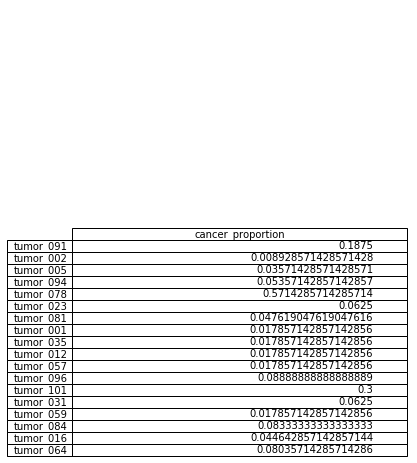

In [35]:
from pandas.plotting import table # EDIT: see deprecation warnings below

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, df_cp_train_5)  # where df is your data frame

plt.savefig('/mnt/results/df_cancer_proportion_train_5.png')

In [110]:
df_cp_train_3 = pd.DataFrame.from_dict(cancer_proportions_3, orient='index',columns = ['cancer_proportion'])
df_cp_train_3.sort_values(by=['cancer_proportion'], ascending=False)

cancer_proportion
tumor_110           0.486395
tumor_075           0.064412
tumor_019           0.002090

In [141]:
!ls /domino/datasets/training_output/*

ls: cannot access '/domino/datasets/training_output/*': No such file or directory


Load saved dataset

In [114]:
np.load('/domino/datasets/training_output/X_train_level_5.npy')

In [40]:
# generating data from slides
X_test_5, y_test_5, cancer_proportions_5 = create_dataset(5, holdout_names, balance = False)

image: 1 of 3
/domino/datasets/image_slides_input/slides/tumor_110.tif
/domino/datasets/image_slides_input/slides/tumor_110_mask.tif
opening mask & preparing to walk image..
mask dims: 2502 1904
x steps: 7 y steps: 5
opening slide & beginning walk..
slide dims:  3072 2560
number of training images generated: 35
 
 
image: 2 of 3
/domino/datasets/image_slides_input/slides/tumor_075.tif
/domino/datasets/image_slides_input/slides/tumor_075_mask.tif
opening mask & preparing to walk image..
mask dims: 2393 2094
x steps: 6 y steps: 5
opening slide & beginning walk..
slide dims:  3072 2560
number of training images generated: 30
 
 
image: 3 of 3
/domino/datasets/image_slides_input/slides/tumor_019.tif
/domino/datasets/image_slides_input/slides/tumor_019_mask.tif
opening mask & preparing to walk image..
mask dims: 2597 5834
x steps: 7 y steps: 16
opening slide & beginning walk..
slide dims:  3072 7168
number of training images generated: 112
 
 
cumulative training size: 177


In [41]:
df_cp_test_5 = pd.DataFrame.from_dict(cancer_proportions_5, orient='index',columns = ['cancer_proportion'])
df_cp_test_5.sort_values(by=['cancer_proportion'], ascending=False)

cancer_proportion
tumor_110           0.742857
tumor_075           0.166667
tumor_019           0.008929

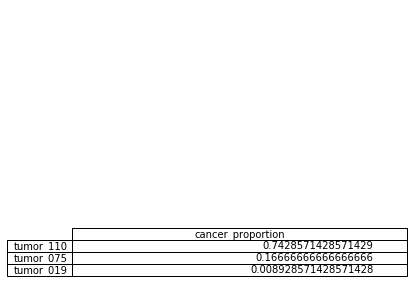

In [42]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, df_cp_test_5)  # where df is your data frame

plt.savefig('/mnt/results/df_cancer_proportion_test_5.png')

In [109]:
# generating data from slides
X_test_3, y_test_3, cancer_proportions_3 = create_dataset(3, holdout_names, balance = False)

image: 1 of 3
/domino/datasets/image_slides_input/slides/tumor_110.tif
/domino/datasets/image_slides_input/slides/tumor_110_mask.tif
opening mask & preparing to walk image..
mask dims: 10009 7616
x steps: 28 y steps: 21
opening slide & beginning walk..
slide dims:  11776 9216
number of training images generated: 588
 
 
image: 2 of 3
/domino/datasets/image_slides_input/slides/tumor_075.tif
/domino/datasets/image_slides_input/slides/tumor_075_mask.tif
opening mask & preparing to walk image..
mask dims: 9574 8377
x steps: 27 y steps: 23
opening slide & beginning walk..
slide dims:  11264 10240
number of training images generated: 621
 
 
image: 3 of 3
/domino/datasets/image_slides_input/slides/tumor_019.tif
/domino/datasets/image_slides_input/slides/tumor_019_mask.tif
opening mask & preparing to walk image..
mask dims: 10390 23337
x steps: 29 y steps: 66
opening slide & beginning walk..
slide dims:  12288 27648
number of training images generated: 1914
 
 
cumulative training size: 3123


In [111]:
df_cp_test_3 = pd.DataFrame.from_dict(cancer_proportions_3, orient='index',columns = ['cancer_proportion'])
df_cp_test_3.sort_values(by=['cancer_proportion'], ascending=False)

cancer_proportion
tumor_110           0.486395
tumor_075           0.064412
tumor_019           0.002090

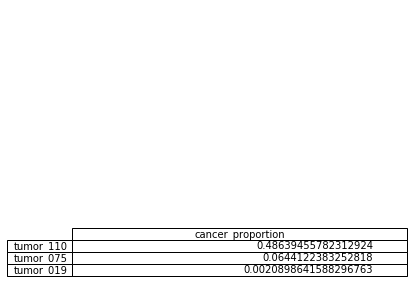

In [112]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, df_cp_test_3)  # where df is your data frame

plt.savefig('/mnt/results/df_cancer_proportion_test_3.png')

## Save training data for future use

In [27]:
import os

In [28]:
os.getcwd()

'/mnt/code'

In [29]:
os.chdir('/domino')

In [30]:
os.listdir()

['launch', 'datasets']

In [143]:
os.chdir('/domino/datasets/training_input')
os.listdir()

['X_test_5.npy',
 'y_train_5.txt',
 'y_test_3.txt',
 'X_train_3.npy',
 'y_test_5.txt',
 'y_train_3.txt',
 'X_test_3.npy',
 'X_train_5.npy']

In [44]:
def save_data_train(array, labels, level):
    
    np.save('/domino/datasets/training_output/X_train'+'_'+str(level)+'.npy', array)
    
    with open('/domino/datasets/training_output/y_train'+'_'+str(level)+'.txt', 'w') as f:
        for item in labels:
            f.write("%s\n" % item)
    
    return len(labels) > 0

In [ ]:
def save_data_train_aug(array, labels, level):
    
    np.save('/domino/datasets/goyetc/medical-imaging/scratch/X_train_aug'+'_'+str(level)+'.npy', array)
    
    with open('/domino/datasets/goyetc/medical-imaging/scratch/y_train_aug'+'_'+str(level)+'.txt', 'w') as f:
        for item in labels:
            f.write("%s\n" % item)
    
    return len(labels) > 0

In [45]:
def save_data_test(array, labels, level):
    
    np.save('/domino/datasets/training_output/X_test'+'_'+str(level)+'.npy', array)
    
    with open('/domino/datasets/training_output/y_test'+'_'+str(level)+'.txt', 'w') as f:
        for item in labels:
            f.write("%s\n" % item)
    
    return len(labels) > 0

In [ ]:
save_data_train_aug(X_train_aug, y_train_aug, 3)

In [ ]:
save_data_test(X_test_3, y_test_3, 3)

In [ ]:
save_data_train(X_train_4, y_train_4, 4)
save_data_test(X_test_4, y_test_4, 4)

We will be working with 200 windows as our train dataset.
-
Train label class distribution is as follows:
No cancer: 96   cancerous: 104


/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


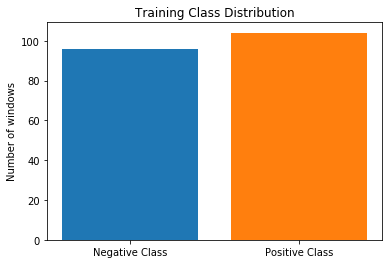

In [48]:
# checking the resulting shape and label distribution
print('We will be working with {} windows as our train dataset.'.format(len(X_train_5)))
print('-')
print('Train label class distribution is as follows:')
print('No cancer: ' + str(np.bincount(y_train_5)[0]) + '   cancerous: ' + str(np.bincount(y_train_5)[1]))
plt.bar(0, np.bincount(y_train_5)[0])
plt.bar(1, np.bincount(y_train_5)[1])
plt.xticks([0,1], ('Negative Class', 'Positive Class'))
#plt.xticks([0,1], ('Tom', 'Dick', 'Harry', 'Sally', 'Sue'))
plt.ylabel('Number of windows')
plt.title('Training Class Distribution')
#plt.gcf()
#plt.show()
fig1 = plt.gcf()
fig1.show()
fig1.savefig('/mnt/results/class_distribution_train_5.png')

We will be working with 1046 windows as our train dataset.
-
Train label class distribution is as follows:
No cancer: 523   cancerous: 523


/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


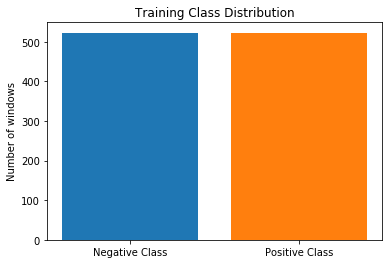

In [115]:
# checking the resulting shape and label distribution
print('We will be working with {} windows as our train dataset.'.format(len(X_train_3)))
print('-')
print('Train label class distribution is as follows:')
print('No cancer: ' + str(np.bincount(y_train_3)[0]) + '   cancerous: ' + str(np.bincount(y_train_3)[1]))
plt.bar(0, np.bincount(y_train_3)[0])
plt.bar(1, np.bincount(y_train_3)[1])
plt.xticks([0,1], ('Negative Class', 'Positive Class'))
#plt.xticks([0,1], ('Tom', 'Dick', 'Harry', 'Sally', 'Sue'))
plt.ylabel('Number of windows')
plt.title('Training Class Distribution')
#plt.gcf()
#plt.show()
fig1 = plt.gcf()
fig1.show()
fig1.savefig('/mnt/results/class_distribution_train_3.png')

Note: below is an example of the unblanced distribution of classes from the test set, if sampling technique not leveraged

We will be working with 3123 windows as our train dataset.
-
Train label class distribution is as follows:
No cancer: 2793   cancerous: 330


/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


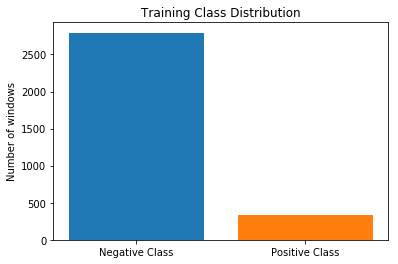

In [120]:
# checking the resulting shape and label distribution
print('We will be working with {} windows as our train dataset.'.format(len(X_test_3)))
print('-')
print('Train label class distribution is as follows:')
print('No cancer: ' + str(np.bincount(y_test_3)[0]) + '   cancerous: ' + str(np.bincount(y_test_3)[1]))
plt.bar(0, np.bincount(y_test_3)[0])
plt.bar(1, np.bincount(y_test_3)[1])
plt.xticks([0,1], ('Negative Class', 'Positive Class'))
#plt.xticks([0,1], ('Tom', 'Dick', 'Harry', 'Sally', 'Sue'))
plt.ylabel('Number of windows')
plt.title('Training Class Distribution')
#plt.gcf()
#plt.show()
fig1 = plt.gcf()
fig1.show()
fig1.savefig('/mnt/results/class_distribution_test_3.png')

In [119]:
# checking the resulting shape and label distribution
print('We will be working with {} windows as our train dataset.'.format(len(X_test_4)))
print('-')
print('Train label class distribution is as follows:')
print('No cancer: ' + str(np.bincount(y_test_4)[0]) + '   cancerous: ' + str(np.bincount(y_test_4)[1]))
plt.bar(0, np.bincount(y_test_4)[0])
plt.bar(1, np.bincount(y_test_4)[1])
plt.xticks([0,1], ('Negative Class', 'Positive Class'))
#plt.xticks([0,1], ('Tom', 'Dick', 'Harry', 'Sally', 'Sue'))
plt.ylabel('Number of windows')
plt.title('Training Class Distribution')
#plt.gcf()
#plt.show()
fig1 = plt.gcf()
fig1.show()
fig1.savefig('/mnt/results/class_distribution_test_5.png')

NameError: name 'X_test_4' is not defined

In [ ]:
# checking the resulting shape and label distribution
#print('We will be working with {} windows as our train dataset.'.format(len(X_train)))
#print('-')
#print('Train label class distribution is as follows:')
#plt.bar(0, np.bincount(y_train)[0])
#plt.bar(1, np.bincount(y_train)[1])
#plt.xticks([0,1], labels = ('Negative Class', 'Positive Class'))
#plt.ylabel('Number of windows')
#plt.title('Training Class Distribution')
#plt.show()

Looking at the class distribution above, we can see that the data is heavily skewed towards negative class. Address this class imbalance before fitting any models.

## Data Preprocessing & Class Balance
* Note this was incorporated into the extraction script run above.
* Oversampling via random selection from positive (cancerous) windows was implemented

In order to address the class imbalance, we have considered two approaches. 

1. Applying class weights inside the model. According to Keras documentation: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
2. Using the same sampling technique as the research paper: "Avoiding biases towards slides containing more patches (both normal and tumor) required careful sampling. First, we select “normal” or “tumor” with equal probability. Next, we select a slide that contains that class of patches uniformly at random, and sample patches from that slide."

For the data baseline preprocessing, we would simply be rescaling the training images by dividing by 255.

In [117]:
# rescaling the training dataset per standard practice
X_train = np.asarray(X_train_3) / 255.0

In [118]:
y_train = y_train_3

use below if dataset too large to fit in memory. Adjust proportion in second argument of function

# Modeling




## With Data loaded from input dataset

For modeling we decided to approach the problem by first working on a simple baseline model. Then, we have tried transfer learning -pretrained model on ImageNet to see if it would beat the baseline. Lastly, we have developed our own model guided by the research paper findings. Within the last model architecture, we applied data augmentation to attempt to increase model performance and forecastability.

In [69]:
def read_integers(filename):
    with open(filename) as f:
        return [int(x) for x in f]

In [103]:
X_train = np.load('/domino/datasets/training_input/X_train_3.npy')
X_train = np.asarray(X_train) / 255.0
y_train = read_integers('/domino/datasets/training_input/y_train_3.txt')

### Baseline Model

For the baseline model, we chose a simple DNN with some dropout added to avoid early overfitting.

In [104]:
X_train.shape

(1046, 299, 299, 3)

In [105]:
type(X_train)

numpy.ndarray

In [74]:
len(y_train)

1046

In [75]:
type(y_train)

list

"Go-forward baseline (dense) model"

In [106]:
tf.keras.backend.clear_session()

In [107]:
model_baseline = models.Sequential()
model_baseline.add(layers.Flatten(input_shape=(299,299,3)))
model_baseline.add(layers.Dense(512, activation=tf.nn.relu))
model_baseline.add(layers.Dropout(0.1))
model_baseline.add(layers.Dense(512, activation=tf.nn.relu))
model_baseline.add(layers.Dropout(0.1))
model_baseline.add(layers.Dense(128, activation=tf.nn.relu))
model_baseline.add(layers.Dropout(0.1))
model_baseline.add(layers.Dense(64, activation=tf.nn.relu))
model_baseline.add(layers.Dropout(0.1))
model_baseline.add(layers.Dense(1, activation='sigmoid'))

model_baseline.compile(optimizer=optimizers.Adam(lr=3e-5),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

Let us look at the model summary:

In [108]:
model_baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 268203)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               137320448 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [96]:
from keras.callbacks import EarlyStopping

In [109]:
#implement early stopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20) #stop on minimum validation loss, waiting 10 epochs to observe a lower value
cb_list = [es]

In [110]:
BATCH = 32
#train_steps = int(np.ceil(X_train.shape[0]*0.8 / BATCH))
#val_steps = int(np.ceil(X_train.shape[0]*0.2 / BATCH))
history_baseline_3 = model_baseline.fit(X_train, y_train, epochs = 50, validation_split=0.15, 
                                      batch_size = BATCH, shuffle = True, callbacks = cb_list)

Train on 889 samples, validate on 157 samples
Epoch 1/50
889/889 [==============================] - 8s 9ms/step - loss: 1.4234 - acc: 0.5242 - val_loss: 0.7064 - val_acc: 0.4459
Epoch 2/50
889/889 [==============================] - 3s 3ms/step - loss: 1.0500 - acc: 0.5568 - val_loss: 0.5671 - val_acc: 0.7325
Epoch 3/50
889/889 [==============================] - 3s 3ms/step - loss: 0.6813 - acc: 0.6603 - val_loss: 0.7004 - val_acc: 0.6115
Epoch 4/50
889/889 [==============================] - 3s 3ms/step - loss: 0.6256 - acc: 0.6940 - val_loss: 0.7826 - val_acc: 0.5605
Epoch 5/50
889/889 [==============================] - 3s 3ms/step - loss: 0.6190 - acc: 0.7087 - val_loss: 0.6320 - val_acc: 0.6369
Epoch 6/50
889/889 [==============================] - 3s 3ms/step - loss: 0.5571 - acc: 0.7323 - val_loss: 0.5320 - val_acc: 0.7580
Epoch 7/50
889/889 [==============================] - 3s 3ms/step - loss: 0.5465 - acc: 0.7537 - val_loss: 0.4786 - val_acc: 0.7962
Epoch 8/50
889/889 [==========

In [114]:
os.chdir('/domino/datasets/models_input')
os.listdir()

['CNN__small_level_5.h5',
 'CNN__small_level_3.h5',
 'dense_model_baseline_level_3.h5',
 'dense_model_baseline_level_5.h5']

In [44]:
!cp /domino/datasets/models_input/* /domino/datasets/models_output
!rm -f dense_model_baseline_level_3.h5

In [113]:
from keras.models import load_model

#model_baseline.save('/domino/datasets/models_output/dense_model_baseline_level_3.h5')
model_baseline.save('/domino/datasets/goyetc/medical-imaging/scratch/dense_model_baseline_level_3.h5') # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

In [ ]:
# returns a compiled model
# identical to the previous one
#model = load_model('/mnt/models/dense_model_baseline.h5')

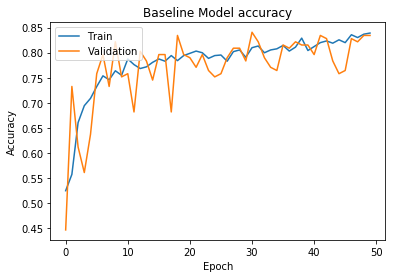

In [116]:
# Plot training & validation accuracy values
plt.plot(history_baseline_3.history['acc'])
plt.plot(history_baseline_3.history['val_acc'])
plt.title('Baseline Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

fig_acc_baseline = plt.gcf()
fig_acc_baseline.savefig('/mnt/results/accuracy_baseline_level_3.png')
plt.show()

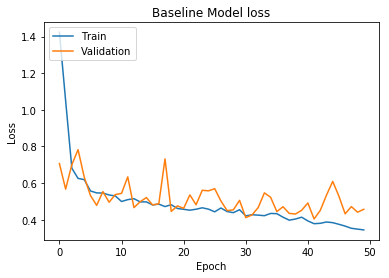

In [117]:
# Plot training & validation loss values
plt.plot(history_baseline_3.history['loss'])
plt.plot(history_baseline_3.history['val_loss'])
plt.title('Baseline Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
fig2 = plt.gcf()
fig2.savefig('/mnt/results/loss_baseline_level_3.png')
plt.show()

Interesting results - clearly the model is converging, but validation accuracy sucks!
* We ultimately demonstrate convergence with a dense neural network and do not expect high accuracy
* As should be expected, running at higher resolution improves accuracy with the same architecture, implying we ultimately should pursue data augmentation and/or lower zoom levels
* Current results are on zoom level 4

In [129]:
model_baseline = load_model('/domino/datasets/goyetc/medical-imaging/scratch/dense_model_baseline_level_3.h5')

In [126]:
X_val = np.load('/domino/datasets/training_input/X_test_3.npy')
X_val = np.asarray(X_val) / 255.0
y_val = read_integers('/domino/datasets/training_input/y_test_3.txt')

In [130]:
X_val.shape

(3123, 299, 299, 3)

In [131]:
len(y_val)

3123

In [132]:
y_pred_base = model_baseline.predict(X_val).ravel()
fpr_base, tpr_base, thresholds_base = roc_curve(y_val, y_pred_base)
auc_base = auc(fpr_base, tpr_base)

/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


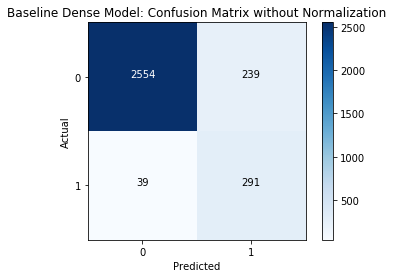

In [133]:
# outputting the confusion matrix
import itertools
rounded_pred_base = np.round(y_pred_base)
cf = confusion_matrix(y_val, rounded_pred_base)

plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Baseline Dense Model: Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(rounded_pred_base))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
fig3 = plt.gcf()
fig3.show()

In [134]:
fig3.savefig('/mnt/results/confusion_matrix_baseline_level_3.png')

Unsurprisingly.. not great performance. But also not terrible! We clearly have a model that converges, but-- 
* Recall needs improvement: around 10% of the true positives were marked as non-cancerous
* Precision is poor - a significant # of non-cancerous images were marked as cancerous. This isn't totally surprising given the class imbalance of the validation set, but this isn't optimal for a real-world application.   
* Ultimately, we correctly just under 90% of true positives..

In [79]:
cf

array([[142,   3],
       [ 16,  16]])

In [135]:
precision = cf[1][1]/(cf[0][1] + cf[1][1])
recall = cf[1][1]/(cf[1][1]+ cf[1][0])
print('precision: '+str(precision) + ' recall: '+ str(recall))

precision: 0.5490566037735849 recall: 0.8818181818181818


In [136]:
# generating ROC AUC score
roc_auc_baseline = roc_auc_score(y_val, rounded_pred_base)
print(roc_auc_baseline)

0.8981235556423526


In [138]:
results = {}

In [139]:
results['AUC_baseline_3'] = roc_auc_baseline
results['precision_baseline_3'] = precision
results['recall_baseline_3'] = recall

Given that we have a non-negligible amount of false negatives, and our precision sucks, we should consider better architectures to improve our results.

### Function to evaluate validation or holdout image
Note can definitely consolidate this code with the training data code

In [84]:
def run_inference(level, image_name, model, scaling = False):
    
    #reading in the slides and masks B@ODW
    slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
    tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
    print(slide_path)
    print(tumor_mask_path)

    #opening them
    print('opening slide & mask..')
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
    
    predicted_mask = np.zeros((tumor_mask.level_dimensions[level][1], tumor_mask.level_dimensions[level][0]))
    print('predicted mask shape: ' + str(predicted_mask.shape))
    
    slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
    # showing the mask for test image at chosen level
    mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=tumor_mask.level_dimensions[level][0], 
                        height=tumor_mask.level_dimensions[level][1])[:,:,0]

    #dimensions at chosen level
    x_max = int(tumor_mask.level_dimensions[level][0]*.85)
    y_max = int(tumor_mask.level_dimensions[level][1]*.85)
    
    print('y: ' + str(y_max) + ' x: ' + str(x_max))

    # choosing downsample factor
    downsample_factor = int(slide.level_downsamples[level])

    #initiatize coordinates
    x0 = int(.15*x_max)
    y0 = int(.15*y_max)

    #size of window
    x_dim, y_dim = 299., 299.
    size = (int(x_dim), int(y_dim))

    #calculate how many steps we can take with 299x299 window
    #x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
    x_steps, y_steps = int(((x_max-x0) / x_dim)), int(((y_max-y0) / y_dim)) # I don't think we need the -1 above since int() already rounds down
    print('x steps: '+ str(x_steps) + ' y steps: '+ str(y_steps))

    for i in range(x_steps):
        
        # reset y0 to start
        y0 = int(.15*y_max)
        
        for j in range(y_steps): 
            #generating a window from the original slide
            window = read_slide(slide, 
                             x=int(x0)*downsample_factor, 
                             y=int(y0)*downsample_factor, 
                             level=level, 
                             width=int(x_dim), 
                             height=int(y_dim))

            if is_tissue_in_window(window) is True:
                window_reshaped = window.reshape(1, 299, 299, 3)
                
                if scaling == True:
                    window_reshaped = window_reshaped / 255 # scaling
                
                pred = model.predict(window_reshaped)
            
                if pred > 0.5:
                    predicted_mask[int(x0):(int(x0) + int(x_dim)), int(y0):(int(y0) + int(y_dim))] = 1

            #move the sliding window on y axis
            y0 = y0 + y_dim

        #move the sliding window on x axis
        x0 = x0 + x_dim
       
    return predicted_mask, slide_image, mask_image

In [138]:
predicted_mask, slide_image, mask_image = run_inference(5, holdout_names[0], model = model_baseline)

/domino/datasets/image_slides_input/slides/tumor_110.tif
/domino/datasets/image_slides_input/slides/tumor_110_mask.tif
opening slide & mask..
predicted mask shape: (2240, 2944)
y: 1904x: 2502
x steps: 7 y steps: 5


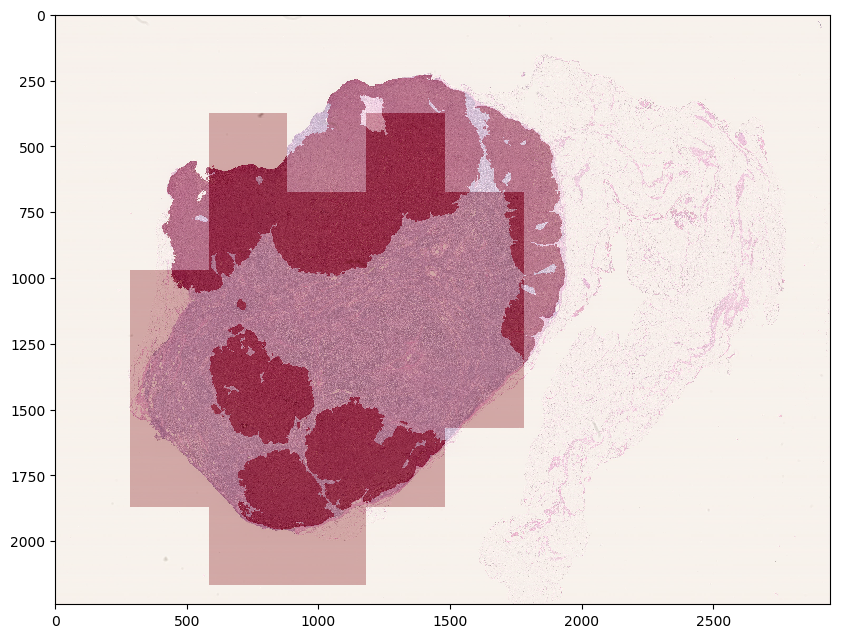

In [139]:
# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask, cmap='OrRd', alpha=0.3)
fig4 = plt.gcf()
fig4.savefig('/mnt/results/prediction_example_baseline_level_5_'+str(holdout_names[0]+'.png'), dpi = 100)
plt.show()

/domino/datasets/image_slides_input/slides/tumor_075.tif
/domino/datasets/image_slides_input/slides/tumor_075_mask.tif
opening slide & mask..
predicted mask shape: (2464, 2816)
y: 2094x: 2393
x steps: 6 y steps: 5


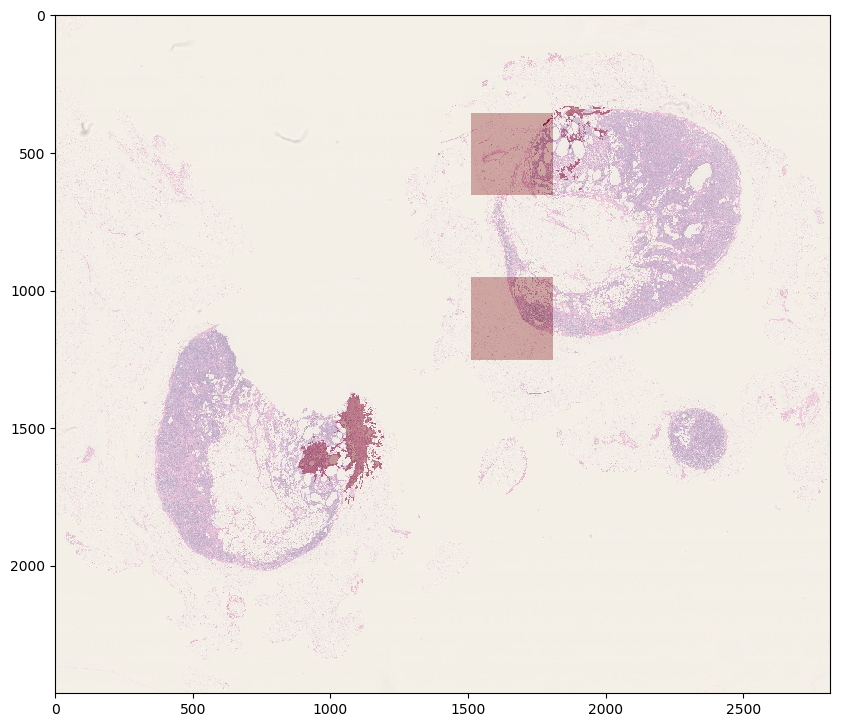

In [88]:
# another try with a different test image
predicted_mask2, slide_image2, mask_image2 = run_inference(5, holdout_names[1], model_baseline)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image2)
plt.imshow(mask_image2, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask2, cmap='OrRd', alpha=0.3)
fig5 = plt.gcf()
fig5.savefig('/mnt/results/prediction_example_baseline_level_5_'+str(holdout_names[1]+'.png'), dpi = 100)
plt.show()

In [159]:
predicted_mask, slide_image, mask_image = run_inference(3, holdout_names[0], model = model_baseline)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask, cmap='OrRd', alpha=0.3)
fig4 = plt.gcf()
fig4.savefig('/mnt/results/prediction_example_baseline_level_3_'+str(holdout_names[0]+'.png'), dpi = 100)
plt.show()

/domino/datasets/image_slides_input/slides/tumor_110.tif
/domino/datasets/image_slides_input/slides/tumor_110_mask.tif
opening slide & mask..
predicted mask shape: (8960, 11776)
y: 7616x: 10009
x steps: 28 y steps: 21


NotFoundError: FeedInputs: unable to find feed output flatten_input:0

/domino/datasets/image_slides_input/slides/tumor_075.tif
/domino/datasets/image_slides_input/slides/tumor_075_mask.tif
opening slide & mask..
predicted mask shape: (2464, 2816)
y: 2094x: 2393
x steps: 6 y steps: 5


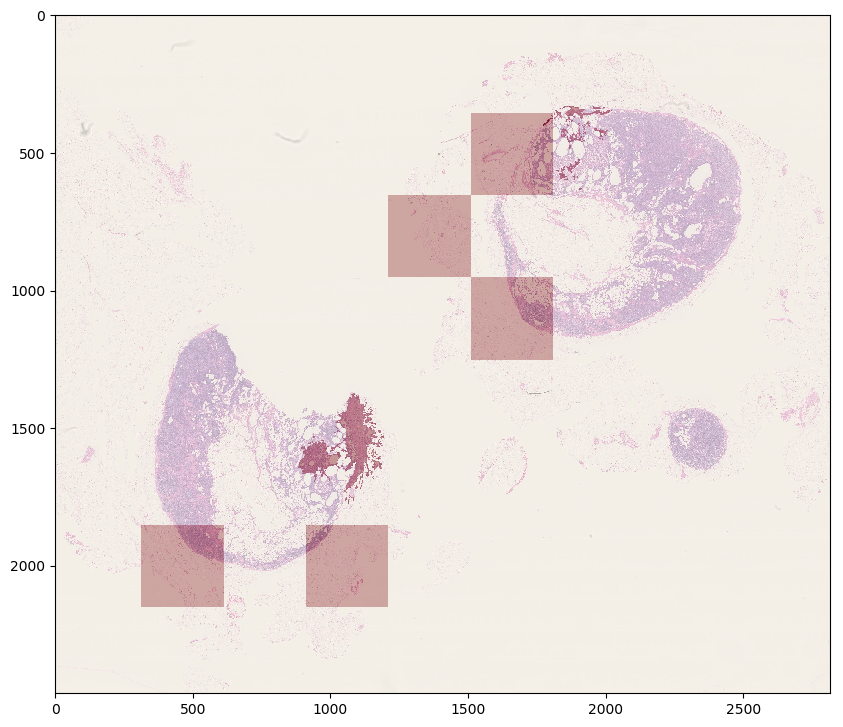

In [144]:
# another try with a different test image
predicted_mask2, slide_image2, mask_image2 = run_inference(3, holdout_names[1], model_baseline)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image2)
plt.imshow(mask_image2, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask2, cmap='OrRd', alpha=0.3)
fig5 = plt.gcf()
fig5.savefig('/mnt/results/prediction_example_baseline_level_3_'+str(holdout_names[1]+'.png'), dpi = 100)
plt.show()

### CNN Model

In [118]:
tf.keras.backend.clear_session()

In [100]:
model_cnn_small = models.Sequential()

model_cnn_small.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (299,299,3)))
model_cnn_small.add(MaxPooling2D((2,2)))

model_cnn_small.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model_cnn_small.add(MaxPooling2D((2,2)))

model_cnn_small.add(layers.Conv2D(64, (3,3), activation = 'relu'))

model_cnn_small.add(layers.Flatten())
model_cnn_small.add(layers.Dense(64, activation='relu'))
model_cnn_small.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_small.compile(Adam(), loss = "binary_crossentropy", metrics=["accuracy"])

In [101]:
model_cnn_small.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 322624)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                20648000  
__________

In [91]:
#note how many fewer parameters.. and how the vast bulk of the parameters are from the single dense layer

In [102]:
BATCH = 32
history_CNN_small_3 = model_cnn_small.fit(X_train, y_train, epochs = 40, validation_split=0.15, batch_size=BATCH,
                            shuffle=True)

Train on 889 samples, validate on 157 samples
Epoch 1/40
889/889 [==============================] - 9s 10ms/step - loss: 7.8583 - acc: 0.5062 - val_loss: 8.9317 - val_acc: 0.4459
Epoch 2/40
889/889 [==============================] - 2s 2ms/step - loss: 7.9049 - acc: 0.5096 - val_loss: 8.9317 - val_acc: 0.4459
Epoch 3/40
889/889 [==============================] - 2s 2ms/step - loss: 7.9049 - acc: 0.5096 - val_loss: 8.9317 - val_acc: 0.4459
Epoch 4/40
889/889 [==============================] - 2s 2ms/step - loss: 7.9049 - acc: 0.5096 - val_loss: 8.9317 - val_acc: 0.4459
Epoch 5/40
889/889 [==============================] - 2s 2ms/step - loss: 7.9049 - acc: 0.5096 - val_loss: 8.9317 - val_acc: 0.4459
Epoch 6/40
889/889 [==============================] - 2s 2ms/step - loss: 7.9049 - acc: 0.5096 - val_loss: 8.9317 - val_acc: 0.4459
Epoch 7/40
889/889 [==============================] - 2s 2ms/step - loss: 7.9049 - acc: 0.5096 - val_loss: 8.9317 - val_acc: 0.4459
Epoch 8/40
889/889 [=========

In [120]:
# CONV => RELU => POOL
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3),input_shape=(299,299,3)))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(128, (3, 3)))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
#model_cnn.add(Dropout(0.25))

# first (and only) set of FC => RELU layers
model_cnn.add(Flatten())
model_cnn.add(Dense(256))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.25))

model_cnn.add(Dense(128))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.25))
 
model_cnn.add(Dense(1, activation = "sigmoid"))
 
# Compile the model
model_cnn.compile(Adam(), loss = "binary_crossentropy", metrics=["accuracy"])

In [121]:
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 297, 297, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 297, 297, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 146, 146, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 146, 146, 64)      256       
__________

In [122]:
#implement early stopping

es_cnn = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20) #stop on minimum validation loss, waiting 10 epochs to observe a lower value
cb_list_cnn = [es_cnn]


In [123]:
BATCH = 32
history_CNN = model_cnn.fit(X_train, y_train, epochs = 50, validation_split=0.2, batch_size=BATCH,
                            shuffle=True, callbacks = cb_list_cnn)

Train on 836 samples, validate on 210 samples
Epoch 1/50
836/836 [==============================] - 7s 8ms/step - loss: 0.6051 - acc: 0.7536 - val_loss: 0.9184 - val_acc: 0.4952
Epoch 2/50
836/836 [==============================] - 4s 4ms/step - loss: 0.4554 - acc: 0.7967 - val_loss: 0.6761 - val_acc: 0.5143
Epoch 3/50
836/836 [==============================] - 4s 4ms/step - loss: 0.4548 - acc: 0.7967 - val_loss: 0.7532 - val_acc: 0.4952
Epoch 4/50
836/836 [==============================] - 4s 4ms/step - loss: 0.4037 - acc: 0.8194 - val_loss: 0.8096 - val_acc: 0.5048
Epoch 5/50
836/836 [==============================] - 4s 4ms/step - loss: 0.3932 - acc: 0.8218 - val_loss: 0.6617 - val_acc: 0.6143
Epoch 6/50
836/836 [==============================] - 4s 4ms/step - loss: 0.3770 - acc: 0.8325 - val_loss: 0.4981 - val_acc: 0.8048
Epoch 7/50
836/836 [==============================] - 4s 4ms/step - loss: 0.3395 - acc: 0.8565 - val_loss: 0.9071 - val_acc: 0.5048
Epoch 8/50
836/836 [==========

In [149]:
#scratch_space = '/domino/datasets/goyetc/medical-imaging/scratch/'
model_cnn_small.save('/domino/datasets/models_output/CNN__small_level_3.h5')  # creates a HDF5 file 'my_model.h5'
#!cp /domino/datasets/models_input/* /domino/datasets/models_output
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

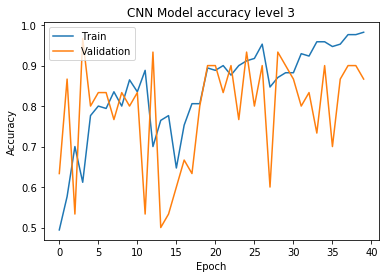

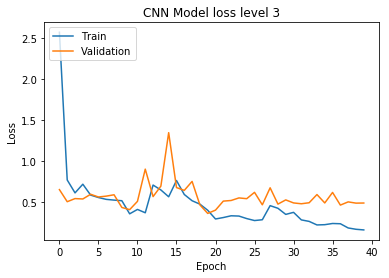

In [150]:
# Plot training & validation accuracy values
plt.plot(history_CNN_small.history['acc'])
plt.plot(history_CNN_small.history['val_acc'])
plt.title('CNN Model accuracy level 3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
fig_acc_cnn = plt.gcf()
fig_acc_cnn.savefig('/mnt/results/accuracy_cnn_small_level_3.png')
plt.show()

# Plot training & validation loss values
plt.plot(history_CNN_small.history['loss'])
plt.plot(history_CNN_small.history['val_loss'])
plt.title('CNN Model loss level 3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
fig_loss_cnn = plt.gcf()
fig_loss_cnn.savefig('/mnt/results/loss_cnn_small_level_3.png')
plt.show()

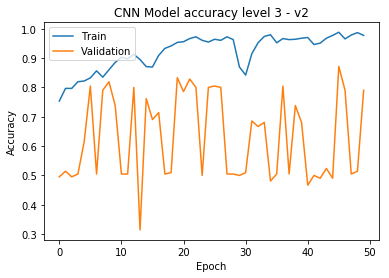

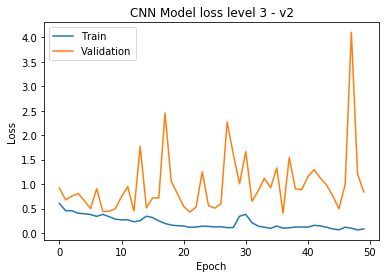

In [125]:
# Plot training & validation accuracy values
plt.plot(history_CNN.history['acc'])
plt.plot(history_CNN.history['val_acc'])
plt.title('CNN Model accuracy level 3 - v2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
fig_acc_cnn = plt.gcf()
fig_acc_cnn.savefig('/mnt/results/accuracy_cnn_v2_level_3.png')
plt.show()

# Plot training & validation loss values
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('CNN Model loss level 3 - v2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
fig_loss_cnn = plt.gcf()
fig_loss_cnn.savefig('/mnt/results/loss_cnn_v2_level_3.png')
plt.show()

In [151]:
# refoprmat validation dataset
X_val = np.asarray(X_test_3) / 255.0
y_val = y_test_3

In [152]:
y_pred_cnn = model_cnn_small.predict(X_val).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_val, y_pred_cnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)

/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


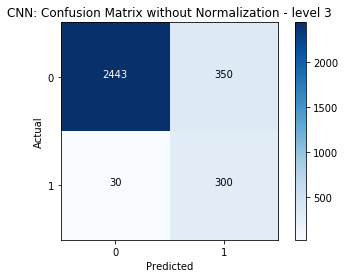

In [153]:
# outputting the confusion matrix
rounded_pred_cnn = np.round(y_pred_cnn)
cf = confusion_matrix(y_val, rounded_pred_cnn)

plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('CNN: Confusion Matrix without Normalization - level 3')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(rounded_pred_cnn))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
fig4 = plt.gcf()
fig4.savefig('/mnt/results/confusion_matrix_CNN_small_level_3.png')
fig4.show()

We further reduce false negatives and improve recall, but it appears precision is slightly worse than baseline/dense model
* Note that a simple change to batch size from 32 to 64 completely changed these results and destroyed recall, while improving accuracy. Very odd. 

In [154]:
precision = cf[1][1]/(cf[0][1] + cf[1][1])
recall = cf[1][1]/(cf[1][1]+ cf[1][0])
print('precision: '+str(precision) + ' recall: '+ str(recall))

precision: 0.46153846153846156 recall: 0.9090909090909091


In [155]:
# generating ROC AUC score
roc_auc_cnn = roc_auc_score(y_val, rounded_pred_base)
print(roc_auc_cnn)

0.9070224261953584


* slightly better precision but worse recall than dense model.. basically same AUC
* with far fewer parameters!

In [156]:
results['AUC_cnn_small_3'] = roc_auc_baseline
results['precision_cnn_small_3'] = precision
results['recall_cnn_small_3'] = recall

Let's run inference using a CNN

/domino/datasets/image_slides_input/slides/tumor_110.tif
/domino/datasets/image_slides_input/slides/tumor_110_mask.tif
opening slide & mask..
predicted mask shape: (8960, 11776)
y: 7616x: 10009
x steps: 28 y steps: 21


/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


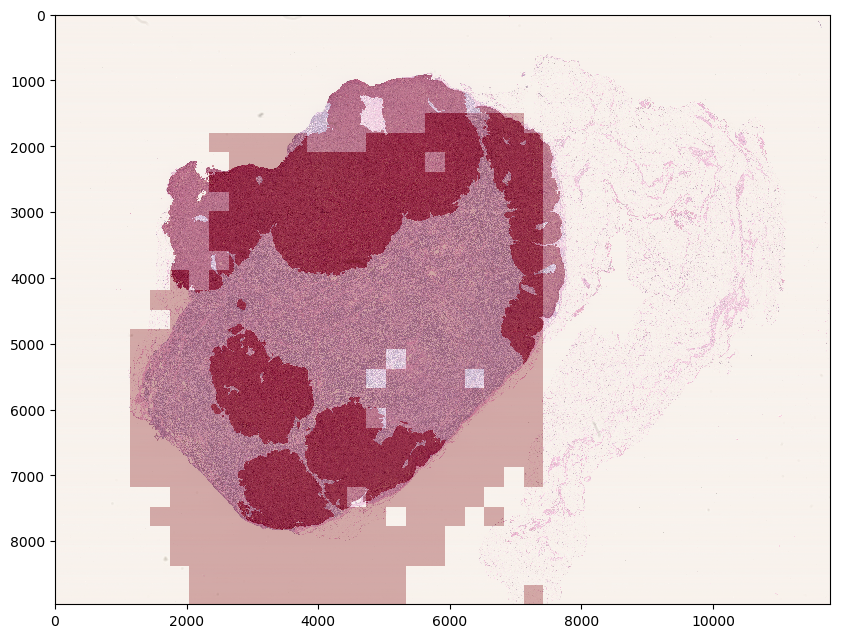

In [160]:
# validate inference works properly with image from training set
predicted_mask_cnn, slide_image_cnn, mask_image_cnn = run_inference(3, holdout_names[0], model = model_cnn_small)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_cnn)
plt.imshow(mask_image_cnn, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_cnn, cmap='OrRd', alpha=0.3)

fig6 = plt.gcf()
fig6.savefig('/mnt/results/prediction_example_CNN_small_level_3_'+str(holdout_names[0]+'.png'), dpi = 100)
fig6.show()

/domino/datasets/image_slides_input/slides/tumor_075.tif
/domino/datasets/image_slides_input/slides/tumor_075_mask.tif
opening slide & mask..
predicted mask shape: (9856, 11264)
y: 8377x: 9574
x steps: 27 y steps: 23


/usr/local/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


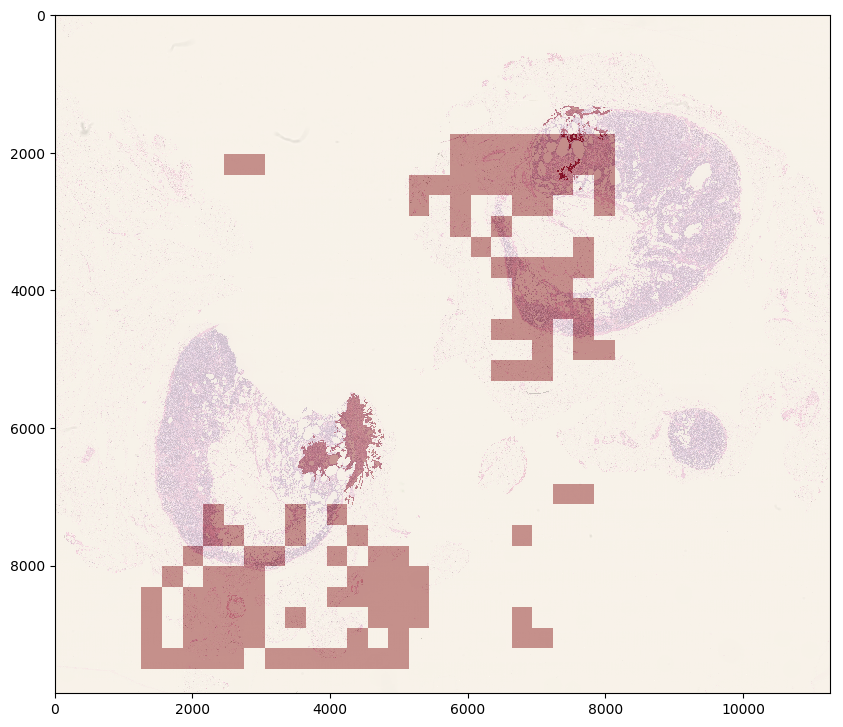

In [161]:
# another try with a different test image
predicted_mask_cnn, slide_image_cnn, mask_image_cnn = run_inference(3, holdout_names[1], model_cnn_small)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_cnn)
plt.imshow(mask_image_cnn, cmap='OrRd', alpha=0.6)
plt.imshow(predicted_mask_cnn, cmap='OrRd', alpha=0.4)
fig7 = plt.gcf()
fig7.savefig('/mnt/results/prediction_example_CNN_small_level_3_'+str(holdout_names[1]+'.png'), dpi = 100)
fig7.show()

### Transfer Learning Model (padded dataset)

Having created the baseline, we wanted to also asses potential performance of a pre-trained model in classifying the dataset. We chose inception trained on ImageNet as our test model.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# using inception
inception = InceptionV3(weights = 'imagenet' , include_top = False, input_shape=(299, 299, 3), classes = 1)
inception.trainable = False

In [ ]:
# setting up the model
model_inception = Sequential()
model_inception.add(inception)

model_inception.add(Flatten())

'''#model_inception.add(layers.Dense(256, activation=tf.nn.relu))
#model_inception.add(layers.Dropout(0.1))
model_inception.add(layers.Dense(256, activation=tf.nn.relu))
model_inception.add(layers.Dropout(0.1))
model_inception.add(layers.Dense(128, activation=tf.nn.relu))
model_inception.add(layers.Dropout(0.1))
model_inception.add(layers.Dense(1, activation='sigmoid'))'''

model_inception.add(layers.Dense(512, activation=tf.nn.relu))
#model_baseline.add(layers.Dropout(0.1))
model_inception.add(layers.Dense(512, activation=tf.nn.relu))
#model_baseline.add(layers.Dropout(0.1))
model_inception.add(layers.Dense(256, activation=tf.nn.relu))
#model_baseline.add(layers.Dropout(0.1))
model_inception.add(layers.Dense(128, activation=tf.nn.relu))
model_inception.add(layers.Dropout(0.1))
model_inception.add(layers.Dense(64, activation=tf.nn.relu))
model_inception.add(layers.Dropout(0.1))
model_inception.add(layers.Dense(1, activation='sigmoid'))

model_inception.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_inception.summary()

In [ ]:
history_inception = model_inception.fit(
      X_train, y_train,
      epochs=30,
      validation_split=0.1,
      verbose=1,
      shuffle=True,
      batch_size=32)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history_inception.history['acc'])
plt.plot(history_inception.history['val_acc'])
plt.title('Inception Transfer Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_inception.history['loss'])
plt.plot(history_inception.history['val_loss'])
plt.title('Inception Transfer Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# creating text_dataset for fitting the model
#X_test, y_test = create_dataset_test(level = 4, image_names = test_names)
#X_test = np.asarray(X_test) / 255.0

In [ ]:
y_pred_inc = model_inception.predict(X_val).ravel()
fpr_inc, tpr_inc, thresholds_inc = roc_curve(y_val, y_pred_inc)
auc_inc = auc(fpr_inc, tpr_inc)

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_inc, tpr_inc, label='inception_v3_transfer (area = {:.3f})'.format(auc_inc))
plt.plot(fpr_base, tpr_base, label='dense_model_baseline (area = {:.3f})'.format(auc_base))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_inc, tpr_inc, label='inception_v3_transfer (area = {:.3f})'.format(auc_inc))
plt.plot(fpr_base, tpr_base, label='dense_model_baseline (area = {:.3f})'.format(auc_base))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
import itertools
# outputting the confusion matrix
rounded_pred = np.round(y_pred_inc)
cf = confusion_matrix(y_val, rounded_pred)

plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(rounded_pred))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

Note: needs to be tuned further

In [ ]:
# generating ROC AUC score
roc_auc_inception = roc_auc_score(y_val, rounded_pred)
print(roc_auc_inception)

Performance not as good as baseline model alone

In [ ]:
# another try with a different test image
predicted_mask_tl, slide_image, mask_image = run_inference(4, test_names[0], model_inception)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_tl, cmap='OrRd', alpha=0.3)
plt.show()

In [ ]:
# another try with a different test image
predicted_mask_tl2, slide_image, mask_image = run_inference(4, test_names[2], model_inception)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_tl2, cmap='OrRd', alpha=0.3)
plt.show()

### Multi-zoom model

**Need to restart the kernel because of the tensorflow conflict or rerun everything on keras instead!**

In [ ]:
import keras.layers # import Input, Dense, Concatenate
import keras.models # import Model

CG Note: I uncommented some print statements to watch the algorithm.. this can be reverted/no need to keep

### Multiple Zoom Levels

In [149]:
# levels is a list of zoom levels, smallest one first, e.g. [5,6]
# v2 = multi-zoom level

def create_dataset_v2_balanced(levels, image_names, with_augmentation=False, padding=True):
    #creating lists for final data and labels
    data = [ [] for i in range(len(levels)) ]
    labels = []
    #test_windows = []
    for image_name in image_names:
        #reading in the slides and masks B@ODW
        slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
        tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
        print(slide_path)
        print(tumor_mask_path)

        #opening them
        print('opening slide & mask..')
        slide = open_slide(slide_path)
        tumor_mask = open_slide(tumor_mask_path)
           
        x_max = int(tumor_mask.level_dimensions[levels[0]][0]*0.85)
        y_max = int(tumor_mask.level_dimensions[levels[0]][1]*0.85)
        print('dims: ' + str(x_max) + ' ' + str(y_max))
        
        #dimensions at chosen level
        x0 = int(.15*x_max) #int(.05*x_max) possibility to create padding
        y0 = int(.15*y_max)  #int(.05*y_max) possibility to create padding
        
        #initiatize coordinates
        if padding == False:
            x0 = 0
            y0 = 0
            x_max = tumor_mask.level_dimensions[levels[0]][0]
            y_max = tumor_mask.level_dimensions[levels[0]][1]
            
        # choosing downsample factor
        #downsample_factor = int(slide.level_downsamples[level])
        downsample_factors = [int(slide.level_downsamples[level]) for level in levels]

        #size of window
        x_dim, y_dim = 299., 299.
        size = (int(x_dim), int(y_dim))
        stride = 128
        border_width = (299. - 128.) / 2.

        #calculate how many steps we can take with 128x128 window
        #x_steps, y_steps = int(((x_max-x0) / x_dim)-1), int(((y_max-y0) / y_dim)-1)
        x_steps, y_steps = int(((x_max-x0) / stride)), int(((y_max-y0) / stride)) # I don't think we need the -1 above since int() already rounds down
        print('x steps: '+ str(x_steps) + ' y steps: '+ str(y_steps))
        
        # balancing the data
        window_labels = []
        window_data = [ [] for i in range(len(levels)) ]
        negative_data = [ [] for i in range(len(levels)) ]
        
        for i in range(x_steps):
            for j in range(y_steps):
              
                print("x is " + str(x0))
                print("y is " + str(y0))
                print("after downsampling x is " + str(int(x0)*downsample_factors[0]))
                print("after downsampling y is " + str(int(y0)*downsample_factors[0]))
                
                window = read_slide(slide, 
                   x=int(x0)*downsample_factors[0], 
                   y=int(y0)*downsample_factors[0], 
                   level=levels[0], 
                   width=int(stride), 
                   height=int(stride))
                window_mask = read_slide(tumor_mask, 
                   x=int(x0)*downsample_factors[0], 
                   y=int(y0)*downsample_factors[0], 
                   level=levels[0], 
                   width=int(stride), 
                   height=int(stride))[:,:,0]
                
                if is_tissue_in_window(window) is True:
                  #test_windows.append(window)
                
                  #if window contains cancer, append 1 to labels; else 0
                  if np.count_nonzero(window_mask.flatten()) > 0:
                      label = 1
                  else:
                      label = 0

                  if with_augmentation is True:
                    window_labels.extend([label] * 9)
                  else:
                    window_labels.append(label)
                  
                  #level_windows = []
                  for index, level in enumerate(levels):
                    #print("level is " + str(level))
                    #print("downsample factor for index is " + str(downsample_factors[index]))
                    level_x = x0*downsample_factors[0] / downsample_factors[index]
                    level_y = y0*downsample_factors[0] / downsample_factors[index]
                    level_x = max(level_x - border_width, 0)
                    level_y = max(level_y - border_width, 0)
                    
                    print("level x is " + str(level_x))
                    print("level y is " + str(level_y))
                    print("after downsampling level x is " + str(int(level_x)*downsample_factors[index]))
                    print("after downsampling level y is " + str(int(level_y)*downsample_factors[index]))

                    level_window = read_slide(slide, 
                                     x=int(level_x)*downsample_factors[index], 
                                     y=int(level_y)*downsample_factors[index], 
                                     level=level, 
                                     width=int(x_dim), 
                                     height=int(y_dim))
                    #conducting sanity check
                    assert level_window.shape == (x_dim, y_dim, 3)
                    level_window = np.float16(np.asarray(level_window) / 255.0)
                    #level_windows.append(level_window)
                    window_data[index].append(level_window)
                    if with_augmentation is True:
                      window_data[index].extend(augment_window(level_window))
                  
                  #data.append(tuple(level_windows))
                  #if with_augmentation is True:
                  #  data.extend(augment_windows(level_windows))

                #move the sliding window on y axis
                #y0 = y0 + y_dim
                y0 = y0 + stride

            #move the sliding window on x axis
            #x0 = x0 + x_dim
            x0 = x0 + stride
            # reset y0 to start
            y0 = int(.15*y_max)
            if padding == False:
              y0 = 0 #if using padding
              
        # sub sample the window data
        pos_count = sum(window_labels) # counting number of positive windows
        # using this number to subsample negatives
        for index, l in enumerate(window_labels):
          if l == 1:
            data[0].append(window_data[0][index])
            data[1].append(window_data[1][index])
            labels.append(1)
          if l == 0:
            negative_data[0].append(window_data[0][index])
            negative_data[1].append(window_data[1][index])
        for k in range(pos_count):
          labels.append(0)
          
        #this is where we can adjust the sampling proportion, negative to positive samples
        rand_inx = np.random.randint(len(negative_data[0]), size=pos_count)
        for i in rand_inx:
          data[0].append(negative_data[0][i])
          data[1].append(negative_data[1][i])

    return data, labels

In [ ]:
# creating a brand new dataset
# this takes a while, grab some coffee:)
# make sure the train and test names are generated in the section above
X_train_towers, y_train_towers = create_dataset_v2_balanced([4,6], train_names, with_augmentation=False)

/domino/datasets/image_slides_input/slides/tumor_091.tif
/domino/datasets/image_slides_input/slides/tumor_091_mask.tif
opening slide & mask..
dims: 3264 2856
x steps: 21 y steps: 18
x is 489
y is 428
after downsampling x is 7335
after downsampling y is 6420
level x is 403.5
level y is 342.5
after downsampling level x is 6045
after downsampling level y is 5130
level x is 45.48214285714286
level y is 29.14285714285714
after downsampling level x is 2520
after downsampling level y is 1624
x is 489
y is 556
after downsampling x is 7335
after downsampling y is 8340
level x is 403.5
level y is 470.5
after downsampling level x is 6045
after downsampling level y is 7050
level x is 45.48214285714286
level y is 63.428571428571416
after downsampling level x is 2520
after downsampling level y is 3528
x is 489
y is 684
after downsampling x is 7335
after downsampling y is 10260
level x is 403.5
level y is 598.5
after downsampling level x is 6045
after downsampling level y is 8970
level x is 45.482142

level x is 531.5
level y is 1366.5
after downsampling level x is 7965
after downsampling level y is 20490
level x is 79.76785714285714
level y is 303.42857142857144
after downsampling level x is 4424
after downsampling level y is 16968
x is 617
y is 1580
after downsampling x is 9255
after downsampling y is 23700
level x is 531.5
level y is 1494.5
after downsampling level x is 7965
after downsampling level y is 22410
level x is 79.76785714285714
level y is 337.7142857142857
after downsampling level x is 4424
after downsampling level y is 18872
x is 617
y is 1708
after downsampling x is 9255
after downsampling y is 25620
level x is 531.5
level y is 1622.5
after downsampling level x is 7965
after downsampling level y is 24330
level x is 79.76785714285714
level y is 372.0
after downsampling level x is 4424
after downsampling level y is 20832
x is 617
y is 1836
after downsampling x is 9255
after downsampling y is 27540
level x is 531.5
level y is 1750.5
after downsampling level x is 7965
af

x is 745
y is 2604
after downsampling x is 11175
after downsampling y is 39060
level x is 659.5
level y is 2518.5
after downsampling level x is 9885
after downsampling level y is 37770
level x is 114.05357142857142
level y is 612.0
after downsampling level x is 6384
after downsampling level y is 34272
x is 873
y is 428
after downsampling x is 13095
after downsampling y is 6420
level x is 787.5
level y is 342.5
after downsampling level x is 11805
after downsampling level y is 5130
level x is 148.33928571428572
level y is 29.14285714285714
after downsampling level x is 8288
after downsampling level y is 1624
x is 873
y is 556
after downsampling x is 13095
after downsampling y is 8340
level x is 787.5
level y is 470.5
after downsampling level x is 11805
after downsampling level y is 7050
level x is 148.33928571428572
level y is 63.428571428571416
after downsampling level x is 8288
after downsampling level y is 3528
x is 873
y is 684
after downsampling x is 13095
after downsampling y is 10

level x is 915.5
level y is 1366.5
after downsampling level x is 13725
after downsampling level y is 20490
level x is 182.625
level y is 303.42857142857144
after downsampling level x is 10192
after downsampling level y is 16968
x is 1001
y is 1580
after downsampling x is 15015
after downsampling y is 23700
level x is 915.5
level y is 1494.5
after downsampling level x is 13725
after downsampling level y is 22410
level x is 182.625
level y is 337.7142857142857
after downsampling level x is 10192
after downsampling level y is 18872
x is 1001
y is 1708
after downsampling x is 15015
after downsampling y is 25620
level x is 915.5
level y is 1622.5
after downsampling level x is 13725
after downsampling level y is 24330
level x is 182.625
level y is 372.0
after downsampling level x is 10192
after downsampling level y is 20832
x is 1001
y is 1836
after downsampling x is 15015
after downsampling y is 27540
level x is 915.5
level y is 1750.5
after downsampling level x is 13725
after downsampling 

level x is 216.91071428571428
level y is 577.7142857142857
after downsampling level x is 12096
after downsampling level y is 32312
x is 1129
y is 2604
after downsampling x is 16935
after downsampling y is 39060
level x is 1043.5
level y is 2518.5
after downsampling level x is 15645
after downsampling level y is 37770
level x is 216.91071428571428
level y is 612.0
after downsampling level x is 12096
after downsampling level y is 34272
x is 1257
y is 428
after downsampling x is 18855
after downsampling y is 6420
level x is 1171.5
level y is 342.5
after downsampling level x is 17565
after downsampling level y is 5130
level x is 251.19642857142856
level y is 29.14285714285714
after downsampling level x is 14056
after downsampling level y is 1624
x is 1257
y is 556
after downsampling x is 18855
after downsampling y is 8340
level x is 1171.5
level y is 470.5
after downsampling level x is 17565
after downsampling level y is 7050
level x is 251.19642857142856
level y is 63.428571428571416
afte

level x is 1299.5
level y is 1238.5
after downsampling level x is 19485
after downsampling level y is 18570
level x is 285.48214285714283
level y is 269.14285714285717
after downsampling level x is 15960
after downsampling level y is 15064
x is 1385
y is 1452
after downsampling x is 20775
after downsampling y is 21780
level x is 1299.5
level y is 1366.5
after downsampling level x is 19485
after downsampling level y is 20490
level x is 285.48214285714283
level y is 303.42857142857144
after downsampling level x is 15960
after downsampling level y is 16968
x is 1385
y is 1580
after downsampling x is 20775
after downsampling y is 23700
level x is 1299.5
level y is 1494.5
after downsampling level x is 19485
after downsampling level y is 22410
level x is 285.48214285714283
level y is 337.7142857142857
after downsampling level x is 15960
after downsampling level y is 18872
x is 1385
y is 1708
after downsampling x is 20775
after downsampling y is 25620
level x is 1299.5
level y is 1622.5
after

level x is 1427.5
level y is 2262.5
after downsampling level x is 21405
after downsampling level y is 33930
level x is 319.76785714285717
level y is 543.4285714285714
after downsampling level x is 17864
after downsampling level y is 30408
x is 1513
y is 2476
after downsampling x is 22695
after downsampling y is 37140
level x is 1427.5
level y is 2390.5
after downsampling level x is 21405
after downsampling level y is 35850
level x is 319.76785714285717
level y is 577.7142857142857
after downsampling level x is 17864
after downsampling level y is 32312
x is 1513
y is 2604
after downsampling x is 22695
after downsampling y is 39060
level x is 1427.5
level y is 2518.5
after downsampling level x is 21405
after downsampling level y is 37770
level x is 319.76785714285717
level y is 612.0
after downsampling level x is 17864
after downsampling level y is 34272
x is 1641
y is 428
after downsampling x is 24615
after downsampling y is 6420
level x is 1555.5
level y is 342.5
after downsampling lev

level x is 1683.5
level y is 982.5
after downsampling level x is 25245
after downsampling level y is 14730
level x is 388.3392857142857
level y is 200.57142857142856
after downsampling level x is 21728
after downsampling level y is 11200
x is 1769
y is 1196
after downsampling x is 26535
after downsampling y is 17940
level x is 1683.5
level y is 1110.5
after downsampling level x is 25245
after downsampling level y is 16650
level x is 388.3392857142857
level y is 234.85714285714283
after downsampling level x is 21728
after downsampling level y is 13104
x is 1769
y is 1324
after downsampling x is 26535
after downsampling y is 19860
level x is 1683.5
level y is 1238.5
after downsampling level x is 25245
after downsampling level y is 18570
level x is 388.3392857142857
level y is 269.14285714285717
after downsampling level x is 21728
after downsampling level y is 15064
x is 1769
y is 1452
after downsampling x is 26535
after downsampling y is 21780
level x is 1683.5
level y is 1366.5
after do

x is 1897
y is 2220
after downsampling x is 28455
after downsampling y is 33300
level x is 1811.5
level y is 2134.5
after downsampling level x is 27165
after downsampling level y is 32010
level x is 422.625
level y is 509.1428571428571
after downsampling level x is 23632
after downsampling level y is 28504
x is 1897
y is 2348
after downsampling x is 28455
after downsampling y is 35220
level x is 1811.5
level y is 2262.5
after downsampling level x is 27165
after downsampling level y is 33930
level x is 422.625
level y is 543.4285714285714
after downsampling level x is 23632
after downsampling level y is 30408
x is 1897
y is 2476
after downsampling x is 28455
after downsampling y is 37140
level x is 1811.5
level y is 2390.5
after downsampling level x is 27165
after downsampling level y is 35850
level x is 422.625
level y is 577.7142857142857
after downsampling level x is 23632
after downsampling level y is 32312
x is 1897
y is 2604
after downsampling x is 28455
after downsampling y is 39

level x is 2067.5
level y is 854.5
after downsampling level x is 31005
after downsampling level y is 12810
level x is 491.19642857142856
level y is 166.28571428571428
after downsampling level x is 27496
after downsampling level y is 9296
x is 2153
y is 1068
after downsampling x is 32295
after downsampling y is 16020
level x is 2067.5
level y is 982.5
after downsampling level x is 31005
after downsampling level y is 14730
level x is 491.19642857142856
level y is 200.57142857142856
after downsampling level x is 27496
after downsampling level y is 11200
x is 2153
y is 1196
after downsampling x is 32295
after downsampling y is 17940
level x is 2067.5
level y is 1110.5
after downsampling level x is 31005
after downsampling level y is 16650
level x is 491.19642857142856
level y is 234.85714285714283
after downsampling level x is 27496
after downsampling level y is 13104
x is 2153
y is 1324
after downsampling x is 32295
after downsampling y is 19860
level x is 2067.5
level y is 1238.5
after d

level x is 525.4821428571429
level y is 440.57142857142856
after downsampling level x is 29400
after downsampling level y is 24640
x is 2281
y is 2092
after downsampling x is 34215
after downsampling y is 31380
level x is 2195.5
level y is 2006.5
after downsampling level x is 32925
after downsampling level y is 30090
level x is 525.4821428571429
level y is 474.8571428571429
after downsampling level x is 29400
after downsampling level y is 26544
x is 2281
y is 2220
after downsampling x is 34215
after downsampling y is 33300
level x is 2195.5
level y is 2134.5
after downsampling level x is 32925
after downsampling level y is 32010
level x is 525.4821428571429
level y is 509.1428571428571
after downsampling level x is 29400
after downsampling level y is 28504
x is 2281
y is 2348
after downsampling x is 34215
after downsampling y is 35220
level x is 2195.5
level y is 2262.5
after downsampling level x is 32925
after downsampling level y is 33930
level x is 525.4821428571429
level y is 543.4

level x is 594.0535714285714
level y is 97.71428571428572
after downsampling level x is 33264
after downsampling level y is 5432
x is 2537
y is 812
after downsampling x is 38055
after downsampling y is 12180
level x is 2451.5
level y is 726.5
after downsampling level x is 36765
after downsampling level y is 10890
level x is 594.0535714285714
level y is 132.0
after downsampling level x is 33264
after downsampling level y is 7392
x is 2537
y is 940
after downsampling x is 38055
after downsampling y is 14100
level x is 2451.5
level y is 854.5
after downsampling level x is 36765
after downsampling level y is 12810
level x is 594.0535714285714
level y is 166.28571428571428
after downsampling level x is 33264
after downsampling level y is 9296
x is 2537
y is 1068
after downsampling x is 38055
after downsampling y is 16020
level x is 2451.5
level y is 982.5
after downsampling level x is 36765
after downsampling level y is 14730
level x is 594.0535714285714
level y is 200.57142857142856
after 

level x is 2579.5
level y is 1750.5
after downsampling level x is 38685
after downsampling level y is 26250
level x is 628.3392857142857
level y is 406.2857142857143
after downsampling level x is 35168
after downsampling level y is 22736
x is 2665
y is 1964
after downsampling x is 39975
after downsampling y is 29460
level x is 2579.5
level y is 1878.5
after downsampling level x is 38685
after downsampling level y is 28170
level x is 628.3392857142857
level y is 440.57142857142856
after downsampling level x is 35168
after downsampling level y is 24640
x is 2665
y is 2092
after downsampling x is 39975
after downsampling y is 31380
level x is 2579.5
level y is 2006.5
after downsampling level x is 38685
after downsampling level y is 30090
level x is 628.3392857142857
level y is 474.8571428571429
after downsampling level x is 35168
after downsampling level y is 26544
x is 2665
y is 2220
after downsampling x is 39975
after downsampling y is 33300
level x is 2579.5
level y is 2134.5
after dow

level x is 2835.5
level y is 598.5
after downsampling level x is 42525
after downsampling level y is 8970
level x is 696.9107142857143
level y is 97.71428571428572
after downsampling level x is 38976
after downsampling level y is 5432
x is 2921
y is 812
after downsampling x is 43815
after downsampling y is 12180
level x is 2835.5
level y is 726.5
after downsampling level x is 42525
after downsampling level y is 10890
level x is 696.9107142857143
level y is 132.0
after downsampling level x is 38976
after downsampling level y is 7392
x is 2921
y is 940
after downsampling x is 43815
after downsampling y is 14100
level x is 2835.5
level y is 854.5
after downsampling level x is 42525
after downsampling level y is 12810
level x is 696.9107142857143
level y is 166.28571428571428
after downsampling level x is 38976
after downsampling level y is 9296
x is 2921
y is 1068
after downsampling x is 43815
after downsampling y is 16020
level x is 2835.5
level y is 982.5
after downsampling level x is 4

level x is 731.1964285714286
level y is 372.0
after downsampling level x is 40936
after downsampling level y is 20832
x is 3049
y is 1836
after downsampling x is 45735
after downsampling y is 27540
level x is 2963.5
level y is 1750.5
after downsampling level x is 44445
after downsampling level y is 26250
level x is 731.1964285714286
level y is 406.2857142857143
after downsampling level x is 40936
after downsampling level y is 22736
x is 3049
y is 1964
after downsampling x is 45735
after downsampling y is 29460
level x is 2963.5
level y is 1878.5
after downsampling level x is 44445
after downsampling level y is 28170
level x is 731.1964285714286
level y is 440.57142857142856
after downsampling level x is 40936
after downsampling level y is 24640
x is 3049
y is 2092
after downsampling x is 45735
after downsampling y is 31380
level x is 2963.5
level y is 2006.5
after downsampling level x is 44445
after downsampling level y is 30090
level x is 731.1964285714286
level y is 474.8571428571429

level x is 693.5
level y is 3968.5
after downsampling level x is 10395
after downsampling level y is 59520
level x is 102.96774193548387
level y is 895.3064516129032
after downsampling level x is 6324
after downsampling level y is 55490
x is 779
y is 4182
after downsampling x is 11685
after downsampling y is 62730
level x is 693.5
level y is 4096.5
after downsampling level x is 10395
after downsampling level y is 61440
level x is 102.96774193548387
level y is 926.2741935483871
after downsampling level x is 6324
after downsampling level y is 57412
x is 779
y is 4310
after downsampling x is 11685
after downsampling y is 64650
level x is 693.5
level y is 4224.5
after downsampling level x is 10395
after downsampling level y is 63360
level x is 102.96774193548387
level y is 957.241935483871
after downsampling level x is 6324
after downsampling level y is 59334
x is 779
y is 4438
after downsampling x is 11685
after downsampling y is 66570
level x is 693.5
level y is 4352.5
after downsampling

level x is 693.5
level y is 7296.5
after downsampling level x is 10395
after downsampling level y is 109440
level x is 102.96774193548387
level y is 1700.467741935484
after downsampling level x is 6324
after downsampling level y is 105400
x is 779
y is 7510
after downsampling x is 11685
after downsampling y is 112650
level x is 693.5
level y is 7424.5
after downsampling level x is 10395
after downsampling level y is 111360
level x is 102.96774193548387
level y is 1731.4354838709678
after downsampling level x is 6324
after downsampling level y is 107322
x is 779
y is 7638
after downsampling x is 11685
after downsampling y is 114570
level x is 693.5
level y is 7552.5
after downsampling level x is 10395
after downsampling level y is 113280
level x is 102.96774193548387
level y is 1762.4032258064517
after downsampling level x is 6324
after downsampling level y is 109244
x is 779
y is 7766
after downsampling x is 11685
after downsampling y is 116490
level x is 693.5
level y is 7680.5
after 

level x is 693.5
level y is 10624.5
after downsampling level x is 10395
after downsampling level y is 159360
level x is 102.96774193548387
level y is 2505.6290322580644
after downsampling level x is 6324
after downsampling level y is 155310
x is 779
y is 10838
after downsampling x is 11685
after downsampling y is 162570
level x is 693.5
level y is 10752.5
after downsampling level x is 10395
after downsampling level y is 161280
level x is 102.96774193548387
level y is 2536.5967741935483
after downsampling level x is 6324
after downsampling level y is 157232
x is 779
y is 10966
after downsampling x is 11685
after downsampling y is 164490
level x is 693.5
level y is 10880.5
after downsampling level x is 10395
after downsampling level y is 163200
level x is 102.96774193548387
level y is 2567.564516129032
after downsampling level x is 6324
after downsampling level y is 159154
x is 779
y is 11094
after downsampling x is 11685
after downsampling y is 166410
level x is 693.5
level y is 11008.5

level x is 821.5
level y is 4096.5
after downsampling level x is 12315
after downsampling level y is 61440
level x is 133.93548387096774
level y is 926.2741935483871
after downsampling level x is 8246
after downsampling level y is 57412
x is 907
y is 4310
after downsampling x is 13605
after downsampling y is 64650
level x is 821.5
level y is 4224.5
after downsampling level x is 12315
after downsampling level y is 63360
level x is 133.93548387096774
level y is 957.241935483871
after downsampling level x is 8246
after downsampling level y is 59334
x is 907
y is 4438
after downsampling x is 13605
after downsampling y is 66570
level x is 821.5
level y is 4352.5
after downsampling level x is 12315
after downsampling level y is 65280
level x is 133.93548387096774
level y is 988.2096774193549
after downsampling level x is 8246
after downsampling level y is 61256
x is 907
y is 4566
after downsampling x is 13605
after downsampling y is 68490
level x is 821.5
level y is 4480.5
after downsampling

level x is 821.5
level y is 7424.5
after downsampling level x is 12315
after downsampling level y is 111360
level x is 133.93548387096774
level y is 1731.4354838709678
after downsampling level x is 8246
after downsampling level y is 107322
x is 907
y is 7638
after downsampling x is 13605
after downsampling y is 114570
level x is 821.5
level y is 7552.5
after downsampling level x is 12315
after downsampling level y is 113280
level x is 133.93548387096774
level y is 1762.4032258064517
after downsampling level x is 8246
after downsampling level y is 109244
x is 907
y is 7766
after downsampling x is 13605
after downsampling y is 116490
level x is 821.5
level y is 7680.5
after downsampling level x is 12315
after downsampling level y is 115200
level x is 133.93548387096774
level y is 1793.3709677419354
after downsampling level x is 8246
after downsampling level y is 111166
x is 907
y is 7894
after downsampling x is 13605
after downsampling y is 118410
level x is 821.5
level y is 7808.5
after

level x is 821.5
level y is 10752.5
after downsampling level x is 12315
after downsampling level y is 161280
level x is 133.93548387096774
level y is 2536.5967741935483
after downsampling level x is 8246
after downsampling level y is 157232
x is 907
y is 10966
after downsampling x is 13605
after downsampling y is 164490
level x is 821.5
level y is 10880.5
after downsampling level x is 12315
after downsampling level y is 163200
level x is 133.93548387096774
level y is 2567.564516129032
after downsampling level x is 8246
after downsampling level y is 159154
x is 907
y is 11094
after downsampling x is 13605
after downsampling y is 166410
level x is 821.5
level y is 11008.5
after downsampling level x is 12315
after downsampling level y is 165120
level x is 133.93548387096774
level y is 2598.532258064516
after downsampling level x is 8246
after downsampling level y is 161076
x is 907
y is 11222
after downsampling x is 13605
after downsampling y is 168330
level x is 821.5
level y is 11136.5


level x is 949.5
level y is 4224.5
after downsampling level x is 14235
after downsampling level y is 63360
level x is 164.90322580645162
level y is 957.241935483871
after downsampling level x is 10168
after downsampling level y is 59334
x is 1035
y is 4438
after downsampling x is 15525
after downsampling y is 66570
level x is 949.5
level y is 4352.5
after downsampling level x is 14235
after downsampling level y is 65280
level x is 164.90322580645162
level y is 988.2096774193549
after downsampling level x is 10168
after downsampling level y is 61256
x is 1035
y is 4566
after downsampling x is 15525
after downsampling y is 68490
level x is 949.5
level y is 4480.5
after downsampling level x is 14235
after downsampling level y is 67200
level x is 164.90322580645162
level y is 1019.1774193548388
after downsampling level x is 10168
after downsampling level y is 63178
x is 1035
y is 4694
after downsampling x is 15525
after downsampling y is 70410
level x is 949.5
level y is 4608.5
after downs

x is 1035
y is 7638
after downsampling x is 15525
after downsampling y is 114570
level x is 949.5
level y is 7552.5
after downsampling level x is 14235
after downsampling level y is 113280
level x is 164.90322580645162
level y is 1762.4032258064517
after downsampling level x is 10168
after downsampling level y is 109244
x is 1035
y is 7766
after downsampling x is 15525
after downsampling y is 116490
level x is 949.5
level y is 7680.5
after downsampling level x is 14235
after downsampling level y is 115200
level x is 164.90322580645162
level y is 1793.3709677419354
after downsampling level x is 10168
after downsampling level y is 111166
x is 1035
y is 7894
after downsampling x is 15525
after downsampling y is 118410
level x is 949.5
level y is 7808.5
after downsampling level x is 14235
after downsampling level y is 117120
level x is 164.90322580645162
level y is 1824.3387096774193
after downsampling level x is 10168
after downsampling level y is 113088
x is 1035
y is 8022
after downsamp

after downsampling x is 15525
after downsampling y is 164490
level x is 949.5
level y is 10880.5
after downsampling level x is 14235
after downsampling level y is 163200
level x is 164.90322580645162
level y is 2567.564516129032
after downsampling level x is 10168
after downsampling level y is 159154
x is 1035
y is 11094
after downsampling x is 15525
after downsampling y is 166410
level x is 949.5
level y is 11008.5
after downsampling level x is 14235
after downsampling level y is 165120
level x is 164.90322580645162
level y is 2598.532258064516
after downsampling level x is 10168
after downsampling level y is 161076
x is 1035
y is 11222
after downsampling x is 15525
after downsampling y is 168330
level x is 949.5
level y is 11136.5
after downsampling level x is 14235
after downsampling level y is 167040
level x is 164.90322580645162
level y is 2629.5
after downsampling level x is 10168
after downsampling level y is 162998
x is 1035
y is 11350
after downsampling x is 15525
after downsa

level x is 1077.5
level y is 4352.5
after downsampling level x is 16155
after downsampling level y is 65280
level x is 195.8709677419355
level y is 988.2096774193549
after downsampling level x is 12090
after downsampling level y is 61256
x is 1163
y is 4566
after downsampling x is 17445
after downsampling y is 68490
level x is 1077.5
level y is 4480.5
after downsampling level x is 16155
after downsampling level y is 67200
level x is 195.8709677419355
level y is 1019.1774193548388
after downsampling level x is 12090
after downsampling level y is 63178
x is 1163
y is 4694
after downsampling x is 17445
after downsampling y is 70410
level x is 1077.5
level y is 4608.5
after downsampling level x is 16155
after downsampling level y is 69120
level x is 195.8709677419355
level y is 1050.1451612903227
after downsampling level x is 12090
after downsampling level y is 65100
x is 1163
y is 4822
after downsampling x is 17445
after downsampling y is 72330
level x is 1077.5
level y is 4736.5
after do

level x is 1077.5
level y is 7680.5
after downsampling level x is 16155
after downsampling level y is 115200
level x is 195.8709677419355
level y is 1793.3709677419354
after downsampling level x is 12090
after downsampling level y is 111166
x is 1163
y is 7894
after downsampling x is 17445
after downsampling y is 118410
level x is 1077.5
level y is 7808.5
after downsampling level x is 16155
after downsampling level y is 117120
level x is 195.8709677419355
level y is 1824.3387096774193
after downsampling level x is 12090
after downsampling level y is 113088
x is 1163
y is 8022
after downsampling x is 17445
after downsampling y is 120330
level x is 1077.5
level y is 7936.5
after downsampling level x is 16155
after downsampling level y is 119040
level x is 195.8709677419355
level y is 1855.3064516129032
after downsampling level x is 12090
after downsampling level y is 115010
x is 1163
y is 8150
after downsampling x is 17445
after downsampling y is 122250
level x is 1077.5
level y is 8064.

level x is 1077.5
level y is 11008.5
after downsampling level x is 16155
after downsampling level y is 165120
level x is 195.8709677419355
level y is 2598.532258064516
after downsampling level x is 12090
after downsampling level y is 161076
x is 1163
y is 11222
after downsampling x is 17445
after downsampling y is 168330
level x is 1077.5
level y is 11136.5
after downsampling level x is 16155
after downsampling level y is 167040
level x is 195.8709677419355
level y is 2629.5
after downsampling level x is 12090
after downsampling level y is 162998
x is 1163
y is 11350
after downsampling x is 17445
after downsampling y is 170250
level x is 1077.5
level y is 11264.5
after downsampling level x is 16155
after downsampling level y is 168960
level x is 195.8709677419355
level y is 2660.467741935484
after downsampling level x is 12090
after downsampling level y is 164920
x is 1163
y is 11478
after downsampling x is 17445
after downsampling y is 172170
level x is 1077.5
level y is 11392.5
after

level x is 1205.5
level y is 4480.5
after downsampling level x is 18075
after downsampling level y is 67200
level x is 226.83870967741933
level y is 1019.1774193548388
after downsampling level x is 14012
after downsampling level y is 63178
x is 1291
y is 4694
after downsampling x is 19365
after downsampling y is 70410
level x is 1205.5
level y is 4608.5
after downsampling level x is 18075
after downsampling level y is 69120
level x is 226.83870967741933
level y is 1050.1451612903227
after downsampling level x is 14012
after downsampling level y is 65100
x is 1291
y is 4822
after downsampling x is 19365
after downsampling y is 72330
level x is 1205.5
level y is 4736.5
after downsampling level x is 18075
after downsampling level y is 71040
level x is 226.83870967741933
level y is 1081.1129032258063
after downsampling level x is 14012
after downsampling level y is 67022
x is 1291
y is 4950
after downsampling x is 19365
after downsampling y is 74250
level x is 1205.5
level y is 4864.5
afte

x is 1291
y is 7894
after downsampling x is 19365
after downsampling y is 118410
level x is 1205.5
level y is 7808.5
after downsampling level x is 18075
after downsampling level y is 117120
level x is 226.83870967741933
level y is 1824.3387096774193
after downsampling level x is 14012
after downsampling level y is 113088
x is 1291
y is 8022
after downsampling x is 19365
after downsampling y is 120330
level x is 1205.5
level y is 7936.5
after downsampling level x is 18075
after downsampling level y is 119040
level x is 226.83870967741933
level y is 1855.3064516129032
after downsampling level x is 14012
after downsampling level y is 115010
x is 1291
y is 8150
after downsampling x is 19365
after downsampling y is 122250
level x is 1205.5
level y is 8064.5
after downsampling level x is 18075
after downsampling level y is 120960
level x is 226.83870967741933
level y is 1886.274193548387
after downsampling level x is 14012
after downsampling level y is 116932
x is 1291
y is 8278
after downsa

x is 1291
y is 11222
after downsampling x is 19365
after downsampling y is 168330
level x is 1205.5
level y is 11136.5
after downsampling level x is 18075
after downsampling level y is 167040
level x is 226.83870967741933
level y is 2629.5
after downsampling level x is 14012
after downsampling level y is 162998
x is 1291
y is 11350
after downsampling x is 19365
after downsampling y is 170250
level x is 1205.5
level y is 11264.5
after downsampling level x is 18075
after downsampling level y is 168960
level x is 226.83870967741933
level y is 2660.467741935484
after downsampling level x is 14012
after downsampling level y is 164920
x is 1291
y is 11478
after downsampling x is 19365
after downsampling y is 172170
level x is 1205.5
level y is 11392.5
after downsampling level x is 18075
after downsampling level y is 170880
level x is 226.83870967741933
level y is 2691.435483870968
after downsampling level x is 14012
after downsampling level y is 166842
x is 1419
y is 1750
after downsampling 

level x is 1333.5
level y is 4608.5
after downsampling level x is 19995
after downsampling level y is 69120
level x is 257.80645161290323
level y is 1050.1451612903227
after downsampling level x is 15934
after downsampling level y is 65100
x is 1419
y is 4822
after downsampling x is 21285
after downsampling y is 72330
level x is 1333.5
level y is 4736.5
after downsampling level x is 19995
after downsampling level y is 71040
level x is 257.80645161290323
level y is 1081.1129032258063
after downsampling level x is 15934
after downsampling level y is 67022
x is 1419
y is 4950
after downsampling x is 21285
after downsampling y is 74250
level x is 1333.5
level y is 4864.5
after downsampling level x is 19995
after downsampling level y is 72960
level x is 257.80645161290323
level y is 1112.0806451612902
after downsampling level x is 15934
after downsampling level y is 68944
x is 1419
y is 5078
after downsampling x is 21285
after downsampling y is 76170
level x is 1333.5
level y is 4992.5
afte

level x is 1333.5
level y is 7936.5
after downsampling level x is 19995
after downsampling level y is 119040
level x is 257.80645161290323
level y is 1855.3064516129032
after downsampling level x is 15934
after downsampling level y is 115010
x is 1419
y is 8150
after downsampling x is 21285
after downsampling y is 122250
level x is 1333.5
level y is 8064.5
after downsampling level x is 19995
after downsampling level y is 120960
level x is 257.80645161290323
level y is 1886.274193548387
after downsampling level x is 15934
after downsampling level y is 116932
x is 1419
y is 8278
after downsampling x is 21285
after downsampling y is 124170
level x is 1333.5
level y is 8192.5
after downsampling level x is 19995
after downsampling level y is 122880
level x is 257.80645161290323
level y is 1917.241935483871
after downsampling level x is 15934
after downsampling level y is 118854
x is 1419
y is 8406
after downsampling x is 21285
after downsampling y is 126090
level x is 1333.5
level y is 8320

level x is 257.80645161290323
level y is 2629.5
after downsampling level x is 15934
after downsampling level y is 162998
x is 1419
y is 11350
after downsampling x is 21285
after downsampling y is 170250
level x is 1333.5
level y is 11264.5
after downsampling level x is 19995
after downsampling level y is 168960
level x is 257.80645161290323
level y is 2660.467741935484
after downsampling level x is 15934
after downsampling level y is 164920
x is 1419
y is 11478
after downsampling x is 21285
after downsampling y is 172170
level x is 1333.5
level y is 11392.5
after downsampling level x is 19995
after downsampling level y is 170880
level x is 257.80645161290323
level y is 2691.435483870968
after downsampling level x is 15934
after downsampling level y is 166842
x is 1547
y is 1750
after downsampling x is 23205
after downsampling y is 26250
level x is 1461.5
level y is 1664.5
after downsampling level x is 21915
after downsampling level y is 24960
level x is 288.7741935483871
level y is 337

level x is 288.7741935483871
level y is 1050.1451612903227
after downsampling level x is 17856
after downsampling level y is 65100
x is 1547
y is 4822
after downsampling x is 23205
after downsampling y is 72330
level x is 1461.5
level y is 4736.5
after downsampling level x is 21915
after downsampling level y is 71040
level x is 288.7741935483871
level y is 1081.1129032258063
after downsampling level x is 17856
after downsampling level y is 67022
x is 1547
y is 4950
after downsampling x is 23205
after downsampling y is 74250
level x is 1461.5
level y is 4864.5
after downsampling level x is 21915
after downsampling level y is 72960
level x is 288.7741935483871
level y is 1112.0806451612902
after downsampling level x is 17856
after downsampling level y is 68944
x is 1547
y is 5078
after downsampling x is 23205
after downsampling y is 76170
level x is 1461.5
level y is 4992.5
after downsampling level x is 21915
after downsampling level y is 74880
level x is 288.7741935483871
level y is 114

level x is 1461.5
level y is 7936.5
after downsampling level x is 21915
after downsampling level y is 119040
level x is 288.7741935483871
level y is 1855.3064516129032
after downsampling level x is 17856
after downsampling level y is 115010
x is 1547
y is 8150
after downsampling x is 23205
after downsampling y is 122250
level x is 1461.5
level y is 8064.5
after downsampling level x is 21915
after downsampling level y is 120960
level x is 288.7741935483871
level y is 1886.274193548387
after downsampling level x is 17856
after downsampling level y is 116932
x is 1547
y is 8278
after downsampling x is 23205
after downsampling y is 124170
level x is 1461.5
level y is 8192.5
after downsampling level x is 21915
after downsampling level y is 122880
level x is 288.7741935483871
level y is 1917.241935483871
after downsampling level x is 17856
after downsampling level y is 118854
x is 1547
y is 8406
after downsampling x is 23205
after downsampling y is 126090
level x is 1461.5
level y is 8320.5


level x is 1461.5
level y is 11264.5
after downsampling level x is 21915
after downsampling level y is 168960
level x is 288.7741935483871
level y is 2660.467741935484
after downsampling level x is 17856
after downsampling level y is 164920
x is 1547
y is 11478
after downsampling x is 23205
after downsampling y is 172170
level x is 1461.5
level y is 11392.5
after downsampling level x is 21915
after downsampling level y is 170880
level x is 288.7741935483871
level y is 2691.435483870968
after downsampling level x is 17856
after downsampling level y is 166842
x is 1675
y is 1750
after downsampling x is 25125
after downsampling y is 26250
level x is 1589.5
level y is 1664.5
after downsampling level x is 23835
after downsampling level y is 24960
level x is 319.741935483871
level y is 337.88709677419354
after downsampling level x is 19778
after downsampling level y is 20894
x is 1675
y is 1878
after downsampling x is 25125
after downsampling y is 28170
level x is 1589.5
level y is 1792.5
af

level x is 1589.5
level y is 4736.5
after downsampling level x is 23835
after downsampling level y is 71040
level x is 319.741935483871
level y is 1081.1129032258063
after downsampling level x is 19778
after downsampling level y is 67022
x is 1675
y is 4950
after downsampling x is 25125
after downsampling y is 74250
level x is 1589.5
level y is 4864.5
after downsampling level x is 23835
after downsampling level y is 72960
level x is 319.741935483871
level y is 1112.0806451612902
after downsampling level x is 19778
after downsampling level y is 68944
x is 1675
y is 5078
after downsampling x is 25125
after downsampling y is 76170
level x is 1589.5
level y is 4992.5
after downsampling level x is 23835
after downsampling level y is 74880
level x is 319.741935483871
level y is 1143.0483870967741
after downsampling level x is 19778
after downsampling level y is 70866
x is 1675
y is 5206
after downsampling x is 25125
after downsampling y is 78090
level x is 1589.5
level y is 5120.5
after down

x is 1675
y is 8150
after downsampling x is 25125
after downsampling y is 122250
level x is 1589.5
level y is 8064.5
after downsampling level x is 23835
after downsampling level y is 120960
level x is 319.741935483871
level y is 1886.274193548387
after downsampling level x is 19778
after downsampling level y is 116932
x is 1675
y is 8278
after downsampling x is 25125
after downsampling y is 124170
level x is 1589.5
level y is 8192.5
after downsampling level x is 23835
after downsampling level y is 122880
level x is 319.741935483871
level y is 1917.241935483871
after downsampling level x is 19778
after downsampling level y is 118854
x is 1675
y is 8406
after downsampling x is 25125
after downsampling y is 126090
level x is 1589.5
level y is 8320.5
after downsampling level x is 23835
after downsampling level y is 124800
level x is 319.741935483871
level y is 1948.2096774193549
after downsampling level x is 19778
after downsampling level y is 120776
x is 1675
y is 8534
after downsampling 

x is 1675
y is 11478
after downsampling x is 25125
after downsampling y is 172170
level x is 1589.5
level y is 11392.5
after downsampling level x is 23835
after downsampling level y is 170880
level x is 319.741935483871
level y is 2691.435483870968
after downsampling level x is 19778
after downsampling level y is 166842
x is 1803
y is 1750
after downsampling x is 27045
after downsampling y is 26250
level x is 1717.5
level y is 1664.5
after downsampling level x is 25755
after downsampling level y is 24960
level x is 350.7096774193548
level y is 337.88709677419354
after downsampling level x is 21700
after downsampling level y is 20894
x is 1803
y is 1878
after downsampling x is 27045
after downsampling y is 28170
level x is 1717.5
level y is 1792.5
after downsampling level x is 25755
after downsampling level y is 26880
level x is 350.7096774193548
level y is 368.85483870967744
after downsampling level x is 21700
after downsampling level y is 22816
x is 1803
y is 2006
after downsampling x

level x is 1717.5
level y is 4864.5
after downsampling level x is 25755
after downsampling level y is 72960
level x is 350.7096774193548
level y is 1112.0806451612902
after downsampling level x is 21700
after downsampling level y is 68944
x is 1803
y is 5078
after downsampling x is 27045
after downsampling y is 76170
level x is 1717.5
level y is 4992.5
after downsampling level x is 25755
after downsampling level y is 74880
level x is 350.7096774193548
level y is 1143.0483870967741
after downsampling level x is 21700
after downsampling level y is 70866
x is 1803
y is 5206
after downsampling x is 27045
after downsampling y is 78090
level x is 1717.5
level y is 5120.5
after downsampling level x is 25755
after downsampling level y is 76800
level x is 350.7096774193548
level y is 1174.016129032258
after downsampling level x is 21700
after downsampling level y is 72788
x is 1803
y is 5334
after downsampling x is 27045
after downsampling y is 80010
level x is 1717.5
level y is 5248.5
after do

x is 1803
y is 8278
after downsampling x is 27045
after downsampling y is 124170
level x is 1717.5
level y is 8192.5
after downsampling level x is 25755
after downsampling level y is 122880
level x is 350.7096774193548
level y is 1917.241935483871
after downsampling level x is 21700
after downsampling level y is 118854
x is 1803
y is 8406
after downsampling x is 27045
after downsampling y is 126090
level x is 1717.5
level y is 8320.5
after downsampling level x is 25755
after downsampling level y is 124800
level x is 350.7096774193548
level y is 1948.2096774193549
after downsampling level x is 21700
after downsampling level y is 120776
x is 1803
y is 8534
after downsampling x is 27045
after downsampling y is 128010
level x is 1717.5
level y is 8448.5
after downsampling level x is 25755
after downsampling level y is 126720
level x is 350.7096774193548
level y is 1979.1774193548385
after downsampling level x is 21700
after downsampling level y is 122698
x is 1803
y is 8662
after downsampl

level x is 350.7096774193548
level y is 2691.435483870968
after downsampling level x is 21700
after downsampling level y is 166842
x is 1931
y is 1750
after downsampling x is 28965
after downsampling y is 26250
level x is 1845.5
level y is 1664.5
after downsampling level x is 27675
after downsampling level y is 24960
level x is 381.6774193548387
level y is 337.88709677419354
after downsampling level x is 23622
after downsampling level y is 20894
x is 1931
y is 1878
after downsampling x is 28965
after downsampling y is 28170
level x is 1845.5
level y is 1792.5
after downsampling level x is 27675
after downsampling level y is 26880
level x is 381.6774193548387
level y is 368.85483870967744
after downsampling level x is 23622
after downsampling level y is 22816
x is 1931
y is 2006
after downsampling x is 28965
after downsampling y is 30090
level x is 1845.5
level y is 1920.5
after downsampling level x is 27675
after downsampling level y is 28800
level x is 381.6774193548387
level y is 399

level x is 381.6774193548387
level y is 1112.0806451612902
after downsampling level x is 23622
after downsampling level y is 68944
x is 1931
y is 5078
after downsampling x is 28965
after downsampling y is 76170
level x is 1845.5
level y is 4992.5
after downsampling level x is 27675
after downsampling level y is 74880
level x is 381.6774193548387
level y is 1143.0483870967741
after downsampling level x is 23622
after downsampling level y is 70866
x is 1931
y is 5206
after downsampling x is 28965
after downsampling y is 78090
level x is 1845.5
level y is 5120.5
after downsampling level x is 27675
after downsampling level y is 76800
level x is 381.6774193548387
level y is 1174.016129032258
after downsampling level x is 23622
after downsampling level y is 72788
x is 1931
y is 5334
after downsampling x is 28965
after downsampling y is 80010
level x is 1845.5
level y is 5248.5
after downsampling level x is 27675
after downsampling level y is 78720
level x is 381.6774193548387
level y is 1204

level x is 1845.5
level y is 8192.5
after downsampling level x is 27675
after downsampling level y is 122880
level x is 381.6774193548387
level y is 1917.241935483871
after downsampling level x is 23622
after downsampling level y is 118854
x is 1931
y is 8406
after downsampling x is 28965
after downsampling y is 126090
level x is 1845.5
level y is 8320.5
after downsampling level x is 27675
after downsampling level y is 124800
level x is 381.6774193548387
level y is 1948.2096774193549
after downsampling level x is 23622
after downsampling level y is 120776
x is 1931
y is 8534
after downsampling x is 28965
after downsampling y is 128010
level x is 1845.5
level y is 8448.5
after downsampling level x is 27675
after downsampling level y is 126720
level x is 381.6774193548387
level y is 1979.1774193548385
after downsampling level x is 23622
after downsampling level y is 122698
x is 1931
y is 8662
after downsampling x is 28965
after downsampling y is 129930
level x is 1845.5
level y is 8576.5

level x is 1973.5
level y is 1664.5
after downsampling level x is 29595
after downsampling level y is 24960
level x is 412.64516129032256
level y is 337.88709677419354
after downsampling level x is 25544
after downsampling level y is 20894
x is 2059
y is 1878
after downsampling x is 30885
after downsampling y is 28170
level x is 1973.5
level y is 1792.5
after downsampling level x is 29595
after downsampling level y is 26880
level x is 412.64516129032256
level y is 368.85483870967744
after downsampling level x is 25544
after downsampling level y is 22816
x is 2059
y is 2006
after downsampling x is 30885
after downsampling y is 30090
level x is 1973.5
level y is 1920.5
after downsampling level x is 29595
after downsampling level y is 28800
level x is 412.64516129032256
level y is 399.8225806451613
after downsampling level x is 25544
after downsampling level y is 24738
x is 2059
y is 2134
after downsampling x is 30885
after downsampling y is 32010
level x is 1973.5
level y is 2048.5
after

level x is 1973.5
level y is 4992.5
after downsampling level x is 29595
after downsampling level y is 74880
level x is 412.64516129032256
level y is 1143.0483870967741
after downsampling level x is 25544
after downsampling level y is 70866
x is 2059
y is 5206
after downsampling x is 30885
after downsampling y is 78090
level x is 1973.5
level y is 5120.5
after downsampling level x is 29595
after downsampling level y is 76800
level x is 412.64516129032256
level y is 1174.016129032258
after downsampling level x is 25544
after downsampling level y is 72788
x is 2059
y is 5334
after downsampling x is 30885
after downsampling y is 80010
level x is 1973.5
level y is 5248.5
after downsampling level x is 29595
after downsampling level y is 78720
level x is 412.64516129032256
level y is 1204.983870967742
after downsampling level x is 25544
after downsampling level y is 74648
x is 2059
y is 5462
after downsampling x is 30885
after downsampling y is 81930
level x is 1973.5
level y is 5376.5
after 

level x is 1973.5
level y is 8320.5
after downsampling level x is 29595
after downsampling level y is 124800
level x is 412.64516129032256
level y is 1948.2096774193549
after downsampling level x is 25544
after downsampling level y is 120776
x is 2059
y is 8534
after downsampling x is 30885
after downsampling y is 128010
level x is 1973.5
level y is 8448.5
after downsampling level x is 29595
after downsampling level y is 126720
level x is 412.64516129032256
level y is 1979.1774193548385
after downsampling level x is 25544
after downsampling level y is 122698
x is 2059
y is 8662
after downsampling x is 30885
after downsampling y is 129930
level x is 1973.5
level y is 8576.5
after downsampling level x is 29595
after downsampling level y is 128640
level x is 412.64516129032256
level y is 2010.1451612903224
after downsampling level x is 25544
after downsampling level y is 124620
x is 2059
y is 8790
after downsampling x is 30885
after downsampling y is 131850
level x is 1973.5
level y is 87

x is 2187
y is 1878
after downsampling x is 32805
after downsampling y is 28170
level x is 2101.5
level y is 1792.5
after downsampling level x is 31515
after downsampling level y is 26880
level x is 443.61290322580646
level y is 368.85483870967744
after downsampling level x is 27466
after downsampling level y is 22816
x is 2187
y is 2006
after downsampling x is 32805
after downsampling y is 30090
level x is 2101.5
level y is 1920.5
after downsampling level x is 31515
after downsampling level y is 28800
level x is 443.61290322580646
level y is 399.8225806451613
after downsampling level x is 27466
after downsampling level y is 24738
x is 2187
y is 2134
after downsampling x is 32805
after downsampling y is 32010
level x is 2101.5
level y is 2048.5
after downsampling level x is 31515
after downsampling level y is 30720
level x is 443.61290322580646
level y is 430.7903225806451
after downsampling level x is 27466
after downsampling level y is 26660
x is 2187
y is 2262
after downsampling x i

x is 2187
y is 5206
after downsampling x is 32805
after downsampling y is 78090
level x is 2101.5
level y is 5120.5
after downsampling level x is 31515
after downsampling level y is 76800
level x is 443.61290322580646
level y is 1174.016129032258
after downsampling level x is 27466
after downsampling level y is 72788
x is 2187
y is 5334
after downsampling x is 32805
after downsampling y is 80010
level x is 2101.5
level y is 5248.5
after downsampling level x is 31515
after downsampling level y is 78720
level x is 443.61290322580646
level y is 1204.983870967742
after downsampling level x is 27466
after downsampling level y is 74648
x is 2187
y is 5462
after downsampling x is 32805
after downsampling y is 81930
level x is 2101.5
level y is 5376.5
after downsampling level x is 31515
after downsampling level y is 80640
level x is 443.61290322580646
level y is 1235.9516129032259
after downsampling level x is 27466
after downsampling level y is 76570
x is 2187
y is 5590
after downsampling x i

level x is 443.61290322580646
level y is 1948.2096774193549
after downsampling level x is 27466
after downsampling level y is 120776
x is 2187
y is 8534
after downsampling x is 32805
after downsampling y is 128010
level x is 2101.5
level y is 8448.5
after downsampling level x is 31515
after downsampling level y is 126720
level x is 443.61290322580646
level y is 1979.1774193548385
after downsampling level x is 27466
after downsampling level y is 122698
x is 2187
y is 8662
after downsampling x is 32805
after downsampling y is 129930
level x is 2101.5
level y is 8576.5
after downsampling level x is 31515
after downsampling level y is 128640
level x is 443.61290322580646
level y is 2010.1451612903224
after downsampling level x is 27466
after downsampling level y is 124620
x is 2187
y is 8790
after downsampling x is 32805
after downsampling y is 131850
level x is 2101.5
level y is 8704.5
after downsampling level x is 31515
after downsampling level y is 130560
level x is 443.61290322580646
l

x is 2315
y is 1878
after downsampling x is 34725
after downsampling y is 28170
level x is 2229.5
level y is 1792.5
after downsampling level x is 33435
after downsampling level y is 26880
level x is 474.58064516129036
level y is 368.85483870967744
after downsampling level x is 29388
after downsampling level y is 22816
x is 2315
y is 2006
after downsampling x is 34725
after downsampling y is 30090
level x is 2229.5
level y is 1920.5
after downsampling level x is 33435
after downsampling level y is 28800
level x is 474.58064516129036
level y is 399.8225806451613
after downsampling level x is 29388
after downsampling level y is 24738
x is 2315
y is 2134
after downsampling x is 34725
after downsampling y is 32010
level x is 2229.5
level y is 2048.5
after downsampling level x is 33435
after downsampling level y is 30720
level x is 474.58064516129036
level y is 430.7903225806451
after downsampling level x is 29388
after downsampling level y is 26660
x is 2315
y is 2262
after downsampling x i

x is 2315
y is 5206
after downsampling x is 34725
after downsampling y is 78090
level x is 2229.5
level y is 5120.5
after downsampling level x is 33435
after downsampling level y is 76800
level x is 474.58064516129036
level y is 1174.016129032258
after downsampling level x is 29388
after downsampling level y is 72788
x is 2315
y is 5334
after downsampling x is 34725
after downsampling y is 80010
level x is 2229.5
level y is 5248.5
after downsampling level x is 33435
after downsampling level y is 78720
level x is 474.58064516129036
level y is 1204.983870967742
after downsampling level x is 29388
after downsampling level y is 74648
x is 2315
y is 5462
after downsampling x is 34725
after downsampling y is 81930
level x is 2229.5
level y is 5376.5
after downsampling level x is 33435
after downsampling level y is 80640
level x is 474.58064516129036
level y is 1235.9516129032259
after downsampling level x is 29388
after downsampling level y is 76570
x is 2315
y is 5590
after downsampling x i

level x is 2229.5
level y is 8448.5
after downsampling level x is 33435
after downsampling level y is 126720
level x is 474.58064516129036
level y is 1979.1774193548385
after downsampling level x is 29388
after downsampling level y is 122698
x is 2315
y is 8662
after downsampling x is 34725
after downsampling y is 129930
level x is 2229.5
level y is 8576.5
after downsampling level x is 33435
after downsampling level y is 128640
level x is 474.58064516129036
level y is 2010.1451612903224
after downsampling level x is 29388
after downsampling level y is 124620
x is 2315
y is 8790
after downsampling x is 34725
after downsampling y is 131850
level x is 2229.5
level y is 8704.5
after downsampling level x is 33435
after downsampling level y is 130560
level x is 474.58064516129036
level y is 2041.1129032258063
after downsampling level x is 29388
after downsampling level y is 126542
x is 2315
y is 8918
after downsampling x is 34725
after downsampling y is 133770
level x is 2229.5
level y is 88

x is 2443
y is 2006
after downsampling x is 36645
after downsampling y is 30090
level x is 2357.5
level y is 1920.5
after downsampling level x is 35355
after downsampling level y is 28800
level x is 505.54838709677415
level y is 399.8225806451613
after downsampling level x is 31310
after downsampling level y is 24738
x is 2443
y is 2134
after downsampling x is 36645
after downsampling y is 32010
level x is 2357.5
level y is 2048.5
after downsampling level x is 35355
after downsampling level y is 30720
level x is 505.54838709677415
level y is 430.7903225806451
after downsampling level x is 31310
after downsampling level y is 26660
x is 2443
y is 2262
after downsampling x is 36645
after downsampling y is 33930
level x is 2357.5
level y is 2176.5
after downsampling level x is 35355
after downsampling level y is 32640
level x is 505.54838709677415
level y is 461.758064516129
after downsampling level x is 31310
after downsampling level y is 28582
x is 2443
y is 2390
after downsampling x is 

x is 2443
y is 5334
after downsampling x is 36645
after downsampling y is 80010
level x is 2357.5
level y is 5248.5
after downsampling level x is 35355
after downsampling level y is 78720
level x is 505.54838709677415
level y is 1204.983870967742
after downsampling level x is 31310
after downsampling level y is 74648
x is 2443
y is 5462
after downsampling x is 36645
after downsampling y is 81930
level x is 2357.5
level y is 5376.5
after downsampling level x is 35355
after downsampling level y is 80640
level x is 505.54838709677415
level y is 1235.9516129032259
after downsampling level x is 31310
after downsampling level y is 76570
x is 2443
y is 5590
after downsampling x is 36645
after downsampling y is 83850
level x is 2357.5
level y is 5504.5
after downsampling level x is 35355
after downsampling level y is 82560
level x is 505.54838709677415
level y is 1266.9193548387098
after downsampling level x is 31310
after downsampling level y is 78492
x is 2443
y is 5718
after downsampling x 

level x is 505.54838709677415
level y is 1979.1774193548385
after downsampling level x is 31310
after downsampling level y is 122698
x is 2443
y is 8662
after downsampling x is 36645
after downsampling y is 129930
level x is 2357.5
level y is 8576.5
after downsampling level x is 35355
after downsampling level y is 128640
level x is 505.54838709677415
level y is 2010.1451612903224
after downsampling level x is 31310
after downsampling level y is 124620
x is 2443
y is 8790
after downsampling x is 36645
after downsampling y is 131850
level x is 2357.5
level y is 8704.5
after downsampling level x is 35355
after downsampling level y is 130560
level x is 505.54838709677415
level y is 2041.1129032258063
after downsampling level x is 31310
after downsampling level y is 126542
x is 2443
y is 8918
after downsampling x is 36645
after downsampling y is 133770
level x is 2357.5
level y is 8832.5
after downsampling level x is 35355
after downsampling level y is 132480
level x is 505.54838709677415
l

level x is 2485.5
level y is 1920.5
after downsampling level x is 37275
after downsampling level y is 28800
level x is 536.516129032258
level y is 399.8225806451613
after downsampling level x is 33232
after downsampling level y is 24738
x is 2571
y is 2134
after downsampling x is 38565
after downsampling y is 32010
level x is 2485.5
level y is 2048.5
after downsampling level x is 37275
after downsampling level y is 30720
level x is 536.516129032258
level y is 430.7903225806451
after downsampling level x is 33232
after downsampling level y is 26660
x is 2571
y is 2262
after downsampling x is 38565
after downsampling y is 33930
level x is 2485.5
level y is 2176.5
after downsampling level x is 37275
after downsampling level y is 32640
level x is 536.516129032258
level y is 461.758064516129
after downsampling level x is 33232
after downsampling level y is 28582
x is 2571
y is 2390
after downsampling x is 38565
after downsampling y is 35850
level x is 2485.5
level y is 2304.5
after downsamp

level x is 2485.5
level y is 5248.5
after downsampling level x is 37275
after downsampling level y is 78720
level x is 536.516129032258
level y is 1204.983870967742
after downsampling level x is 33232
after downsampling level y is 74648
x is 2571
y is 5462
after downsampling x is 38565
after downsampling y is 81930
level x is 2485.5
level y is 5376.5
after downsampling level x is 37275
after downsampling level y is 80640
level x is 536.516129032258
level y is 1235.9516129032259
after downsampling level x is 33232
after downsampling level y is 76570
x is 2571
y is 5590
after downsampling x is 38565
after downsampling y is 83850
level x is 2485.5
level y is 5504.5
after downsampling level x is 37275
after downsampling level y is 82560
level x is 536.516129032258
level y is 1266.9193548387098
after downsampling level x is 33232
after downsampling level y is 78492
x is 2571
y is 5718
after downsampling x is 38565
after downsampling y is 85770
level x is 2485.5
level y is 5632.5
after downs

level x is 2485.5
level y is 8576.5
after downsampling level x is 37275
after downsampling level y is 128640
level x is 536.516129032258
level y is 2010.1451612903224
after downsampling level x is 33232
after downsampling level y is 124620
x is 2571
y is 8790
after downsampling x is 38565
after downsampling y is 131850
level x is 2485.5
level y is 8704.5
after downsampling level x is 37275
after downsampling level y is 130560
level x is 536.516129032258
level y is 2041.1129032258063
after downsampling level x is 33232
after downsampling level y is 126542
x is 2571
y is 8918
after downsampling x is 38565
after downsampling y is 133770
level x is 2485.5
level y is 8832.5
after downsampling level x is 37275
after downsampling level y is 132480
level x is 536.516129032258
level y is 2072.0806451612902
after downsampling level x is 33232
after downsampling level y is 128464
x is 2571
y is 9046
after downsampling x is 38565
after downsampling y is 135690
level x is 2485.5
level y is 8960.5
a

level x is 2613.5
level y is 2048.5
after downsampling level x is 39195
after downsampling level y is 30720
level x is 567.483870967742
level y is 430.7903225806451
after downsampling level x is 35154
after downsampling level y is 26660
x is 2699
y is 2262
after downsampling x is 40485
after downsampling y is 33930
level x is 2613.5
level y is 2176.5
after downsampling level x is 39195
after downsampling level y is 32640
level x is 567.483870967742
level y is 461.758064516129
after downsampling level x is 35154
after downsampling level y is 28582
x is 2699
y is 2390
after downsampling x is 40485
after downsampling y is 35850
level x is 2613.5
level y is 2304.5
after downsampling level x is 39195
after downsampling level y is 34560
level x is 567.483870967742
level y is 492.7258064516129
after downsampling level x is 35154
after downsampling level y is 30504
x is 2699
y is 2518
after downsampling x is 40485
after downsampling y is 37770
level x is 2613.5
level y is 2432.5
after downsamp

level x is 567.483870967742
level y is 1235.9516129032259
after downsampling level x is 35154
after downsampling level y is 76570
x is 2699
y is 5590
after downsampling x is 40485
after downsampling y is 83850
level x is 2613.5
level y is 5504.5
after downsampling level x is 39195
after downsampling level y is 82560
level x is 567.483870967742
level y is 1266.9193548387098
after downsampling level x is 35154
after downsampling level y is 78492
x is 2699
y is 5718
after downsampling x is 40485
after downsampling y is 85770
level x is 2613.5
level y is 5632.5
after downsampling level x is 39195
after downsampling level y is 84480
level x is 567.483870967742
level y is 1297.8870967741937
after downsampling level x is 35154
after downsampling level y is 80414
x is 2699
y is 5846
after downsampling x is 40485
after downsampling y is 87690
level x is 2613.5
level y is 5760.5
after downsampling level x is 39195
after downsampling level y is 86400
level x is 567.483870967742
level y is 1328.85

level x is 567.483870967742
level y is 2041.1129032258063
after downsampling level x is 35154
after downsampling level y is 126542
x is 2699
y is 8918
after downsampling x is 40485
after downsampling y is 133770
level x is 2613.5
level y is 8832.5
after downsampling level x is 39195
after downsampling level y is 132480
level x is 567.483870967742
level y is 2072.0806451612902
after downsampling level x is 35154
after downsampling level y is 128464
x is 2699
y is 9046
after downsampling x is 40485
after downsampling y is 135690
level x is 2613.5
level y is 8960.5
after downsampling level x is 39195
after downsampling level y is 134400
level x is 567.483870967742
level y is 2103.048387096774
after downsampling level x is 35154
after downsampling level y is 130386
x is 2699
y is 9174
after downsampling x is 40485
after downsampling y is 137610
level x is 2613.5
level y is 9088.5
after downsampling level x is 39195
after downsampling level y is 136320
level x is 567.483870967742
level y is

level x is 598.4516129032259
level y is 461.758064516129
after downsampling level x is 37076
after downsampling level y is 28582
x is 2827
y is 2390
after downsampling x is 42405
after downsampling y is 35850
level x is 2741.5
level y is 2304.5
after downsampling level x is 41115
after downsampling level y is 34560
level x is 598.4516129032259
level y is 492.7258064516129
after downsampling level x is 37076
after downsampling level y is 30504
x is 2827
y is 2518
after downsampling x is 42405
after downsampling y is 37770
level x is 2741.5
level y is 2432.5
after downsampling level x is 41115
after downsampling level y is 36480
level x is 598.4516129032259
level y is 523.6935483870968
after downsampling level x is 37076
after downsampling level y is 32426
x is 2827
y is 2646
after downsampling x is 42405
after downsampling y is 39690
level x is 2741.5
level y is 2560.5
after downsampling level x is 41115
after downsampling level y is 38400
level x is 598.4516129032259
level y is 554.661

level x is 2741.5
level y is 5632.5
after downsampling level x is 41115
after downsampling level y is 84480
level x is 598.4516129032259
level y is 1297.8870967741937
after downsampling level x is 37076
after downsampling level y is 80414
x is 2827
y is 5846
after downsampling x is 42405
after downsampling y is 87690
level x is 2741.5
level y is 5760.5
after downsampling level x is 41115
after downsampling level y is 86400
level x is 598.4516129032259
level y is 1328.8548387096773
after downsampling level x is 37076
after downsampling level y is 82336
x is 2827
y is 5974
after downsampling x is 42405
after downsampling y is 89610
level x is 2741.5
level y is 5888.5
after downsampling level x is 41115
after downsampling level y is 88320
level x is 598.4516129032259
level y is 1359.8225806451612
after downsampling level x is 37076
after downsampling level y is 84258
x is 2827
y is 6102
after downsampling x is 42405
after downsampling y is 91530
level x is 2741.5
level y is 6016.5
after d

level x is 2741.5
level y is 8960.5
after downsampling level x is 41115
after downsampling level y is 134400
level x is 598.4516129032259
level y is 2103.048387096774
after downsampling level x is 37076
after downsampling level y is 130386
x is 2827
y is 9174
after downsampling x is 42405
after downsampling y is 137610
level x is 2741.5
level y is 9088.5
after downsampling level x is 41115
after downsampling level y is 136320
level x is 598.4516129032259
level y is 2134.016129032258
after downsampling level x is 37076
after downsampling level y is 132308
x is 2827
y is 9302
after downsampling x is 42405
after downsampling y is 139530
level x is 2741.5
level y is 9216.5
after downsampling level x is 41115
after downsampling level y is 138240
level x is 598.4516129032259
level y is 2164.983870967742
after downsampling level x is 37076
after downsampling level y is 134168
x is 2827
y is 9430
after downsampling x is 42405
after downsampling y is 141450
level x is 2741.5
level y is 9344.5
a

level x is 2869.5
level y is 2432.5
after downsampling level x is 43035
after downsampling level y is 36480
level x is 629.4193548387096
level y is 523.6935483870968
after downsampling level x is 38998
after downsampling level y is 32426
x is 2955
y is 2646
after downsampling x is 44325
after downsampling y is 39690
level x is 2869.5
level y is 2560.5
after downsampling level x is 43035
after downsampling level y is 38400
level x is 629.4193548387096
level y is 554.6612903225806
after downsampling level x is 38998
after downsampling level y is 34348
x is 2955
y is 2774
after downsampling x is 44325
after downsampling y is 41610
level x is 2869.5
level y is 2688.5
after downsampling level x is 43035
after downsampling level y is 40320
level x is 629.4193548387096
level y is 585.6290322580645
after downsampling level x is 38998
after downsampling level y is 36270
x is 2955
y is 2902
after downsampling x is 44325
after downsampling y is 43530
level x is 2869.5
level y is 2816.5
after down

level x is 2869.5
level y is 5760.5
after downsampling level x is 43035
after downsampling level y is 86400
level x is 629.4193548387096
level y is 1328.8548387096773
after downsampling level x is 38998
after downsampling level y is 82336
x is 2955
y is 5974
after downsampling x is 44325
after downsampling y is 89610
level x is 2869.5
level y is 5888.5
after downsampling level x is 43035
after downsampling level y is 88320
level x is 629.4193548387096
level y is 1359.8225806451612
after downsampling level x is 38998
after downsampling level y is 84258
x is 2955
y is 6102
after downsampling x is 44325
after downsampling y is 91530
level x is 2869.5
level y is 6016.5
after downsampling level x is 43035
after downsampling level y is 90240
level x is 629.4193548387096
level y is 1390.7903225806451
after downsampling level x is 38998
after downsampling level y is 86180
x is 2955
y is 6230
after downsampling x is 44325
after downsampling y is 93450
level x is 2869.5
level y is 6144.5
after d

level x is 2869.5
level y is 9088.5
after downsampling level x is 43035
after downsampling level y is 136320
level x is 629.4193548387096
level y is 2134.016129032258
after downsampling level x is 38998
after downsampling level y is 132308
x is 2955
y is 9302
after downsampling x is 44325
after downsampling y is 139530
level x is 2869.5
level y is 9216.5
after downsampling level x is 43035
after downsampling level y is 138240
level x is 629.4193548387096
level y is 2164.983870967742
after downsampling level x is 38998
after downsampling level y is 134168
x is 2955
y is 9430
after downsampling x is 44325
after downsampling y is 141450
level x is 2869.5
level y is 9344.5
after downsampling level x is 43035
after downsampling level y is 140160
level x is 629.4193548387096
level y is 2195.951612903226
after downsampling level x is 38998
after downsampling level y is 136090
x is 2955
y is 9558
after downsampling x is 44325
after downsampling y is 143370
level x is 2869.5
level y is 9472.5
a

x is 3083
y is 2646
after downsampling x is 46245
after downsampling y is 39690
level x is 2997.5
level y is 2560.5
after downsampling level x is 44955
after downsampling level y is 38400
level x is 660.3870967741935
level y is 554.6612903225806
after downsampling level x is 40920
after downsampling level y is 34348
x is 3083
y is 2774
after downsampling x is 46245
after downsampling y is 41610
level x is 2997.5
level y is 2688.5
after downsampling level x is 44955
after downsampling level y is 40320
level x is 660.3870967741935
level y is 585.6290322580645
after downsampling level x is 40920
after downsampling level y is 36270
x is 3083
y is 2902
after downsampling x is 46245
after downsampling y is 43530
level x is 2997.5
level y is 2816.5
after downsampling level x is 44955
after downsampling level y is 42240
level x is 660.3870967741935
level y is 616.5967741935484
after downsampling level x is 40920
after downsampling level y is 38192
x is 3083
y is 3030
after downsampling x is 46

x is 3083
y is 5974
after downsampling x is 46245
after downsampling y is 89610
level x is 2997.5
level y is 5888.5
after downsampling level x is 44955
after downsampling level y is 88320
level x is 660.3870967741935
level y is 1359.8225806451612
after downsampling level x is 40920
after downsampling level y is 84258
x is 3083
y is 6102
after downsampling x is 46245
after downsampling y is 91530
level x is 2997.5
level y is 6016.5
after downsampling level x is 44955
after downsampling level y is 90240
level x is 660.3870967741935
level y is 1390.7903225806451
after downsampling level x is 40920
after downsampling level y is 86180
x is 3083
y is 6230
after downsampling x is 46245
after downsampling y is 93450
level x is 2997.5
level y is 6144.5
after downsampling level x is 44955
after downsampling level y is 92160
level x is 660.3870967741935
level y is 1421.758064516129
after downsampling level x is 40920
after downsampling level y is 88102
x is 3083
y is 6358
after downsampling x is 

x is 3083
y is 9302
after downsampling x is 46245
after downsampling y is 139530
level x is 2997.5
level y is 9216.5
after downsampling level x is 44955
after downsampling level y is 138240
level x is 660.3870967741935
level y is 2164.983870967742
after downsampling level x is 40920
after downsampling level y is 134168
x is 3083
y is 9430
after downsampling x is 46245
after downsampling y is 141450
level x is 2997.5
level y is 9344.5
after downsampling level x is 44955
after downsampling level y is 140160
level x is 660.3870967741935
level y is 2195.951612903226
after downsampling level x is 40920
after downsampling level y is 136090
x is 3083
y is 9558
after downsampling x is 46245
after downsampling y is 143370
level x is 2997.5
level y is 9472.5
after downsampling level x is 44955
after downsampling level y is 142080
level x is 660.3870967741935
level y is 2226.9193548387098
after downsampling level x is 40920
after downsampling level y is 138012
x is 3083
y is 9686
after downsampli

level x is 3125.5
level y is 2688.5
after downsampling level x is 46875
after downsampling level y is 40320
level x is 691.3548387096774
level y is 585.6290322580645
after downsampling level x is 42842
after downsampling level y is 36270
x is 3211
y is 2902
after downsampling x is 48165
after downsampling y is 43530
level x is 3125.5
level y is 2816.5
after downsampling level x is 46875
after downsampling level y is 42240
level x is 691.3548387096774
level y is 616.5967741935484
after downsampling level x is 42842
after downsampling level y is 38192
x is 3211
y is 3030
after downsampling x is 48165
after downsampling y is 45450
level x is 3125.5
level y is 2944.5
after downsampling level x is 46875
after downsampling level y is 44160
level x is 691.3548387096774
level y is 647.5645161290323
after downsampling level x is 42842
after downsampling level y is 40114
x is 3211
y is 3158
after downsampling x is 48165
after downsampling y is 47370
level x is 3125.5
level y is 3072.5
after down

level x is 691.3548387096774
level y is 1390.7903225806451
after downsampling level x is 42842
after downsampling level y is 86180
x is 3211
y is 6230
after downsampling x is 48165
after downsampling y is 93450
level x is 3125.5
level y is 6144.5
after downsampling level x is 46875
after downsampling level y is 92160
level x is 691.3548387096774
level y is 1421.758064516129
after downsampling level x is 42842
after downsampling level y is 88102
x is 3211
y is 6358
after downsampling x is 48165
after downsampling y is 95370
level x is 3125.5
level y is 6272.5
after downsampling level x is 46875
after downsampling level y is 94080
level x is 691.3548387096774
level y is 1452.725806451613
after downsampling level x is 42842
after downsampling level y is 90024
x is 3211
y is 6486
after downsampling x is 48165
after downsampling y is 97290
level x is 3125.5
level y is 6400.5
after downsampling level x is 46875
after downsampling level y is 96000
level x is 691.3548387096774
level y is 1483.

level x is 3125.5
level y is 9344.5
after downsampling level x is 46875
after downsampling level y is 140160
level x is 691.3548387096774
level y is 2195.951612903226
after downsampling level x is 42842
after downsampling level y is 136090
x is 3211
y is 9558
after downsampling x is 48165
after downsampling y is 143370
level x is 3125.5
level y is 9472.5
after downsampling level x is 46875
after downsampling level y is 142080
level x is 691.3548387096774
level y is 2226.9193548387098
after downsampling level x is 42842
after downsampling level y is 138012
x is 3211
y is 9686
after downsampling x is 48165
after downsampling y is 145290
level x is 3125.5
level y is 9600.5
after downsampling level x is 46875
after downsampling level y is 144000
level x is 691.3548387096774
level y is 2257.8870967741937
after downsampling level x is 42842
after downsampling level y is 139934
x is 3211
y is 9814
after downsampling x is 48165
after downsampling y is 147210
level x is 3125.5
level y is 9728.5

level x is 3253.5
level y is 2816.5
after downsampling level x is 48795
after downsampling level y is 42240
level x is 722.3225806451613
level y is 616.5967741935484
after downsampling level x is 44764
after downsampling level y is 38192
x is 3339
y is 3030
after downsampling x is 50085
after downsampling y is 45450
level x is 3253.5
level y is 2944.5
after downsampling level x is 48795
after downsampling level y is 44160
level x is 722.3225806451613
level y is 647.5645161290323
after downsampling level x is 44764
after downsampling level y is 40114
x is 3339
y is 3158
after downsampling x is 50085
after downsampling y is 47370
level x is 3253.5
level y is 3072.5
after downsampling level x is 48795
after downsampling level y is 46080
level x is 722.3225806451613
level y is 678.5322580645161
after downsampling level x is 44764
after downsampling level y is 42036
x is 3339
y is 3286
after downsampling x is 50085
after downsampling y is 49290
level x is 3253.5
level y is 3200.5
after down

level x is 3253.5
level y is 6144.5
after downsampling level x is 48795
after downsampling level y is 92160
level x is 722.3225806451613
level y is 1421.758064516129
after downsampling level x is 44764
after downsampling level y is 88102
x is 3339
y is 6358
after downsampling x is 50085
after downsampling y is 95370
level x is 3253.5
level y is 6272.5
after downsampling level x is 48795
after downsampling level y is 94080
level x is 722.3225806451613
level y is 1452.725806451613
after downsampling level x is 44764
after downsampling level y is 90024
x is 3339
y is 6486
after downsampling x is 50085
after downsampling y is 97290
level x is 3253.5
level y is 6400.5
after downsampling level x is 48795
after downsampling level y is 96000
level x is 722.3225806451613
level y is 1483.6935483870968
after downsampling level x is 44764
after downsampling level y is 91946
x is 3339
y is 6614
after downsampling x is 50085
after downsampling y is 99210
level x is 3253.5
level y is 6528.5
after dow

level x is 3253.5
level y is 9472.5
after downsampling level x is 48795
after downsampling level y is 142080
level x is 722.3225806451613
level y is 2226.9193548387098
after downsampling level x is 44764
after downsampling level y is 138012
x is 3339
y is 9686
after downsampling x is 50085
after downsampling y is 145290
level x is 3253.5
level y is 9600.5
after downsampling level x is 48795
after downsampling level y is 144000
level x is 722.3225806451613
level y is 2257.8870967741937
after downsampling level x is 44764
after downsampling level y is 139934
x is 3339
y is 9814
after downsampling x is 50085
after downsampling y is 147210
level x is 3253.5
level y is 9728.5
after downsampling level x is 48795
after downsampling level y is 145920
level x is 722.3225806451613
level y is 2288.8548387096776
after downsampling level x is 44764
after downsampling level y is 141856
x is 3339
y is 9942
after downsampling x is 50085
after downsampling y is 149130
level x is 3253.5
level y is 9856.

level x is 3381.5
level y is 2944.5
after downsampling level x is 50715
after downsampling level y is 44160
level x is 753.2903225806451
level y is 647.5645161290323
after downsampling level x is 46686
after downsampling level y is 40114
x is 3467
y is 3158
after downsampling x is 52005
after downsampling y is 47370
level x is 3381.5
level y is 3072.5
after downsampling level x is 50715
after downsampling level y is 46080
level x is 753.2903225806451
level y is 678.5322580645161
after downsampling level x is 46686
after downsampling level y is 42036
x is 3467
y is 3286
after downsampling x is 52005
after downsampling y is 49290
level x is 3381.5
level y is 3200.5
after downsampling level x is 50715
after downsampling level y is 48000
level x is 753.2903225806451
level y is 709.5
after downsampling level x is 46686
after downsampling level y is 43958
x is 3467
y is 3414
after downsampling x is 52005
after downsampling y is 51210
level x is 3381.5
level y is 3328.5
after downsampling lev

level x is 3381.5
level y is 6272.5
after downsampling level x is 50715
after downsampling level y is 94080
level x is 753.2903225806451
level y is 1452.725806451613
after downsampling level x is 46686
after downsampling level y is 90024
x is 3467
y is 6486
after downsampling x is 52005
after downsampling y is 97290
level x is 3381.5
level y is 6400.5
after downsampling level x is 50715
after downsampling level y is 96000
level x is 753.2903225806451
level y is 1483.6935483870968
after downsampling level x is 46686
after downsampling level y is 91946
x is 3467
y is 6614
after downsampling x is 52005
after downsampling y is 99210
level x is 3381.5
level y is 6528.5
after downsampling level x is 50715
after downsampling level y is 97920
level x is 753.2903225806451
level y is 1514.6612903225807
after downsampling level x is 46686
after downsampling level y is 93868
x is 3467
y is 6742
after downsampling x is 52005
after downsampling y is 101130
level x is 3381.5
level y is 6656.5
after d

x is 3467
y is 9686
after downsampling x is 52005
after downsampling y is 145290
level x is 3381.5
level y is 9600.5
after downsampling level x is 50715
after downsampling level y is 144000
level x is 753.2903225806451
level y is 2257.8870967741937
after downsampling level x is 46686
after downsampling level y is 139934
x is 3467
y is 9814
after downsampling x is 52005
after downsampling y is 147210
level x is 3381.5
level y is 9728.5
after downsampling level x is 50715
after downsampling level y is 145920
level x is 753.2903225806451
level y is 2288.8548387096776
after downsampling level x is 46686
after downsampling level y is 141856
x is 3467
y is 9942
after downsampling x is 52005
after downsampling y is 149130
level x is 3381.5
level y is 9856.5
after downsampling level x is 50715
after downsampling level y is 147840
level x is 753.2903225806451
level y is 2319.8225806451615
after downsampling level x is 46686
after downsampling level y is 143778
x is 3467
y is 10070
after downsam

level x is 784.258064516129
level y is 647.5645161290323
after downsampling level x is 48608
after downsampling level y is 40114
x is 3595
y is 3158
after downsampling x is 53925
after downsampling y is 47370
level x is 3509.5
level y is 3072.5
after downsampling level x is 52635
after downsampling level y is 46080
level x is 784.258064516129
level y is 678.5322580645161
after downsampling level x is 48608
after downsampling level y is 42036
x is 3595
y is 3286
after downsampling x is 53925
after downsampling y is 49290
level x is 3509.5
level y is 3200.5
after downsampling level x is 52635
after downsampling level y is 48000
level x is 784.258064516129
level y is 709.5
after downsampling level x is 48608
after downsampling level y is 43958
x is 3595
y is 3414
after downsampling x is 53925
after downsampling y is 51210
level x is 3509.5
level y is 3328.5
after downsampling level x is 52635
after downsampling level y is 49920
level x is 784.258064516129
level y is 740.4677419354839
afte

level x is 784.258064516129
level y is 1452.725806451613
after downsampling level x is 48608
after downsampling level y is 90024
x is 3595
y is 6486
after downsampling x is 53925
after downsampling y is 97290
level x is 3509.5
level y is 6400.5
after downsampling level x is 52635
after downsampling level y is 96000
level x is 784.258064516129
level y is 1483.6935483870968
after downsampling level x is 48608
after downsampling level y is 91946
x is 3595
y is 6614
after downsampling x is 53925
after downsampling y is 99210
level x is 3509.5
level y is 6528.5
after downsampling level x is 52635
after downsampling level y is 97920
level x is 784.258064516129
level y is 1514.6612903225807
after downsampling level x is 48608
after downsampling level y is 93868
x is 3595
y is 6742
after downsampling x is 53925
after downsampling y is 101130
level x is 3509.5
level y is 6656.5
after downsampling level x is 52635
after downsampling level y is 99840
level x is 784.258064516129
level y is 1545.62

level x is 3509.5
level y is 9600.5
after downsampling level x is 52635
after downsampling level y is 144000
level x is 784.258064516129
level y is 2257.8870967741937
after downsampling level x is 48608
after downsampling level y is 139934
x is 3595
y is 9814
after downsampling x is 53925
after downsampling y is 147210
level x is 3509.5
level y is 9728.5
after downsampling level x is 52635
after downsampling level y is 145920
level x is 784.258064516129
level y is 2288.8548387096776
after downsampling level x is 48608
after downsampling level y is 141856
x is 3595
y is 9942
after downsampling x is 53925
after downsampling y is 149130
level x is 3509.5
level y is 9856.5
after downsampling level x is 52635
after downsampling level y is 147840
level x is 784.258064516129
level y is 2319.8225806451615
after downsampling level x is 48608
after downsampling level y is 143778
x is 3595
y is 10070
after downsampling x is 53925
after downsampling y is 151050
level x is 3509.5
level y is 9984.5


level x is 3637.5
level y is 3072.5
after downsampling level x is 54555
after downsampling level y is 46080
level x is 815.2258064516129
level y is 678.5322580645161
after downsampling level x is 50530
after downsampling level y is 42036
x is 3723
y is 3286
after downsampling x is 55845
after downsampling y is 49290
level x is 3637.5
level y is 3200.5
after downsampling level x is 54555
after downsampling level y is 48000
level x is 815.2258064516129
level y is 709.5
after downsampling level x is 50530
after downsampling level y is 43958
x is 3723
y is 3414
after downsampling x is 55845
after downsampling y is 51210
level x is 3637.5
level y is 3328.5
after downsampling level x is 54555
after downsampling level y is 49920
level x is 815.2258064516129
level y is 740.4677419354839
after downsampling level x is 50530
after downsampling level y is 45880
x is 3723
y is 3542
after downsampling x is 55845
after downsampling y is 53130
level x is 3637.5
level y is 3456.5
after downsampling lev

level x is 3637.5
level y is 6400.5
after downsampling level x is 54555
after downsampling level y is 96000
level x is 815.2258064516129
level y is 1483.6935483870968
after downsampling level x is 50530
after downsampling level y is 91946
x is 3723
y is 6614
after downsampling x is 55845
after downsampling y is 99210
level x is 3637.5
level y is 6528.5
after downsampling level x is 54555
after downsampling level y is 97920
level x is 815.2258064516129
level y is 1514.6612903225807
after downsampling level x is 50530
after downsampling level y is 93868
x is 3723
y is 6742
after downsampling x is 55845
after downsampling y is 101130
level x is 3637.5
level y is 6656.5
after downsampling level x is 54555
after downsampling level y is 99840
level x is 815.2258064516129
level y is 1545.6290322580646
after downsampling level x is 50530
after downsampling level y is 95790
x is 3723
y is 6870
after downsampling x is 55845
after downsampling y is 103050
level x is 3637.5
level y is 6784.5
after

level x is 3637.5
level y is 9728.5
after downsampling level x is 54555
after downsampling level y is 145920
level x is 815.2258064516129
level y is 2288.8548387096776
after downsampling level x is 50530
after downsampling level y is 141856
x is 3723
y is 9942
after downsampling x is 55845
after downsampling y is 149130
level x is 3637.5
level y is 9856.5
after downsampling level x is 54555
after downsampling level y is 147840
level x is 815.2258064516129
level y is 2319.8225806451615
after downsampling level x is 50530
after downsampling level y is 143778
x is 3723
y is 10070
after downsampling x is 55845
after downsampling y is 151050
level x is 3637.5
level y is 9984.5
after downsampling level x is 54555
after downsampling level y is 149760
level x is 815.2258064516129
level y is 2350.7903225806454
after downsampling level x is 50530
after downsampling level y is 145700
x is 3723
y is 10198
after downsampling x is 55845
after downsampling y is 152970
level x is 3637.5
level y is 101

x is 3851
y is 3286
after downsampling x is 57765
after downsampling y is 49290
level x is 3765.5
level y is 3200.5
after downsampling level x is 56475
after downsampling level y is 48000
level x is 846.1935483870968
level y is 709.5
after downsampling level x is 52452
after downsampling level y is 43958
x is 3851
y is 3414
after downsampling x is 57765
after downsampling y is 51210
level x is 3765.5
level y is 3328.5
after downsampling level x is 56475
after downsampling level y is 49920
level x is 846.1935483870968
level y is 740.4677419354839
after downsampling level x is 52452
after downsampling level y is 45880
x is 3851
y is 3542
after downsampling x is 57765
after downsampling y is 53130
level x is 3765.5
level y is 3456.5
after downsampling level x is 56475
after downsampling level y is 51840
level x is 846.1935483870968
level y is 771.4354838709677
after downsampling level x is 52452
after downsampling level y is 47802
x is 3851
y is 3670
after downsampling x is 57765
after do

x is 3851
y is 6614
after downsampling x is 57765
after downsampling y is 99210
level x is 3765.5
level y is 6528.5
after downsampling level x is 56475
after downsampling level y is 97920
level x is 846.1935483870968
level y is 1514.6612903225807
after downsampling level x is 52452
after downsampling level y is 93868
x is 3851
y is 6742
after downsampling x is 57765
after downsampling y is 101130
level x is 3765.5
level y is 6656.5
after downsampling level x is 56475
after downsampling level y is 99840
level x is 846.1935483870968
level y is 1545.6290322580646
after downsampling level x is 52452
after downsampling level y is 95790
x is 3851
y is 6870
after downsampling x is 57765
after downsampling y is 103050
level x is 3765.5
level y is 6784.5
after downsampling level x is 56475
after downsampling level y is 101760
level x is 846.1935483870968
level y is 1576.5967741935483
after downsampling level x is 52452
after downsampling level y is 97712
x is 3851
y is 6998
after downsampling x

x is 3851
y is 9942
after downsampling x is 57765
after downsampling y is 149130
level x is 3765.5
level y is 9856.5
after downsampling level x is 56475
after downsampling level y is 147840
level x is 846.1935483870968
level y is 2319.8225806451615
after downsampling level x is 52452
after downsampling level y is 143778
x is 3851
y is 10070
after downsampling x is 57765
after downsampling y is 151050
level x is 3765.5
level y is 9984.5
after downsampling level x is 56475
after downsampling level y is 149760
level x is 846.1935483870968
level y is 2350.7903225806454
after downsampling level x is 52452
after downsampling level y is 145700
x is 3851
y is 10198
after downsampling x is 57765
after downsampling y is 152970
level x is 3765.5
level y is 10112.5
after downsampling level x is 56475
after downsampling level y is 151680
level x is 846.1935483870968
level y is 2381.7580645161293
after downsampling level x is 52452
after downsampling level y is 147622
x is 3851
y is 10326
after down

level x is 877.1612903225806
level y is 709.5
after downsampling level x is 54374
after downsampling level y is 43958
x is 3979
y is 3414
after downsampling x is 59685
after downsampling y is 51210
level x is 3893.5
level y is 3328.5
after downsampling level x is 58395
after downsampling level y is 49920
level x is 877.1612903225806
level y is 740.4677419354839
after downsampling level x is 54374
after downsampling level y is 45880
x is 3979
y is 3542
after downsampling x is 59685
after downsampling y is 53130
level x is 3893.5
level y is 3456.5
after downsampling level x is 58395
after downsampling level y is 51840
level x is 877.1612903225806
level y is 771.4354838709677
after downsampling level x is 54374
after downsampling level y is 47802
x is 3979
y is 3670
after downsampling x is 59685
after downsampling y is 55050
level x is 3893.5
level y is 3584.5
after downsampling level x is 58395
after downsampling level y is 53760
level x is 877.1612903225806
level y is 802.4032258064516


level x is 3893.5
level y is 6656.5
after downsampling level x is 58395
after downsampling level y is 99840
level x is 877.1612903225806
level y is 1545.6290322580646
after downsampling level x is 54374
after downsampling level y is 95790
x is 3979
y is 6870
after downsampling x is 59685
after downsampling y is 103050
level x is 3893.5
level y is 6784.5
after downsampling level x is 58395
after downsampling level y is 101760
level x is 877.1612903225806
level y is 1576.5967741935483
after downsampling level x is 54374
after downsampling level y is 97712
x is 3979
y is 6998
after downsampling x is 59685
after downsampling y is 104970
level x is 3893.5
level y is 6912.5
after downsampling level x is 58395
after downsampling level y is 103680
level x is 877.1612903225806
level y is 1607.5645161290322
after downsampling level x is 54374
after downsampling level y is 99634
x is 3979
y is 7126
after downsampling x is 59685
after downsampling y is 106890
level x is 3893.5
level y is 7040.5
af

level x is 3893.5
level y is 9984.5
after downsampling level x is 58395
after downsampling level y is 149760
level x is 877.1612903225806
level y is 2350.7903225806454
after downsampling level x is 54374
after downsampling level y is 145700
x is 3979
y is 10198
after downsampling x is 59685
after downsampling y is 152970
level x is 3893.5
level y is 10112.5
after downsampling level x is 58395
after downsampling level y is 151680
level x is 877.1612903225806
level y is 2381.7580645161293
after downsampling level x is 54374
after downsampling level y is 147622
x is 3979
y is 10326
after downsampling x is 59685
after downsampling y is 154890
level x is 3893.5
level y is 10240.5
after downsampling level x is 58395
after downsampling level y is 153600
level x is 877.1612903225806
level y is 2412.7258064516127
after downsampling level x is 54374
after downsampling level y is 149544
x is 3979
y is 10454
after downsampling x is 59685
after downsampling y is 156810
level x is 3893.5
level y is 

x is 4107
y is 3542
after downsampling x is 61605
after downsampling y is 53130
level x is 4021.5
level y is 3456.5
after downsampling level x is 60315
after downsampling level y is 51840
level x is 908.1290322580645
level y is 771.4354838709677
after downsampling level x is 56296
after downsampling level y is 47802
x is 4107
y is 3670
after downsampling x is 61605
after downsampling y is 55050
level x is 4021.5
level y is 3584.5
after downsampling level x is 60315
after downsampling level y is 53760
level x is 908.1290322580645
level y is 802.4032258064516
after downsampling level x is 56296
after downsampling level y is 49724
x is 4107
y is 3798
after downsampling x is 61605
after downsampling y is 56970
level x is 4021.5
level y is 3712.5
after downsampling level x is 60315
after downsampling level y is 55680
level x is 908.1290322580645
level y is 833.3709677419355
after downsampling level x is 56296
after downsampling level y is 51646
x is 4107
y is 3926
after downsampling x is 61

after downsampling y is 103050
level x is 4021.5
level y is 6784.5
after downsampling level x is 60315
after downsampling level y is 101760
level x is 908.1290322580645
level y is 1576.5967741935483
after downsampling level x is 56296
after downsampling level y is 97712
x is 4107
y is 6998
after downsampling x is 61605
after downsampling y is 104970
level x is 4021.5
level y is 6912.5
after downsampling level x is 60315
after downsampling level y is 103680
level x is 908.1290322580645
level y is 1607.5645161290322
after downsampling level x is 56296
after downsampling level y is 99634
x is 4107
y is 7126
after downsampling x is 61605
after downsampling y is 106890
level x is 4021.5
level y is 7040.5
after downsampling level x is 60315
after downsampling level y is 105600
level x is 908.1290322580645
level y is 1638.532258064516
after downsampling level x is 56296
after downsampling level y is 101556
x is 4107
y is 7254
after downsampling x is 61605
after downsampling y is 108810
level 

x is 4107
y is 10198
after downsampling x is 61605
after downsampling y is 152970
level x is 4021.5
level y is 10112.5
after downsampling level x is 60315
after downsampling level y is 151680
level x is 908.1290322580645
level y is 2381.7580645161293
after downsampling level x is 56296
after downsampling level y is 147622
x is 4107
y is 10326
after downsampling x is 61605
after downsampling y is 154890
level x is 4021.5
level y is 10240.5
after downsampling level x is 60315
after downsampling level y is 153600
level x is 908.1290322580645
level y is 2412.7258064516127
after downsampling level x is 56296
after downsampling level y is 149544
x is 4107
y is 10454
after downsampling x is 61605
after downsampling y is 156810
level x is 4021.5
level y is 10368.5
after downsampling level x is 60315
after downsampling level y is 155520
level x is 908.1290322580645
level y is 2443.6935483870966
after downsampling level x is 56296
after downsampling level y is 151466
x is 4107
y is 10582
after d

level x is 4149.5
level y is 3584.5
after downsampling level x is 62235
after downsampling level y is 53760
level x is 939.0967741935483
level y is 802.4032258064516
after downsampling level x is 58218
after downsampling level y is 49724
x is 4235
y is 3798
after downsampling x is 63525
after downsampling y is 56970
level x is 4149.5
level y is 3712.5
after downsampling level x is 62235
after downsampling level y is 55680
level x is 939.0967741935483
level y is 833.3709677419355
after downsampling level x is 58218
after downsampling level y is 51646
x is 4235
y is 3926
after downsampling x is 63525
after downsampling y is 58890
level x is 4149.5
level y is 3840.5
after downsampling level x is 62235
after downsampling level y is 57600
level x is 939.0967741935483
level y is 864.3387096774194
after downsampling level x is 58218
after downsampling level y is 53568
x is 4235
y is 4054
after downsampling x is 63525
after downsampling y is 60810
level x is 4149.5
level y is 3968.5
after down

level x is 4149.5
level y is 6912.5
after downsampling level x is 62235
after downsampling level y is 103680
level x is 939.0967741935483
level y is 1607.5645161290322
after downsampling level x is 58218
after downsampling level y is 99634
x is 4235
y is 7126
after downsampling x is 63525
after downsampling y is 106890
level x is 4149.5
level y is 7040.5
after downsampling level x is 62235
after downsampling level y is 105600
level x is 939.0967741935483
level y is 1638.532258064516
after downsampling level x is 58218
after downsampling level y is 101556
x is 4235
y is 7254
after downsampling x is 63525
after downsampling y is 108810
level x is 4149.5
level y is 7168.5
after downsampling level x is 62235
after downsampling level y is 107520
level x is 939.0967741935483
level y is 1669.5
after downsampling level x is 58218
after downsampling level y is 103478
x is 4235
y is 7382
after downsampling x is 63525
after downsampling y is 110730
level x is 4149.5
level y is 7296.5
after downsa

level x is 4149.5
level y is 10240.5
after downsampling level x is 62235
after downsampling level y is 153600
level x is 939.0967741935483
level y is 2412.7258064516127
after downsampling level x is 58218
after downsampling level y is 149544
x is 4235
y is 10454
after downsampling x is 63525
after downsampling y is 156810
level x is 4149.5
level y is 10368.5
after downsampling level x is 62235
after downsampling level y is 155520
level x is 939.0967741935483
level y is 2443.6935483870966
after downsampling level x is 58218
after downsampling level y is 151466
x is 4235
y is 10582
after downsampling x is 63525
after downsampling y is 158730
level x is 4149.5
level y is 10496.5
after downsampling level x is 62235
after downsampling level y is 157440
level x is 939.0967741935483
level y is 2474.6612903225805
after downsampling level x is 58218
after downsampling level y is 153388
x is 4235
y is 10710
after downsampling x is 63525
after downsampling y is 160650
level x is 4149.5
level y is

x is 4363
y is 3798
after downsampling x is 65445
after downsampling y is 56970
level x is 4277.5
level y is 3712.5
after downsampling level x is 64155
after downsampling level y is 55680
level x is 970.0645161290322
level y is 833.3709677419355
after downsampling level x is 60140
after downsampling level y is 51646
x is 4363
y is 3926
after downsampling x is 65445
after downsampling y is 58890
level x is 4277.5
level y is 3840.5
after downsampling level x is 64155
after downsampling level y is 57600
level x is 970.0645161290322
level y is 864.3387096774194
after downsampling level x is 60140
after downsampling level y is 53568
x is 4363
y is 4054
after downsampling x is 65445
after downsampling y is 60810
level x is 4277.5
level y is 3968.5
after downsampling level x is 64155
after downsampling level y is 59520
level x is 970.0645161290322
level y is 895.3064516129032
after downsampling level x is 60140
after downsampling level y is 55490
x is 4363
y is 4182
after downsampling x is 65

x is 4363
y is 7126
after downsampling x is 65445
after downsampling y is 106890
level x is 4277.5
level y is 7040.5
after downsampling level x is 64155
after downsampling level y is 105600
level x is 970.0645161290322
level y is 1638.532258064516
after downsampling level x is 60140
after downsampling level y is 101556
x is 4363
y is 7254
after downsampling x is 65445
after downsampling y is 108810
level x is 4277.5
level y is 7168.5
after downsampling level x is 64155
after downsampling level y is 107520
level x is 970.0645161290322
level y is 1669.5
after downsampling level x is 60140
after downsampling level y is 103478
x is 4363
y is 7382
after downsampling x is 65445
after downsampling y is 110730
level x is 4277.5
level y is 7296.5
after downsampling level x is 64155
after downsampling level y is 109440
level x is 970.0645161290322
level y is 1700.467741935484
after downsampling level x is 60140
after downsampling level y is 105400
x is 4363
y is 7510
after downsampling x is 6544

level x is 4277.5
level y is 10368.5
after downsampling level x is 64155
after downsampling level y is 155520
level x is 970.0645161290322
level y is 2443.6935483870966
after downsampling level x is 60140
after downsampling level y is 151466
x is 4363
y is 10582
after downsampling x is 65445
after downsampling y is 158730
level x is 4277.5
level y is 10496.5
after downsampling level x is 64155
after downsampling level y is 157440
level x is 970.0645161290322
level y is 2474.6612903225805
after downsampling level x is 60140
after downsampling level y is 153388
x is 4363
y is 10710
after downsampling x is 65445
after downsampling y is 160650
level x is 4277.5
level y is 10624.5
after downsampling level x is 64155
after downsampling level y is 159360
level x is 970.0645161290322
level y is 2505.6290322580644
after downsampling level x is 60140
after downsampling level y is 155310
x is 4363
y is 10838
after downsampling x is 65445
after downsampling y is 162570
level x is 4277.5
level y is

level x is 4405.5
level y is 3840.5
after downsampling level x is 66075
after downsampling level y is 57600
level x is 1001.0322580645161
level y is 864.3387096774194
after downsampling level x is 62062
after downsampling level y is 53568
x is 4491
y is 4054
after downsampling x is 67365
after downsampling y is 60810
level x is 4405.5
level y is 3968.5
after downsampling level x is 66075
after downsampling level y is 59520
level x is 1001.0322580645161
level y is 895.3064516129032
after downsampling level x is 62062
after downsampling level y is 55490
x is 4491
y is 4182
after downsampling x is 67365
after downsampling y is 62730
level x is 4405.5
level y is 4096.5
after downsampling level x is 66075
after downsampling level y is 61440
level x is 1001.0322580645161
level y is 926.2741935483871
after downsampling level x is 62062
after downsampling level y is 57412
x is 4491
y is 4310
after downsampling x is 67365
after downsampling y is 64650
level x is 4405.5
level y is 4224.5
after d

level x is 4405.5
level y is 7168.5
after downsampling level x is 66075
after downsampling level y is 107520
level x is 1001.0322580645161
level y is 1669.5
after downsampling level x is 62062
after downsampling level y is 103478
x is 4491
y is 7382
after downsampling x is 67365
after downsampling y is 110730
level x is 4405.5
level y is 7296.5
after downsampling level x is 66075
after downsampling level y is 109440
level x is 1001.0322580645161
level y is 1700.467741935484
after downsampling level x is 62062
after downsampling level y is 105400
x is 4491
y is 7510
after downsampling x is 67365
after downsampling y is 112650
level x is 4405.5
level y is 7424.5
after downsampling level x is 66075
after downsampling level y is 111360
level x is 1001.0322580645161
level y is 1731.4354838709678
after downsampling level x is 62062
after downsampling level y is 107322
x is 4491
y is 7638
after downsampling x is 67365
after downsampling y is 114570
level x is 4405.5
level y is 7552.5
after do

x is 4491
y is 10582
after downsampling x is 67365
after downsampling y is 158730
level x is 4405.5
level y is 10496.5
after downsampling level x is 66075
after downsampling level y is 157440
level x is 1001.0322580645161
level y is 2474.6612903225805
after downsampling level x is 62062
after downsampling level y is 153388
x is 4491
y is 10710
after downsampling x is 67365
after downsampling y is 160650
level x is 4405.5
level y is 10624.5
after downsampling level x is 66075
after downsampling level y is 159360
level x is 1001.0322580645161
level y is 2505.6290322580644
after downsampling level x is 62062
after downsampling level y is 155310
x is 4491
y is 10838
after downsampling x is 67365
after downsampling y is 162570
level x is 4405.5
level y is 10752.5
after downsampling level x is 66075
after downsampling level y is 161280
level x is 1001.0322580645161
level y is 2536.5967741935483
after downsampling level x is 62062
after downsampling level y is 157232
x is 4491
y is 10966
afte

x is 4619
y is 4182
after downsampling x is 69285
after downsampling y is 62730
level x is 4533.5
level y is 4096.5
after downsampling level x is 67995
after downsampling level y is 61440
level x is 1032.0
level y is 926.2741935483871
after downsampling level x is 63984
after downsampling level y is 57412
x is 4619
y is 4310
after downsampling x is 69285
after downsampling y is 64650
level x is 4533.5
level y is 4224.5
after downsampling level x is 67995
after downsampling level y is 63360
level x is 1032.0
level y is 957.241935483871
after downsampling level x is 63984
after downsampling level y is 59334
x is 4619
y is 4438
after downsampling x is 69285
after downsampling y is 66570
level x is 4533.5
level y is 4352.5
after downsampling level x is 67995
after downsampling level y is 65280
level x is 1032.0
level y is 988.2096774193549
after downsampling level x is 63984
after downsampling level y is 61256
x is 4619
y is 4566
after downsampling x is 69285
after downsampling y is 68490


x is 4619
y is 7638
after downsampling x is 69285
after downsampling y is 114570
level x is 4533.5
level y is 7552.5
after downsampling level x is 67995
after downsampling level y is 113280
level x is 1032.0
level y is 1762.4032258064517
after downsampling level x is 63984
after downsampling level y is 109244
x is 4619
y is 7766
after downsampling x is 69285
after downsampling y is 116490
level x is 4533.5
level y is 7680.5
after downsampling level x is 67995
after downsampling level y is 115200
level x is 1032.0
level y is 1793.3709677419354
after downsampling level x is 63984
after downsampling level y is 111166
x is 4619
y is 7894
after downsampling x is 69285
after downsampling y is 118410
level x is 4533.5
level y is 7808.5
after downsampling level x is 67995
after downsampling level y is 117120
level x is 1032.0
level y is 1824.3387096774193
after downsampling level x is 63984
after downsampling level y is 113088
x is 4619
y is 8022
after downsampling x is 69285
after downsamplin

x is 4619
y is 11094
after downsampling x is 69285
after downsampling y is 166410
level x is 4533.5
level y is 11008.5
after downsampling level x is 67995
after downsampling level y is 165120
level x is 1032.0
level y is 2598.532258064516
after downsampling level x is 63984
after downsampling level y is 161076
x is 4619
y is 11222
after downsampling x is 69285
after downsampling y is 168330
level x is 4533.5
level y is 11136.5
after downsampling level x is 67995
after downsampling level y is 167040
level x is 1032.0
level y is 2629.5
after downsampling level x is 63984
after downsampling level y is 162998
x is 4619
y is 11350
after downsampling x is 69285
after downsampling y is 170250
level x is 4533.5
level y is 11264.5
after downsampling level x is 67995
after downsampling level y is 168960
level x is 1032.0
level y is 2660.467741935484
after downsampling level x is 63984
after downsampling level y is 164920
x is 4619
y is 11478
after downsampling x is 69285
after downsampling y is 

x is 4747
y is 4566
after downsampling x is 71205
after downsampling y is 68490
level x is 4661.5
level y is 4480.5
after downsampling level x is 69915
after downsampling level y is 67200
level x is 1062.967741935484
level y is 1019.1774193548388
after downsampling level x is 65844
after downsampling level y is 63178
x is 4747
y is 4694
after downsampling x is 71205
after downsampling y is 70410
level x is 4661.5
level y is 4608.5
after downsampling level x is 69915
after downsampling level y is 69120
level x is 1062.967741935484
level y is 1050.1451612903227
after downsampling level x is 65844
after downsampling level y is 65100
x is 4747
y is 4822
after downsampling x is 71205
after downsampling y is 72330
level x is 4661.5
level y is 4736.5
after downsampling level x is 69915
after downsampling level y is 71040
level x is 1062.967741935484
level y is 1081.1129032258063
after downsampling level x is 65844
after downsampling level y is 67022
x is 4747
y is 4950
after downsampling x is

level x is 4661.5
level y is 7808.5
after downsampling level x is 69915
after downsampling level y is 117120
level x is 1062.967741935484
level y is 1824.3387096774193
after downsampling level x is 65844
after downsampling level y is 113088
x is 4747
y is 8022
after downsampling x is 71205
after downsampling y is 120330
level x is 4661.5
level y is 7936.5
after downsampling level x is 69915
after downsampling level y is 119040
level x is 1062.967741935484
level y is 1855.3064516129032
after downsampling level x is 65844
after downsampling level y is 115010
x is 4747
y is 8150
after downsampling x is 71205
after downsampling y is 122250
level x is 4661.5
level y is 8064.5
after downsampling level x is 69915
after downsampling level y is 120960
level x is 1062.967741935484
level y is 1886.274193548387
after downsampling level x is 65844
after downsampling level y is 116932
x is 4747
y is 8278
after downsampling x is 71205
after downsampling y is 124170
level x is 4661.5
level y is 8192.5

level x is 4661.5
level y is 11136.5
after downsampling level x is 69915
after downsampling level y is 167040
level x is 1062.967741935484
level y is 2629.5
after downsampling level x is 65844
after downsampling level y is 162998
x is 4747
y is 11350
after downsampling x is 71205
after downsampling y is 170250
level x is 4661.5
level y is 11264.5
after downsampling level x is 69915
after downsampling level y is 168960
level x is 1062.967741935484
level y is 2660.467741935484
after downsampling level x is 65844
after downsampling level y is 164920
x is 4747
y is 11478
after downsampling x is 71205
after downsampling y is 172170
level x is 4661.5
level y is 11392.5
after downsampling level x is 69915
after downsampling level y is 170880
level x is 1062.967741935484
level y is 2691.435483870968
after downsampling level x is 65844
after downsampling level y is 166842
x is 4875
y is 1750
after downsampling x is 73125
after downsampling y is 26250
level x is 4789.5
level y is 1664.5
after do

after downsampling y is 70410
level x is 4789.5
level y is 4608.5
after downsampling level x is 71835
after downsampling level y is 69120
level x is 1093.9354838709678
level y is 1050.1451612903227
after downsampling level x is 67766
after downsampling level y is 65100
x is 4875
y is 4822
after downsampling x is 73125
after downsampling y is 72330
level x is 4789.5
level y is 4736.5
after downsampling level x is 71835
after downsampling level y is 71040
level x is 1093.9354838709678
level y is 1081.1129032258063
after downsampling level x is 67766
after downsampling level y is 67022
x is 4875
y is 4950
after downsampling x is 73125
after downsampling y is 74250
level x is 4789.5
level y is 4864.5
after downsampling level x is 71835
after downsampling level y is 72960
level x is 1093.9354838709678
level y is 1112.0806451612902
after downsampling level x is 67766
after downsampling level y is 68944
x is 4875
y is 5078
after downsampling x is 73125
after downsampling y is 76170
level x is

level x is 4789.5
level y is 7936.5
after downsampling level x is 71835
after downsampling level y is 119040
level x is 1093.9354838709678
level y is 1855.3064516129032
after downsampling level x is 67766
after downsampling level y is 115010
x is 4875
y is 8150
after downsampling x is 73125
after downsampling y is 122250
level x is 4789.5
level y is 8064.5
after downsampling level x is 71835
after downsampling level y is 120960
level x is 1093.9354838709678
level y is 1886.274193548387
after downsampling level x is 67766
after downsampling level y is 116932
x is 4875
y is 8278
after downsampling x is 73125
after downsampling y is 124170
level x is 4789.5
level y is 8192.5
after downsampling level x is 71835
after downsampling level y is 122880
level x is 1093.9354838709678
level y is 1917.241935483871
after downsampling level x is 67766
after downsampling level y is 118854
x is 4875
y is 8406
after downsampling x is 73125
after downsampling y is 126090
level x is 4789.5
level y is 8320

level x is 1093.9354838709678
level y is 2629.5
after downsampling level x is 67766
after downsampling level y is 162998
x is 4875
y is 11350
after downsampling x is 73125
after downsampling y is 170250
level x is 4789.5
level y is 11264.5
after downsampling level x is 71835
after downsampling level y is 168960
level x is 1093.9354838709678
level y is 2660.467741935484
after downsampling level x is 67766
after downsampling level y is 164920
x is 4875
y is 11478
after downsampling x is 73125
after downsampling y is 172170
level x is 4789.5
level y is 11392.5
after downsampling level x is 71835
after downsampling level y is 170880
level x is 1093.9354838709678
level y is 2691.435483870968
after downsampling level x is 67766
after downsampling level y is 166842
x is 5003
y is 1750
after downsampling x is 75045
after downsampling y is 26250
level x is 4917.5
level y is 1664.5
after downsampling level x is 73755
after downsampling level y is 24960
level x is 1124.9032258064517
level y is 33

x is 5003
y is 4822
after downsampling x is 75045
after downsampling y is 72330
level x is 4917.5
level y is 4736.5
after downsampling level x is 73755
after downsampling level y is 71040
level x is 1124.9032258064517
level y is 1081.1129032258063
after downsampling level x is 69688
after downsampling level y is 67022
x is 5003
y is 4950
after downsampling x is 75045
after downsampling y is 74250
level x is 4917.5
level y is 4864.5
after downsampling level x is 73755
after downsampling level y is 72960
level x is 1124.9032258064517
level y is 1112.0806451612902
after downsampling level x is 69688
after downsampling level y is 68944
x is 5003
y is 5078
after downsampling x is 75045
after downsampling y is 76170
level x is 4917.5
level y is 4992.5
after downsampling level x is 73755
after downsampling level y is 74880
level x is 1124.9032258064517
level y is 1143.0483870967741
after downsampling level x is 69688
after downsampling level y is 70866
x is 5003
y is 5206
after downsampling x

level x is 1124.9032258064517
level y is 1855.3064516129032
after downsampling level x is 69688
after downsampling level y is 115010
x is 5003
y is 8150
after downsampling x is 75045
after downsampling y is 122250
level x is 4917.5
level y is 8064.5
after downsampling level x is 73755
after downsampling level y is 120960
level x is 1124.9032258064517
level y is 1886.274193548387
after downsampling level x is 69688
after downsampling level y is 116932
x is 5003
y is 8278
after downsampling x is 75045
after downsampling y is 124170
level x is 4917.5
level y is 8192.5
after downsampling level x is 73755
after downsampling level y is 122880
level x is 1124.9032258064517
level y is 1917.241935483871
after downsampling level x is 69688
after downsampling level y is 118854
x is 5003
y is 8406
after downsampling x is 75045
after downsampling y is 126090
level x is 4917.5
level y is 8320.5
after downsampling level x is 73755
after downsampling level y is 124800
level x is 1124.9032258064517
lev

x is 5003
y is 11350
after downsampling x is 75045
after downsampling y is 170250
level x is 4917.5
level y is 11264.5
after downsampling level x is 73755
after downsampling level y is 168960
level x is 1124.9032258064517
level y is 2660.467741935484
after downsampling level x is 69688
after downsampling level y is 164920
x is 5003
y is 11478
after downsampling x is 75045
after downsampling y is 172170
level x is 4917.5
level y is 11392.5
after downsampling level x is 73755
after downsampling level y is 170880
level x is 1124.9032258064517
level y is 2691.435483870968
after downsampling level x is 69688
after downsampling level y is 166842
/domino/datasets/image_slides_input/slides/tumor_005.tif
/domino/datasets/image_slides_input/slides/tumor_005_mask.tif
opening slide & mask..
dims: 5195 11668
x steps: 34 y steps: 77
x is 779
y is 1750
after downsampling x is 11685
after downsampling y is 26250
level x is 693.5
level y is 1664.5
after downsampling level x is 10395
after downsampling 

x is 779
y is 4822
after downsampling x is 11685
after downsampling y is 72330
level x is 693.5
level y is 4736.5
after downsampling level x is 10395
after downsampling level y is 71040
level x is 102.96774193548387
level y is 1081.1129032258063
after downsampling level x is 6324
after downsampling level y is 67022
x is 779
y is 4950
after downsampling x is 11685
after downsampling y is 74250
level x is 693.5
level y is 4864.5
after downsampling level x is 10395
after downsampling level y is 72960
level x is 102.96774193548387
level y is 1112.0806451612902
after downsampling level x is 6324
after downsampling level y is 68944
x is 779
y is 5078
after downsampling x is 11685
after downsampling y is 76170
level x is 693.5
level y is 4992.5
after downsampling level x is 10395
after downsampling level y is 74880
level x is 102.96774193548387
level y is 1143.0483870967741
after downsampling level x is 6324
after downsampling level y is 70866
x is 779
y is 5206
after downsampling x is 11685


level x is 693.5
level y is 8064.5
after downsampling level x is 10395
after downsampling level y is 120960
level x is 102.96774193548387
level y is 1886.274193548387
after downsampling level x is 6324
after downsampling level y is 116932
x is 779
y is 8278
after downsampling x is 11685
after downsampling y is 124170
level x is 693.5
level y is 8192.5
after downsampling level x is 10395
after downsampling level y is 122880
level x is 102.96774193548387
level y is 1917.241935483871
after downsampling level x is 6324
after downsampling level y is 118854
x is 779
y is 8406
after downsampling x is 11685
after downsampling y is 126090
level x is 693.5
level y is 8320.5
after downsampling level x is 10395
after downsampling level y is 124800
level x is 102.96774193548387
level y is 1948.2096774193549
after downsampling level x is 6324
after downsampling level y is 120776
x is 779
y is 8534
after downsampling x is 11685
after downsampling y is 128010
level x is 693.5
level y is 8448.5
after d

x is 779
y is 11478
after downsampling x is 11685
after downsampling y is 172170
level x is 693.5
level y is 11392.5
after downsampling level x is 10395
after downsampling level y is 170880
level x is 102.96774193548387
level y is 2691.435483870968
after downsampling level x is 6324
after downsampling level y is 166842
x is 907
y is 1750
after downsampling x is 13605
after downsampling y is 26250
level x is 821.5
level y is 1664.5
after downsampling level x is 12315
after downsampling level y is 24960
level x is 133.93548387096774
level y is 337.88709677419354
after downsampling level x is 8246
after downsampling level y is 20894
x is 907
y is 1878
after downsampling x is 13605
after downsampling y is 28170
level x is 821.5
level y is 1792.5
after downsampling level x is 12315
after downsampling level y is 26880
level x is 133.93548387096774
level y is 368.85483870967744
after downsampling level x is 8246
after downsampling level y is 22816
x is 907
y is 2006
after downsampling x is 13

level x is 821.5
level y is 4864.5
after downsampling level x is 12315
after downsampling level y is 72960
level x is 133.93548387096774
level y is 1112.0806451612902
after downsampling level x is 8246
after downsampling level y is 68944
x is 907
y is 5078
after downsampling x is 13605
after downsampling y is 76170
level x is 821.5
level y is 4992.5
after downsampling level x is 12315
after downsampling level y is 74880
level x is 133.93548387096774
level y is 1143.0483870967741
after downsampling level x is 8246
after downsampling level y is 70866
x is 907
y is 5206
after downsampling x is 13605
after downsampling y is 78090
level x is 821.5
level y is 5120.5
after downsampling level x is 12315
after downsampling level y is 76800
level x is 133.93548387096774
level y is 1174.016129032258
after downsampling level x is 8246
after downsampling level y is 72788
x is 907
y is 5334
after downsampling x is 13605
after downsampling y is 80010
level x is 821.5
level y is 5248.5
after downsampl

level x is 821.5
level y is 8192.5
after downsampling level x is 12315
after downsampling level y is 122880
level x is 133.93548387096774
level y is 1917.241935483871
after downsampling level x is 8246
after downsampling level y is 118854
x is 907
y is 8406
after downsampling x is 13605
after downsampling y is 126090
level x is 821.5
level y is 8320.5
after downsampling level x is 12315
after downsampling level y is 124800
level x is 133.93548387096774
level y is 1948.2096774193549
after downsampling level x is 8246
after downsampling level y is 120776
x is 907
y is 8534
after downsampling x is 13605
after downsampling y is 128010
level x is 821.5
level y is 8448.5
after downsampling level x is 12315
after downsampling level y is 126720
level x is 133.93548387096774
level y is 1979.1774193548385
after downsampling level x is 8246
after downsampling level y is 122698
x is 907
y is 8662
after downsampling x is 13605
after downsampling y is 129930
level x is 821.5
level y is 8576.5
after 

level x is 949.5
level y is 1664.5
after downsampling level x is 14235
after downsampling level y is 24960
level x is 164.90322580645162
level y is 337.88709677419354
after downsampling level x is 10168
after downsampling level y is 20894
x is 1035
y is 1878
after downsampling x is 15525
after downsampling y is 28170
level x is 949.5
level y is 1792.5
after downsampling level x is 14235
after downsampling level y is 26880
level x is 164.90322580645162
level y is 368.85483870967744
after downsampling level x is 10168
after downsampling level y is 22816
x is 1035
y is 2006
after downsampling x is 15525
after downsampling y is 30090
level x is 949.5
level y is 1920.5
after downsampling level x is 14235
after downsampling level y is 28800
level x is 164.90322580645162
level y is 399.8225806451613
after downsampling level x is 10168
after downsampling level y is 24738
x is 1035
y is 2134
after downsampling x is 15525
after downsampling y is 32010
level x is 949.5
level y is 2048.5
after dow

level x is 949.5
level y is 4992.5
after downsampling level x is 14235
after downsampling level y is 74880
level x is 164.90322580645162
level y is 1143.0483870967741
after downsampling level x is 10168
after downsampling level y is 70866
x is 1035
y is 5206
after downsampling x is 15525
after downsampling y is 78090
level x is 949.5
level y is 5120.5
after downsampling level x is 14235
after downsampling level y is 76800
level x is 164.90322580645162
level y is 1174.016129032258
after downsampling level x is 10168
after downsampling level y is 72788
x is 1035
y is 5334
after downsampling x is 15525
after downsampling y is 80010
level x is 949.5
level y is 5248.5
after downsampling level x is 14235
after downsampling level y is 78720
level x is 164.90322580645162
level y is 1204.983870967742
after downsampling level x is 10168
after downsampling level y is 74648
x is 1035
y is 5462
after downsampling x is 15525
after downsampling y is 81930
level x is 949.5
level y is 5376.5
after down

level x is 949.5
level y is 8320.5
after downsampling level x is 14235
after downsampling level y is 124800
level x is 164.90322580645162
level y is 1948.2096774193549
after downsampling level x is 10168
after downsampling level y is 120776
x is 1035
y is 8534
after downsampling x is 15525
after downsampling y is 128010
level x is 949.5
level y is 8448.5
after downsampling level x is 14235
after downsampling level y is 126720
level x is 164.90322580645162
level y is 1979.1774193548385
after downsampling level x is 10168
after downsampling level y is 122698
x is 1035
y is 8662
after downsampling x is 15525
after downsampling y is 129930
level x is 949.5
level y is 8576.5
after downsampling level x is 14235
after downsampling level y is 128640
level x is 164.90322580645162
level y is 2010.1451612903224
after downsampling level x is 10168
after downsampling level y is 124620
x is 1035
y is 8790
after downsampling x is 15525
after downsampling y is 131850
level x is 949.5
level y is 8704.5

x is 1163
y is 1878
after downsampling x is 17445
after downsampling y is 28170
level x is 1077.5
level y is 1792.5
after downsampling level x is 16155
after downsampling level y is 26880
level x is 195.8709677419355
level y is 368.85483870967744
after downsampling level x is 12090
after downsampling level y is 22816
x is 1163
y is 2006
after downsampling x is 17445
after downsampling y is 30090
level x is 1077.5
level y is 1920.5
after downsampling level x is 16155
after downsampling level y is 28800
level x is 195.8709677419355
level y is 399.8225806451613
after downsampling level x is 12090
after downsampling level y is 24738
x is 1163
y is 2134
after downsampling x is 17445
after downsampling y is 32010
level x is 1077.5
level y is 2048.5
after downsampling level x is 16155
after downsampling level y is 30720
level x is 195.8709677419355
level y is 430.7903225806451
after downsampling level x is 12090
after downsampling level y is 26660
x is 1163
y is 2262
after downsampling x is 1

level x is 1077.5
level y is 5120.5
after downsampling level x is 16155
after downsampling level y is 76800
level x is 195.8709677419355
level y is 1174.016129032258
after downsampling level x is 12090
after downsampling level y is 72788
x is 1163
y is 5334
after downsampling x is 17445
after downsampling y is 80010
level x is 1077.5
level y is 5248.5
after downsampling level x is 16155
after downsampling level y is 78720
level x is 195.8709677419355
level y is 1204.983870967742
after downsampling level x is 12090
after downsampling level y is 74648
x is 1163
y is 5462
after downsampling x is 17445
after downsampling y is 81930
level x is 1077.5
level y is 5376.5
after downsampling level x is 16155
after downsampling level y is 80640
level x is 195.8709677419355
level y is 1235.9516129032259
after downsampling level x is 12090
after downsampling level y is 76570
x is 1163
y is 5590
after downsampling x is 17445
after downsampling y is 83850
level x is 1077.5
level y is 5504.5
after dow

x is 1163
y is 8534
after downsampling x is 17445
after downsampling y is 128010
level x is 1077.5
level y is 8448.5
after downsampling level x is 16155
after downsampling level y is 126720
level x is 195.8709677419355
level y is 1979.1774193548385
after downsampling level x is 12090
after downsampling level y is 122698
x is 1163
y is 8662
after downsampling x is 17445
after downsampling y is 129930
level x is 1077.5
level y is 8576.5
after downsampling level x is 16155
after downsampling level y is 128640
level x is 195.8709677419355
level y is 2010.1451612903224
after downsampling level x is 12090
after downsampling level y is 124620
x is 1163
y is 8790
after downsampling x is 17445
after downsampling y is 131850
level x is 1077.5
level y is 8704.5
after downsampling level x is 16155
after downsampling level y is 130560
level x is 195.8709677419355
level y is 2041.1129032258063
after downsampling level x is 12090
after downsampling level y is 126542
x is 1163
y is 8918
after downsamp

level x is 226.83870967741933
level y is 368.85483870967744
after downsampling level x is 14012
after downsampling level y is 22816
x is 1291
y is 2006
after downsampling x is 19365
after downsampling y is 30090
level x is 1205.5
level y is 1920.5
after downsampling level x is 18075
after downsampling level y is 28800
level x is 226.83870967741933
level y is 399.8225806451613
after downsampling level x is 14012
after downsampling level y is 24738
x is 1291
y is 2134
after downsampling x is 19365
after downsampling y is 32010
level x is 1205.5
level y is 2048.5
after downsampling level x is 18075
after downsampling level y is 30720
level x is 226.83870967741933
level y is 430.7903225806451
after downsampling level x is 14012
after downsampling level y is 26660
x is 1291
y is 2262
after downsampling x is 19365
after downsampling y is 33930
level x is 1205.5
level y is 2176.5
after downsampling level x is 18075
after downsampling level y is 32640
level x is 226.83870967741933
level y is 4

level x is 226.83870967741933
level y is 1174.016129032258
after downsampling level x is 14012
after downsampling level y is 72788
x is 1291
y is 5334
after downsampling x is 19365
after downsampling y is 80010
level x is 1205.5
level y is 5248.5
after downsampling level x is 18075
after downsampling level y is 78720
level x is 226.83870967741933
level y is 1204.983870967742
after downsampling level x is 14012
after downsampling level y is 74648
x is 1291
y is 5462
after downsampling x is 19365
after downsampling y is 81930
level x is 1205.5
level y is 5376.5
after downsampling level x is 18075
after downsampling level y is 80640
level x is 226.83870967741933
level y is 1235.9516129032259
after downsampling level x is 14012
after downsampling level y is 76570
x is 1291
y is 5590
after downsampling x is 19365
after downsampling y is 83850
level x is 1205.5
level y is 5504.5
after downsampling level x is 18075
after downsampling level y is 82560
level x is 226.83870967741933
level y is 1

level x is 226.83870967741933
level y is 1979.1774193548385
after downsampling level x is 14012
after downsampling level y is 122698
x is 1291
y is 8662
after downsampling x is 19365
after downsampling y is 129930
level x is 1205.5
level y is 8576.5
after downsampling level x is 18075
after downsampling level y is 128640
level x is 226.83870967741933
level y is 2010.1451612903224
after downsampling level x is 14012
after downsampling level y is 124620
x is 1291
y is 8790
after downsampling x is 19365
after downsampling y is 131850
level x is 1205.5
level y is 8704.5
after downsampling level x is 18075
after downsampling level y is 130560
level x is 226.83870967741933
level y is 2041.1129032258063
after downsampling level x is 14012
after downsampling level y is 126542
x is 1291
y is 8918
after downsampling x is 19365
after downsampling y is 133770
level x is 1205.5
level y is 8832.5
after downsampling level x is 18075
after downsampling level y is 132480
level x is 226.83870967741933
l

x is 1419
y is 2006
after downsampling x is 21285
after downsampling y is 30090
level x is 1333.5
level y is 1920.5
after downsampling level x is 19995
after downsampling level y is 28800
level x is 257.80645161290323
level y is 399.8225806451613
after downsampling level x is 15934
after downsampling level y is 24738
x is 1419
y is 2134
after downsampling x is 21285
after downsampling y is 32010
level x is 1333.5
level y is 2048.5
after downsampling level x is 19995
after downsampling level y is 30720
level x is 257.80645161290323
level y is 430.7903225806451
after downsampling level x is 15934
after downsampling level y is 26660
x is 1419
y is 2262
after downsampling x is 21285
after downsampling y is 33930
level x is 1333.5
level y is 2176.5
after downsampling level x is 19995
after downsampling level y is 32640
level x is 257.80645161290323
level y is 461.758064516129
after downsampling level x is 15934
after downsampling level y is 28582
x is 1419
y is 2390
after downsampling x is 

level x is 1333.5
level y is 5248.5
after downsampling level x is 19995
after downsampling level y is 78720
level x is 257.80645161290323
level y is 1204.983870967742
after downsampling level x is 15934
after downsampling level y is 74648
x is 1419
y is 5462
after downsampling x is 21285
after downsampling y is 81930
level x is 1333.5
level y is 5376.5
after downsampling level x is 19995
after downsampling level y is 80640
level x is 257.80645161290323
level y is 1235.9516129032259
after downsampling level x is 15934
after downsampling level y is 76570
x is 1419
y is 5590
after downsampling x is 21285
after downsampling y is 83850
level x is 1333.5
level y is 5504.5
after downsampling level x is 19995
after downsampling level y is 82560
level x is 257.80645161290323
level y is 1266.9193548387098
after downsampling level x is 15934
after downsampling level y is 78492
x is 1419
y is 5718
after downsampling x is 21285
after downsampling y is 85770
level x is 1333.5
level y is 5632.5
after

level x is 1333.5
level y is 8576.5
after downsampling level x is 19995
after downsampling level y is 128640
level x is 257.80645161290323
level y is 2010.1451612903224
after downsampling level x is 15934
after downsampling level y is 124620
x is 1419
y is 8790
after downsampling x is 21285
after downsampling y is 131850
level x is 1333.5
level y is 8704.5
after downsampling level x is 19995
after downsampling level y is 130560
level x is 257.80645161290323
level y is 2041.1129032258063
after downsampling level x is 15934
after downsampling level y is 126542
x is 1419
y is 8918
after downsampling x is 21285
after downsampling y is 133770
level x is 1333.5
level y is 8832.5
after downsampling level x is 19995
after downsampling level y is 132480
level x is 257.80645161290323
level y is 2072.0806451612902
after downsampling level x is 15934
after downsampling level y is 128464
x is 1419
y is 9046
after downsampling x is 21285
after downsampling y is 135690
level x is 1333.5
level y is 89

level x is 1461.5
level y is 2048.5
after downsampling level x is 21915
after downsampling level y is 30720
level x is 288.7741935483871
level y is 430.7903225806451
after downsampling level x is 17856
after downsampling level y is 26660
x is 1547
y is 2262
after downsampling x is 23205
after downsampling y is 33930
level x is 1461.5
level y is 2176.5
after downsampling level x is 21915
after downsampling level y is 32640
level x is 288.7741935483871
level y is 461.758064516129
after downsampling level x is 17856
after downsampling level y is 28582
x is 1547
y is 2390
after downsampling x is 23205
after downsampling y is 35850
level x is 1461.5
level y is 2304.5
after downsampling level x is 21915
after downsampling level y is 34560
level x is 288.7741935483871
level y is 492.7258064516129
after downsampling level x is 17856
after downsampling level y is 30504
x is 1547
y is 2518
after downsampling x is 23205
after downsampling y is 37770
level x is 1461.5
level y is 2432.5
after downs

level x is 1461.5
level y is 5376.5
after downsampling level x is 21915
after downsampling level y is 80640
level x is 288.7741935483871
level y is 1235.9516129032259
after downsampling level x is 17856
after downsampling level y is 76570
x is 1547
y is 5590
after downsampling x is 23205
after downsampling y is 83850
level x is 1461.5
level y is 5504.5
after downsampling level x is 21915
after downsampling level y is 82560
level x is 288.7741935483871
level y is 1266.9193548387098
after downsampling level x is 17856
after downsampling level y is 78492
x is 1547
y is 5718
after downsampling x is 23205
after downsampling y is 85770
level x is 1461.5
level y is 5632.5
after downsampling level x is 21915
after downsampling level y is 84480
level x is 288.7741935483871
level y is 1297.8870967741937
after downsampling level x is 17856
after downsampling level y is 80414
x is 1547
y is 5846
after downsampling x is 23205
after downsampling y is 87690
level x is 1461.5
level y is 5760.5
after d

x is 1547
y is 8790
after downsampling x is 23205
after downsampling y is 131850
level x is 1461.5
level y is 8704.5
after downsampling level x is 21915
after downsampling level y is 130560
level x is 288.7741935483871
level y is 2041.1129032258063
after downsampling level x is 17856
after downsampling level y is 126542
x is 1547
y is 8918
after downsampling x is 23205
after downsampling y is 133770
level x is 1461.5
level y is 8832.5
after downsampling level x is 21915
after downsampling level y is 132480
level x is 288.7741935483871
level y is 2072.0806451612902
after downsampling level x is 17856
after downsampling level y is 128464
x is 1547
y is 9046
after downsampling x is 23205
after downsampling y is 135690
level x is 1461.5
level y is 8960.5
after downsampling level x is 21915
after downsampling level y is 134400
level x is 288.7741935483871
level y is 2103.048387096774
after downsampling level x is 17856
after downsampling level y is 130386
x is 1547
y is 9174
after downsampl

level x is 1589.5
level y is 2176.5
after downsampling level x is 23835
after downsampling level y is 32640
level x is 319.741935483871
level y is 461.758064516129
after downsampling level x is 19778
after downsampling level y is 28582
x is 1675
y is 2390
after downsampling x is 25125
after downsampling y is 35850
level x is 1589.5
level y is 2304.5
after downsampling level x is 23835
after downsampling level y is 34560
level x is 319.741935483871
level y is 492.7258064516129
after downsampling level x is 19778
after downsampling level y is 30504
x is 1675
y is 2518
after downsampling x is 25125
after downsampling y is 37770
level x is 1589.5
level y is 2432.5
after downsampling level x is 23835
after downsampling level y is 36480
level x is 319.741935483871
level y is 523.6935483870968
after downsampling level x is 19778
after downsampling level y is 32426
x is 1675
y is 2646
after downsampling x is 25125
after downsampling y is 39690
level x is 1589.5
level y is 2560.5
after downsamp

level x is 1589.5
level y is 5504.5
after downsampling level x is 23835
after downsampling level y is 82560
level x is 319.741935483871
level y is 1266.9193548387098
after downsampling level x is 19778
after downsampling level y is 78492
x is 1675
y is 5718
after downsampling x is 25125
after downsampling y is 85770
level x is 1589.5
level y is 5632.5
after downsampling level x is 23835
after downsampling level y is 84480
level x is 319.741935483871
level y is 1297.8870967741937
after downsampling level x is 19778
after downsampling level y is 80414
x is 1675
y is 5846
after downsampling x is 25125
after downsampling y is 87690
level x is 1589.5
level y is 5760.5
after downsampling level x is 23835
after downsampling level y is 86400
level x is 319.741935483871
level y is 1328.8548387096773
after downsampling level x is 19778
after downsampling level y is 82336
x is 1675
y is 5974
after downsampling x is 25125
after downsampling y is 89610
level x is 1589.5
level y is 5888.5
after down

level x is 1589.5
level y is 8832.5
after downsampling level x is 23835
after downsampling level y is 132480
level x is 319.741935483871
level y is 2072.0806451612902
after downsampling level x is 19778
after downsampling level y is 128464
x is 1675
y is 9046
after downsampling x is 25125
after downsampling y is 135690
level x is 1589.5
level y is 8960.5
after downsampling level x is 23835
after downsampling level y is 134400
level x is 319.741935483871
level y is 2103.048387096774
after downsampling level x is 19778
after downsampling level y is 130386
x is 1675
y is 9174
after downsampling x is 25125
after downsampling y is 137610
level x is 1589.5
level y is 9088.5
after downsampling level x is 23835
after downsampling level y is 136320
level x is 319.741935483871
level y is 2134.016129032258
after downsampling level x is 19778
after downsampling level y is 132308
x is 1675
y is 9302
after downsampling x is 25125
after downsampling y is 139530
level x is 1589.5
level y is 9216.5
aft

level x is 1717.5
level y is 2304.5
after downsampling level x is 25755
after downsampling level y is 34560
level x is 350.7096774193548
level y is 492.7258064516129
after downsampling level x is 21700
after downsampling level y is 30504
x is 1803
y is 2518
after downsampling x is 27045
after downsampling y is 37770
level x is 1717.5
level y is 2432.5
after downsampling level x is 25755
after downsampling level y is 36480
level x is 350.7096774193548
level y is 523.6935483870968
after downsampling level x is 21700
after downsampling level y is 32426
x is 1803
y is 2646
after downsampling x is 27045
after downsampling y is 39690
level x is 1717.5
level y is 2560.5
after downsampling level x is 25755
after downsampling level y is 38400
level x is 350.7096774193548
level y is 554.6612903225806
after downsampling level x is 21700
after downsampling level y is 34348
x is 1803
y is 2774
after downsampling x is 27045
after downsampling y is 41610
level x is 1717.5
level y is 2688.5
after down

level x is 350.7096774193548
level y is 1297.8870967741937
after downsampling level x is 21700
after downsampling level y is 80414
x is 1803
y is 5846
after downsampling x is 27045
after downsampling y is 87690
level x is 1717.5
level y is 5760.5
after downsampling level x is 25755
after downsampling level y is 86400
level x is 350.7096774193548
level y is 1328.8548387096773
after downsampling level x is 21700
after downsampling level y is 82336
x is 1803
y is 5974
after downsampling x is 27045
after downsampling y is 89610
level x is 1717.5
level y is 5888.5
after downsampling level x is 25755
after downsampling level y is 88320
level x is 350.7096774193548
level y is 1359.8225806451612
after downsampling level x is 21700
after downsampling level y is 84258
x is 1803
y is 6102
after downsampling x is 27045
after downsampling y is 91530
level x is 1717.5
level y is 6016.5
after downsampling level x is 25755
after downsampling level y is 90240
level x is 350.7096774193548
level y is 139

level x is 350.7096774193548
level y is 2103.048387096774
after downsampling level x is 21700
after downsampling level y is 130386
x is 1803
y is 9174
after downsampling x is 27045
after downsampling y is 137610
level x is 1717.5
level y is 9088.5
after downsampling level x is 25755
after downsampling level y is 136320
level x is 350.7096774193548
level y is 2134.016129032258
after downsampling level x is 21700
after downsampling level y is 132308
x is 1803
y is 9302
after downsampling x is 27045
after downsampling y is 139530
level x is 1717.5
level y is 9216.5
after downsampling level x is 25755
after downsampling level y is 138240
level x is 350.7096774193548
level y is 2164.983870967742
after downsampling level x is 21700
after downsampling level y is 134168
x is 1803
y is 9430
after downsampling x is 27045
after downsampling y is 141450
level x is 1717.5
level y is 9344.5
after downsampling level x is 25755
after downsampling level y is 140160
level x is 350.7096774193548
level y 

level x is 381.6774193548387
level y is 523.6935483870968
after downsampling level x is 23622
after downsampling level y is 32426
x is 1931
y is 2646
after downsampling x is 28965
after downsampling y is 39690
level x is 1845.5
level y is 2560.5
after downsampling level x is 27675
after downsampling level y is 38400
level x is 381.6774193548387
level y is 554.6612903225806
after downsampling level x is 23622
after downsampling level y is 34348
x is 1931
y is 2774
after downsampling x is 28965
after downsampling y is 41610
level x is 1845.5
level y is 2688.5
after downsampling level x is 27675
after downsampling level y is 40320
level x is 381.6774193548387
level y is 585.6290322580645
after downsampling level x is 23622
after downsampling level y is 36270
x is 1931
y is 2902
after downsampling x is 28965
after downsampling y is 43530
level x is 1845.5
level y is 2816.5
after downsampling level x is 27675
after downsampling level y is 42240
level x is 381.6774193548387
level y is 616.59

level x is 381.6774193548387
level y is 1328.8548387096773
after downsampling level x is 23622
after downsampling level y is 82336
x is 1931
y is 5974
after downsampling x is 28965
after downsampling y is 89610
level x is 1845.5
level y is 5888.5
after downsampling level x is 27675
after downsampling level y is 88320
level x is 381.6774193548387
level y is 1359.8225806451612
after downsampling level x is 23622
after downsampling level y is 84258
x is 1931
y is 6102
after downsampling x is 28965
after downsampling y is 91530
level x is 1845.5
level y is 6016.5
after downsampling level x is 27675
after downsampling level y is 90240
level x is 381.6774193548387
level y is 1390.7903225806451
after downsampling level x is 23622
after downsampling level y is 86180
x is 1931
y is 6230
after downsampling x is 28965
after downsampling y is 93450
level x is 1845.5
level y is 6144.5
after downsampling level x is 27675
after downsampling level y is 92160
level x is 381.6774193548387
level y is 142

level x is 381.6774193548387
level y is 2134.016129032258
after downsampling level x is 23622
after downsampling level y is 132308
x is 1931
y is 9302
after downsampling x is 28965
after downsampling y is 139530
level x is 1845.5
level y is 9216.5
after downsampling level x is 27675
after downsampling level y is 138240
level x is 381.6774193548387
level y is 2164.983870967742
after downsampling level x is 23622
after downsampling level y is 134168
x is 1931
y is 9430
after downsampling x is 28965
after downsampling y is 141450
level x is 1845.5
level y is 9344.5
after downsampling level x is 27675
after downsampling level y is 140160
level x is 381.6774193548387
level y is 2195.951612903226
after downsampling level x is 23622
after downsampling level y is 136090
x is 1931
y is 9558
after downsampling x is 28965
after downsampling y is 143370
level x is 1845.5
level y is 9472.5
after downsampling level x is 27675
after downsampling level y is 142080
level x is 381.6774193548387
level y 

level x is 1973.5
level y is 2560.5
after downsampling level x is 29595
after downsampling level y is 38400
level x is 412.64516129032256
level y is 554.6612903225806
after downsampling level x is 25544
after downsampling level y is 34348
x is 2059
y is 2774
after downsampling x is 30885
after downsampling y is 41610
level x is 1973.5
level y is 2688.5
after downsampling level x is 29595
after downsampling level y is 40320
level x is 412.64516129032256
level y is 585.6290322580645
after downsampling level x is 25544
after downsampling level y is 36270
x is 2059
y is 2902
after downsampling x is 30885
after downsampling y is 43530
level x is 1973.5
level y is 2816.5
after downsampling level x is 29595
after downsampling level y is 42240
level x is 412.64516129032256
level y is 616.5967741935484
after downsampling level x is 25544
after downsampling level y is 38192
x is 2059
y is 3030
after downsampling x is 30885
after downsampling y is 45450
level x is 1973.5
level y is 2944.5
after d

x is 2059
y is 5974
after downsampling x is 30885
after downsampling y is 89610
level x is 1973.5
level y is 5888.5
after downsampling level x is 29595
after downsampling level y is 88320
level x is 412.64516129032256
level y is 1359.8225806451612
after downsampling level x is 25544
after downsampling level y is 84258
x is 2059
y is 6102
after downsampling x is 30885
after downsampling y is 91530
level x is 1973.5
level y is 6016.5
after downsampling level x is 29595
after downsampling level y is 90240
level x is 412.64516129032256
level y is 1390.7903225806451
after downsampling level x is 25544
after downsampling level y is 86180
x is 2059
y is 6230
after downsampling x is 30885
after downsampling y is 93450
level x is 1973.5
level y is 6144.5
after downsampling level x is 29595
after downsampling level y is 92160
level x is 412.64516129032256
level y is 1421.758064516129
after downsampling level x is 25544
after downsampling level y is 88102
x is 2059
y is 6358
after downsampling x 

x is 2059
y is 9302
after downsampling x is 30885
after downsampling y is 139530
level x is 1973.5
level y is 9216.5
after downsampling level x is 29595
after downsampling level y is 138240
level x is 412.64516129032256
level y is 2164.983870967742
after downsampling level x is 25544
after downsampling level y is 134168
x is 2059
y is 9430
after downsampling x is 30885
after downsampling y is 141450
level x is 1973.5
level y is 9344.5
after downsampling level x is 29595
after downsampling level y is 140160
level x is 412.64516129032256
level y is 2195.951612903226
after downsampling level x is 25544
after downsampling level y is 136090
x is 2059
y is 9558
after downsampling x is 30885
after downsampling y is 143370
level x is 1973.5
level y is 9472.5
after downsampling level x is 29595
after downsampling level y is 142080
level x is 412.64516129032256
level y is 2226.9193548387098
after downsampling level x is 25544
after downsampling level y is 138012
x is 2059
y is 9686
after downsam

x is 2187
y is 2774
after downsampling x is 32805
after downsampling y is 41610
level x is 2101.5
level y is 2688.5
after downsampling level x is 31515
after downsampling level y is 40320
level x is 443.61290322580646
level y is 585.6290322580645
after downsampling level x is 27466
after downsampling level y is 36270
x is 2187
y is 2902
after downsampling x is 32805
after downsampling y is 43530
level x is 2101.5
level y is 2816.5
after downsampling level x is 31515
after downsampling level y is 42240
level x is 443.61290322580646
level y is 616.5967741935484
after downsampling level x is 27466
after downsampling level y is 38192
x is 2187
y is 3030
after downsampling x is 32805
after downsampling y is 45450
level x is 2101.5
level y is 2944.5
after downsampling level x is 31515
after downsampling level y is 44160
level x is 443.61290322580646
level y is 647.5645161290323
after downsampling level x is 27466
after downsampling level y is 40114
x is 2187
y is 3158
after downsampling x is

x is 2187
y is 6102
after downsampling x is 32805
after downsampling y is 91530
level x is 2101.5
level y is 6016.5
after downsampling level x is 31515
after downsampling level y is 90240
level x is 443.61290322580646
level y is 1390.7903225806451
after downsampling level x is 27466
after downsampling level y is 86180
x is 2187
y is 6230
after downsampling x is 32805
after downsampling y is 93450
level x is 2101.5
level y is 6144.5
after downsampling level x is 31515
after downsampling level y is 92160
level x is 443.61290322580646
level y is 1421.758064516129
after downsampling level x is 27466
after downsampling level y is 88102
x is 2187
y is 6358
after downsampling x is 32805
after downsampling y is 95370
level x is 2101.5
level y is 6272.5
after downsampling level x is 31515
after downsampling level y is 94080
level x is 443.61290322580646
level y is 1452.725806451613
after downsampling level x is 27466
after downsampling level y is 90024
x is 2187
y is 6486
after downsampling x i

level x is 443.61290322580646
level y is 2164.983870967742
after downsampling level x is 27466
after downsampling level y is 134168
x is 2187
y is 9430
after downsampling x is 32805
after downsampling y is 141450
level x is 2101.5
level y is 9344.5
after downsampling level x is 31515
after downsampling level y is 140160
level x is 443.61290322580646
level y is 2195.951612903226
after downsampling level x is 27466
after downsampling level y is 136090
x is 2187
y is 9558
after downsampling x is 32805
after downsampling y is 143370
level x is 2101.5
level y is 9472.5
after downsampling level x is 31515
after downsampling level y is 142080
level x is 443.61290322580646
level y is 2226.9193548387098
after downsampling level x is 27466
after downsampling level y is 138012
x is 2187
y is 9686
after downsampling x is 32805
after downsampling y is 145290
level x is 2101.5
level y is 9600.5
after downsampling level x is 31515
after downsampling level y is 144000
level x is 443.61290322580646
lev

level x is 2229.5
level y is 2688.5
after downsampling level x is 33435
after downsampling level y is 40320
level x is 474.58064516129036
level y is 585.6290322580645
after downsampling level x is 29388
after downsampling level y is 36270
x is 2315
y is 2902
after downsampling x is 34725
after downsampling y is 43530
level x is 2229.5
level y is 2816.5
after downsampling level x is 33435
after downsampling level y is 42240
level x is 474.58064516129036
level y is 616.5967741935484
after downsampling level x is 29388
after downsampling level y is 38192
x is 2315
y is 3030
after downsampling x is 34725
after downsampling y is 45450
level x is 2229.5
level y is 2944.5
after downsampling level x is 33435
after downsampling level y is 44160
level x is 474.58064516129036
level y is 647.5645161290323
after downsampling level x is 29388
after downsampling level y is 40114
x is 2315
y is 3158
after downsampling x is 34725
after downsampling y is 47370
level x is 2229.5
level y is 3072.5
after d

level x is 2229.5
level y is 6016.5
after downsampling level x is 33435
after downsampling level y is 90240
level x is 474.58064516129036
level y is 1390.7903225806451
after downsampling level x is 29388
after downsampling level y is 86180
x is 2315
y is 6230
after downsampling x is 34725
after downsampling y is 93450
level x is 2229.5
level y is 6144.5
after downsampling level x is 33435
after downsampling level y is 92160
level x is 474.58064516129036
level y is 1421.758064516129
after downsampling level x is 29388
after downsampling level y is 88102
x is 2315
y is 6358
after downsampling x is 34725
after downsampling y is 95370
level x is 2229.5
level y is 6272.5
after downsampling level x is 33435
after downsampling level y is 94080
level x is 474.58064516129036
level y is 1452.725806451613
after downsampling level x is 29388
after downsampling level y is 90024
x is 2315
y is 6486
after downsampling x is 34725
after downsampling y is 97290
level x is 2229.5
level y is 6400.5
after 

x is 2315
y is 9430
after downsampling x is 34725
after downsampling y is 141450
level x is 2229.5
level y is 9344.5
after downsampling level x is 33435
after downsampling level y is 140160
level x is 474.58064516129036
level y is 2195.951612903226
after downsampling level x is 29388
after downsampling level y is 136090
x is 2315
y is 9558
after downsampling x is 34725
after downsampling y is 143370
level x is 2229.5
level y is 9472.5
after downsampling level x is 33435
after downsampling level y is 142080
level x is 474.58064516129036
level y is 2226.9193548387098
after downsampling level x is 29388
after downsampling level y is 138012
x is 2315
y is 9686
after downsampling x is 34725
after downsampling y is 145290
level x is 2229.5
level y is 9600.5
after downsampling level x is 33435
after downsampling level y is 144000
level x is 474.58064516129036
level y is 2257.8870967741937
after downsampling level x is 29388
after downsampling level y is 139934
x is 2315
y is 9814
after downsa

level x is 505.54838709677415
level y is 585.6290322580645
after downsampling level x is 31310
after downsampling level y is 36270
x is 2443
y is 2902
after downsampling x is 36645
after downsampling y is 43530
level x is 2357.5
level y is 2816.5
after downsampling level x is 35355
after downsampling level y is 42240
level x is 505.54838709677415
level y is 616.5967741935484
after downsampling level x is 31310
after downsampling level y is 38192
x is 2443
y is 3030
after downsampling x is 36645
after downsampling y is 45450
level x is 2357.5
level y is 2944.5
after downsampling level x is 35355
after downsampling level y is 44160
level x is 505.54838709677415
level y is 647.5645161290323
after downsampling level x is 31310
after downsampling level y is 40114
x is 2443
y is 3158
after downsampling x is 36645
after downsampling y is 47370
level x is 2357.5
level y is 3072.5
after downsampling level x is 35355
after downsampling level y is 46080
level x is 505.54838709677415
level y is 67

level x is 505.54838709677415
level y is 1390.7903225806451
after downsampling level x is 31310
after downsampling level y is 86180
x is 2443
y is 6230
after downsampling x is 36645
after downsampling y is 93450
level x is 2357.5
level y is 6144.5
after downsampling level x is 35355
after downsampling level y is 92160
level x is 505.54838709677415
level y is 1421.758064516129
after downsampling level x is 31310
after downsampling level y is 88102
x is 2443
y is 6358
after downsampling x is 36645
after downsampling y is 95370
level x is 2357.5
level y is 6272.5
after downsampling level x is 35355
after downsampling level y is 94080
level x is 505.54838709677415
level y is 1452.725806451613
after downsampling level x is 31310
after downsampling level y is 90024
x is 2443
y is 6486
after downsampling x is 36645
after downsampling y is 97290
level x is 2357.5
level y is 6400.5
after downsampling level x is 35355
after downsampling level y is 96000
level x is 505.54838709677415
level y is 1

level x is 2357.5
level y is 9344.5
after downsampling level x is 35355
after downsampling level y is 140160
level x is 505.54838709677415
level y is 2195.951612903226
after downsampling level x is 31310
after downsampling level y is 136090
x is 2443
y is 9558
after downsampling x is 36645
after downsampling y is 143370
level x is 2357.5
level y is 9472.5
after downsampling level x is 35355
after downsampling level y is 142080
level x is 505.54838709677415
level y is 2226.9193548387098
after downsampling level x is 31310
after downsampling level y is 138012
x is 2443
y is 9686
after downsampling x is 36645
after downsampling y is 145290
level x is 2357.5
level y is 9600.5
after downsampling level x is 35355
after downsampling level y is 144000
level x is 505.54838709677415
level y is 2257.8870967741937
after downsampling level x is 31310
after downsampling level y is 139934
x is 2443
y is 9814
after downsampling x is 36645
after downsampling y is 147210
level x is 2357.5
level y is 972

level x is 2485.5
level y is 2816.5
after downsampling level x is 37275
after downsampling level y is 42240
level x is 536.516129032258
level y is 616.5967741935484
after downsampling level x is 33232
after downsampling level y is 38192
x is 2571
y is 3030
after downsampling x is 38565
after downsampling y is 45450
level x is 2485.5
level y is 2944.5
after downsampling level x is 37275
after downsampling level y is 44160
level x is 536.516129032258
level y is 647.5645161290323
after downsampling level x is 33232
after downsampling level y is 40114
x is 2571
y is 3158
after downsampling x is 38565
after downsampling y is 47370
level x is 2485.5
level y is 3072.5
after downsampling level x is 37275
after downsampling level y is 46080
level x is 536.516129032258
level y is 678.5322580645161
after downsampling level x is 33232
after downsampling level y is 42036
x is 2571
y is 3286
after downsampling x is 38565
after downsampling y is 49290
level x is 2485.5
level y is 3200.5
after downsam

level x is 536.516129032258
level y is 1421.758064516129
after downsampling level x is 33232
after downsampling level y is 88102
x is 2571
y is 6358
after downsampling x is 38565
after downsampling y is 95370
level x is 2485.5
level y is 6272.5
after downsampling level x is 37275
after downsampling level y is 94080
level x is 536.516129032258
level y is 1452.725806451613
after downsampling level x is 33232
after downsampling level y is 90024
x is 2571
y is 6486
after downsampling x is 38565
after downsampling y is 97290
level x is 2485.5
level y is 6400.5
after downsampling level x is 37275
after downsampling level y is 96000
level x is 536.516129032258
level y is 1483.6935483870968
after downsampling level x is 33232
after downsampling level y is 91946
x is 2571
y is 6614
after downsampling x is 38565
after downsampling y is 99210
level x is 2485.5
level y is 6528.5
after downsampling level x is 37275
after downsampling level y is 97920
level x is 536.516129032258
level y is 1514.6612

level x is 536.516129032258
level y is 2226.9193548387098
after downsampling level x is 33232
after downsampling level y is 138012
x is 2571
y is 9686
after downsampling x is 38565
after downsampling y is 145290
level x is 2485.5
level y is 9600.5
after downsampling level x is 37275
after downsampling level y is 144000
level x is 536.516129032258
level y is 2257.8870967741937
after downsampling level x is 33232
after downsampling level y is 139934
x is 2571
y is 9814
after downsampling x is 38565
after downsampling y is 147210
level x is 2485.5
level y is 9728.5
after downsampling level x is 37275
after downsampling level y is 145920
level x is 536.516129032258
level y is 2288.8548387096776
after downsampling level x is 33232
after downsampling level y is 141856
x is 2571
y is 9942
after downsampling x is 38565
after downsampling y is 149130
level x is 2485.5
level y is 9856.5
after downsampling level x is 37275
after downsampling level y is 147840
level x is 536.516129032258
level y i

level x is 2613.5
level y is 2944.5
after downsampling level x is 39195
after downsampling level y is 44160
level x is 567.483870967742
level y is 647.5645161290323
after downsampling level x is 35154
after downsampling level y is 40114
x is 2699
y is 3158
after downsampling x is 40485
after downsampling y is 47370
level x is 2613.5
level y is 3072.5
after downsampling level x is 39195
after downsampling level y is 46080
level x is 567.483870967742
level y is 678.5322580645161
after downsampling level x is 35154
after downsampling level y is 42036
x is 2699
y is 3286
after downsampling x is 40485
after downsampling y is 49290
level x is 2613.5
level y is 3200.5
after downsampling level x is 39195
after downsampling level y is 48000
level x is 567.483870967742
level y is 709.5
after downsampling level x is 35154
after downsampling level y is 43958
x is 2699
y is 3414
after downsampling x is 40485
after downsampling y is 51210
level x is 2613.5
level y is 3328.5
after downsampling level 

level x is 567.483870967742
level y is 1452.725806451613
after downsampling level x is 35154
after downsampling level y is 90024
x is 2699
y is 6486
after downsampling x is 40485
after downsampling y is 97290
level x is 2613.5
level y is 6400.5
after downsampling level x is 39195
after downsampling level y is 96000
level x is 567.483870967742
level y is 1483.6935483870968
after downsampling level x is 35154
after downsampling level y is 91946
x is 2699
y is 6614
after downsampling x is 40485
after downsampling y is 99210
level x is 2613.5
level y is 6528.5
after downsampling level x is 39195
after downsampling level y is 97920
level x is 567.483870967742
level y is 1514.6612903225807
after downsampling level x is 35154
after downsampling level y is 93868
x is 2699
y is 6742
after downsampling x is 40485
after downsampling y is 101130
level x is 2613.5
level y is 6656.5
after downsampling level x is 39195
after downsampling level y is 99840
level x is 567.483870967742
level y is 1545.62

level x is 2613.5
level y is 9600.5
after downsampling level x is 39195
after downsampling level y is 144000
level x is 567.483870967742
level y is 2257.8870967741937
after downsampling level x is 35154
after downsampling level y is 139934
x is 2699
y is 9814
after downsampling x is 40485
after downsampling y is 147210
level x is 2613.5
level y is 9728.5
after downsampling level x is 39195
after downsampling level y is 145920
level x is 567.483870967742
level y is 2288.8548387096776
after downsampling level x is 35154
after downsampling level y is 141856
x is 2699
y is 9942
after downsampling x is 40485
after downsampling y is 149130
level x is 2613.5
level y is 9856.5
after downsampling level x is 39195
after downsampling level y is 147840
level x is 567.483870967742
level y is 2319.8225806451615
after downsampling level x is 35154
after downsampling level y is 143778
x is 2699
y is 10070
after downsampling x is 40485
after downsampling y is 151050
level x is 2613.5
level y is 9984.5


level x is 2741.5
level y is 3072.5
after downsampling level x is 41115
after downsampling level y is 46080
level x is 598.4516129032259
level y is 678.5322580645161
after downsampling level x is 37076
after downsampling level y is 42036
x is 2827
y is 3286
after downsampling x is 42405
after downsampling y is 49290
level x is 2741.5
level y is 3200.5
after downsampling level x is 41115
after downsampling level y is 48000
level x is 598.4516129032259
level y is 709.5
after downsampling level x is 37076
after downsampling level y is 43958
x is 2827
y is 3414
after downsampling x is 42405
after downsampling y is 51210
level x is 2741.5
level y is 3328.5
after downsampling level x is 41115
after downsampling level y is 49920
level x is 598.4516129032259
level y is 740.4677419354839
after downsampling level x is 37076
after downsampling level y is 45880
x is 2827
y is 3542
after downsampling x is 42405
after downsampling y is 53130
level x is 2741.5
level y is 3456.5
after downsampling lev

level x is 2741.5
level y is 6400.5
after downsampling level x is 41115
after downsampling level y is 96000
level x is 598.4516129032259
level y is 1483.6935483870968
after downsampling level x is 37076
after downsampling level y is 91946
x is 2827
y is 6614
after downsampling x is 42405
after downsampling y is 99210
level x is 2741.5
level y is 6528.5
after downsampling level x is 41115
after downsampling level y is 97920
level x is 598.4516129032259
level y is 1514.6612903225807
after downsampling level x is 37076
after downsampling level y is 93868
x is 2827
y is 6742
after downsampling x is 42405
after downsampling y is 101130
level x is 2741.5
level y is 6656.5
after downsampling level x is 41115
after downsampling level y is 99840
level x is 598.4516129032259
level y is 1545.6290322580646
after downsampling level x is 37076
after downsampling level y is 95790
x is 2827
y is 6870
after downsampling x is 42405
after downsampling y is 103050
level x is 2741.5
level y is 6784.5
after

level x is 2741.5
level y is 9728.5
after downsampling level x is 41115
after downsampling level y is 145920
level x is 598.4516129032259
level y is 2288.8548387096776
after downsampling level x is 37076
after downsampling level y is 141856
x is 2827
y is 9942
after downsampling x is 42405
after downsampling y is 149130
level x is 2741.5
level y is 9856.5
after downsampling level x is 41115
after downsampling level y is 147840
level x is 598.4516129032259
level y is 2319.8225806451615
after downsampling level x is 37076
after downsampling level y is 143778
x is 2827
y is 10070
after downsampling x is 42405
after downsampling y is 151050
level x is 2741.5
level y is 9984.5
after downsampling level x is 41115
after downsampling level y is 149760
level x is 598.4516129032259
level y is 2350.7903225806454
after downsampling level x is 37076
after downsampling level y is 145700
x is 2827
y is 10198
after downsampling x is 42405
after downsampling y is 152970
level x is 2741.5
level y is 101

level x is 2869.5
level y is 3200.5
after downsampling level x is 43035
after downsampling level y is 48000
level x is 629.4193548387096
level y is 709.5
after downsampling level x is 38998
after downsampling level y is 43958
x is 2955
y is 3414
after downsampling x is 44325
after downsampling y is 51210
level x is 2869.5
level y is 3328.5
after downsampling level x is 43035
after downsampling level y is 49920
level x is 629.4193548387096
level y is 740.4677419354839
after downsampling level x is 38998
after downsampling level y is 45880
x is 2955
y is 3542
after downsampling x is 44325
after downsampling y is 53130
level x is 2869.5
level y is 3456.5
after downsampling level x is 43035
after downsampling level y is 51840
level x is 629.4193548387096
level y is 771.4354838709677
after downsampling level x is 38998
after downsampling level y is 47802
x is 2955
y is 3670
after downsampling x is 44325
after downsampling y is 55050
level x is 2869.5
level y is 3584.5
after downsampling lev

level x is 2869.5
level y is 6528.5
after downsampling level x is 43035
after downsampling level y is 97920
level x is 629.4193548387096
level y is 1514.6612903225807
after downsampling level x is 38998
after downsampling level y is 93868
x is 2955
y is 6742
after downsampling x is 44325
after downsampling y is 101130
level x is 2869.5
level y is 6656.5
after downsampling level x is 43035
after downsampling level y is 99840
level x is 629.4193548387096
level y is 1545.6290322580646
after downsampling level x is 38998
after downsampling level y is 95790
x is 2955
y is 6870
after downsampling x is 44325
after downsampling y is 103050
level x is 2869.5
level y is 6784.5
after downsampling level x is 43035
after downsampling level y is 101760
level x is 629.4193548387096
level y is 1576.5967741935483
after downsampling level x is 38998
after downsampling level y is 97712
x is 2955
y is 6998
after downsampling x is 44325
after downsampling y is 104970
level x is 2869.5
level y is 6912.5
aft

x is 2955
y is 9942
after downsampling x is 44325
after downsampling y is 149130
level x is 2869.5
level y is 9856.5
after downsampling level x is 43035
after downsampling level y is 147840
level x is 629.4193548387096
level y is 2319.8225806451615
after downsampling level x is 38998
after downsampling level y is 143778
x is 2955
y is 10070
after downsampling x is 44325
after downsampling y is 151050
level x is 2869.5
level y is 9984.5
after downsampling level x is 43035
after downsampling level y is 149760
level x is 629.4193548387096
level y is 2350.7903225806454
after downsampling level x is 38998
after downsampling level y is 145700
x is 2955
y is 10198
after downsampling x is 44325
after downsampling y is 152970
level x is 2869.5
level y is 10112.5
after downsampling level x is 43035
after downsampling level y is 151680
level x is 629.4193548387096
level y is 2381.7580645161293
after downsampling level x is 38998
after downsampling level y is 147622
x is 2955
y is 10326
after down

x is 3083
y is 3414
after downsampling x is 46245
after downsampling y is 51210
level x is 2997.5
level y is 3328.5
after downsampling level x is 44955
after downsampling level y is 49920
level x is 660.3870967741935
level y is 740.4677419354839
after downsampling level x is 40920
after downsampling level y is 45880
x is 3083
y is 3542
after downsampling x is 46245
after downsampling y is 53130
level x is 2997.5
level y is 3456.5
after downsampling level x is 44955
after downsampling level y is 51840
level x is 660.3870967741935
level y is 771.4354838709677
after downsampling level x is 40920
after downsampling level y is 47802
x is 3083
y is 3670
after downsampling x is 46245
after downsampling y is 55050
level x is 2997.5
level y is 3584.5
after downsampling level x is 44955
after downsampling level y is 53760
level x is 660.3870967741935
level y is 802.4032258064516
after downsampling level x is 40920
after downsampling level y is 49724
x is 3083
y is 3798
after downsampling x is 46

level x is 2997.5
level y is 6656.5
after downsampling level x is 44955
after downsampling level y is 99840
level x is 660.3870967741935
level y is 1545.6290322580646
after downsampling level x is 40920
after downsampling level y is 95790
x is 3083
y is 6870
after downsampling x is 46245
after downsampling y is 103050
level x is 2997.5
level y is 6784.5
after downsampling level x is 44955
after downsampling level y is 101760
level x is 660.3870967741935
level y is 1576.5967741935483
after downsampling level x is 40920
after downsampling level y is 97712
x is 3083
y is 6998
after downsampling x is 46245
after downsampling y is 104970
level x is 2997.5
level y is 6912.5
after downsampling level x is 44955
after downsampling level y is 103680
level x is 660.3870967741935
level y is 1607.5645161290322
after downsampling level x is 40920
after downsampling level y is 99634
x is 3083
y is 7126
after downsampling x is 46245
after downsampling y is 106890
level x is 2997.5
level y is 7040.5
af

level x is 2997.5
level y is 9984.5
after downsampling level x is 44955
after downsampling level y is 149760
level x is 660.3870967741935
level y is 2350.7903225806454
after downsampling level x is 40920
after downsampling level y is 145700
x is 3083
y is 10198
after downsampling x is 46245
after downsampling y is 152970
level x is 2997.5
level y is 10112.5
after downsampling level x is 44955
after downsampling level y is 151680
level x is 660.3870967741935
level y is 2381.7580645161293
after downsampling level x is 40920
after downsampling level y is 147622
x is 3083
y is 10326
after downsampling x is 46245
after downsampling y is 154890
level x is 2997.5
level y is 10240.5
after downsampling level x is 44955
after downsampling level y is 153600
level x is 660.3870967741935
level y is 2412.7258064516127
after downsampling level x is 40920
after downsampling level y is 149544
x is 3083
y is 10454
after downsampling x is 46245
after downsampling y is 156810
level x is 2997.5
level y is 

x is 3211
y is 3542
after downsampling x is 48165
after downsampling y is 53130
level x is 3125.5
level y is 3456.5
after downsampling level x is 46875
after downsampling level y is 51840
level x is 691.3548387096774
level y is 771.4354838709677
after downsampling level x is 42842
after downsampling level y is 47802
x is 3211
y is 3670
after downsampling x is 48165
after downsampling y is 55050
level x is 3125.5
level y is 3584.5
after downsampling level x is 46875
after downsampling level y is 53760
level x is 691.3548387096774
level y is 802.4032258064516
after downsampling level x is 42842
after downsampling level y is 49724
x is 3211
y is 3798
after downsampling x is 48165
after downsampling y is 56970
level x is 3125.5
level y is 3712.5
after downsampling level x is 46875
after downsampling level y is 55680
level x is 691.3548387096774
level y is 833.3709677419355
after downsampling level x is 42842
after downsampling level y is 51646
x is 3211
y is 3926
after downsampling x is 48

x is 3211
y is 6870
after downsampling x is 48165
after downsampling y is 103050
level x is 3125.5
level y is 6784.5
after downsampling level x is 46875
after downsampling level y is 101760
level x is 691.3548387096774
level y is 1576.5967741935483
after downsampling level x is 42842
after downsampling level y is 97712
x is 3211
y is 6998
after downsampling x is 48165
after downsampling y is 104970
level x is 3125.5
level y is 6912.5
after downsampling level x is 46875
after downsampling level y is 103680
level x is 691.3548387096774
level y is 1607.5645161290322
after downsampling level x is 42842
after downsampling level y is 99634
x is 3211
y is 7126
after downsampling x is 48165
after downsampling y is 106890
level x is 3125.5
level y is 7040.5
after downsampling level x is 46875
after downsampling level y is 105600
level x is 691.3548387096774
level y is 1638.532258064516
after downsampling level x is 42842
after downsampling level y is 101556
x is 3211
y is 7254
after downsamplin

level x is 3125.5
level y is 10112.5
after downsampling level x is 46875
after downsampling level y is 151680
level x is 691.3548387096774
level y is 2381.7580645161293
after downsampling level x is 42842
after downsampling level y is 147622
x is 3211
y is 10326
after downsampling x is 48165
after downsampling y is 154890
level x is 3125.5
level y is 10240.5
after downsampling level x is 46875
after downsampling level y is 153600
level x is 691.3548387096774
level y is 2412.7258064516127
after downsampling level x is 42842
after downsampling level y is 149544
x is 3211
y is 10454
after downsampling x is 48165
after downsampling y is 156810
level x is 3125.5
level y is 10368.5
after downsampling level x is 46875
after downsampling level y is 155520
level x is 691.3548387096774
level y is 2443.6935483870966
after downsampling level x is 42842
after downsampling level y is 151466
x is 3211
y is 10582
after downsampling x is 48165
after downsampling y is 158730
level x is 3125.5
level y is

level x is 3253.5
level y is 3584.5
after downsampling level x is 48795
after downsampling level y is 53760
level x is 722.3225806451613
level y is 802.4032258064516
after downsampling level x is 44764
after downsampling level y is 49724
x is 3339
y is 3798
after downsampling x is 50085
after downsampling y is 56970
level x is 3253.5
level y is 3712.5
after downsampling level x is 48795
after downsampling level y is 55680
level x is 722.3225806451613
level y is 833.3709677419355
after downsampling level x is 44764
after downsampling level y is 51646
x is 3339
y is 3926
after downsampling x is 50085
after downsampling y is 58890
level x is 3253.5
level y is 3840.5
after downsampling level x is 48795
after downsampling level y is 57600
level x is 722.3225806451613
level y is 864.3387096774194
after downsampling level x is 44764
after downsampling level y is 53568
x is 3339
y is 4054
after downsampling x is 50085
after downsampling y is 60810
level x is 3253.5
level y is 3968.5
after down

level x is 3253.5
level y is 6912.5
after downsampling level x is 48795
after downsampling level y is 103680
level x is 722.3225806451613
level y is 1607.5645161290322
after downsampling level x is 44764
after downsampling level y is 99634
x is 3339
y is 7126
after downsampling x is 50085
after downsampling y is 106890
level x is 3253.5
level y is 7040.5
after downsampling level x is 48795
after downsampling level y is 105600
level x is 722.3225806451613
level y is 1638.532258064516
after downsampling level x is 44764
after downsampling level y is 101556
x is 3339
y is 7254
after downsampling x is 50085
after downsampling y is 108810
level x is 3253.5
level y is 7168.5
after downsampling level x is 48795
after downsampling level y is 107520
level x is 722.3225806451613
level y is 1669.5
after downsampling level x is 44764
after downsampling level y is 103478
x is 3339
y is 7382
after downsampling x is 50085
after downsampling y is 110730
level x is 3253.5
level y is 7296.5
after downsa

x is 3339
y is 10326
after downsampling x is 50085
after downsampling y is 154890
level x is 3253.5
level y is 10240.5
after downsampling level x is 48795
after downsampling level y is 153600
level x is 722.3225806451613
level y is 2412.7258064516127
after downsampling level x is 44764
after downsampling level y is 149544
x is 3339
y is 10454
after downsampling x is 50085
after downsampling y is 156810
level x is 3253.5
level y is 10368.5
after downsampling level x is 48795
after downsampling level y is 155520
level x is 722.3225806451613
level y is 2443.6935483870966
after downsampling level x is 44764
after downsampling level y is 151466
x is 3339
y is 10582
after downsampling x is 50085
after downsampling y is 158730
level x is 3253.5
level y is 10496.5
after downsampling level x is 48795
after downsampling level y is 157440
level x is 722.3225806451613
level y is 2474.6612903225805
after downsampling level x is 44764
after downsampling level y is 153388
x is 3339
y is 10710
after d

x is 3467
y is 3798
after downsampling x is 52005
after downsampling y is 56970
level x is 3381.5
level y is 3712.5
after downsampling level x is 50715
after downsampling level y is 55680
level x is 753.2903225806451
level y is 833.3709677419355
after downsampling level x is 46686
after downsampling level y is 51646
x is 3467
y is 3926
after downsampling x is 52005
after downsampling y is 58890
level x is 3381.5
level y is 3840.5
after downsampling level x is 50715
after downsampling level y is 57600
level x is 753.2903225806451
level y is 864.3387096774194
after downsampling level x is 46686
after downsampling level y is 53568
x is 3467
y is 4054
after downsampling x is 52005
after downsampling y is 60810
level x is 3381.5
level y is 3968.5
after downsampling level x is 50715
after downsampling level y is 59520
level x is 753.2903225806451
level y is 895.3064516129032
after downsampling level x is 46686
after downsampling level y is 55490
x is 3467
y is 4182
after downsampling x is 52

level x is 3381.5
level y is 7040.5
after downsampling level x is 50715
after downsampling level y is 105600
level x is 753.2903225806451
level y is 1638.532258064516
after downsampling level x is 46686
after downsampling level y is 101556
x is 3467
y is 7254
after downsampling x is 52005
after downsampling y is 108810
level x is 3381.5
level y is 7168.5
after downsampling level x is 50715
after downsampling level y is 107520
level x is 753.2903225806451
level y is 1669.5
after downsampling level x is 46686
after downsampling level y is 103478
x is 3467
y is 7382
after downsampling x is 52005
after downsampling y is 110730
level x is 3381.5
level y is 7296.5
after downsampling level x is 50715
after downsampling level y is 109440
level x is 753.2903225806451
level y is 1700.467741935484
after downsampling level x is 46686
after downsampling level y is 105400
x is 3467
y is 7510
after downsampling x is 52005
after downsampling y is 112650
level x is 3381.5
level y is 7424.5
after downsa

level x is 3381.5
level y is 10368.5
after downsampling level x is 50715
after downsampling level y is 155520
level x is 753.2903225806451
level y is 2443.6935483870966
after downsampling level x is 46686
after downsampling level y is 151466
x is 3467
y is 10582
after downsampling x is 52005
after downsampling y is 158730
level x is 3381.5
level y is 10496.5
after downsampling level x is 50715
after downsampling level y is 157440
level x is 753.2903225806451
level y is 2474.6612903225805
after downsampling level x is 46686
after downsampling level y is 153388
x is 3467
y is 10710
after downsampling x is 52005
after downsampling y is 160650
level x is 3381.5
level y is 10624.5
after downsampling level x is 50715
after downsampling level y is 159360
level x is 753.2903225806451
level y is 2505.6290322580644
after downsampling level x is 46686
after downsampling level y is 155310
x is 3467
y is 10838
after downsampling x is 52005
after downsampling y is 162570
level x is 3381.5
level y is

level x is 3509.5
level y is 3840.5
after downsampling level x is 52635
after downsampling level y is 57600
level x is 784.258064516129
level y is 864.3387096774194
after downsampling level x is 48608
after downsampling level y is 53568
x is 3595
y is 4054
after downsampling x is 53925
after downsampling y is 60810
level x is 3509.5
level y is 3968.5
after downsampling level x is 52635
after downsampling level y is 59520
level x is 784.258064516129
level y is 895.3064516129032
after downsampling level x is 48608
after downsampling level y is 55490
x is 3595
y is 4182
after downsampling x is 53925
after downsampling y is 62730
level x is 3509.5
level y is 4096.5
after downsampling level x is 52635
after downsampling level y is 61440
level x is 784.258064516129
level y is 926.2741935483871
after downsampling level x is 48608
after downsampling level y is 57412
x is 3595
y is 4310
after downsampling x is 53925
after downsampling y is 64650
level x is 3509.5
level y is 4224.5
after downsam

level x is 3509.5
level y is 7168.5
after downsampling level x is 52635
after downsampling level y is 107520
level x is 784.258064516129
level y is 1669.5
after downsampling level x is 48608
after downsampling level y is 103478
x is 3595
y is 7382
after downsampling x is 53925
after downsampling y is 110730
level x is 3509.5
level y is 7296.5
after downsampling level x is 52635
after downsampling level y is 109440
level x is 784.258064516129
level y is 1700.467741935484
after downsampling level x is 48608
after downsampling level y is 105400
x is 3595
y is 7510
after downsampling x is 53925
after downsampling y is 112650
level x is 3509.5
level y is 7424.5
after downsampling level x is 52635
after downsampling level y is 111360
level x is 784.258064516129
level y is 1731.4354838709678
after downsampling level x is 48608
after downsampling level y is 107322
x is 3595
y is 7638
after downsampling x is 53925
after downsampling y is 114570
level x is 3509.5
level y is 7552.5
after downsamp

x is 3595
y is 10582
after downsampling x is 53925
after downsampling y is 158730
level x is 3509.5
level y is 10496.5
after downsampling level x is 52635
after downsampling level y is 157440
level x is 784.258064516129
level y is 2474.6612903225805
after downsampling level x is 48608
after downsampling level y is 153388
x is 3595
y is 10710
after downsampling x is 53925
after downsampling y is 160650
level x is 3509.5
level y is 10624.5
after downsampling level x is 52635
after downsampling level y is 159360
level x is 784.258064516129
level y is 2505.6290322580644
after downsampling level x is 48608
after downsampling level y is 155310
x is 3595
y is 10838
after downsampling x is 53925
after downsampling y is 162570
level x is 3509.5
level y is 10752.5
after downsampling level x is 52635
after downsampling level y is 161280
level x is 784.258064516129
level y is 2536.5967741935483
after downsampling level x is 48608
after downsampling level y is 157232
x is 3595
y is 10966
after down

level x is 3637.5
level y is 3968.5
after downsampling level x is 54555
after downsampling level y is 59520
level x is 815.2258064516129
level y is 895.3064516129032
after downsampling level x is 50530
after downsampling level y is 55490
x is 3723
y is 4182
after downsampling x is 55845
after downsampling y is 62730
level x is 3637.5
level y is 4096.5
after downsampling level x is 54555
after downsampling level y is 61440
level x is 815.2258064516129
level y is 926.2741935483871
after downsampling level x is 50530
after downsampling level y is 57412
x is 3723
y is 4310
after downsampling x is 55845
after downsampling y is 64650
level x is 3637.5
level y is 4224.5
after downsampling level x is 54555
after downsampling level y is 63360
level x is 815.2258064516129
level y is 957.241935483871
after downsampling level x is 50530
after downsampling level y is 59334
x is 3723
y is 4438
after downsampling x is 55845
after downsampling y is 66570
level x is 3637.5
level y is 4352.5
after downs

x is 3723
y is 7382
after downsampling x is 55845
after downsampling y is 110730
level x is 3637.5
level y is 7296.5
after downsampling level x is 54555
after downsampling level y is 109440
level x is 815.2258064516129
level y is 1700.467741935484
after downsampling level x is 50530
after downsampling level y is 105400
x is 3723
y is 7510
after downsampling x is 55845
after downsampling y is 112650
level x is 3637.5
level y is 7424.5
after downsampling level x is 54555
after downsampling level y is 111360
level x is 815.2258064516129
level y is 1731.4354838709678
after downsampling level x is 50530
after downsampling level y is 107322
x is 3723
y is 7638
after downsampling x is 55845
after downsampling y is 114570
level x is 3637.5
level y is 7552.5
after downsampling level x is 54555
after downsampling level y is 113280
level x is 815.2258064516129
level y is 1762.4032258064517
after downsampling level x is 50530
after downsampling level y is 109244
x is 3723
y is 7766
after downsampl

x is 3723
y is 10710
after downsampling x is 55845
after downsampling y is 160650
level x is 3637.5
level y is 10624.5
after downsampling level x is 54555
after downsampling level y is 159360
level x is 815.2258064516129
level y is 2505.6290322580644
after downsampling level x is 50530
after downsampling level y is 155310
x is 3723
y is 10838
after downsampling x is 55845
after downsampling y is 162570
level x is 3637.5
level y is 10752.5
after downsampling level x is 54555
after downsampling level y is 161280
level x is 815.2258064516129
level y is 2536.5967741935483
after downsampling level x is 50530
after downsampling level y is 157232
x is 3723
y is 10966
after downsampling x is 55845
after downsampling y is 164490
level x is 3637.5
level y is 10880.5
after downsampling level x is 54555
after downsampling level y is 163200
level x is 815.2258064516129
level y is 2567.564516129032
after downsampling level x is 50530
after downsampling level y is 159154
x is 3723
y is 11094
after do

level x is 3765.5
level y is 4096.5
after downsampling level x is 56475
after downsampling level y is 61440
level x is 846.1935483870968
level y is 926.2741935483871
after downsampling level x is 52452
after downsampling level y is 57412
x is 3851
y is 4310
after downsampling x is 57765
after downsampling y is 64650
level x is 3765.5
level y is 4224.5
after downsampling level x is 56475
after downsampling level y is 63360
level x is 846.1935483870968
level y is 957.241935483871
after downsampling level x is 52452
after downsampling level y is 59334
x is 3851
y is 4438
after downsampling x is 57765
after downsampling y is 66570
level x is 3765.5
level y is 4352.5
after downsampling level x is 56475
after downsampling level y is 65280
level x is 846.1935483870968
level y is 988.2096774193549
after downsampling level x is 52452
after downsampling level y is 61256
x is 3851
y is 4566
after downsampling x is 57765
after downsampling y is 68490
level x is 3765.5
level y is 4480.5
after downs

level x is 3765.5
level y is 7424.5
after downsampling level x is 56475
after downsampling level y is 111360
level x is 846.1935483870968
level y is 1731.4354838709678
after downsampling level x is 52452
after downsampling level y is 107322
x is 3851
y is 7638
after downsampling x is 57765
after downsampling y is 114570
level x is 3765.5
level y is 7552.5
after downsampling level x is 56475
after downsampling level y is 113280
level x is 846.1935483870968
level y is 1762.4032258064517
after downsampling level x is 52452
after downsampling level y is 109244
x is 3851
y is 7766
after downsampling x is 57765
after downsampling y is 116490
level x is 3765.5
level y is 7680.5
after downsampling level x is 56475
after downsampling level y is 115200
level x is 846.1935483870968
level y is 1793.3709677419354
after downsampling level x is 52452
after downsampling level y is 111166
x is 3851
y is 7894
after downsampling x is 57765
after downsampling y is 118410
level x is 3765.5
level y is 7808.

level x is 3765.5
level y is 10752.5
after downsampling level x is 56475
after downsampling level y is 161280
level x is 846.1935483870968
level y is 2536.5967741935483
after downsampling level x is 52452
after downsampling level y is 157232
x is 3851
y is 10966
after downsampling x is 57765
after downsampling y is 164490
level x is 3765.5
level y is 10880.5
after downsampling level x is 56475
after downsampling level y is 163200
level x is 846.1935483870968
level y is 2567.564516129032
after downsampling level x is 52452
after downsampling level y is 159154
x is 3851
y is 11094
after downsampling x is 57765
after downsampling y is 166410
level x is 3765.5
level y is 11008.5
after downsampling level x is 56475
after downsampling level y is 165120
level x is 846.1935483870968
level y is 2598.532258064516
after downsampling level x is 52452
after downsampling level y is 161076
x is 3851
y is 11222
after downsampling x is 57765
after downsampling y is 168330
level x is 3765.5
level y is 1

x is 3979
y is 4310
after downsampling x is 59685
after downsampling y is 64650
level x is 3893.5
level y is 4224.5
after downsampling level x is 58395
after downsampling level y is 63360
level x is 877.1612903225806
level y is 957.241935483871
after downsampling level x is 54374
after downsampling level y is 59334
x is 3979
y is 4438
after downsampling x is 59685
after downsampling y is 66570
level x is 3893.5
level y is 4352.5
after downsampling level x is 58395
after downsampling level y is 65280
level x is 877.1612903225806
level y is 988.2096774193549
after downsampling level x is 54374
after downsampling level y is 61256
x is 3979
y is 4566
after downsampling x is 59685
after downsampling y is 68490
level x is 3893.5
level y is 4480.5
after downsampling level x is 58395
after downsampling level y is 67200
level x is 877.1612903225806
level y is 1019.1774193548388
after downsampling level x is 54374
after downsampling level y is 63178
x is 3979
y is 4694
after downsampling x is 59

level x is 3893.5
level y is 7552.5
after downsampling level x is 58395
after downsampling level y is 113280
level x is 877.1612903225806
level y is 1762.4032258064517
after downsampling level x is 54374
after downsampling level y is 109244
x is 3979
y is 7766
after downsampling x is 59685
after downsampling y is 116490
level x is 3893.5
level y is 7680.5
after downsampling level x is 58395
after downsampling level y is 115200
level x is 877.1612903225806
level y is 1793.3709677419354
after downsampling level x is 54374
after downsampling level y is 111166
x is 3979
y is 7894
after downsampling x is 59685
after downsampling y is 118410
level x is 3893.5
level y is 7808.5
after downsampling level x is 58395
after downsampling level y is 117120
level x is 877.1612903225806
level y is 1824.3387096774193
after downsampling level x is 54374
after downsampling level y is 113088
x is 3979
y is 8022
after downsampling x is 59685
after downsampling y is 120330
level x is 3893.5
level y is 7936.

level x is 3893.5
level y is 10880.5
after downsampling level x is 58395
after downsampling level y is 163200
level x is 877.1612903225806
level y is 2567.564516129032
after downsampling level x is 54374
after downsampling level y is 159154
x is 3979
y is 11094
after downsampling x is 59685
after downsampling y is 166410
level x is 3893.5
level y is 11008.5
after downsampling level x is 58395
after downsampling level y is 165120
level x is 877.1612903225806
level y is 2598.532258064516
after downsampling level x is 54374
after downsampling level y is 161076
x is 3979
y is 11222
after downsampling x is 59685
after downsampling y is 168330
level x is 3893.5
level y is 11136.5
after downsampling level x is 58395
after downsampling level y is 167040
level x is 877.1612903225806
level y is 2629.5
after downsampling level x is 54374
after downsampling level y is 162998
x is 3979
y is 11350
after downsampling x is 59685
after downsampling y is 170250
level x is 3893.5
level y is 11264.5
after

level x is 908.1290322580645
level y is 988.2096774193549
after downsampling level x is 56296
after downsampling level y is 61256
x is 4107
y is 4566
after downsampling x is 61605
after downsampling y is 68490
level x is 4021.5
level y is 4480.5
after downsampling level x is 60315
after downsampling level y is 67200
level x is 908.1290322580645
level y is 1019.1774193548388
after downsampling level x is 56296
after downsampling level y is 63178
x is 4107
y is 4694
after downsampling x is 61605
after downsampling y is 70410
level x is 4021.5
level y is 4608.5
after downsampling level x is 60315
after downsampling level y is 69120
level x is 908.1290322580645
level y is 1050.1451612903227
after downsampling level x is 56296
after downsampling level y is 65100
x is 4107
y is 4822
after downsampling x is 61605
after downsampling y is 72330
level x is 4021.5
level y is 4736.5
after downsampling level x is 60315
after downsampling level y is 71040
level x is 908.1290322580645
level y is 1081

level x is 908.1290322580645
level y is 1793.3709677419354
after downsampling level x is 56296
after downsampling level y is 111166
x is 4107
y is 7894
after downsampling x is 61605
after downsampling y is 118410
level x is 4021.5
level y is 7808.5
after downsampling level x is 60315
after downsampling level y is 117120
level x is 908.1290322580645
level y is 1824.3387096774193
after downsampling level x is 56296
after downsampling level y is 113088
x is 4107
y is 8022
after downsampling x is 61605
after downsampling y is 120330
level x is 4021.5
level y is 7936.5
after downsampling level x is 60315
after downsampling level y is 119040
level x is 908.1290322580645
level y is 1855.3064516129032
after downsampling level x is 56296
after downsampling level y is 115010
x is 4107
y is 8150
after downsampling x is 61605
after downsampling y is 122250
level x is 4021.5
level y is 8064.5
after downsampling level x is 60315
after downsampling level y is 120960
level x is 908.1290322580645
level

level x is 4021.5
level y is 11008.5
after downsampling level x is 60315
after downsampling level y is 165120
level x is 908.1290322580645
level y is 2598.532258064516
after downsampling level x is 56296
after downsampling level y is 161076
x is 4107
y is 11222
after downsampling x is 61605
after downsampling y is 168330
level x is 4021.5
level y is 11136.5
after downsampling level x is 60315
after downsampling level y is 167040
level x is 908.1290322580645
level y is 2629.5
after downsampling level x is 56296
after downsampling level y is 162998
x is 4107
y is 11350
after downsampling x is 61605
after downsampling y is 170250
level x is 4021.5
level y is 11264.5
after downsampling level x is 60315
after downsampling level y is 168960
level x is 908.1290322580645
level y is 2660.467741935484
after downsampling level x is 56296
after downsampling level y is 164920
x is 4107
y is 11478
after downsampling x is 61605
after downsampling y is 172170
level x is 4021.5
level y is 11392.5
after

level x is 4149.5
level y is 4480.5
after downsampling level x is 62235
after downsampling level y is 67200
level x is 939.0967741935483
level y is 1019.1774193548388
after downsampling level x is 58218
after downsampling level y is 63178
x is 4235
y is 4694
after downsampling x is 63525
after downsampling y is 70410
level x is 4149.5
level y is 4608.5
after downsampling level x is 62235
after downsampling level y is 69120
level x is 939.0967741935483
level y is 1050.1451612903227
after downsampling level x is 58218
after downsampling level y is 65100
x is 4235
y is 4822
after downsampling x is 63525
after downsampling y is 72330
level x is 4149.5
level y is 4736.5
after downsampling level x is 62235
after downsampling level y is 71040
level x is 939.0967741935483
level y is 1081.1129032258063
after downsampling level x is 58218
after downsampling level y is 67022
x is 4235
y is 4950
after downsampling x is 63525
after downsampling y is 74250
level x is 4149.5
level y is 4864.5
after d

x is 4235
y is 7894
after downsampling x is 63525
after downsampling y is 118410
level x is 4149.5
level y is 7808.5
after downsampling level x is 62235
after downsampling level y is 117120
level x is 939.0967741935483
level y is 1824.3387096774193
after downsampling level x is 58218
after downsampling level y is 113088
x is 4235
y is 8022
after downsampling x is 63525
after downsampling y is 120330
level x is 4149.5
level y is 7936.5
after downsampling level x is 62235
after downsampling level y is 119040
level x is 939.0967741935483
level y is 1855.3064516129032
after downsampling level x is 58218
after downsampling level y is 115010
x is 4235
y is 8150
after downsampling x is 63525
after downsampling y is 122250
level x is 4149.5
level y is 8064.5
after downsampling level x is 62235
after downsampling level y is 120960
level x is 939.0967741935483
level y is 1886.274193548387
after downsampling level x is 58218
after downsampling level y is 116932
x is 4235
y is 8278
after downsampl

x is 4235
y is 11222
after downsampling x is 63525
after downsampling y is 168330
level x is 4149.5
level y is 11136.5
after downsampling level x is 62235
after downsampling level y is 167040
level x is 939.0967741935483
level y is 2629.5
after downsampling level x is 58218
after downsampling level y is 162998
x is 4235
y is 11350
after downsampling x is 63525
after downsampling y is 170250
level x is 4149.5
level y is 11264.5
after downsampling level x is 62235
after downsampling level y is 168960
level x is 939.0967741935483
level y is 2660.467741935484
after downsampling level x is 58218
after downsampling level y is 164920
x is 4235
y is 11478
after downsampling x is 63525
after downsampling y is 172170
level x is 4149.5
level y is 11392.5
after downsampling level x is 62235
after downsampling level y is 170880
level x is 939.0967741935483
level y is 2691.435483870968
after downsampling level x is 58218
after downsampling level y is 166842
x is 4363
y is 1750
after downsampling x i

level x is 4277.5
level y is 4608.5
after downsampling level x is 64155
after downsampling level y is 69120
level x is 970.0645161290322
level y is 1050.1451612903227
after downsampling level x is 60140
after downsampling level y is 65100
x is 4363
y is 4822
after downsampling x is 65445
after downsampling y is 72330
level x is 4277.5
level y is 4736.5
after downsampling level x is 64155
after downsampling level y is 71040
level x is 970.0645161290322
level y is 1081.1129032258063
after downsampling level x is 60140
after downsampling level y is 67022
x is 4363
y is 4950
after downsampling x is 65445
after downsampling y is 74250
level x is 4277.5
level y is 4864.5
after downsampling level x is 64155
after downsampling level y is 72960
level x is 970.0645161290322
level y is 1112.0806451612902
after downsampling level x is 60140
after downsampling level y is 68944
x is 4363
y is 5078
after downsampling x is 65445
after downsampling y is 76170
level x is 4277.5
level y is 4992.5
after d

level x is 4277.5
level y is 7936.5
after downsampling level x is 64155
after downsampling level y is 119040
level x is 970.0645161290322
level y is 1855.3064516129032
after downsampling level x is 60140
after downsampling level y is 115010
x is 4363
y is 8150
after downsampling x is 65445
after downsampling y is 122250
level x is 4277.5
level y is 8064.5
after downsampling level x is 64155
after downsampling level y is 120960
level x is 970.0645161290322
level y is 1886.274193548387
after downsampling level x is 60140
after downsampling level y is 116932
x is 4363
y is 8278
after downsampling x is 65445
after downsampling y is 124170
level x is 4277.5
level y is 8192.5
after downsampling level x is 64155
after downsampling level y is 122880
level x is 970.0645161290322
level y is 1917.241935483871
after downsampling level x is 60140
after downsampling level y is 118854
x is 4363
y is 8406
after downsampling x is 65445
after downsampling y is 126090
level x is 4277.5
level y is 8320.5


level x is 4277.5
level y is 11264.5
after downsampling level x is 64155
after downsampling level y is 168960
level x is 970.0645161290322
level y is 2660.467741935484
after downsampling level x is 60140
after downsampling level y is 164920
x is 4363
y is 11478
after downsampling x is 65445
after downsampling y is 172170
level x is 4277.5
level y is 11392.5
after downsampling level x is 64155
after downsampling level y is 170880
level x is 970.0645161290322
level y is 2691.435483870968
after downsampling level x is 60140
after downsampling level y is 166842
x is 4491
y is 1750
after downsampling x is 67365
after downsampling y is 26250
level x is 4405.5
level y is 1664.5
after downsampling level x is 66075
after downsampling level y is 24960
level x is 1001.0322580645161
level y is 337.88709677419354
after downsampling level x is 62062
after downsampling level y is 20894
x is 4491
y is 1878
after downsampling x is 67365
after downsampling y is 28170
level x is 4405.5
level y is 1792.5


level x is 4405.5
level y is 4736.5
after downsampling level x is 66075
after downsampling level y is 71040
level x is 1001.0322580645161
level y is 1081.1129032258063
after downsampling level x is 62062
after downsampling level y is 67022
x is 4491
y is 4950
after downsampling x is 67365
after downsampling y is 74250
level x is 4405.5
level y is 4864.5
after downsampling level x is 66075
after downsampling level y is 72960
level x is 1001.0322580645161
level y is 1112.0806451612902
after downsampling level x is 62062
after downsampling level y is 68944
x is 4491
y is 5078
after downsampling x is 67365
after downsampling y is 76170
level x is 4405.5
level y is 4992.5
after downsampling level x is 66075
after downsampling level y is 74880
level x is 1001.0322580645161
level y is 1143.0483870967741
after downsampling level x is 62062
after downsampling level y is 70866
x is 4491
y is 5206
after downsampling x is 67365
after downsampling y is 78090
level x is 4405.5
level y is 5120.5
afte

x is 4491
y is 8150
after downsampling x is 67365
after downsampling y is 122250
level x is 4405.5
level y is 8064.5
after downsampling level x is 66075
after downsampling level y is 120960
level x is 1001.0322580645161
level y is 1886.274193548387
after downsampling level x is 62062
after downsampling level y is 116932
x is 4491
y is 8278
after downsampling x is 67365
after downsampling y is 124170
level x is 4405.5
level y is 8192.5
after downsampling level x is 66075
after downsampling level y is 122880
level x is 1001.0322580645161
level y is 1917.241935483871
after downsampling level x is 62062
after downsampling level y is 118854
x is 4491
y is 8406
after downsampling x is 67365
after downsampling y is 126090
level x is 4405.5
level y is 8320.5
after downsampling level x is 66075
after downsampling level y is 124800
level x is 1001.0322580645161
level y is 1948.2096774193549
after downsampling level x is 62062
after downsampling level y is 120776
x is 4491
y is 8534
after downsam

level x is 1001.0322580645161
level y is 2660.467741935484
after downsampling level x is 62062
after downsampling level y is 164920
x is 4491
y is 11478
after downsampling x is 67365
after downsampling y is 172170
level x is 4405.5
level y is 11392.5
after downsampling level x is 66075
after downsampling level y is 170880
level x is 1001.0322580645161
level y is 2691.435483870968
after downsampling level x is 62062
after downsampling level y is 166842
x is 4619
y is 1750
after downsampling x is 69285
after downsampling y is 26250
level x is 4533.5
level y is 1664.5
after downsampling level x is 67995
after downsampling level y is 24960
level x is 1032.0
level y is 337.88709677419354
after downsampling level x is 63984
after downsampling level y is 20894
x is 4619
y is 1878
after downsampling x is 69285
after downsampling y is 28170
level x is 4533.5
level y is 1792.5
after downsampling level x is 67995
after downsampling level y is 26880
level x is 1032.0
level y is 368.85483870967744


level x is 4533.5
level y is 4864.5
after downsampling level x is 67995
after downsampling level y is 72960
level x is 1032.0
level y is 1112.0806451612902
after downsampling level x is 63984
after downsampling level y is 68944
x is 4619
y is 5078
after downsampling x is 69285
after downsampling y is 76170
level x is 4533.5
level y is 4992.5
after downsampling level x is 67995
after downsampling level y is 74880
level x is 1032.0
level y is 1143.0483870967741
after downsampling level x is 63984
after downsampling level y is 70866
x is 4619
y is 5206
after downsampling x is 69285
after downsampling y is 78090
level x is 4533.5
level y is 5120.5
after downsampling level x is 67995
after downsampling level y is 76800
level x is 1032.0
level y is 1174.016129032258
after downsampling level x is 63984
after downsampling level y is 72788
x is 4619
y is 5334
after downsampling x is 69285
after downsampling y is 80010
level x is 4533.5
level y is 5248.5
after downsampling level x is 67995
after

x is 4619
y is 8406
after downsampling x is 69285
after downsampling y is 126090
level x is 4533.5
level y is 8320.5
after downsampling level x is 67995
after downsampling level y is 124800
level x is 1032.0
level y is 1948.2096774193549
after downsampling level x is 63984
after downsampling level y is 120776
x is 4619
y is 8534
after downsampling x is 69285
after downsampling y is 128010
level x is 4533.5
level y is 8448.5
after downsampling level x is 67995
after downsampling level y is 126720
level x is 1032.0
level y is 1979.1774193548385
after downsampling level x is 63984
after downsampling level y is 122698
x is 4619
y is 8662
after downsampling x is 69285
after downsampling y is 129930
level x is 4533.5
level y is 8576.5
after downsampling level x is 67995
after downsampling level y is 128640
level x is 1032.0
level y is 2010.1451612903224
after downsampling level x is 63984
after downsampling level y is 124620
x is 4619
y is 8790
after downsampling x is 69285
after downsamplin

level x is 1062.967741935484
level y is 368.85483870967744
after downsampling level x is 65844
after downsampling level y is 22816
x is 4747
y is 2006
after downsampling x is 71205
after downsampling y is 30090
level x is 4661.5
level y is 1920.5
after downsampling level x is 69915
after downsampling level y is 28800
level x is 1062.967741935484
level y is 399.8225806451613
after downsampling level x is 65844
after downsampling level y is 24738
x is 4747
y is 2134
after downsampling x is 71205
after downsampling y is 32010
level x is 4661.5
level y is 2048.5
after downsampling level x is 69915
after downsampling level y is 30720
level x is 1062.967741935484
level y is 430.7903225806451
after downsampling level x is 65844
after downsampling level y is 26660
x is 4747
y is 2262
after downsampling x is 71205
after downsampling y is 33930
level x is 4661.5
level y is 2176.5
after downsampling level x is 69915
after downsampling level y is 32640
level x is 1062.967741935484
level y is 461.7

level x is 1062.967741935484
level y is 1174.016129032258
after downsampling level x is 65844
after downsampling level y is 72788
x is 4747
y is 5334
after downsampling x is 71205
after downsampling y is 80010
level x is 4661.5
level y is 5248.5
after downsampling level x is 69915
after downsampling level y is 78720
level x is 1062.967741935484
level y is 1204.983870967742
after downsampling level x is 65844
after downsampling level y is 74648
x is 4747
y is 5462
after downsampling x is 71205
after downsampling y is 81930
level x is 4661.5
level y is 5376.5
after downsampling level x is 69915
after downsampling level y is 80640
level x is 1062.967741935484
level y is 1235.9516129032259
after downsampling level x is 65844
after downsampling level y is 76570
x is 4747
y is 5590
after downsampling x is 71205
after downsampling y is 83850
level x is 4661.5
level y is 5504.5
after downsampling level x is 69915
after downsampling level y is 82560
level x is 1062.967741935484
level y is 1266.

level x is 1062.967741935484
level y is 1979.1774193548385
after downsampling level x is 65844
after downsampling level y is 122698
x is 4747
y is 8662
after downsampling x is 71205
after downsampling y is 129930
level x is 4661.5
level y is 8576.5
after downsampling level x is 69915
after downsampling level y is 128640
level x is 1062.967741935484
level y is 2010.1451612903224
after downsampling level x is 65844
after downsampling level y is 124620
x is 4747
y is 8790
after downsampling x is 71205
after downsampling y is 131850
level x is 4661.5
level y is 8704.5
after downsampling level x is 69915
after downsampling level y is 130560
level x is 1062.967741935484
level y is 2041.1129032258063
after downsampling level x is 65844
after downsampling level y is 126542
x is 4747
y is 8918
after downsampling x is 71205
after downsampling y is 133770
level x is 4661.5
level y is 8832.5
after downsampling level x is 69915
after downsampling level y is 132480
level x is 1062.967741935484
level

level x is 4789.5
level y is 1920.5
after downsampling level x is 71835
after downsampling level y is 28800
level x is 1093.9354838709678
level y is 399.8225806451613
after downsampling level x is 67766
after downsampling level y is 24738
x is 4875
y is 2134
after downsampling x is 73125
after downsampling y is 32010
level x is 4789.5
level y is 2048.5
after downsampling level x is 71835
after downsampling level y is 30720
level x is 1093.9354838709678
level y is 430.7903225806451
after downsampling level x is 67766
after downsampling level y is 26660
x is 4875
y is 2262
after downsampling x is 73125
after downsampling y is 33930
level x is 4789.5
level y is 2176.5
after downsampling level x is 71835
after downsampling level y is 32640
level x is 1093.9354838709678
level y is 461.758064516129
after downsampling level x is 67766
after downsampling level y is 28582
x is 4875
y is 2390
after downsampling x is 73125
after downsampling y is 35850
level x is 4789.5
level y is 2304.5
after do

level x is 4789.5
level y is 5248.5
after downsampling level x is 71835
after downsampling level y is 78720
level x is 1093.9354838709678
level y is 1204.983870967742
after downsampling level x is 67766
after downsampling level y is 74648
x is 4875
y is 5462
after downsampling x is 73125
after downsampling y is 81930
level x is 4789.5
level y is 5376.5
after downsampling level x is 71835
after downsampling level y is 80640
level x is 1093.9354838709678
level y is 1235.9516129032259
after downsampling level x is 67766
after downsampling level y is 76570
x is 4875
y is 5590
after downsampling x is 73125
after downsampling y is 83850
level x is 4789.5
level y is 5504.5
after downsampling level x is 71835
after downsampling level y is 82560
level x is 1093.9354838709678
level y is 1266.9193548387098
after downsampling level x is 67766
after downsampling level y is 78492
x is 4875
y is 5718
after downsampling x is 73125
after downsampling y is 85770
level x is 4789.5
level y is 5632.5
after

level x is 4789.5
level y is 8576.5
after downsampling level x is 71835
after downsampling level y is 128640
level x is 1093.9354838709678
level y is 2010.1451612903224
after downsampling level x is 67766
after downsampling level y is 124620
x is 4875
y is 8790
after downsampling x is 73125
after downsampling y is 131850
level x is 4789.5
level y is 8704.5
after downsampling level x is 71835
after downsampling level y is 130560
level x is 1093.9354838709678
level y is 2041.1129032258063
after downsampling level x is 67766
after downsampling level y is 126542
x is 4875
y is 8918
after downsampling x is 73125
after downsampling y is 133770
level x is 4789.5
level y is 8832.5
after downsampling level x is 71835
after downsampling level y is 132480
level x is 1093.9354838709678
level y is 2072.0806451612902
after downsampling level x is 67766
after downsampling level y is 128464
x is 4875
y is 9046
after downsampling x is 73125
after downsampling y is 135690
level x is 4789.5
level y is 89

x is 5003
y is 2134
after downsampling x is 75045
after downsampling y is 32010
level x is 4917.5
level y is 2048.5
after downsampling level x is 73755
after downsampling level y is 30720
level x is 1124.9032258064517
level y is 430.7903225806451
after downsampling level x is 69688
after downsampling level y is 26660
x is 5003
y is 2262
after downsampling x is 75045
after downsampling y is 33930
level x is 4917.5
level y is 2176.5
after downsampling level x is 73755
after downsampling level y is 32640
level x is 1124.9032258064517
level y is 461.758064516129
after downsampling level x is 69688
after downsampling level y is 28582
x is 5003
y is 2390
after downsampling x is 75045
after downsampling y is 35850
level x is 4917.5
level y is 2304.5
after downsampling level x is 73755
after downsampling level y is 34560
level x is 1124.9032258064517
level y is 492.7258064516129
after downsampling level x is 69688
after downsampling level y is 30504
x is 5003
y is 2518
after downsampling x is 

x is 5003
y is 5462
after downsampling x is 75045
after downsampling y is 81930
level x is 4917.5
level y is 5376.5
after downsampling level x is 73755
after downsampling level y is 80640
level x is 1124.9032258064517
level y is 1235.9516129032259
after downsampling level x is 69688
after downsampling level y is 76570
x is 5003
y is 5590
after downsampling x is 75045
after downsampling y is 83850
level x is 4917.5
level y is 5504.5
after downsampling level x is 73755
after downsampling level y is 82560
level x is 1124.9032258064517
level y is 1266.9193548387098
after downsampling level x is 69688
after downsampling level y is 78492
x is 5003
y is 5718
after downsampling x is 75045
after downsampling y is 85770
level x is 4917.5
level y is 5632.5
after downsampling level x is 73755
after downsampling level y is 84480
level x is 1124.9032258064517
level y is 1297.8870967741937
after downsampling level x is 69688
after downsampling level y is 80414
x is 5003
y is 5846
after downsampling x

x is 5003
y is 8790
after downsampling x is 75045
after downsampling y is 131850
level x is 4917.5
level y is 8704.5
after downsampling level x is 73755
after downsampling level y is 130560
level x is 1124.9032258064517
level y is 2041.1129032258063
after downsampling level x is 69688
after downsampling level y is 126542
x is 5003
y is 8918
after downsampling x is 75045
after downsampling y is 133770
level x is 4917.5
level y is 8832.5
after downsampling level x is 73755
after downsampling level y is 132480
level x is 1124.9032258064517
level y is 2072.0806451612902
after downsampling level x is 69688
after downsampling level y is 128464
x is 5003
y is 9046
after downsampling x is 75045
after downsampling y is 135690
level x is 4917.5
level y is 8960.5
after downsampling level x is 73755
after downsampling level y is 134400
level x is 1124.9032258064517
level y is 2103.048387096774
after downsampling level x is 69688
after downsampling level y is 130386
x is 5003
y is 9174
after downsa

x is 946
y is 1183
after downsampling x is 14190
after downsampling y is 17745
level x is 860.5
level y is 1097.5
after downsampling level x is 12900
after downsampling level y is 16455
level x is 182.2358490566038
level y is 249.31132075471697
after downsampling level x is 9646
after downsampling level y is 13197
x is 946
y is 1311
after downsampling x is 14190
after downsampling y is 19665
level x is 860.5
level y is 1225.5
after downsampling level x is 12900
after downsampling level y is 18375
level x is 182.2358490566038
level y is 285.5377358490566
after downsampling level x is 9646
after downsampling level y is 15105
x is 946
y is 1439
after downsampling x is 14190
after downsampling y is 21585
level x is 860.5
level y is 1353.5
after downsampling level x is 12900
after downsampling level y is 20295
level x is 182.2358490566038
level y is 321.7641509433962
after downsampling level x is 9646
after downsampling level y is 17013
x is 946
y is 1567
after downsampling x is 14190
after

level x is 860.5
level y is 4425.5
after downsampling level x is 12900
after downsampling level y is 66375
level x is 182.2358490566038
level y is 1191.198113207547
after downsampling level x is 9646
after downsampling level y is 63123
x is 946
y is 4639
after downsampling x is 14190
after downsampling y is 69585
level x is 860.5
level y is 4553.5
after downsampling level x is 12900
after downsampling level y is 68295
level x is 182.2358490566038
level y is 1227.4245283018868
after downsampling level x is 9646
after downsampling level y is 65031
x is 946
y is 4767
after downsampling x is 14190
after downsampling y is 71505
level x is 860.5
level y is 4681.5
after downsampling level x is 12900
after downsampling level y is 70215
level x is 182.2358490566038
level y is 1263.6509433962265
after downsampling level x is 9646
after downsampling level y is 66939
x is 946
y is 4895
after downsampling x is 14190
after downsampling y is 73425
level x is 860.5
level y is 4809.5
after downsampling

level x is 218.46226415094338
level y is 865.1603773584906
after downsampling level x is 11554
after downsampling level y is 45845
x is 1074
y is 3487
after downsampling x is 16110
after downsampling y is 52305
level x is 988.5
level y is 3401.5
after downsampling level x is 14820
after downsampling level y is 51015
level x is 218.46226415094338
level y is 901.3867924528302
after downsampling level x is 11554
after downsampling level y is 47753
x is 1074
y is 3615
after downsampling x is 16110
after downsampling y is 54225
level x is 988.5
level y is 3529.5
after downsampling level x is 14820
after downsampling level y is 52935
level x is 218.46226415094338
level y is 937.6132075471698
after downsampling level x is 11554
after downsampling level y is 49661
x is 1074
y is 3743
after downsampling x is 16110
after downsampling y is 56145
level x is 988.5
level y is 3657.5
after downsampling level x is 14820
after downsampling level y is 54855
level x is 218.46226415094338
level y is 973.8

x is 1202
y is 2335
after downsampling x is 18030
after downsampling y is 35025
level x is 1116.5
level y is 2249.5
after downsampling level x is 16740
after downsampling level y is 33735
level x is 254.68867924528303
level y is 575.3490566037735
after downsampling level x is 13462
after downsampling level y is 30475
x is 1202
y is 2463
after downsampling x is 18030
after downsampling y is 36945
level x is 1116.5
level y is 2377.5
after downsampling level x is 16740
after downsampling level y is 35655
level x is 254.68867924528303
level y is 611.5754716981132
after downsampling level x is 13462
after downsampling level y is 32383
x is 1202
y is 2591
after downsampling x is 18030
after downsampling y is 38865
level x is 1116.5
level y is 2505.5
after downsampling level x is 16740
after downsampling level y is 37575
level x is 254.68867924528303
level y is 647.8018867924528
after downsampling level x is 13462
after downsampling level y is 34291
x is 1202
y is 2719
after downsampling x is

x is 1330
y is 1183
after downsampling x is 19950
after downsampling y is 17745
level x is 1244.5
level y is 1097.5
after downsampling level x is 18660
after downsampling level y is 16455
level x is 290.91509433962267
level y is 249.31132075471697
after downsampling level x is 15370
after downsampling level y is 13197
x is 1330
y is 1311
after downsampling x is 19950
after downsampling y is 19665
level x is 1244.5
level y is 1225.5
after downsampling level x is 18660
after downsampling level y is 18375
level x is 290.91509433962267
level y is 285.5377358490566
after downsampling level x is 15370
after downsampling level y is 15105
x is 1330
y is 1439
after downsampling x is 19950
after downsampling y is 21585
level x is 1244.5
level y is 1353.5
after downsampling level x is 18660
after downsampling level y is 20295
level x is 290.91509433962267
level y is 321.7641509433962
after downsampling level x is 15370
after downsampling level y is 17013
x is 1330
y is 1567
after downsampling x i

level x is 1244.5
level y is 4425.5
after downsampling level x is 18660
after downsampling level y is 66375
level x is 290.91509433962267
level y is 1191.198113207547
after downsampling level x is 15370
after downsampling level y is 63123
x is 1330
y is 4639
after downsampling x is 19950
after downsampling y is 69585
level x is 1244.5
level y is 4553.5
after downsampling level x is 18660
after downsampling level y is 68295
level x is 290.91509433962267
level y is 1227.4245283018868
after downsampling level x is 15370
after downsampling level y is 65031
x is 1330
y is 4767
after downsampling x is 19950
after downsampling y is 71505
level x is 1244.5
level y is 4681.5
after downsampling level x is 18660
after downsampling level y is 70215
level x is 290.91509433962267
level y is 1263.6509433962265
after downsampling level x is 15370
after downsampling level y is 66939
x is 1330
y is 4895
after downsampling x is 19950
after downsampling y is 73425
level x is 1244.5
level y is 4809.5
after

level x is 1372.5
level y is 3273.5
after downsampling level x is 20580
after downsampling level y is 49095
level x is 327.14150943396226
level y is 865.1603773584906
after downsampling level x is 17331
after downsampling level y is 45845
x is 1458
y is 3487
after downsampling x is 21870
after downsampling y is 52305
level x is 1372.5
level y is 3401.5
after downsampling level x is 20580
after downsampling level y is 51015
level x is 327.14150943396226
level y is 901.3867924528302
after downsampling level x is 17331
after downsampling level y is 47753
x is 1458
y is 3615
after downsampling x is 21870
after downsampling y is 54225
level x is 1372.5
level y is 3529.5
after downsampling level x is 20580
after downsampling level y is 52935
level x is 327.14150943396226
level y is 937.6132075471698
after downsampling level x is 17331
after downsampling level y is 49661
x is 1458
y is 3743
after downsampling x is 21870
after downsampling y is 56145
level x is 1372.5
level y is 3657.5
after d

x is 1586
y is 2207
after downsampling x is 23790
after downsampling y is 33105
level x is 1500.5
level y is 2121.5
after downsampling level x is 22500
after downsampling level y is 31815
level x is 363.3679245283019
level y is 539.122641509434
after downsampling level x is 19239
after downsampling level y is 28567
x is 1586
y is 2335
after downsampling x is 23790
after downsampling y is 35025
level x is 1500.5
level y is 2249.5
after downsampling level x is 22500
after downsampling level y is 33735
level x is 363.3679245283019
level y is 575.3490566037735
after downsampling level x is 19239
after downsampling level y is 30475
x is 1586
y is 2463
after downsampling x is 23790
after downsampling y is 36945
level x is 1500.5
level y is 2377.5
after downsampling level x is 22500
after downsampling level y is 35655
level x is 363.3679245283019
level y is 611.5754716981132
after downsampling level x is 19239
after downsampling level y is 32383
x is 1586
y is 2591
after downsampling x is 237

x is 1714
y is 1055
after downsampling x is 25710
after downsampling y is 15825
level x is 1628.5
level y is 969.5
after downsampling level x is 24420
after downsampling level y is 14535
level x is 399.5943396226415
level y is 213.08490566037733
after downsampling level x is 21147
after downsampling level y is 11289
x is 1714
y is 1183
after downsampling x is 25710
after downsampling y is 17745
level x is 1628.5
level y is 1097.5
after downsampling level x is 24420
after downsampling level y is 16455
level x is 399.5943396226415
level y is 249.31132075471697
after downsampling level x is 21147
after downsampling level y is 13197
x is 1714
y is 1311
after downsampling x is 25710
after downsampling y is 19665
level x is 1628.5
level y is 1225.5
after downsampling level x is 24420
after downsampling level y is 18375
level x is 399.5943396226415
level y is 285.5377358490566
after downsampling level x is 21147
after downsampling level y is 15105
x is 1714
y is 1439
after downsampling x is 2

x is 1714
y is 4383
after downsampling x is 25710
after downsampling y is 65745
level x is 1628.5
level y is 4297.5
after downsampling level x is 24420
after downsampling level y is 64455
level x is 399.5943396226415
level y is 1154.9716981132076
after downsampling level x is 21147
after downsampling level y is 61162
x is 1714
y is 4511
after downsampling x is 25710
after downsampling y is 67665
level x is 1628.5
level y is 4425.5
after downsampling level x is 24420
after downsampling level y is 66375
level x is 399.5943396226415
level y is 1191.198113207547
after downsampling level x is 21147
after downsampling level y is 63123
x is 1714
y is 4639
after downsampling x is 25710
after downsampling y is 69585
level x is 1628.5
level y is 4553.5
after downsampling level x is 24420
after downsampling level y is 68295
level x is 399.5943396226415
level y is 1227.4245283018868
after downsampling level x is 21147
after downsampling level y is 65031
x is 1714
y is 4767
after downsampling x is 

x is 1842
y is 3231
after downsampling x is 27630
after downsampling y is 48465
level x is 1756.5
level y is 3145.5
after downsampling level x is 26340
after downsampling level y is 47175
level x is 435.8207547169811
level y is 828.933962264151
after downsampling level x is 23055
after downsampling level y is 43884
x is 1842
y is 3359
after downsampling x is 27630
after downsampling y is 50385
level x is 1756.5
level y is 3273.5
after downsampling level x is 26340
after downsampling level y is 49095
level x is 435.8207547169811
level y is 865.1603773584906
after downsampling level x is 23055
after downsampling level y is 45845
x is 1842
y is 3487
after downsampling x is 27630
after downsampling y is 52305
level x is 1756.5
level y is 3401.5
after downsampling level x is 26340
after downsampling level y is 51015
level x is 435.8207547169811
level y is 901.3867924528302
after downsampling level x is 23055
after downsampling level y is 47753
x is 1842
y is 3615
after downsampling x is 276

x is 1970
y is 2079
after downsampling x is 29550
after downsampling y is 31185
level x is 1884.5
level y is 1993.5
after downsampling level x is 28260
after downsampling level y is 29895
level x is 472.0471698113207
level y is 502.89622641509436
after downsampling level x is 25016
after downsampling level y is 26606
x is 1970
y is 2207
after downsampling x is 29550
after downsampling y is 33105
level x is 1884.5
level y is 2121.5
after downsampling level x is 28260
after downsampling level y is 31815
level x is 472.0471698113207
level y is 539.122641509434
after downsampling level x is 25016
after downsampling level y is 28567
x is 1970
y is 2335
after downsampling x is 29550
after downsampling y is 35025
level x is 1884.5
level y is 2249.5
after downsampling level x is 28260
after downsampling level y is 33735
level x is 472.0471698113207
level y is 575.3490566037735
after downsampling level x is 25016
after downsampling level y is 30475
x is 1970
y is 2463
after downsampling x is 29

x is 2098
y is 927
after downsampling x is 31470
after downsampling y is 13905
level x is 2012.5
level y is 841.5
after downsampling level x is 30180
after downsampling level y is 12615
level x is 508.2735849056604
level y is 176.85849056603774
after downsampling level x is 26924
after downsampling level y is 9328
x is 2098
y is 1055
after downsampling x is 31470
after downsampling y is 15825
level x is 2012.5
level y is 969.5
after downsampling level x is 30180
after downsampling level y is 14535
level x is 508.2735849056604
level y is 213.08490566037733
after downsampling level x is 26924
after downsampling level y is 11289
x is 2098
y is 1183
after downsampling x is 31470
after downsampling y is 17745
level x is 2012.5
level y is 1097.5
after downsampling level x is 30180
after downsampling level y is 16455
level x is 508.2735849056604
level y is 249.31132075471697
after downsampling level x is 26924
after downsampling level y is 13197
x is 2098
y is 1311
after downsampling x is 314

level x is 2012.5
level y is 4169.5
after downsampling level x is 30180
after downsampling level y is 62535
level x is 508.2735849056604
level y is 1118.745283018868
after downsampling level x is 26924
after downsampling level y is 59254
x is 2098
y is 4383
after downsampling x is 31470
after downsampling y is 65745
level x is 2012.5
level y is 4297.5
after downsampling level x is 30180
after downsampling level y is 64455
level x is 508.2735849056604
level y is 1154.9716981132076
after downsampling level x is 26924
after downsampling level y is 61162
x is 2098
y is 4511
after downsampling x is 31470
after downsampling y is 67665
level x is 2012.5
level y is 4425.5
after downsampling level x is 30180
after downsampling level y is 66375
level x is 508.2735849056604
level y is 1191.198113207547
after downsampling level x is 26924
after downsampling level y is 63123
x is 2098
y is 4639
after downsampling x is 31470
after downsampling y is 69585
level x is 2012.5
level y is 4553.5
after dow

level x is 2140.5
level y is 3145.5
after downsampling level x is 32100
after downsampling level y is 47175
level x is 544.5
level y is 828.933962264151
after downsampling level x is 28832
after downsampling level y is 43884
x is 2226
y is 3359
after downsampling x is 33390
after downsampling y is 50385
level x is 2140.5
level y is 3273.5
after downsampling level x is 32100
after downsampling level y is 49095
level x is 544.5
level y is 865.1603773584906
after downsampling level x is 28832
after downsampling level y is 45845
x is 2226
y is 3487
after downsampling x is 33390
after downsampling y is 52305
level x is 2140.5
level y is 3401.5
after downsampling level x is 32100
after downsampling level y is 51015
level x is 544.5
level y is 901.3867924528302
after downsampling level x is 28832
after downsampling level y is 47753
x is 2226
y is 3615
after downsampling x is 33390
after downsampling y is 54225
level x is 2140.5
level y is 3529.5
after downsampling level x is 32100
after downs

x is 2354
y is 2207
after downsampling x is 35310
after downsampling y is 33105
level x is 2268.5
level y is 2121.5
after downsampling level x is 34020
after downsampling level y is 31815
level x is 580.7264150943396
level y is 539.122641509434
after downsampling level x is 30740
after downsampling level y is 28567
x is 2354
y is 2335
after downsampling x is 35310
after downsampling y is 35025
level x is 2268.5
level y is 2249.5
after downsampling level x is 34020
after downsampling level y is 33735
level x is 580.7264150943396
level y is 575.3490566037735
after downsampling level x is 30740
after downsampling level y is 30475
x is 2354
y is 2463
after downsampling x is 35310
after downsampling y is 36945
level x is 2268.5
level y is 2377.5
after downsampling level x is 34020
after downsampling level y is 35655
level x is 580.7264150943396
level y is 611.5754716981132
after downsampling level x is 30740
after downsampling level y is 32383
x is 2354
y is 2591
after downsampling x is 353

x is 2482
y is 1055
after downsampling x is 37230
after downsampling y is 15825
level x is 2396.5
level y is 969.5
after downsampling level x is 35940
after downsampling level y is 14535
level x is 616.9528301886793
level y is 213.08490566037733
after downsampling level x is 32648
after downsampling level y is 11289
x is 2482
y is 1183
after downsampling x is 37230
after downsampling y is 17745
level x is 2396.5
level y is 1097.5
after downsampling level x is 35940
after downsampling level y is 16455
level x is 616.9528301886793
level y is 249.31132075471697
after downsampling level x is 32648
after downsampling level y is 13197
x is 2482
y is 1311
after downsampling x is 37230
after downsampling y is 19665
level x is 2396.5
level y is 1225.5
after downsampling level x is 35940
after downsampling level y is 18375
level x is 616.9528301886793
level y is 285.5377358490566
after downsampling level x is 32648
after downsampling level y is 15105
x is 2482
y is 1439
after downsampling x is 3

x is 2482
y is 4383
after downsampling x is 37230
after downsampling y is 65745
level x is 2396.5
level y is 4297.5
after downsampling level x is 35940
after downsampling level y is 64455
level x is 616.9528301886793
level y is 1154.9716981132076
after downsampling level x is 32648
after downsampling level y is 61162
x is 2482
y is 4511
after downsampling x is 37230
after downsampling y is 67665
level x is 2396.5
level y is 4425.5
after downsampling level x is 35940
after downsampling level y is 66375
level x is 616.9528301886793
level y is 1191.198113207547
after downsampling level x is 32648
after downsampling level y is 63123
x is 2482
y is 4639
after downsampling x is 37230
after downsampling y is 69585
level x is 2396.5
level y is 4553.5
after downsampling level x is 35940
after downsampling level y is 68295
level x is 616.9528301886793
level y is 1227.4245283018868
after downsampling level x is 32648
after downsampling level y is 65031
x is 2482
y is 4767
after downsampling x is 

level x is 2524.5
level y is 3145.5
after downsampling level x is 37860
after downsampling level y is 47175
level x is 653.1792452830189
level y is 828.933962264151
after downsampling level x is 34609
after downsampling level y is 43884
x is 2610
y is 3359
after downsampling x is 39150
after downsampling y is 50385
level x is 2524.5
level y is 3273.5
after downsampling level x is 37860
after downsampling level y is 49095
level x is 653.1792452830189
level y is 865.1603773584906
after downsampling level x is 34609
after downsampling level y is 45845
x is 2610
y is 3487
after downsampling x is 39150
after downsampling y is 52305
level x is 2524.5
level y is 3401.5
after downsampling level x is 37860
after downsampling level y is 51015
level x is 653.1792452830189
level y is 901.3867924528302
after downsampling level x is 34609
after downsampling level y is 47753
x is 2610
y is 3615
after downsampling x is 39150
after downsampling y is 54225
level x is 2524.5
level y is 3529.5
after downs

level x is 689.4056603773585
level y is 502.89622641509436
after downsampling level x is 36517
after downsampling level y is 26606
x is 2738
y is 2207
after downsampling x is 41070
after downsampling y is 33105
level x is 2652.5
level y is 2121.5
after downsampling level x is 39780
after downsampling level y is 31815
level x is 689.4056603773585
level y is 539.122641509434
after downsampling level x is 36517
after downsampling level y is 28567
x is 2738
y is 2335
after downsampling x is 41070
after downsampling y is 35025
level x is 2652.5
level y is 2249.5
after downsampling level x is 39780
after downsampling level y is 33735
level x is 689.4056603773585
level y is 575.3490566037735
after downsampling level x is 36517
after downsampling level y is 30475
x is 2738
y is 2463
after downsampling x is 41070
after downsampling y is 36945
level x is 2652.5
level y is 2377.5
after downsampling level x is 39780
after downsampling level y is 35655
level x is 689.4056603773585
level y is 611.57

level x is 725.6320754716982
level y is 176.85849056603774
after downsampling level x is 38425
after downsampling level y is 9328
x is 2866
y is 1055
after downsampling x is 42990
after downsampling y is 15825
level x is 2780.5
level y is 969.5
after downsampling level x is 41700
after downsampling level y is 14535
level x is 725.6320754716982
level y is 213.08490566037733
after downsampling level x is 38425
after downsampling level y is 11289
x is 2866
y is 1183
after downsampling x is 42990
after downsampling y is 17745
level x is 2780.5
level y is 1097.5
after downsampling level x is 41700
after downsampling level y is 16455
level x is 725.6320754716982
level y is 249.31132075471697
after downsampling level x is 38425
after downsampling level y is 13197
x is 2866
y is 1311
after downsampling x is 42990
after downsampling y is 19665
level x is 2780.5
level y is 1225.5
after downsampling level x is 41700
after downsampling level y is 18375
level x is 725.6320754716982
level y is 285.5

level x is 725.6320754716982
level y is 1118.745283018868
after downsampling level x is 38425
after downsampling level y is 59254
x is 2866
y is 4383
after downsampling x is 42990
after downsampling y is 65745
level x is 2780.5
level y is 4297.5
after downsampling level x is 41700
after downsampling level y is 64455
level x is 725.6320754716982
level y is 1154.9716981132076
after downsampling level x is 38425
after downsampling level y is 61162
x is 2866
y is 4511
after downsampling x is 42990
after downsampling y is 67665
level x is 2780.5
level y is 4425.5
after downsampling level x is 41700
after downsampling level y is 66375
level x is 725.6320754716982
level y is 1191.198113207547
after downsampling level x is 38425
after downsampling level y is 63123
x is 2866
y is 4639
after downsampling x is 42990
after downsampling y is 69585
level x is 2780.5
level y is 4553.5
after downsampling level x is 41700
after downsampling level y is 68295
level x is 725.6320754716982
level y is 1227.

level x is 761.8584905660377
level y is 792.7075471698113
after downsampling level x is 40333
after downsampling level y is 41976
x is 2994
y is 3231
after downsampling x is 44910
after downsampling y is 48465
level x is 2908.5
level y is 3145.5
after downsampling level x is 43620
after downsampling level y is 47175
level x is 761.8584905660377
level y is 828.933962264151
after downsampling level x is 40333
after downsampling level y is 43884
x is 2994
y is 3359
after downsampling x is 44910
after downsampling y is 50385
level x is 2908.5
level y is 3273.5
after downsampling level x is 43620
after downsampling level y is 49095
level x is 761.8584905660377
level y is 865.1603773584906
after downsampling level x is 40333
after downsampling level y is 45845
x is 2994
y is 3487
after downsampling x is 44910
after downsampling y is 52305
level x is 2908.5
level y is 3401.5
after downsampling level x is 43620
after downsampling level y is 51015
level x is 761.8584905660377
level y is 901.386

x is 3122
y is 2079
after downsampling x is 46830
after downsampling y is 31185
level x is 3036.5
level y is 1993.5
after downsampling level x is 45540
after downsampling level y is 29895
level x is 798.0849056603773
level y is 502.89622641509436
after downsampling level x is 42294
after downsampling level y is 26606
x is 3122
y is 2207
after downsampling x is 46830
after downsampling y is 33105
level x is 3036.5
level y is 2121.5
after downsampling level x is 45540
after downsampling level y is 31815
level x is 798.0849056603773
level y is 539.122641509434
after downsampling level x is 42294
after downsampling level y is 28567
x is 3122
y is 2335
after downsampling x is 46830
after downsampling y is 35025
level x is 3036.5
level y is 2249.5
after downsampling level x is 45540
after downsampling level y is 33735
level x is 798.0849056603773
level y is 575.3490566037735
after downsampling level x is 42294
after downsampling level y is 30475
x is 3122
y is 2463
after downsampling x is 46

x is 3250
y is 927
after downsampling x is 48750
after downsampling y is 13905
level x is 3164.5
level y is 841.5
after downsampling level x is 47460
after downsampling level y is 12615
level x is 834.311320754717
level y is 176.85849056603774
after downsampling level x is 44202
after downsampling level y is 9328
x is 3250
y is 1055
after downsampling x is 48750
after downsampling y is 15825
level x is 3164.5
level y is 969.5
after downsampling level x is 47460
after downsampling level y is 14535
level x is 834.311320754717
level y is 213.08490566037733
after downsampling level x is 44202
after downsampling level y is 11289
x is 3250
y is 1183
after downsampling x is 48750
after downsampling y is 17745
level x is 3164.5
level y is 1097.5
after downsampling level x is 47460
after downsampling level y is 16455
level x is 834.311320754717
level y is 249.31132075471697
after downsampling level x is 44202
after downsampling level y is 13197
x is 3250
y is 1311
after downsampling x is 48750


level x is 3164.5
level y is 4169.5
after downsampling level x is 47460
after downsampling level y is 62535
level x is 834.311320754717
level y is 1118.745283018868
after downsampling level x is 44202
after downsampling level y is 59254
x is 3250
y is 4383
after downsampling x is 48750
after downsampling y is 65745
level x is 3164.5
level y is 4297.5
after downsampling level x is 47460
after downsampling level y is 64455
level x is 834.311320754717
level y is 1154.9716981132076
after downsampling level x is 44202
after downsampling level y is 61162
x is 3250
y is 4511
after downsampling x is 48750
after downsampling y is 67665
level x is 3164.5
level y is 4425.5
after downsampling level x is 47460
after downsampling level y is 66375
level x is 834.311320754717
level y is 1191.198113207547
after downsampling level x is 44202
after downsampling level y is 63123
x is 3250
y is 4639
after downsampling x is 48750
after downsampling y is 69585
level x is 3164.5
level y is 4553.5
after downsa

level x is 870.5377358490566
level y is 792.7075471698113
after downsampling level x is 46110
after downsampling level y is 41976
x is 3378
y is 3231
after downsampling x is 50670
after downsampling y is 48465
level x is 3292.5
level y is 3145.5
after downsampling level x is 49380
after downsampling level y is 47175
level x is 870.5377358490566
level y is 828.933962264151
after downsampling level x is 46110
after downsampling level y is 43884
x is 3378
y is 3359
after downsampling x is 50670
after downsampling y is 50385
level x is 3292.5
level y is 3273.5
after downsampling level x is 49380
after downsampling level y is 49095
level x is 870.5377358490566
level y is 865.1603773584906
after downsampling level x is 46110
after downsampling level y is 45845
x is 3378
y is 3487
after downsampling x is 50670
after downsampling y is 52305
level x is 3292.5
level y is 3401.5
after downsampling level x is 49380
after downsampling level y is 51015
level x is 870.5377358490566
level y is 901.386

level x is 906.7641509433962
level y is 466.66981132075466
after downsampling level x is 48018
after downsampling level y is 24698
x is 3506
y is 2079
after downsampling x is 52590
after downsampling y is 31185
level x is 3420.5
level y is 1993.5
after downsampling level x is 51300
after downsampling level y is 29895
level x is 906.7641509433962
level y is 502.89622641509436
after downsampling level x is 48018
after downsampling level y is 26606
x is 3506
y is 2207
after downsampling x is 52590
after downsampling y is 33105
level x is 3420.5
level y is 2121.5
after downsampling level x is 51300
after downsampling level y is 31815
level x is 906.7641509433962
level y is 539.122641509434
after downsampling level x is 48018
after downsampling level y is 28567
x is 3506
y is 2335
after downsampling x is 52590
after downsampling y is 35025
level x is 3420.5
level y is 2249.5
after downsampling level x is 51300
after downsampling level y is 33735
level x is 906.7641509433962
level y is 575.3

level x is 942.9905660377358
level y is 140.6320754716981
after downsampling level x is 49926
after downsampling level y is 7420
x is 3634
y is 927
after downsampling x is 54510
after downsampling y is 13905
level x is 3548.5
level y is 841.5
after downsampling level x is 53220
after downsampling level y is 12615
level x is 942.9905660377358
level y is 176.85849056603774
after downsampling level x is 49926
after downsampling level y is 9328
x is 3634
y is 1055
after downsampling x is 54510
after downsampling y is 15825
level x is 3548.5
level y is 969.5
after downsampling level x is 53220
after downsampling level y is 14535
level x is 942.9905660377358
level y is 213.08490566037733
after downsampling level x is 49926
after downsampling level y is 11289
x is 3634
y is 1183
after downsampling x is 54510
after downsampling y is 17745
level x is 3548.5
level y is 1097.5
after downsampling level x is 53220
after downsampling level y is 16455
level x is 942.9905660377358
level y is 249.31132

level x is 942.9905660377358
level y is 1082.5188679245282
after downsampling level x is 49926
after downsampling level y is 57346
x is 3634
y is 4255
after downsampling x is 54510
after downsampling y is 63825
level x is 3548.5
level y is 4169.5
after downsampling level x is 53220
after downsampling level y is 62535
level x is 942.9905660377358
level y is 1118.745283018868
after downsampling level x is 49926
after downsampling level y is 59254
x is 3634
y is 4383
after downsampling x is 54510
after downsampling y is 65745
level x is 3548.5
level y is 4297.5
after downsampling level x is 53220
after downsampling level y is 64455
level x is 942.9905660377358
level y is 1154.9716981132076
after downsampling level x is 49926
after downsampling level y is 61162
x is 3634
y is 4511
after downsampling x is 54510
after downsampling y is 67665
level x is 3548.5
level y is 4425.5
after downsampling level x is 53220
after downsampling level y is 66375
level x is 942.9905660377358
level y is 1191

x is 3762
y is 3103
after downsampling x is 56430
after downsampling y is 46545
level x is 3676.5
level y is 3017.5
after downsampling level x is 55140
after downsampling level y is 45255
level x is 979.2169811320755
level y is 792.7075471698113
after downsampling level x is 51887
after downsampling level y is 41976
x is 3762
y is 3231
after downsampling x is 56430
after downsampling y is 48465
level x is 3676.5
level y is 3145.5
after downsampling level x is 55140
after downsampling level y is 47175
level x is 979.2169811320755
level y is 828.933962264151
after downsampling level x is 51887
after downsampling level y is 43884
x is 3762
y is 3359
after downsampling x is 56430
after downsampling y is 50385
level x is 3676.5
level y is 3273.5
after downsampling level x is 55140
after downsampling level y is 49095
level x is 979.2169811320755
level y is 865.1603773584906
after downsampling level x is 51887
after downsampling level y is 45845
x is 3762
y is 3487
after downsampling x is 564

level x is 3804.5
level y is 1865.5
after downsampling level x is 57060
after downsampling level y is 27975
level x is 1015.4433962264152
level y is 466.66981132075466
after downsampling level x is 53795
after downsampling level y is 24698
x is 3890
y is 2079
after downsampling x is 58350
after downsampling y is 31185
level x is 3804.5
level y is 1993.5
after downsampling level x is 57060
after downsampling level y is 29895
level x is 1015.4433962264152
level y is 502.89622641509436
after downsampling level x is 53795
after downsampling level y is 26606
x is 3890
y is 2207
after downsampling x is 58350
after downsampling y is 33105
level x is 3804.5
level y is 2121.5
after downsampling level x is 57060
after downsampling level y is 31815
level x is 1015.4433962264152
level y is 539.122641509434
after downsampling level x is 53795
after downsampling level y is 28567
x is 3890
y is 2335
after downsampling x is 58350
after downsampling y is 35025
level x is 3804.5
level y is 2249.5
after 

x is 4018
y is 799
after downsampling x is 60270
after downsampling y is 11985
level x is 3932.5
level y is 713.5
after downsampling level x is 58980
after downsampling level y is 10695
level x is 1051.6698113207547
level y is 140.6320754716981
after downsampling level x is 55703
after downsampling level y is 7420
x is 4018
y is 927
after downsampling x is 60270
after downsampling y is 13905
level x is 3932.5
level y is 841.5
after downsampling level x is 58980
after downsampling level y is 12615
level x is 1051.6698113207547
level y is 176.85849056603774
after downsampling level x is 55703
after downsampling level y is 9328
x is 4018
y is 1055
after downsampling x is 60270
after downsampling y is 15825
level x is 3932.5
level y is 969.5
after downsampling level x is 58980
after downsampling level y is 14535
level x is 1051.6698113207547
level y is 213.08490566037733
after downsampling level x is 55703
after downsampling level y is 11289
x is 4018
y is 1183
after downsampling x is 6027

x is 4018
y is 4127
after downsampling x is 60270
after downsampling y is 61905
level x is 3932.5
level y is 4041.5
after downsampling level x is 58980
after downsampling level y is 60615
level x is 1051.6698113207547
level y is 1082.5188679245282
after downsampling level x is 55703
after downsampling level y is 57346
x is 4018
y is 4255
after downsampling x is 60270
after downsampling y is 63825
level x is 3932.5
level y is 4169.5
after downsampling level x is 58980
after downsampling level y is 62535
level x is 1051.6698113207547
level y is 1118.745283018868
after downsampling level x is 55703
after downsampling level y is 59254
x is 4018
y is 4383
after downsampling x is 60270
after downsampling y is 65745
level x is 3932.5
level y is 4297.5
after downsampling level x is 58980
after downsampling level y is 64455
level x is 1051.6698113207547
level y is 1154.9716981132076
after downsampling level x is 55703
after downsampling level y is 61162
x is 4018
y is 4511
after downsampling x 

x is 4146
y is 2975
after downsampling x is 62190
after downsampling y is 44625
level x is 4060.5
level y is 2889.5
after downsampling level x is 60900
after downsampling level y is 43335
level x is 1087.8962264150944
level y is 756.4811320754717
after downsampling level x is 57611
after downsampling level y is 40068
x is 4146
y is 3103
after downsampling x is 62190
after downsampling y is 46545
level x is 4060.5
level y is 3017.5
after downsampling level x is 60900
after downsampling level y is 45255
level x is 1087.8962264150944
level y is 792.7075471698113
after downsampling level x is 57611
after downsampling level y is 41976
x is 4146
y is 3231
after downsampling x is 62190
after downsampling y is 48465
level x is 4060.5
level y is 3145.5
after downsampling level x is 60900
after downsampling level y is 47175
level x is 1087.8962264150944
level y is 828.933962264151
after downsampling level x is 57611
after downsampling level y is 43884
x is 4146
y is 3359
after downsampling x is 

level x is 4188.5
level y is 1737.5
after downsampling level x is 62820
after downsampling level y is 26055
level x is 1124.122641509434
level y is 430.4433962264151
after downsampling level x is 59572
after downsampling level y is 22790
x is 4274
y is 1951
after downsampling x is 64110
after downsampling y is 29265
level x is 4188.5
level y is 1865.5
after downsampling level x is 62820
after downsampling level y is 27975
level x is 1124.122641509434
level y is 466.66981132075466
after downsampling level x is 59572
after downsampling level y is 24698
x is 4274
y is 2079
after downsampling x is 64110
after downsampling y is 31185
level x is 4188.5
level y is 1993.5
after downsampling level x is 62820
after downsampling level y is 29895
level x is 1124.122641509434
level y is 502.89622641509436
after downsampling level x is 59572
after downsampling level y is 26606
x is 4274
y is 2207
after downsampling x is 64110
after downsampling y is 33105
level x is 4188.5
level y is 2121.5
after do

x is 4274
y is 5151
after downsampling x is 64110
after downsampling y is 77265
level x is 4188.5
level y is 5065.5
after downsampling level x is 62820
after downsampling level y is 75975
level x is 1124.122641509434
level y is 1372.3301886792453
after downsampling level x is 59572
after downsampling level y is 72716
x is 4402
y is 799
after downsampling x is 66030
after downsampling y is 11985
level x is 4316.5
level y is 713.5
after downsampling level x is 64740
after downsampling level y is 10695
level x is 1160.3490566037735
level y is 140.6320754716981
after downsampling level x is 61480
after downsampling level y is 7420
x is 4402
y is 927
after downsampling x is 66030
after downsampling y is 13905
level x is 4316.5
level y is 841.5
after downsampling level x is 64740
after downsampling level y is 12615
level x is 1160.3490566037735
level y is 176.85849056603774
after downsampling level x is 61480
after downsampling level y is 9328
x is 4402
y is 1055
after downsampling x is 6603

level x is 4316.5
level y is 3913.5
after downsampling level x is 64740
after downsampling level y is 58695
level x is 1160.3490566037735
level y is 1046.2924528301887
after downsampling level x is 61480
after downsampling level y is 55438
x is 4402
y is 4127
after downsampling x is 66030
after downsampling y is 61905
level x is 4316.5
level y is 4041.5
after downsampling level x is 64740
after downsampling level y is 60615
level x is 1160.3490566037735
level y is 1082.5188679245282
after downsampling level x is 61480
after downsampling level y is 57346
x is 4402
y is 4255
after downsampling x is 66030
after downsampling y is 63825
level x is 4316.5
level y is 4169.5
after downsampling level x is 64740
after downsampling level y is 62535
level x is 1160.3490566037735
level y is 1118.745283018868
after downsampling level x is 61480
after downsampling level y is 59254
x is 4402
y is 4383
after downsampling x is 66030
after downsampling y is 65745
level x is 4316.5
level y is 4297.5
after

x is 4530
y is 2847
after downsampling x is 67950
after downsampling y is 42705
level x is 4444.5
level y is 2761.5
after downsampling level x is 66660
after downsampling level y is 41415
level x is 1196.5754716981132
level y is 720.2547169811321
after downsampling level x is 63388
after downsampling level y is 38160
x is 4530
y is 2975
after downsampling x is 67950
after downsampling y is 44625
level x is 4444.5
level y is 2889.5
after downsampling level x is 66660
after downsampling level y is 43335
level x is 1196.5754716981132
level y is 756.4811320754717
after downsampling level x is 63388
after downsampling level y is 40068
x is 4530
y is 3103
after downsampling x is 67950
after downsampling y is 46545
level x is 4444.5
level y is 3017.5
after downsampling level x is 66660
after downsampling level y is 45255
level x is 1196.5754716981132
level y is 792.7075471698113
after downsampling level x is 63388
after downsampling level y is 41976
x is 4530
y is 3231
after downsampling x is

level x is 4572.5
level y is 1609.5
after downsampling level x is 68580
after downsampling level y is 24135
level x is 1232.801886792453
level y is 394.2169811320755
after downsampling level x is 65296
after downsampling level y is 20882
x is 4658
y is 1823
after downsampling x is 69870
after downsampling y is 27345
level x is 4572.5
level y is 1737.5
after downsampling level x is 68580
after downsampling level y is 26055
level x is 1232.801886792453
level y is 430.4433962264151
after downsampling level x is 65296
after downsampling level y is 22790
x is 4658
y is 1951
after downsampling x is 69870
after downsampling y is 29265
level x is 4572.5
level y is 1865.5
after downsampling level x is 68580
after downsampling level y is 27975
level x is 1232.801886792453
level y is 466.66981132075466
after downsampling level x is 65296
after downsampling level y is 24698
x is 4658
y is 2079
after downsampling x is 69870
after downsampling y is 31185
level x is 4572.5
level y is 1993.5
after dow

level x is 4572.5
level y is 4937.5
after downsampling level x is 68580
after downsampling level y is 74055
level x is 1232.801886792453
level y is 1336.1037735849056
after downsampling level x is 65296
after downsampling level y is 70808
x is 4658
y is 5151
after downsampling x is 69870
after downsampling y is 77265
level x is 4572.5
level y is 5065.5
after downsampling level x is 68580
after downsampling level y is 75975
level x is 1232.801886792453
level y is 1372.3301886792453
after downsampling level x is 65296
after downsampling level y is 72716
x is 4786
y is 799
after downsampling x is 71790
after downsampling y is 11985
level x is 4700.5
level y is 713.5
after downsampling level x is 70500
after downsampling level y is 10695
level x is 1269.0283018867924
level y is 140.6320754716981
after downsampling level x is 67257
after downsampling level y is 7420
x is 4786
y is 927
after downsampling x is 71790
after downsampling y is 13905
level x is 4700.5
level y is 841.5
after downsa

x is 4786
y is 3871
after downsampling x is 71790
after downsampling y is 58065
level x is 4700.5
level y is 3785.5
after downsampling level x is 70500
after downsampling level y is 56775
level x is 1269.0283018867924
level y is 1010.066037735849
after downsampling level x is 67257
after downsampling level y is 53530
x is 4786
y is 3999
after downsampling x is 71790
after downsampling y is 59985
level x is 4700.5
level y is 3913.5
after downsampling level x is 70500
after downsampling level y is 58695
level x is 1269.0283018867924
level y is 1046.2924528301887
after downsampling level x is 67257
after downsampling level y is 55438
x is 4786
y is 4127
after downsampling x is 71790
after downsampling y is 61905
level x is 4700.5
level y is 4041.5
after downsampling level x is 70500
after downsampling level y is 60615
level x is 1269.0283018867924
level y is 1082.5188679245282
after downsampling level x is 67257
after downsampling level y is 57346
x is 4786
y is 4255
after downsampling x 

level x is 4828.5
level y is 2633.5
after downsampling level x is 72420
after downsampling level y is 39495
level x is 1305.254716981132
level y is 684.0283018867924
after downsampling level x is 69165
after downsampling level y is 36252
x is 4914
y is 2847
after downsampling x is 73710
after downsampling y is 42705
level x is 4828.5
level y is 2761.5
after downsampling level x is 72420
after downsampling level y is 41415
level x is 1305.254716981132
level y is 720.2547169811321
after downsampling level x is 69165
after downsampling level y is 38160
x is 4914
y is 2975
after downsampling x is 73710
after downsampling y is 44625
level x is 4828.5
level y is 2889.5
after downsampling level x is 72420
after downsampling level y is 43335
level x is 1305.254716981132
level y is 756.4811320754717
after downsampling level x is 69165
after downsampling level y is 40068
x is 4914
y is 3103
after downsampling x is 73710
after downsampling y is 46545
level x is 4828.5
level y is 3017.5
after down

level x is 4956.5
level y is 1481.5
after downsampling level x is 74340
after downsampling level y is 22215
level x is 1341.4811320754718
level y is 357.99056603773585
after downsampling level x is 71073
after downsampling level y is 18921
x is 5042
y is 1695
after downsampling x is 75630
after downsampling y is 25425
level x is 4956.5
level y is 1609.5
after downsampling level x is 74340
after downsampling level y is 24135
level x is 1341.4811320754718
level y is 394.2169811320755
after downsampling level x is 71073
after downsampling level y is 20882
x is 5042
y is 1823
after downsampling x is 75630
after downsampling y is 27345
level x is 4956.5
level y is 1737.5
after downsampling level x is 74340
after downsampling level y is 26055
level x is 1341.4811320754718
level y is 430.4433962264151
after downsampling level x is 71073
after downsampling level y is 22790
x is 5042
y is 1951
after downsampling x is 75630
after downsampling y is 29265
level x is 4956.5
level y is 1865.5
after 

level x is 4956.5
level y is 4809.5
after downsampling level x is 74340
after downsampling level y is 72135
level x is 1341.4811320754718
level y is 1299.877358490566
after downsampling level x is 71073
after downsampling level y is 68847
x is 5042
y is 5023
after downsampling x is 75630
after downsampling y is 75345
level x is 4956.5
level y is 4937.5
after downsampling level x is 74340
after downsampling level y is 74055
level x is 1341.4811320754718
level y is 1336.1037735849056
after downsampling level x is 71073
after downsampling level y is 70808
x is 5042
y is 5151
after downsampling x is 75630
after downsampling y is 77265
level x is 4956.5
level y is 5065.5
after downsampling level x is 74340
after downsampling level y is 75975
level x is 1341.4811320754718
level y is 1372.3301886792453
after downsampling level x is 71073
after downsampling level y is 72716
x is 5170
y is 799
after downsampling x is 77550
after downsampling y is 11985
level x is 5084.5
level y is 713.5
after d

level x is 5084.5
level y is 3657.5
after downsampling level x is 76260
after downsampling level y is 54855
level x is 1377.7075471698113
level y is 973.8396226415093
after downsampling level x is 72981
after downsampling level y is 51569
x is 5170
y is 3871
after downsampling x is 77550
after downsampling y is 58065
level x is 5084.5
level y is 3785.5
after downsampling level x is 76260
after downsampling level y is 56775
level x is 1377.7075471698113
level y is 1010.066037735849
after downsampling level x is 72981
after downsampling level y is 53530
x is 5170
y is 3999
after downsampling x is 77550
after downsampling y is 59985
level x is 5084.5
level y is 3913.5
after downsampling level x is 76260
after downsampling level y is 58695
level x is 1377.7075471698113
level y is 1046.2924528301887
after downsampling level x is 72981
after downsampling level y is 55438
x is 5170
y is 4127
after downsampling x is 77550
after downsampling y is 61905
level x is 5084.5
level y is 4041.5
after 

level x is 5212.5
level y is 2505.5
after downsampling level x is 78180
after downsampling level y is 37575
level x is 1413.933962264151
level y is 647.8018867924528
after downsampling level x is 74889
after downsampling level y is 34291
x is 5298
y is 2719
after downsampling x is 79470
after downsampling y is 40785
level x is 5212.5
level y is 2633.5
after downsampling level x is 78180
after downsampling level y is 39495
level x is 1413.933962264151
level y is 684.0283018867924
after downsampling level x is 74889
after downsampling level y is 36252
x is 5298
y is 2847
after downsampling x is 79470
after downsampling y is 42705
level x is 5212.5
level y is 2761.5
after downsampling level x is 78180
after downsampling level y is 41415
level x is 1413.933962264151
level y is 720.2547169811321
after downsampling level x is 74889
after downsampling level y is 38160
x is 5298
y is 2975
after downsampling x is 79470
after downsampling y is 44625
level x is 5212.5
level y is 2889.5
after down

x is 5426
y is 1439
after downsampling x is 81390
after downsampling y is 21585
level x is 5340.5
level y is 1353.5
after downsampling level x is 80100
after downsampling level y is 20295
level x is 1450.1603773584907
level y is 321.7641509433962
after downsampling level x is 76850
after downsampling level y is 17013
x is 5426
y is 1567
after downsampling x is 81390
after downsampling y is 23505
level x is 5340.5
level y is 1481.5
after downsampling level x is 80100
after downsampling level y is 22215
level x is 1450.1603773584907
level y is 357.99056603773585
after downsampling level x is 76850
after downsampling level y is 18921
x is 5426
y is 1695
after downsampling x is 81390
after downsampling y is 25425
level x is 5340.5
level y is 1609.5
after downsampling level x is 80100
after downsampling level y is 24135
level x is 1450.1603773584907
level y is 394.2169811320755
after downsampling level x is 76850
after downsampling level y is 20882
x is 5426
y is 1823
after downsampling x i

level x is 5340.5
level y is 4681.5
after downsampling level x is 80100
after downsampling level y is 70215
level x is 1450.1603773584907
level y is 1263.6509433962265
after downsampling level x is 76850
after downsampling level y is 66939
x is 5426
y is 4895
after downsampling x is 81390
after downsampling y is 73425
level x is 5340.5
level y is 4809.5
after downsampling level x is 80100
after downsampling level y is 72135
level x is 1450.1603773584907
level y is 1299.877358490566
after downsampling level x is 76850
after downsampling level y is 68847
x is 5426
y is 5023
after downsampling x is 81390
after downsampling y is 75345
level x is 5340.5
level y is 4937.5
after downsampling level x is 80100
after downsampling level y is 74055
level x is 1450.1603773584907
level y is 1336.1037735849056
after downsampling level x is 76850
after downsampling level y is 70808
x is 5426
y is 5151
after downsampling x is 81390
after downsampling y is 77265
level x is 5340.5
level y is 5065.5
after

level x is 5468.5
level y is 3529.5
after downsampling level x is 82020
after downsampling level y is 52935
level x is 1486.3867924528302
level y is 937.6132075471698
after downsampling level x is 78758
after downsampling level y is 49661
x is 5554
y is 3743
after downsampling x is 83310
after downsampling y is 56145
level x is 5468.5
level y is 3657.5
after downsampling level x is 82020
after downsampling level y is 54855
level x is 1486.3867924528302
level y is 973.8396226415093
after downsampling level x is 78758
after downsampling level y is 51569
x is 5554
y is 3871
after downsampling x is 83310
after downsampling y is 58065
level x is 5468.5
level y is 3785.5
after downsampling level x is 82020
after downsampling level y is 56775
level x is 1486.3867924528302
level y is 1010.066037735849
after downsampling level x is 78758
after downsampling level y is 53530
x is 5554
y is 3999
after downsampling x is 83310
after downsampling y is 59985
level x is 5468.5
level y is 3913.5
after d

x is 5682
y is 2463
after downsampling x is 85230
after downsampling y is 36945
level x is 5596.5
level y is 2377.5
after downsampling level x is 83940
after downsampling level y is 35655
level x is 1522.6132075471698
level y is 611.5754716981132
after downsampling level x is 80666
after downsampling level y is 32383
x is 5682
y is 2591
after downsampling x is 85230
after downsampling y is 38865
level x is 5596.5
level y is 2505.5
after downsampling level x is 83940
after downsampling level y is 37575
level x is 1522.6132075471698
level y is 647.8018867924528
after downsampling level x is 80666
after downsampling level y is 34291
x is 5682
y is 2719
after downsampling x is 85230
after downsampling y is 40785
level x is 5596.5
level y is 2633.5
after downsampling level x is 83940
after downsampling level y is 39495
level x is 1522.6132075471698
level y is 684.0283018867924
after downsampling level x is 80666
after downsampling level y is 36252
x is 5682
y is 2847
after downsampling x is

x is 5810
y is 1311
after downsampling x is 87150
after downsampling y is 19665
level x is 5724.5
level y is 1225.5
after downsampling level x is 85860
after downsampling level y is 18375
level x is 1558.8396226415093
level y is 285.5377358490566
after downsampling level x is 82574
after downsampling level y is 15105
x is 5810
y is 1439
after downsampling x is 87150
after downsampling y is 21585
level x is 5724.5
level y is 1353.5
after downsampling level x is 85860
after downsampling level y is 20295
level x is 1558.8396226415093
level y is 321.7641509433962
after downsampling level x is 82574
after downsampling level y is 17013
x is 5810
y is 1567
after downsampling x is 87150
after downsampling y is 23505
level x is 5724.5
level y is 1481.5
after downsampling level x is 85860
after downsampling level y is 22215
level x is 1558.8396226415093
level y is 357.99056603773585
after downsampling level x is 82574
after downsampling level y is 18921
x is 5810
y is 1695
after downsampling x i

level x is 5724.5
level y is 4553.5
after downsampling level x is 85860
after downsampling level y is 68295
level x is 1558.8396226415093
level y is 1227.4245283018868
after downsampling level x is 82574
after downsampling level y is 65031
x is 5810
y is 4767
after downsampling x is 87150
after downsampling y is 71505
level x is 5724.5
level y is 4681.5
after downsampling level x is 85860
after downsampling level y is 70215
level x is 1558.8396226415093
level y is 1263.6509433962265
after downsampling level x is 82574
after downsampling level y is 66939
x is 5810
y is 4895
after downsampling x is 87150
after downsampling y is 73425
level x is 5724.5
level y is 4809.5
after downsampling level x is 85860
after downsampling level y is 72135
level x is 1558.8396226415093
level y is 1299.877358490566
after downsampling level x is 82574
after downsampling level y is 68847
x is 5810
y is 5023
after downsampling x is 87150
after downsampling y is 75345
level x is 5724.5
level y is 4937.5
after

level x is 5852.5
level y is 3401.5
after downsampling level x is 87780
after downsampling level y is 51015
level x is 1595.066037735849
level y is 901.3867924528302
after downsampling level x is 84535
after downsampling level y is 47753
x is 5938
y is 3615
after downsampling x is 89070
after downsampling y is 54225
level x is 5852.5
level y is 3529.5
after downsampling level x is 87780
after downsampling level y is 52935
level x is 1595.066037735849
level y is 937.6132075471698
after downsampling level x is 84535
after downsampling level y is 49661
x is 5938
y is 3743
after downsampling x is 89070
after downsampling y is 56145
level x is 5852.5
level y is 3657.5
after downsampling level x is 87780
after downsampling level y is 54855
level x is 1595.066037735849
level y is 973.8396226415093
after downsampling level x is 84535
after downsampling level y is 51569
x is 5938
y is 3871
after downsampling x is 89070
after downsampling y is 58065
level x is 5852.5
level y is 3785.5
after down

level x is 5980.5
level y is 2249.5
after downsampling level x is 89700
after downsampling level y is 33735
level x is 1631.2924528301887
level y is 575.3490566037735
after downsampling level x is 86443
after downsampling level y is 30475
x is 6066
y is 2463
after downsampling x is 90990
after downsampling y is 36945
level x is 5980.5
level y is 2377.5
after downsampling level x is 89700
after downsampling level y is 35655
level x is 1631.2924528301887
level y is 611.5754716981132
after downsampling level x is 86443
after downsampling level y is 32383
x is 6066
y is 2591
after downsampling x is 90990
after downsampling y is 38865
level x is 5980.5
level y is 2505.5
after downsampling level x is 89700
after downsampling level y is 37575
level x is 1631.2924528301887
level y is 647.8018867924528
after downsampling level x is 86443
after downsampling level y is 34291
x is 6066
y is 2719
after downsampling x is 90990
after downsampling y is 40785
level x is 5980.5
level y is 2633.5
after d

level x is 111.86842105263159
level y is 214.76315789473682
after downsampling level x is 6327
after downsampling level y is 12198
x is 750
y is 1269
after downsampling x is 11250
after downsampling y is 19035
level x is 664.5
level y is 1183.5
after downsampling level x is 9960
after downsampling level y is 17745
level x is 111.86842105263159
level y is 248.44736842105266
after downsampling level x is 6327
after downsampling level y is 14136
x is 750
y is 1397
after downsampling x is 11250
after downsampling y is 20955
level x is 664.5
level y is 1311.5
after downsampling level x is 9960
after downsampling level y is 19665
level x is 111.86842105263159
level y is 282.13157894736844
after downsampling level x is 6327
after downsampling level y is 16074
x is 750
y is 1525
after downsampling x is 11250
after downsampling y is 22875
level x is 664.5
level y is 1439.5
after downsampling level x is 9960
after downsampling level y is 21585
level x is 111.86842105263159
level y is 315.8157894

level x is 664.5
level y is 4511.5
after downsampling level x is 9960
after downsampling level y is 67665
level x is 111.86842105263159
level y is 1124.2368421052631
after downsampling level x is 6327
after downsampling level y is 64068
x is 750
y is 4725
after downsampling x is 11250
after downsampling y is 70875
level x is 664.5
level y is 4639.5
after downsampling level x is 9960
after downsampling level y is 69585
level x is 111.86842105263159
level y is 1157.921052631579
after downsampling level x is 6327
after downsampling level y is 65949
x is 750
y is 4853
after downsampling x is 11250
after downsampling y is 72795
level x is 664.5
level y is 4767.5
after downsampling level x is 9960
after downsampling level y is 71505
level x is 111.86842105263159
level y is 1191.6052631578948
after downsampling level x is 6327
after downsampling level y is 67887
x is 750
y is 4981
after downsampling x is 11250
after downsampling y is 74715
level x is 664.5
level y is 4895.5
after downsampling

level x is 792.5
level y is 2847.5
after downsampling level x is 11880
after downsampling level y is 42705
level x is 145.55263157894737
level y is 686.3421052631579
after downsampling level x is 8265
after downsampling level y is 39102
x is 878
y is 3061
after downsampling x is 13170
after downsampling y is 45915
level x is 792.5
level y is 2975.5
after downsampling level x is 11880
after downsampling level y is 44625
level x is 145.55263157894737
level y is 720.0263157894736
after downsampling level x is 8265
after downsampling level y is 41040
x is 878
y is 3189
after downsampling x is 13170
after downsampling y is 47835
level x is 792.5
level y is 3103.5
after downsampling level x is 11880
after downsampling level y is 46545
level x is 145.55263157894737
level y is 753.7105263157895
after downsampling level x is 8265
after downsampling level y is 42921
x is 878
y is 3317
after downsampling x is 13170
after downsampling y is 49755
level x is 792.5
level y is 3231.5
after downsamplin

level x is 920.5
level y is 1183.5
after downsampling level x is 13800
after downsampling level y is 17745
level x is 179.23684210526318
level y is 248.44736842105266
after downsampling level x is 10203
after downsampling level y is 14136
x is 1006
y is 1397
after downsampling x is 15090
after downsampling y is 20955
level x is 920.5
level y is 1311.5
after downsampling level x is 13800
after downsampling level y is 19665
level x is 179.23684210526318
level y is 282.13157894736844
after downsampling level x is 10203
after downsampling level y is 16074
x is 1006
y is 1525
after downsampling x is 15090
after downsampling y is 22875
level x is 920.5
level y is 1439.5
after downsampling level x is 13800
after downsampling level y is 21585
level x is 179.23684210526318
level y is 315.8157894736842
after downsampling level x is 10203
after downsampling level y is 17955
x is 1006
y is 1653
after downsampling x is 15090
after downsampling y is 24795
level x is 920.5
level y is 1567.5
after dow

level x is 920.5
level y is 4511.5
after downsampling level x is 13800
after downsampling level y is 67665
level x is 179.23684210526318
level y is 1124.2368421052631
after downsampling level x is 10203
after downsampling level y is 64068
x is 1006
y is 4725
after downsampling x is 15090
after downsampling y is 70875
level x is 920.5
level y is 4639.5
after downsampling level x is 13800
after downsampling level y is 69585
level x is 179.23684210526318
level y is 1157.921052631579
after downsampling level x is 10203
after downsampling level y is 65949
x is 1006
y is 4853
after downsampling x is 15090
after downsampling y is 72795
level x is 920.5
level y is 4767.5
after downsampling level x is 13800
after downsampling level y is 71505
level x is 179.23684210526318
level y is 1191.6052631578948
after downsampling level x is 10203
after downsampling level y is 67887
x is 1006
y is 4981
after downsampling x is 15090
after downsampling y is 74715
level x is 920.5
level y is 4895.5
after dow

level x is 1048.5
level y is 2847.5
after downsampling level x is 15720
after downsampling level y is 42705
level x is 212.92105263157896
level y is 686.3421052631579
after downsampling level x is 12084
after downsampling level y is 39102
x is 1134
y is 3061
after downsampling x is 17010
after downsampling y is 45915
level x is 1048.5
level y is 2975.5
after downsampling level x is 15720
after downsampling level y is 44625
level x is 212.92105263157896
level y is 720.0263157894736
after downsampling level x is 12084
after downsampling level y is 41040
x is 1134
y is 3189
after downsampling x is 17010
after downsampling y is 47835
level x is 1048.5
level y is 3103.5
after downsampling level x is 15720
after downsampling level y is 46545
level x is 212.92105263157896
level y is 753.7105263157895
after downsampling level x is 12084
after downsampling level y is 42921
x is 1134
y is 3317
after downsampling x is 17010
after downsampling y is 49755
level x is 1048.5
level y is 3231.5
after d

x is 1262
y is 1269
after downsampling x is 18930
after downsampling y is 19035
level x is 1176.5
level y is 1183.5
after downsampling level x is 17640
after downsampling level y is 17745
level x is 246.60526315789474
level y is 248.44736842105266
after downsampling level x is 14022
after downsampling level y is 14136
x is 1262
y is 1397
after downsampling x is 18930
after downsampling y is 20955
level x is 1176.5
level y is 1311.5
after downsampling level x is 17640
after downsampling level y is 19665
level x is 246.60526315789474
level y is 282.13157894736844
after downsampling level x is 14022
after downsampling level y is 16074
x is 1262
y is 1525
after downsampling x is 18930
after downsampling y is 22875
level x is 1176.5
level y is 1439.5
after downsampling level x is 17640
after downsampling level y is 21585
level x is 246.60526315789474
level y is 315.8157894736842
after downsampling level x is 14022
after downsampling level y is 17955
x is 1262
y is 1653
after downsampling x 

x is 1262
y is 4597
after downsampling x is 18930
after downsampling y is 68955
level x is 1176.5
level y is 4511.5
after downsampling level x is 17640
after downsampling level y is 67665
level x is 246.60526315789474
level y is 1124.2368421052631
after downsampling level x is 14022
after downsampling level y is 64068
x is 1262
y is 4725
after downsampling x is 18930
after downsampling y is 70875
level x is 1176.5
level y is 4639.5
after downsampling level x is 17640
after downsampling level y is 69585
level x is 246.60526315789474
level y is 1157.921052631579
after downsampling level x is 14022
after downsampling level y is 65949
x is 1262
y is 4853
after downsampling x is 18930
after downsampling y is 72795
level x is 1176.5
level y is 4767.5
after downsampling level x is 17640
after downsampling level y is 71505
level x is 246.60526315789474
level y is 1191.6052631578948
after downsampling level x is 14022
after downsampling level y is 67887
x is 1262
y is 4981
after downsampling x 

x is 1390
y is 2933
after downsampling x is 20850
after downsampling y is 43995
level x is 1304.5
level y is 2847.5
after downsampling level x is 19560
after downsampling level y is 42705
level x is 280.2894736842105
level y is 686.3421052631579
after downsampling level x is 15960
after downsampling level y is 39102
x is 1390
y is 3061
after downsampling x is 20850
after downsampling y is 45915
level x is 1304.5
level y is 2975.5
after downsampling level x is 19560
after downsampling level y is 44625
level x is 280.2894736842105
level y is 720.0263157894736
after downsampling level x is 15960
after downsampling level y is 41040
x is 1390
y is 3189
after downsampling x is 20850
after downsampling y is 47835
level x is 1304.5
level y is 3103.5
after downsampling level x is 19560
after downsampling level y is 46545
level x is 280.2894736842105
level y is 753.7105263157895
after downsampling level x is 15960
after downsampling level y is 42921
x is 1390
y is 3317
after downsampling x is 20

level x is 1432.5
level y is 1183.5
after downsampling level x is 21480
after downsampling level y is 17745
level x is 313.9736842105263
level y is 248.44736842105266
after downsampling level x is 17841
after downsampling level y is 14136
x is 1518
y is 1397
after downsampling x is 22770
after downsampling y is 20955
level x is 1432.5
level y is 1311.5
after downsampling level x is 21480
after downsampling level y is 19665
level x is 313.9736842105263
level y is 282.13157894736844
after downsampling level x is 17841
after downsampling level y is 16074
x is 1518
y is 1525
after downsampling x is 22770
after downsampling y is 22875
level x is 1432.5
level y is 1439.5
after downsampling level x is 21480
after downsampling level y is 21585
level x is 313.9736842105263
level y is 315.8157894736842
after downsampling level x is 17841
after downsampling level y is 17955
x is 1518
y is 1653
after downsampling x is 22770
after downsampling y is 24795
level x is 1432.5
level y is 1567.5
after do

level x is 1432.5
level y is 4511.5
after downsampling level x is 21480
after downsampling level y is 67665
level x is 313.9736842105263
level y is 1124.2368421052631
after downsampling level x is 17841
after downsampling level y is 64068
x is 1518
y is 4725
after downsampling x is 22770
after downsampling y is 70875
level x is 1432.5
level y is 4639.5
after downsampling level x is 21480
after downsampling level y is 69585
level x is 313.9736842105263
level y is 1157.921052631579
after downsampling level x is 17841
after downsampling level y is 65949
x is 1518
y is 4853
after downsampling x is 22770
after downsampling y is 72795
level x is 1432.5
level y is 4767.5
after downsampling level x is 21480
after downsampling level y is 71505
level x is 313.9736842105263
level y is 1191.6052631578948
after downsampling level x is 17841
after downsampling level y is 67887
x is 1518
y is 4981
after downsampling x is 22770
after downsampling y is 74715
level x is 1432.5
level y is 4895.5
after do

level x is 1560.5
level y is 2847.5
after downsampling level x is 23400
after downsampling level y is 42705
level x is 347.6578947368421
level y is 686.3421052631579
after downsampling level x is 19779
after downsampling level y is 39102
x is 1646
y is 3061
after downsampling x is 24690
after downsampling y is 45915
level x is 1560.5
level y is 2975.5
after downsampling level x is 23400
after downsampling level y is 44625
level x is 347.6578947368421
level y is 720.0263157894736
after downsampling level x is 19779
after downsampling level y is 41040
x is 1646
y is 3189
after downsampling x is 24690
after downsampling y is 47835
level x is 1560.5
level y is 3103.5
after downsampling level x is 23400
after downsampling level y is 46545
level x is 347.6578947368421
level y is 753.7105263157895
after downsampling level x is 19779
after downsampling level y is 42921
x is 1646
y is 3317
after downsampling x is 24690
after downsampling y is 49755
level x is 1560.5
level y is 3231.5
after down

level x is 381.3421052631579
level y is 248.44736842105266
after downsampling level x is 21717
after downsampling level y is 14136
x is 1774
y is 1397
after downsampling x is 26610
after downsampling y is 20955
level x is 1688.5
level y is 1311.5
after downsampling level x is 25320
after downsampling level y is 19665
level x is 381.3421052631579
level y is 282.13157894736844
after downsampling level x is 21717
after downsampling level y is 16074
x is 1774
y is 1525
after downsampling x is 26610
after downsampling y is 22875
level x is 1688.5
level y is 1439.5
after downsampling level x is 25320
after downsampling level y is 21585
level x is 381.3421052631579
level y is 315.8157894736842
after downsampling level x is 21717
after downsampling level y is 17955
x is 1774
y is 1653
after downsampling x is 26610
after downsampling y is 24795
level x is 1688.5
level y is 1567.5
after downsampling level x is 25320
after downsampling level y is 23505
level x is 381.3421052631579
level y is 349.

level x is 1688.5
level y is 4639.5
after downsampling level x is 25320
after downsampling level y is 69585
level x is 381.3421052631579
level y is 1157.921052631579
after downsampling level x is 21717
after downsampling level y is 65949
x is 1774
y is 4853
after downsampling x is 26610
after downsampling y is 72795
level x is 1688.5
level y is 4767.5
after downsampling level x is 25320
after downsampling level y is 71505
level x is 381.3421052631579
level y is 1191.6052631578948
after downsampling level x is 21717
after downsampling level y is 67887
x is 1774
y is 4981
after downsampling x is 26610
after downsampling y is 74715
level x is 1688.5
level y is 4895.5
after downsampling level x is 25320
after downsampling level y is 73425
level x is 381.3421052631579
level y is 1225.2894736842106
after downsampling level x is 21717
after downsampling level y is 69825
x is 1774
y is 5109
after downsampling x is 26610
after downsampling y is 76635
level x is 1688.5
level y is 5023.5
after do

level x is 1816.5
level y is 2975.5
after downsampling level x is 27240
after downsampling level y is 44625
level x is 415.0263157894737
level y is 720.0263157894736
after downsampling level x is 23655
after downsampling level y is 41040
x is 1902
y is 3189
after downsampling x is 28530
after downsampling y is 47835
level x is 1816.5
level y is 3103.5
after downsampling level x is 27240
after downsampling level y is 46545
level x is 415.0263157894737
level y is 753.7105263157895
after downsampling level x is 23655
after downsampling level y is 42921
x is 1902
y is 3317
after downsampling x is 28530
after downsampling y is 49755
level x is 1816.5
level y is 3231.5
after downsampling level x is 27240
after downsampling level y is 48465
level x is 415.0263157894737
level y is 787.3947368421053
after downsampling level x is 23655
after downsampling level y is 44859
x is 1902
y is 3445
after downsampling x is 28530
after downsampling y is 51675
level x is 1816.5
level y is 3359.5
after down

level x is 448.7105263157895
level y is 282.13157894736844
after downsampling level x is 25536
after downsampling level y is 16074
x is 2030
y is 1525
after downsampling x is 30450
after downsampling y is 22875
level x is 1944.5
level y is 1439.5
after downsampling level x is 29160
after downsampling level y is 21585
level x is 448.7105263157895
level y is 315.8157894736842
after downsampling level x is 25536
after downsampling level y is 17955
x is 2030
y is 1653
after downsampling x is 30450
after downsampling y is 24795
level x is 1944.5
level y is 1567.5
after downsampling level x is 29160
after downsampling level y is 23505
level x is 448.7105263157895
level y is 349.5
after downsampling level x is 25536
after downsampling level y is 19893
x is 2030
y is 1781
after downsampling x is 30450
after downsampling y is 26715
level x is 1944.5
level y is 1695.5
after downsampling level x is 29160
after downsampling level y is 25425
level x is 448.7105263157895
level y is 383.1842105263158

x is 2030
y is 4853
after downsampling x is 30450
after downsampling y is 72795
level x is 1944.5
level y is 4767.5
after downsampling level x is 29160
after downsampling level y is 71505
level x is 448.7105263157895
level y is 1191.6052631578948
after downsampling level x is 25536
after downsampling level y is 67887
x is 2030
y is 4981
after downsampling x is 30450
after downsampling y is 74715
level x is 1944.5
level y is 4895.5
after downsampling level x is 29160
after downsampling level y is 73425
level x is 448.7105263157895
level y is 1225.2894736842106
after downsampling level x is 25536
after downsampling level y is 69825
x is 2030
y is 5109
after downsampling x is 30450
after downsampling y is 76635
level x is 1944.5
level y is 5023.5
after downsampling level x is 29160
after downsampling level y is 75345
level x is 448.7105263157895
level y is 1258.9736842105262
after downsampling level x is 25536
after downsampling level y is 71706
x is 2030
y is 5237
after downsampling x is

x is 2158
y is 3189
after downsampling x is 32370
after downsampling y is 47835
level x is 2072.5
level y is 3103.5
after downsampling level x is 31080
after downsampling level y is 46545
level x is 482.3947368421053
level y is 753.7105263157895
after downsampling level x is 27474
after downsampling level y is 42921
x is 2158
y is 3317
after downsampling x is 32370
after downsampling y is 49755
level x is 2072.5
level y is 3231.5
after downsampling level x is 31080
after downsampling level y is 48465
level x is 482.3947368421053
level y is 787.3947368421053
after downsampling level x is 27474
after downsampling level y is 44859
x is 2158
y is 3445
after downsampling x is 32370
after downsampling y is 51675
level x is 2072.5
level y is 3359.5
after downsampling level x is 31080
after downsampling level y is 50385
level x is 482.3947368421053
level y is 821.078947368421
after downsampling level x is 27474
after downsampling level y is 46797
x is 2158
y is 3573
after downsampling x is 323

x is 2286
y is 1525
after downsampling x is 34290
after downsampling y is 22875
level x is 2200.5
level y is 1439.5
after downsampling level x is 33000
after downsampling level y is 21585
level x is 516.078947368421
level y is 315.8157894736842
after downsampling level x is 29412
after downsampling level y is 17955
x is 2286
y is 1653
after downsampling x is 34290
after downsampling y is 24795
level x is 2200.5
level y is 1567.5
after downsampling level x is 33000
after downsampling level y is 23505
level x is 516.078947368421
level y is 349.5
after downsampling level x is 29412
after downsampling level y is 19893
x is 2286
y is 1781
after downsampling x is 34290
after downsampling y is 26715
level x is 2200.5
level y is 1695.5
after downsampling level x is 33000
after downsampling level y is 25425
level x is 516.078947368421
level y is 383.1842105263158
after downsampling level x is 29412
after downsampling level y is 21831
x is 2286
y is 1909
after downsampling x is 34290
after downs

level x is 2200.5
level y is 4767.5
after downsampling level x is 33000
after downsampling level y is 71505
level x is 516.078947368421
level y is 1191.6052631578948
after downsampling level x is 29412
after downsampling level y is 67887
x is 2286
y is 4981
after downsampling x is 34290
after downsampling y is 74715
level x is 2200.5
level y is 4895.5
after downsampling level x is 33000
after downsampling level y is 73425
level x is 516.078947368421
level y is 1225.2894736842106
after downsampling level x is 29412
after downsampling level y is 69825
x is 2286
y is 5109
after downsampling x is 34290
after downsampling y is 76635
level x is 2200.5
level y is 5023.5
after downsampling level x is 33000
after downsampling level y is 75345
level x is 516.078947368421
level y is 1258.9736842105262
after downsampling level x is 29412
after downsampling level y is 71706
x is 2286
y is 5237
after downsampling x is 34290
after downsampling y is 78555
level x is 2200.5
level y is 5151.5
after down

level x is 2328.5
level y is 3103.5
after downsampling level x is 34920
after downsampling level y is 46545
level x is 549.7631578947369
level y is 753.7105263157895
after downsampling level x is 31293
after downsampling level y is 42921
x is 2414
y is 3317
after downsampling x is 36210
after downsampling y is 49755
level x is 2328.5
level y is 3231.5
after downsampling level x is 34920
after downsampling level y is 48465
level x is 549.7631578947369
level y is 787.3947368421053
after downsampling level x is 31293
after downsampling level y is 44859
x is 2414
y is 3445
after downsampling x is 36210
after downsampling y is 51675
level x is 2328.5
level y is 3359.5
after downsampling level x is 34920
after downsampling level y is 50385
level x is 549.7631578947369
level y is 821.078947368421
after downsampling level x is 31293
after downsampling level y is 46797
x is 2414
y is 3573
after downsampling x is 36210
after downsampling y is 53595
level x is 2328.5
level y is 3487.5
after downs

level x is 2456.5
level y is 1439.5
after downsampling level x is 36840
after downsampling level y is 21585
level x is 583.4473684210526
level y is 315.8157894736842
after downsampling level x is 33231
after downsampling level y is 17955
x is 2542
y is 1653
after downsampling x is 38130
after downsampling y is 24795
level x is 2456.5
level y is 1567.5
after downsampling level x is 36840
after downsampling level y is 23505
level x is 583.4473684210526
level y is 349.5
after downsampling level x is 33231
after downsampling level y is 19893
x is 2542
y is 1781
after downsampling x is 38130
after downsampling y is 26715
level x is 2456.5
level y is 1695.5
after downsampling level x is 36840
after downsampling level y is 25425
level x is 583.4473684210526
level y is 383.1842105263158
after downsampling level x is 33231
after downsampling level y is 21831
x is 2542
y is 1909
after downsampling x is 38130
after downsampling y is 28635
level x is 2456.5
level y is 1823.5
after downsampling lev

level x is 2456.5
level y is 4767.5
after downsampling level x is 36840
after downsampling level y is 71505
level x is 583.4473684210526
level y is 1191.6052631578948
after downsampling level x is 33231
after downsampling level y is 67887
x is 2542
y is 4981
after downsampling x is 38130
after downsampling y is 74715
level x is 2456.5
level y is 4895.5
after downsampling level x is 36840
after downsampling level y is 73425
level x is 583.4473684210526
level y is 1225.2894736842106
after downsampling level x is 33231
after downsampling level y is 69825
x is 2542
y is 5109
after downsampling x is 38130
after downsampling y is 76635
level x is 2456.5
level y is 5023.5
after downsampling level x is 36840
after downsampling level y is 75345
level x is 583.4473684210526
level y is 1258.9736842105262
after downsampling level x is 33231
after downsampling level y is 71706
x is 2542
y is 5237
after downsampling x is 38130
after downsampling y is 78555
level x is 2456.5
level y is 5151.5
after d

level x is 2584.5
level y is 3103.5
after downsampling level x is 38760
after downsampling level y is 46545
level x is 617.1315789473684
level y is 753.7105263157895
after downsampling level x is 35169
after downsampling level y is 42921
x is 2670
y is 3317
after downsampling x is 40050
after downsampling y is 49755
level x is 2584.5
level y is 3231.5
after downsampling level x is 38760
after downsampling level y is 48465
level x is 617.1315789473684
level y is 787.3947368421053
after downsampling level x is 35169
after downsampling level y is 44859
x is 2670
y is 3445
after downsampling x is 40050
after downsampling y is 51675
level x is 2584.5
level y is 3359.5
after downsampling level x is 38760
after downsampling level y is 50385
level x is 617.1315789473684
level y is 821.078947368421
after downsampling level x is 35169
after downsampling level y is 46797
x is 2670
y is 3573
after downsampling x is 40050
after downsampling y is 53595
level x is 2584.5
level y is 3487.5
after downs

level x is 650.8157894736842
level y is 315.8157894736842
after downsampling level x is 37050
after downsampling level y is 17955
x is 2798
y is 1653
after downsampling x is 41970
after downsampling y is 24795
level x is 2712.5
level y is 1567.5
after downsampling level x is 40680
after downsampling level y is 23505
level x is 650.8157894736842
level y is 349.5
after downsampling level x is 37050
after downsampling level y is 19893
x is 2798
y is 1781
after downsampling x is 41970
after downsampling y is 26715
level x is 2712.5
level y is 1695.5
after downsampling level x is 40680
after downsampling level y is 25425
level x is 650.8157894736842
level y is 383.1842105263158
after downsampling level x is 37050
after downsampling level y is 21831
x is 2798
y is 1909
after downsampling x is 41970
after downsampling y is 28635
level x is 2712.5
level y is 1823.5
after downsampling level x is 40680
after downsampling level y is 27345
level x is 650.8157894736842
level y is 416.86842105263156

x is 2798
y is 4981
after downsampling x is 41970
after downsampling y is 74715
level x is 2712.5
level y is 4895.5
after downsampling level x is 40680
after downsampling level y is 73425
level x is 650.8157894736842
level y is 1225.2894736842106
after downsampling level x is 37050
after downsampling level y is 69825
x is 2798
y is 5109
after downsampling x is 41970
after downsampling y is 76635
level x is 2712.5
level y is 5023.5
after downsampling level x is 40680
after downsampling level y is 75345
level x is 650.8157894736842
level y is 1258.9736842105262
after downsampling level x is 37050
after downsampling level y is 71706
x is 2798
y is 5237
after downsampling x is 41970
after downsampling y is 78555
level x is 2712.5
level y is 5151.5
after downsampling level x is 40680
after downsampling level y is 77265
level x is 650.8157894736842
level y is 1292.657894736842
after downsampling level x is 37050
after downsampling level y is 73644
x is 2798
y is 5365
after downsampling x is 

x is 2926
y is 3445
after downsampling x is 43890
after downsampling y is 51675
level x is 2840.5
level y is 3359.5
after downsampling level x is 42600
after downsampling level y is 50385
level x is 684.5
level y is 821.078947368421
after downsampling level x is 38988
after downsampling level y is 46797
x is 2926
y is 3573
after downsampling x is 43890
after downsampling y is 53595
level x is 2840.5
level y is 3487.5
after downsampling level x is 42600
after downsampling level y is 52305
level x is 684.5
level y is 854.7631578947369
after downsampling level x is 38988
after downsampling level y is 48678
x is 2926
y is 3701
after downsampling x is 43890
after downsampling y is 55515
level x is 2840.5
level y is 3615.5
after downsampling level x is 42600
after downsampling level y is 54225
level x is 684.5
level y is 888.4473684210526
after downsampling level x is 38988
after downsampling level y is 50616
x is 2926
y is 3829
after downsampling x is 43890
after downsampling y is 57435
lev

level x is 718.1842105263158
level y is 383.1842105263158
after downsampling level x is 40926
after downsampling level y is 21831
x is 3054
y is 1909
after downsampling x is 45810
after downsampling y is 28635
level x is 2968.5
level y is 1823.5
after downsampling level x is 44520
after downsampling level y is 27345
level x is 718.1842105263158
level y is 416.86842105263156
after downsampling level x is 40926
after downsampling level y is 23712
x is 3054
y is 2037
after downsampling x is 45810
after downsampling y is 30555
level x is 2968.5
level y is 1951.5
after downsampling level x is 44520
after downsampling level y is 29265
level x is 718.1842105263158
level y is 450.5526315789474
after downsampling level x is 40926
after downsampling level y is 25650
x is 3054
y is 2165
after downsampling x is 45810
after downsampling y is 32475
level x is 2968.5
level y is 2079.5
after downsampling level x is 44520
after downsampling level y is 31185
level x is 718.1842105263158
level y is 484.2

level x is 718.1842105263158
level y is 1258.9736842105262
after downsampling level x is 40926
after downsampling level y is 71706
x is 3054
y is 5237
after downsampling x is 45810
after downsampling y is 78555
level x is 2968.5
level y is 5151.5
after downsampling level x is 44520
after downsampling level y is 77265
level x is 718.1842105263158
level y is 1292.657894736842
after downsampling level x is 40926
after downsampling level y is 73644
x is 3054
y is 5365
after downsampling x is 45810
after downsampling y is 80475
level x is 2968.5
level y is 5279.5
after downsampling level x is 44520
after downsampling level y is 79185
level x is 718.1842105263158
level y is 1326.342105263158
after downsampling level x is 40926
after downsampling level y is 75582
x is 3054
y is 5493
after downsampling x is 45810
after downsampling y is 82395
level x is 2968.5
level y is 5407.5
after downsampling level x is 44520
after downsampling level y is 81105
level x is 718.1842105263158
level y is 1360.

x is 3182
y is 3573
after downsampling x is 47730
after downsampling y is 53595
level x is 3096.5
level y is 3487.5
after downsampling level x is 46440
after downsampling level y is 52305
level x is 751.8684210526316
level y is 854.7631578947369
after downsampling level x is 42807
after downsampling level y is 48678
x is 3182
y is 3701
after downsampling x is 47730
after downsampling y is 55515
level x is 3096.5
level y is 3615.5
after downsampling level x is 46440
after downsampling level y is 54225
level x is 751.8684210526316
level y is 888.4473684210526
after downsampling level x is 42807
after downsampling level y is 50616
x is 3182
y is 3829
after downsampling x is 47730
after downsampling y is 57435
level x is 3096.5
level y is 3743.5
after downsampling level x is 46440
after downsampling level y is 56145
level x is 751.8684210526316
level y is 922.1315789473684
after downsampling level x is 42807
after downsampling level y is 52554
x is 3182
y is 3957
after downsampling x is 47

level x is 3224.5
level y is 1823.5
after downsampling level x is 48360
after downsampling level y is 27345
level x is 785.5526315789474
level y is 416.86842105263156
after downsampling level x is 44745
after downsampling level y is 23712
x is 3310
y is 2037
after downsampling x is 49650
after downsampling y is 30555
level x is 3224.5
level y is 1951.5
after downsampling level x is 48360
after downsampling level y is 29265
level x is 785.5526315789474
level y is 450.5526315789474
after downsampling level x is 44745
after downsampling level y is 25650
x is 3310
y is 2165
after downsampling x is 49650
after downsampling y is 32475
level x is 3224.5
level y is 2079.5
after downsampling level x is 48360
after downsampling level y is 31185
level x is 785.5526315789474
level y is 484.2368421052631
after downsampling level x is 44745
after downsampling level y is 27588
x is 3310
y is 2293
after downsampling x is 49650
after downsampling y is 34395
level x is 3224.5
level y is 2207.5
after dow

level x is 3224.5
level y is 5151.5
after downsampling level x is 48360
after downsampling level y is 77265
level x is 785.5526315789474
level y is 1292.657894736842
after downsampling level x is 44745
after downsampling level y is 73644
x is 3310
y is 5365
after downsampling x is 49650
after downsampling y is 80475
level x is 3224.5
level y is 5279.5
after downsampling level x is 48360
after downsampling level y is 79185
level x is 785.5526315789474
level y is 1326.342105263158
after downsampling level x is 44745
after downsampling level y is 75582
x is 3310
y is 5493
after downsampling x is 49650
after downsampling y is 82395
level x is 3224.5
level y is 5407.5
after downsampling level x is 48360
after downsampling level y is 81105
level x is 785.5526315789474
level y is 1360.0263157894738
after downsampling level x is 44745
after downsampling level y is 77520
x is 3310
y is 5621
after downsampling x is 49650
after downsampling y is 84315
level x is 3224.5
level y is 5535.5
after dow

level x is 3352.5
level y is 3487.5
after downsampling level x is 50280
after downsampling level y is 52305
level x is 819.2368421052631
level y is 854.7631578947369
after downsampling level x is 46683
after downsampling level y is 48678
x is 3438
y is 3701
after downsampling x is 51570
after downsampling y is 55515
level x is 3352.5
level y is 3615.5
after downsampling level x is 50280
after downsampling level y is 54225
level x is 819.2368421052631
level y is 888.4473684210526
after downsampling level x is 46683
after downsampling level y is 50616
x is 3438
y is 3829
after downsampling x is 51570
after downsampling y is 57435
level x is 3352.5
level y is 3743.5
after downsampling level x is 50280
after downsampling level y is 56145
level x is 819.2368421052631
level y is 922.1315789473684
after downsampling level x is 46683
after downsampling level y is 52554
x is 3438
y is 3957
after downsampling x is 51570
after downsampling y is 59355
level x is 3352.5
level y is 3871.5
after down

level x is 3480.5
level y is 1823.5
after downsampling level x is 52200
after downsampling level y is 27345
level x is 852.921052631579
level y is 416.86842105263156
after downsampling level x is 48564
after downsampling level y is 23712
x is 3566
y is 2037
after downsampling x is 53490
after downsampling y is 30555
level x is 3480.5
level y is 1951.5
after downsampling level x is 52200
after downsampling level y is 29265
level x is 852.921052631579
level y is 450.5526315789474
after downsampling level x is 48564
after downsampling level y is 25650
x is 3566
y is 2165
after downsampling x is 53490
after downsampling y is 32475
level x is 3480.5
level y is 2079.5
after downsampling level x is 52200
after downsampling level y is 31185
level x is 852.921052631579
level y is 484.2368421052631
after downsampling level x is 48564
after downsampling level y is 27588
x is 3566
y is 2293
after downsampling x is 53490
after downsampling y is 34395
level x is 3480.5
level y is 2207.5
after downsa

level x is 3480.5
level y is 5151.5
after downsampling level x is 52200
after downsampling level y is 77265
level x is 852.921052631579
level y is 1292.657894736842
after downsampling level x is 48564
after downsampling level y is 73644
x is 3566
y is 5365
after downsampling x is 53490
after downsampling y is 80475
level x is 3480.5
level y is 5279.5
after downsampling level x is 52200
after downsampling level y is 79185
level x is 852.921052631579
level y is 1326.342105263158
after downsampling level x is 48564
after downsampling level y is 75582
x is 3566
y is 5493
after downsampling x is 53490
after downsampling y is 82395
level x is 3480.5
level y is 5407.5
after downsampling level x is 52200
after downsampling level y is 81105
level x is 852.921052631579
level y is 1360.0263157894738
after downsampling level x is 48564
after downsampling level y is 77520
x is 3566
y is 5621
after downsampling x is 53490
after downsampling y is 84315
level x is 3480.5
level y is 5535.5
after downsa

level x is 3608.5
level y is 3487.5
after downsampling level x is 54120
after downsampling level y is 52305
level x is 886.6052631578947
level y is 854.7631578947369
after downsampling level x is 50502
after downsampling level y is 48678
x is 3694
y is 3701
after downsampling x is 55410
after downsampling y is 55515
level x is 3608.5
level y is 3615.5
after downsampling level x is 54120
after downsampling level y is 54225
level x is 886.6052631578947
level y is 888.4473684210526
after downsampling level x is 50502
after downsampling level y is 50616
x is 3694
y is 3829
after downsampling x is 55410
after downsampling y is 57435
level x is 3608.5
level y is 3743.5
after downsampling level x is 54120
after downsampling level y is 56145
level x is 886.6052631578947
level y is 922.1315789473684
after downsampling level x is 50502
after downsampling level y is 52554
x is 3694
y is 3957
after downsampling x is 55410
after downsampling y is 59355
level x is 3608.5
level y is 3871.5
after down

level x is 3736.5
level y is 1823.5
after downsampling level x is 56040
after downsampling level y is 27345
level x is 920.2894736842105
level y is 416.86842105263156
after downsampling level x is 52440
after downsampling level y is 23712
x is 3822
y is 2037
after downsampling x is 57330
after downsampling y is 30555
level x is 3736.5
level y is 1951.5
after downsampling level x is 56040
after downsampling level y is 29265
level x is 920.2894736842105
level y is 450.5526315789474
after downsampling level x is 52440
after downsampling level y is 25650
x is 3822
y is 2165
after downsampling x is 57330
after downsampling y is 32475
level x is 3736.5
level y is 2079.5
after downsampling level x is 56040
after downsampling level y is 31185
level x is 920.2894736842105
level y is 484.2368421052631
after downsampling level x is 52440
after downsampling level y is 27588
x is 3822
y is 2293
after downsampling x is 57330
after downsampling y is 34395
level x is 3736.5
level y is 2207.5
after dow

level x is 3736.5
level y is 5151.5
after downsampling level x is 56040
after downsampling level y is 77265
level x is 920.2894736842105
level y is 1292.657894736842
after downsampling level x is 52440
after downsampling level y is 73644
x is 3822
y is 5365
after downsampling x is 57330
after downsampling y is 80475
level x is 3736.5
level y is 5279.5
after downsampling level x is 56040
after downsampling level y is 79185
level x is 920.2894736842105
level y is 1326.342105263158
after downsampling level x is 52440
after downsampling level y is 75582
x is 3822
y is 5493
after downsampling x is 57330
after downsampling y is 82395
level x is 3736.5
level y is 5407.5
after downsampling level x is 56040
after downsampling level y is 81105
level x is 920.2894736842105
level y is 1360.0263157894738
after downsampling level x is 52440
after downsampling level y is 77520
x is 3822
y is 5621
after downsampling x is 57330
after downsampling y is 84315
level x is 3736.5
level y is 5535.5
after dow

level x is 953.9736842105262
level y is 854.7631578947369
after downsampling level x is 54321
after downsampling level y is 48678
x is 3950
y is 3701
after downsampling x is 59250
after downsampling y is 55515
level x is 3864.5
level y is 3615.5
after downsampling level x is 57960
after downsampling level y is 54225
level x is 953.9736842105262
level y is 888.4473684210526
after downsampling level x is 54321
after downsampling level y is 50616
x is 3950
y is 3829
after downsampling x is 59250
after downsampling y is 57435
level x is 3864.5
level y is 3743.5
after downsampling level x is 57960
after downsampling level y is 56145
level x is 953.9736842105262
level y is 922.1315789473684
after downsampling level x is 54321
after downsampling level y is 52554
x is 3950
y is 3957
after downsampling x is 59250
after downsampling y is 59355
level x is 3864.5
level y is 3871.5
after downsampling level x is 57960
after downsampling level y is 58065
level x is 953.9736842105262
level y is 955.81

level x is 987.6578947368421
level y is 416.86842105263156
after downsampling level x is 56259
after downsampling level y is 23712
x is 4078
y is 2037
after downsampling x is 61170
after downsampling y is 30555
level x is 3992.5
level y is 1951.5
after downsampling level x is 59880
after downsampling level y is 29265
level x is 987.6578947368421
level y is 450.5526315789474
after downsampling level x is 56259
after downsampling level y is 25650
x is 4078
y is 2165
after downsampling x is 61170
after downsampling y is 32475
level x is 3992.5
level y is 2079.5
after downsampling level x is 59880
after downsampling level y is 31185
level x is 987.6578947368421
level y is 484.2368421052631
after downsampling level x is 56259
after downsampling level y is 27588
x is 4078
y is 2293
after downsampling x is 61170
after downsampling y is 34395
level x is 3992.5
level y is 2207.5
after downsampling level x is 59880
after downsampling level y is 33105
level x is 987.6578947368421
level y is 517.9

x is 4078
y is 5365
after downsampling x is 61170
after downsampling y is 80475
level x is 3992.5
level y is 5279.5
after downsampling level x is 59880
after downsampling level y is 79185
level x is 987.6578947368421
level y is 1326.342105263158
after downsampling level x is 56259
after downsampling level y is 75582
x is 4078
y is 5493
after downsampling x is 61170
after downsampling y is 82395
level x is 3992.5
level y is 5407.5
after downsampling level x is 59880
after downsampling level y is 81105
level x is 987.6578947368421
level y is 1360.0263157894738
after downsampling level x is 56259
after downsampling level y is 77520
x is 4078
y is 5621
after downsampling x is 61170
after downsampling y is 84315
level x is 3992.5
level y is 5535.5
after downsampling level x is 59880
after downsampling level y is 83025
level x is 987.6578947368421
level y is 1393.7105263157894
after downsampling level x is 56259
after downsampling level y is 79401
x is 4078
y is 5749
after downsampling x is 

x is 4206
y is 3701
after downsampling x is 63090
after downsampling y is 55515
level x is 4120.5
level y is 3615.5
after downsampling level x is 61800
after downsampling level y is 54225
level x is 1021.3421052631579
level y is 888.4473684210526
after downsampling level x is 58197
after downsampling level y is 50616
x is 4206
y is 3829
after downsampling x is 63090
after downsampling y is 57435
level x is 4120.5
level y is 3743.5
after downsampling level x is 61800
after downsampling level y is 56145
level x is 1021.3421052631579
level y is 922.1315789473684
after downsampling level x is 58197
after downsampling level y is 52554
x is 4206
y is 3957
after downsampling x is 63090
after downsampling y is 59355
level x is 4120.5
level y is 3871.5
after downsampling level x is 61800
after downsampling level y is 58065
level x is 1021.3421052631579
level y is 955.8157894736842
after downsampling level x is 58197
after downsampling level y is 54435
x is 4206
y is 4085
after downsampling x is

x is 4334
y is 2037
after downsampling x is 65010
after downsampling y is 30555
level x is 4248.5
level y is 1951.5
after downsampling level x is 63720
after downsampling level y is 29265
level x is 1055.0263157894738
level y is 450.5526315789474
after downsampling level x is 60135
after downsampling level y is 25650
x is 4334
y is 2165
after downsampling x is 65010
after downsampling y is 32475
level x is 4248.5
level y is 2079.5
after downsampling level x is 63720
after downsampling level y is 31185
level x is 1055.0263157894738
level y is 484.2368421052631
after downsampling level x is 60135
after downsampling level y is 27588
x is 4334
y is 2293
after downsampling x is 65010
after downsampling y is 34395
level x is 4248.5
level y is 2207.5
after downsampling level x is 63720
after downsampling level y is 33105
level x is 1055.0263157894738
level y is 517.921052631579
after downsampling level x is 60135
after downsampling level y is 29469
x is 4334
y is 2421
after downsampling x is 

level x is 4248.5
level y is 5279.5
after downsampling level x is 63720
after downsampling level y is 79185
level x is 1055.0263157894738
level y is 1326.342105263158
after downsampling level x is 60135
after downsampling level y is 75582
x is 4334
y is 5493
after downsampling x is 65010
after downsampling y is 82395
level x is 4248.5
level y is 5407.5
after downsampling level x is 63720
after downsampling level y is 81105
level x is 1055.0263157894738
level y is 1360.0263157894738
after downsampling level x is 60135
after downsampling level y is 77520
x is 4334
y is 5621
after downsampling x is 65010
after downsampling y is 84315
level x is 4248.5
level y is 5535.5
after downsampling level x is 63720
after downsampling level y is 83025
level x is 1055.0263157894738
level y is 1393.7105263157894
after downsampling level x is 60135
after downsampling level y is 79401
x is 4334
y is 5749
after downsampling x is 65010
after downsampling y is 86235
level x is 4248.5
level y is 5663.5
after

x is 4462
y is 3701
after downsampling x is 66930
after downsampling y is 55515
level x is 4376.5
level y is 3615.5
after downsampling level x is 65640
after downsampling level y is 54225
level x is 1088.7105263157894
level y is 888.4473684210526
after downsampling level x is 62016
after downsampling level y is 50616
x is 4462
y is 3829
after downsampling x is 66930
after downsampling y is 57435
level x is 4376.5
level y is 3743.5
after downsampling level x is 65640
after downsampling level y is 56145
level x is 1088.7105263157894
level y is 922.1315789473684
after downsampling level x is 62016
after downsampling level y is 52554
x is 4462
y is 3957
after downsampling x is 66930
after downsampling y is 59355
level x is 4376.5
level y is 3871.5
after downsampling level x is 65640
after downsampling level y is 58065
level x is 1088.7105263157894
level y is 955.8157894736842
after downsampling level x is 62016
after downsampling level y is 54435
x is 4462
y is 4085
after downsampling x is

x is 4590
y is 2037
after downsampling x is 68850
after downsampling y is 30555
level x is 4504.5
level y is 1951.5
after downsampling level x is 67560
after downsampling level y is 29265
level x is 1122.3947368421052
level y is 450.5526315789474
after downsampling level x is 63954
after downsampling level y is 25650
x is 4590
y is 2165
after downsampling x is 68850
after downsampling y is 32475
level x is 4504.5
level y is 2079.5
after downsampling level x is 67560
after downsampling level y is 31185
level x is 1122.3947368421052
level y is 484.2368421052631
after downsampling level x is 63954
after downsampling level y is 27588
x is 4590
y is 2293
after downsampling x is 68850
after downsampling y is 34395
level x is 4504.5
level y is 2207.5
after downsampling level x is 67560
after downsampling level y is 33105
level x is 1122.3947368421052
level y is 517.921052631579
after downsampling level x is 63954
after downsampling level y is 29469
x is 4590
y is 2421
after downsampling x is 

x is 4590
y is 5365
after downsampling x is 68850
after downsampling y is 80475
level x is 4504.5
level y is 5279.5
after downsampling level x is 67560
after downsampling level y is 79185
level x is 1122.3947368421052
level y is 1326.342105263158
after downsampling level x is 63954
after downsampling level y is 75582
x is 4590
y is 5493
after downsampling x is 68850
after downsampling y is 82395
level x is 4504.5
level y is 5407.5
after downsampling level x is 67560
after downsampling level y is 81105
level x is 1122.3947368421052
level y is 1360.0263157894738
after downsampling level x is 63954
after downsampling level y is 77520
x is 4590
y is 5621
after downsampling x is 68850
after downsampling y is 84315
level x is 4504.5
level y is 5535.5
after downsampling level x is 67560
after downsampling level y is 83025
level x is 1122.3947368421052
level y is 1393.7105263157894
after downsampling level x is 63954
after downsampling level y is 79401
x is 4590
y is 5749
after downsampling x 

level x is 4632.5
level y is 3615.5
after downsampling level x is 69480
after downsampling level y is 54225
level x is 1156.078947368421
level y is 888.4473684210526
after downsampling level x is 65892
after downsampling level y is 50616
x is 4718
y is 3829
after downsampling x is 70770
after downsampling y is 57435
level x is 4632.5
level y is 3743.5
after downsampling level x is 69480
after downsampling level y is 56145
level x is 1156.078947368421
level y is 922.1315789473684
after downsampling level x is 65892
after downsampling level y is 52554
x is 4718
y is 3957
after downsampling x is 70770
after downsampling y is 59355
level x is 4632.5
level y is 3871.5
after downsampling level x is 69480
after downsampling level y is 58065
level x is 1156.078947368421
level y is 955.8157894736842
after downsampling level x is 65892
after downsampling level y is 54435
x is 4718
y is 4085
after downsampling x is 70770
after downsampling y is 61275
level x is 4632.5
level y is 3999.5
after down

level x is 4760.5
level y is 1951.5
after downsampling level x is 71400
after downsampling level y is 29265
level x is 1189.7631578947369
level y is 450.5526315789474
after downsampling level x is 67773
after downsampling level y is 25650
x is 4846
y is 2165
after downsampling x is 72690
after downsampling y is 32475
level x is 4760.5
level y is 2079.5
after downsampling level x is 71400
after downsampling level y is 31185
level x is 1189.7631578947369
level y is 484.2368421052631
after downsampling level x is 67773
after downsampling level y is 27588
x is 4846
y is 2293
after downsampling x is 72690
after downsampling y is 34395
level x is 4760.5
level y is 2207.5
after downsampling level x is 71400
after downsampling level y is 33105
level x is 1189.7631578947369
level y is 517.921052631579
after downsampling level x is 67773
after downsampling level y is 29469
x is 4846
y is 2421
after downsampling x is 72690
after downsampling y is 36315
level x is 4760.5
level y is 2335.5
after do

x is 4846
y is 5365
after downsampling x is 72690
after downsampling y is 80475
level x is 4760.5
level y is 5279.5
after downsampling level x is 71400
after downsampling level y is 79185
level x is 1189.7631578947369
level y is 1326.342105263158
after downsampling level x is 67773
after downsampling level y is 75582
x is 4846
y is 5493
after downsampling x is 72690
after downsampling y is 82395
level x is 4760.5
level y is 5407.5
after downsampling level x is 71400
after downsampling level y is 81105
level x is 1189.7631578947369
level y is 1360.0263157894738
after downsampling level x is 67773
after downsampling level y is 77520
x is 4846
y is 5621
after downsampling x is 72690
after downsampling y is 84315
level x is 4760.5
level y is 5535.5
after downsampling level x is 71400
after downsampling level y is 83025
level x is 1189.7631578947369
level y is 1393.7105263157894
after downsampling level x is 67773
after downsampling level y is 79401
x is 4846
y is 5749
after downsampling x 

level x is 102.96774193548387
level y is 991.1129032258063
after downsampling level x is 6324
after downsampling level y is 61442
x is 779
y is 4578
after downsampling x is 11685
after downsampling y is 68670
level x is 693.5
level y is 4492.5
after downsampling level x is 10395
after downsampling level y is 67380
level x is 102.96774193548387
level y is 1022.0806451612902
after downsampling level x is 6324
after downsampling level y is 63364
x is 779
y is 4706
after downsampling x is 11685
after downsampling y is 70590
level x is 693.5
level y is 4620.5
after downsampling level x is 10395
after downsampling level y is 69300
level x is 102.96774193548387
level y is 1053.0483870967741
after downsampling level x is 6324
after downsampling level y is 65286
x is 779
y is 4834
after downsampling x is 11685
after downsampling y is 72510
level x is 693.5
level y is 4748.5
after downsampling level x is 10395
after downsampling level y is 71220
level x is 102.96774193548387
level y is 1084.0161

x is 779
y is 7906
after downsampling x is 11685
after downsampling y is 118590
level x is 693.5
level y is 7820.5
after downsampling level x is 10395
after downsampling level y is 117300
level x is 102.96774193548387
level y is 1827.241935483871
after downsampling level x is 6324
after downsampling level y is 113274
x is 779
y is 8034
after downsampling x is 11685
after downsampling y is 120510
level x is 693.5
level y is 7948.5
after downsampling level x is 10395
after downsampling level y is 119220
level x is 102.96774193548387
level y is 1858.2096774193549
after downsampling level x is 6324
after downsampling level y is 115196
x is 779
y is 8162
after downsampling x is 11685
after downsampling y is 122430
level x is 693.5
level y is 8076.5
after downsampling level x is 10395
after downsampling level y is 121140
level x is 102.96774193548387
level y is 1889.1774193548388
after downsampling level x is 6324
after downsampling level y is 117118
x is 779
y is 8290
after downsampling x i

x is 779
y is 11234
after downsampling x is 11685
after downsampling y is 168510
level x is 693.5
level y is 11148.5
after downsampling level x is 10395
after downsampling level y is 167220
level x is 102.96774193548387
level y is 2632.4032258064517
after downsampling level x is 6324
after downsampling level y is 163184
x is 779
y is 11362
after downsampling x is 11685
after downsampling y is 170430
level x is 693.5
level y is 11276.5
after downsampling level x is 10395
after downsampling level y is 169140
level x is 102.96774193548387
level y is 2663.3709677419356
after downsampling level x is 6324
after downsampling level y is 165106
x is 779
y is 11490
after downsampling x is 11685
after downsampling y is 172350
level x is 693.5
level y is 11404.5
after downsampling level x is 10395
after downsampling level y is 171060
level x is 102.96774193548387
level y is 2694.3387096774195
after downsampling level x is 6324
after downsampling level y is 167028
x is 779
y is 11618
after downsamp

level x is 821.5
level y is 4492.5
after downsampling level x is 12315
after downsampling level y is 67380
level x is 133.93548387096774
level y is 1022.0806451612902
after downsampling level x is 8246
after downsampling level y is 63364
x is 907
y is 4706
after downsampling x is 13605
after downsampling y is 70590
level x is 821.5
level y is 4620.5
after downsampling level x is 12315
after downsampling level y is 69300
level x is 133.93548387096774
level y is 1053.0483870967741
after downsampling level x is 8246
after downsampling level y is 65286
x is 907
y is 4834
after downsampling x is 13605
after downsampling y is 72510
level x is 821.5
level y is 4748.5
after downsampling level x is 12315
after downsampling level y is 71220
level x is 133.93548387096774
level y is 1084.016129032258
after downsampling level x is 8246
after downsampling level y is 67208
x is 907
y is 4962
after downsampling x is 13605
after downsampling y is 74430
level x is 821.5
level y is 4876.5
after downsampl

level x is 133.93548387096774
level y is 1827.241935483871
after downsampling level x is 8246
after downsampling level y is 113274
x is 907
y is 8034
after downsampling x is 13605
after downsampling y is 120510
level x is 821.5
level y is 7948.5
after downsampling level x is 12315
after downsampling level y is 119220
level x is 133.93548387096774
level y is 1858.2096774193549
after downsampling level x is 8246
after downsampling level y is 115196
x is 907
y is 8162
after downsampling x is 13605
after downsampling y is 122430
level x is 821.5
level y is 8076.5
after downsampling level x is 12315
after downsampling level y is 121140
level x is 133.93548387096774
level y is 1889.1774193548388
after downsampling level x is 8246
after downsampling level y is 117118
x is 907
y is 8290
after downsampling x is 13605
after downsampling y is 124350
level x is 821.5
level y is 8204.5
after downsampling level x is 12315
after downsampling level y is 123060
level x is 133.93548387096774
level y is 

level x is 821.5
level y is 11148.5
after downsampling level x is 12315
after downsampling level y is 167220
level x is 133.93548387096774
level y is 2632.4032258064517
after downsampling level x is 8246
after downsampling level y is 163184
x is 907
y is 11362
after downsampling x is 13605
after downsampling y is 170430
level x is 821.5
level y is 11276.5
after downsampling level x is 12315
after downsampling level y is 169140
level x is 133.93548387096774
level y is 2663.3709677419356
after downsampling level x is 8246
after downsampling level y is 165106
x is 907
y is 11490
after downsampling x is 13605
after downsampling y is 172350
level x is 821.5
level y is 11404.5
after downsampling level x is 12315
after downsampling level y is 171060
level x is 133.93548387096774
level y is 2694.3387096774195
after downsampling level x is 8246
after downsampling level y is 167028
x is 907
y is 11618
after downsampling x is 13605
after downsampling y is 174270
level x is 821.5
level y is 11532.

level x is 949.5
level y is 4492.5
after downsampling level x is 14235
after downsampling level y is 67380
level x is 164.90322580645162
level y is 1022.0806451612902
after downsampling level x is 10168
after downsampling level y is 63364
x is 1035
y is 4706
after downsampling x is 15525
after downsampling y is 70590
level x is 949.5
level y is 4620.5
after downsampling level x is 14235
after downsampling level y is 69300
level x is 164.90322580645162
level y is 1053.0483870967741
after downsampling level x is 10168
after downsampling level y is 65286
x is 1035
y is 4834
after downsampling x is 15525
after downsampling y is 72510
level x is 949.5
level y is 4748.5
after downsampling level x is 14235
after downsampling level y is 71220
level x is 164.90322580645162
level y is 1084.016129032258
after downsampling level x is 10168
after downsampling level y is 67208
x is 1035
y is 4962
after downsampling x is 15525
after downsampling y is 74430
level x is 949.5
level y is 4876.5
after dow

x is 1035
y is 7906
after downsampling x is 15525
after downsampling y is 118590
level x is 949.5
level y is 7820.5
after downsampling level x is 14235
after downsampling level y is 117300
level x is 164.90322580645162
level y is 1827.241935483871
after downsampling level x is 10168
after downsampling level y is 113274
x is 1035
y is 8034
after downsampling x is 15525
after downsampling y is 120510
level x is 949.5
level y is 7948.5
after downsampling level x is 14235
after downsampling level y is 119220
level x is 164.90322580645162
level y is 1858.2096774193549
after downsampling level x is 10168
after downsampling level y is 115196
x is 1035
y is 8162
after downsampling x is 15525
after downsampling y is 122430
level x is 949.5
level y is 8076.5
after downsampling level x is 14235
after downsampling level y is 121140
level x is 164.90322580645162
level y is 1889.1774193548388
after downsampling level x is 10168
after downsampling level y is 117118
x is 1035
y is 8290
after downsampl

level x is 949.5
level y is 11148.5
after downsampling level x is 14235
after downsampling level y is 167220
level x is 164.90322580645162
level y is 2632.4032258064517
after downsampling level x is 10168
after downsampling level y is 163184
x is 1035
y is 11362
after downsampling x is 15525
after downsampling y is 170430
level x is 949.5
level y is 11276.5
after downsampling level x is 14235
after downsampling level y is 169140
level x is 164.90322580645162
level y is 2663.3709677419356
after downsampling level x is 10168
after downsampling level y is 165106
x is 1035
y is 11490
after downsampling x is 15525
after downsampling y is 172350
level x is 949.5
level y is 11404.5
after downsampling level x is 14235
after downsampling level y is 171060
level x is 164.90322580645162
level y is 2694.3387096774195
after downsampling level x is 10168
after downsampling level y is 167028
x is 1035
y is 11618
after downsampling x is 15525
after downsampling y is 174270
level x is 949.5
level y is 

x is 1163
y is 4578
after downsampling x is 17445
after downsampling y is 68670
level x is 1077.5
level y is 4492.5
after downsampling level x is 16155
after downsampling level y is 67380
level x is 195.8709677419355
level y is 1022.0806451612902
after downsampling level x is 12090
after downsampling level y is 63364
x is 1163
y is 4706
after downsampling x is 17445
after downsampling y is 70590
level x is 1077.5
level y is 4620.5
after downsampling level x is 16155
after downsampling level y is 69300
level x is 195.8709677419355
level y is 1053.0483870967741
after downsampling level x is 12090
after downsampling level y is 65286
x is 1163
y is 4834
after downsampling x is 17445
after downsampling y is 72510
level x is 1077.5
level y is 4748.5
after downsampling level x is 16155
after downsampling level y is 71220
level x is 195.8709677419355
level y is 1084.016129032258
after downsampling level x is 12090
after downsampling level y is 67208
x is 1163
y is 4962
after downsampling x is 

x is 1163
y is 7906
after downsampling x is 17445
after downsampling y is 118590
level x is 1077.5
level y is 7820.5
after downsampling level x is 16155
after downsampling level y is 117300
level x is 195.8709677419355
level y is 1827.241935483871
after downsampling level x is 12090
after downsampling level y is 113274
x is 1163
y is 8034
after downsampling x is 17445
after downsampling y is 120510
level x is 1077.5
level y is 7948.5
after downsampling level x is 16155
after downsampling level y is 119220
level x is 195.8709677419355
level y is 1858.2096774193549
after downsampling level x is 12090
after downsampling level y is 115196
x is 1163
y is 8162
after downsampling x is 17445
after downsampling y is 122430
level x is 1077.5
level y is 8076.5
after downsampling level x is 16155
after downsampling level y is 121140
level x is 195.8709677419355
level y is 1889.1774193548388
after downsampling level x is 12090
after downsampling level y is 117118
x is 1163
y is 8290
after downsampl

level x is 195.8709677419355
level y is 2601.435483870968
after downsampling level x is 12090
after downsampling level y is 161262
x is 1163
y is 11234
after downsampling x is 17445
after downsampling y is 168510
level x is 1077.5
level y is 11148.5
after downsampling level x is 16155
after downsampling level y is 167220
level x is 195.8709677419355
level y is 2632.4032258064517
after downsampling level x is 12090
after downsampling level y is 163184
x is 1163
y is 11362
after downsampling x is 17445
after downsampling y is 170430
level x is 1077.5
level y is 11276.5
after downsampling level x is 16155
after downsampling level y is 169140
level x is 195.8709677419355
level y is 2663.3709677419356
after downsampling level x is 12090
after downsampling level y is 165106
x is 1163
y is 11490
after downsampling x is 17445
after downsampling y is 172350
level x is 1077.5
level y is 11404.5
after downsampling level x is 16155
after downsampling level y is 171060
level x is 195.8709677419355


level x is 1205.5
level y is 4492.5
after downsampling level x is 18075
after downsampling level y is 67380
level x is 226.83870967741933
level y is 1022.0806451612902
after downsampling level x is 14012
after downsampling level y is 63364
x is 1291
y is 4706
after downsampling x is 19365
after downsampling y is 70590
level x is 1205.5
level y is 4620.5
after downsampling level x is 18075
after downsampling level y is 69300
level x is 226.83870967741933
level y is 1053.0483870967741
after downsampling level x is 14012
after downsampling level y is 65286
x is 1291
y is 4834
after downsampling x is 19365
after downsampling y is 72510
level x is 1205.5
level y is 4748.5
after downsampling level x is 18075
after downsampling level y is 71220
level x is 226.83870967741933
level y is 1084.016129032258
after downsampling level x is 14012
after downsampling level y is 67208
x is 1291
y is 4962
after downsampling x is 19365
after downsampling y is 74430
level x is 1205.5
level y is 4876.5
after

x is 1291
y is 7906
after downsampling x is 19365
after downsampling y is 118590
level x is 1205.5
level y is 7820.5
after downsampling level x is 18075
after downsampling level y is 117300
level x is 226.83870967741933
level y is 1827.241935483871
after downsampling level x is 14012
after downsampling level y is 113274
x is 1291
y is 8034
after downsampling x is 19365
after downsampling y is 120510
level x is 1205.5
level y is 7948.5
after downsampling level x is 18075
after downsampling level y is 119220
level x is 226.83870967741933
level y is 1858.2096774193549
after downsampling level x is 14012
after downsampling level y is 115196
x is 1291
y is 8162
after downsampling x is 19365
after downsampling y is 122430
level x is 1205.5
level y is 8076.5
after downsampling level x is 18075
after downsampling level y is 121140
level x is 226.83870967741933
level y is 1889.1774193548388
after downsampling level x is 14012
after downsampling level y is 117118
x is 1291
y is 8290
after downsa

level x is 226.83870967741933
level y is 2601.435483870968
after downsampling level x is 14012
after downsampling level y is 161262
x is 1291
y is 11234
after downsampling x is 19365
after downsampling y is 168510
level x is 1205.5
level y is 11148.5
after downsampling level x is 18075
after downsampling level y is 167220
level x is 226.83870967741933
level y is 2632.4032258064517
after downsampling level x is 14012
after downsampling level y is 163184
x is 1291
y is 11362
after downsampling x is 19365
after downsampling y is 170430
level x is 1205.5
level y is 11276.5
after downsampling level x is 18075
after downsampling level y is 169140
level x is 226.83870967741933
level y is 2663.3709677419356
after downsampling level x is 14012
after downsampling level y is 165106
x is 1291
y is 11490
after downsampling x is 19365
after downsampling y is 172350
level x is 1205.5
level y is 11404.5
after downsampling level x is 18075
after downsampling level y is 171060
level x is 226.83870967741

level x is 1333.5
level y is 4364.5
after downsampling level x is 19995
after downsampling level y is 65460
level x is 257.80645161290323
level y is 991.1129032258063
after downsampling level x is 15934
after downsampling level y is 61442
x is 1419
y is 4578
after downsampling x is 21285
after downsampling y is 68670
level x is 1333.5
level y is 4492.5
after downsampling level x is 19995
after downsampling level y is 67380
level x is 257.80645161290323
level y is 1022.0806451612902
after downsampling level x is 15934
after downsampling level y is 63364
x is 1419
y is 4706
after downsampling x is 21285
after downsampling y is 70590
level x is 1333.5
level y is 4620.5
after downsampling level x is 19995
after downsampling level y is 69300
level x is 257.80645161290323
level y is 1053.0483870967741
after downsampling level x is 15934
after downsampling level y is 65286
x is 1419
y is 4834
after downsampling x is 21285
after downsampling y is 72510
level x is 1333.5
level y is 4748.5
after

level x is 1333.5
level y is 7692.5
after downsampling level x is 19995
after downsampling level y is 115380
level x is 257.80645161290323
level y is 1796.274193548387
after downsampling level x is 15934
after downsampling level y is 111352
x is 1419
y is 7906
after downsampling x is 21285
after downsampling y is 118590
level x is 1333.5
level y is 7820.5
after downsampling level x is 19995
after downsampling level y is 117300
level x is 257.80645161290323
level y is 1827.241935483871
after downsampling level x is 15934
after downsampling level y is 113274
x is 1419
y is 8034
after downsampling x is 21285
after downsampling y is 120510
level x is 1333.5
level y is 7948.5
after downsampling level x is 19995
after downsampling level y is 119220
level x is 257.80645161290323
level y is 1858.2096774193549
after downsampling level x is 15934
after downsampling level y is 115196
x is 1419
y is 8162
after downsampling x is 21285
after downsampling y is 122430
level x is 1333.5
level y is 8076

x is 1419
y is 11106
after downsampling x is 21285
after downsampling y is 166590
level x is 1333.5
level y is 11020.5
after downsampling level x is 19995
after downsampling level y is 165300
level x is 257.80645161290323
level y is 2601.435483870968
after downsampling level x is 15934
after downsampling level y is 161262
x is 1419
y is 11234
after downsampling x is 21285
after downsampling y is 168510
level x is 1333.5
level y is 11148.5
after downsampling level x is 19995
after downsampling level y is 167220
level x is 257.80645161290323
level y is 2632.4032258064517
after downsampling level x is 15934
after downsampling level y is 163184
x is 1419
y is 11362
after downsampling x is 21285
after downsampling y is 170430
level x is 1333.5
level y is 11276.5
after downsampling level x is 19995
after downsampling level y is 169140
level x is 257.80645161290323
level y is 2663.3709677419356
after downsampling level x is 15934
after downsampling level y is 165106
x is 1419
y is 11490
after

x is 1547
y is 4450
after downsampling x is 23205
after downsampling y is 66750
level x is 1461.5
level y is 4364.5
after downsampling level x is 21915
after downsampling level y is 65460
level x is 288.7741935483871
level y is 991.1129032258063
after downsampling level x is 17856
after downsampling level y is 61442
x is 1547
y is 4578
after downsampling x is 23205
after downsampling y is 68670
level x is 1461.5
level y is 4492.5
after downsampling level x is 21915
after downsampling level y is 67380
level x is 288.7741935483871
level y is 1022.0806451612902
after downsampling level x is 17856
after downsampling level y is 63364
x is 1547
y is 4706
after downsampling x is 23205
after downsampling y is 70590
level x is 1461.5
level y is 4620.5
after downsampling level x is 21915
after downsampling level y is 69300
level x is 288.7741935483871
level y is 1053.0483870967741
after downsampling level x is 17856
after downsampling level y is 65286
x is 1547
y is 4834
after downsampling x is 

level x is 1461.5
level y is 7692.5
after downsampling level x is 21915
after downsampling level y is 115380
level x is 288.7741935483871
level y is 1796.274193548387
after downsampling level x is 17856
after downsampling level y is 111352
x is 1547
y is 7906
after downsampling x is 23205
after downsampling y is 118590
level x is 1461.5
level y is 7820.5
after downsampling level x is 21915
after downsampling level y is 117300
level x is 288.7741935483871
level y is 1827.241935483871
after downsampling level x is 17856
after downsampling level y is 113274
x is 1547
y is 8034
after downsampling x is 23205
after downsampling y is 120510
level x is 1461.5
level y is 7948.5
after downsampling level x is 21915
after downsampling level y is 119220
level x is 288.7741935483871
level y is 1858.2096774193549
after downsampling level x is 17856
after downsampling level y is 115196
x is 1547
y is 8162
after downsampling x is 23205
after downsampling y is 122430
level x is 1461.5
level y is 8076.5


level x is 1461.5
level y is 11020.5
after downsampling level x is 21915
after downsampling level y is 165300
level x is 288.7741935483871
level y is 2601.435483870968
after downsampling level x is 17856
after downsampling level y is 161262
x is 1547
y is 11234
after downsampling x is 23205
after downsampling y is 168510
level x is 1461.5
level y is 11148.5
after downsampling level x is 21915
after downsampling level y is 167220
level x is 288.7741935483871
level y is 2632.4032258064517
after downsampling level x is 17856
after downsampling level y is 163184
x is 1547
y is 11362
after downsampling x is 23205
after downsampling y is 170430
level x is 1461.5
level y is 11276.5
after downsampling level x is 21915
after downsampling level y is 169140
level x is 288.7741935483871
level y is 2663.3709677419356
after downsampling level x is 17856
after downsampling level y is 165106
x is 1547
y is 11490
after downsampling x is 23205
after downsampling y is 172350
level x is 1461.5
level y is 

level x is 319.741935483871
level y is 991.1129032258063
after downsampling level x is 19778
after downsampling level y is 61442
x is 1675
y is 4578
after downsampling x is 25125
after downsampling y is 68670
level x is 1589.5
level y is 4492.5
after downsampling level x is 23835
after downsampling level y is 67380
level x is 319.741935483871
level y is 1022.0806451612902
after downsampling level x is 19778
after downsampling level y is 63364
x is 1675
y is 4706
after downsampling x is 25125
after downsampling y is 70590
level x is 1589.5
level y is 4620.5
after downsampling level x is 23835
after downsampling level y is 69300
level x is 319.741935483871
level y is 1053.0483870967741
after downsampling level x is 19778
after downsampling level y is 65286
x is 1675
y is 4834
after downsampling x is 25125
after downsampling y is 72510
level x is 1589.5
level y is 4748.5
after downsampling level x is 23835
after downsampling level y is 71220
level x is 319.741935483871
level y is 1084.016

x is 1675
y is 7906
after downsampling x is 25125
after downsampling y is 118590
level x is 1589.5
level y is 7820.5
after downsampling level x is 23835
after downsampling level y is 117300
level x is 319.741935483871
level y is 1827.241935483871
after downsampling level x is 19778
after downsampling level y is 113274
x is 1675
y is 8034
after downsampling x is 25125
after downsampling y is 120510
level x is 1589.5
level y is 7948.5
after downsampling level x is 23835
after downsampling level y is 119220
level x is 319.741935483871
level y is 1858.2096774193549
after downsampling level x is 19778
after downsampling level y is 115196
x is 1675
y is 8162
after downsampling x is 25125
after downsampling y is 122430
level x is 1589.5
level y is 8076.5
after downsampling level x is 23835
after downsampling level y is 121140
level x is 319.741935483871
level y is 1889.1774193548388
after downsampling level x is 19778
after downsampling level y is 117118
x is 1675
y is 8290
after downsampling

x is 1675
y is 11234
after downsampling x is 25125
after downsampling y is 168510
level x is 1589.5
level y is 11148.5
after downsampling level x is 23835
after downsampling level y is 167220
level x is 319.741935483871
level y is 2632.4032258064517
after downsampling level x is 19778
after downsampling level y is 163184
x is 1675
y is 11362
after downsampling x is 25125
after downsampling y is 170430
level x is 1589.5
level y is 11276.5
after downsampling level x is 23835
after downsampling level y is 169140
level x is 319.741935483871
level y is 2663.3709677419356
after downsampling level x is 19778
after downsampling level y is 165106
x is 1675
y is 11490
after downsampling x is 25125
after downsampling y is 172350
level x is 1589.5
level y is 11404.5
after downsampling level x is 23835
after downsampling level y is 171060
level x is 319.741935483871
level y is 2694.3387096774195
after downsampling level x is 19778
after downsampling level y is 167028
x is 1675
y is 11618
after down

x is 1803
y is 4578
after downsampling x is 27045
after downsampling y is 68670
level x is 1717.5
level y is 4492.5
after downsampling level x is 25755
after downsampling level y is 67380
level x is 350.7096774193548
level y is 1022.0806451612902
after downsampling level x is 21700
after downsampling level y is 63364
x is 1803
y is 4706
after downsampling x is 27045
after downsampling y is 70590
level x is 1717.5
level y is 4620.5
after downsampling level x is 25755
after downsampling level y is 69300
level x is 350.7096774193548
level y is 1053.0483870967741
after downsampling level x is 21700
after downsampling level y is 65286
x is 1803
y is 4834
after downsampling x is 27045
after downsampling y is 72510
level x is 1717.5
level y is 4748.5
after downsampling level x is 25755
after downsampling level y is 71220
level x is 350.7096774193548
level y is 1084.016129032258
after downsampling level x is 21700
after downsampling level y is 67208
x is 1803
y is 4962
after downsampling x is 

level x is 1717.5
level y is 7820.5
after downsampling level x is 25755
after downsampling level y is 117300
level x is 350.7096774193548
level y is 1827.241935483871
after downsampling level x is 21700
after downsampling level y is 113274
x is 1803
y is 8034
after downsampling x is 27045
after downsampling y is 120510
level x is 1717.5
level y is 7948.5
after downsampling level x is 25755
after downsampling level y is 119220
level x is 350.7096774193548
level y is 1858.2096774193549
after downsampling level x is 21700
after downsampling level y is 115196
x is 1803
y is 8162
after downsampling x is 27045
after downsampling y is 122430
level x is 1717.5
level y is 8076.5
after downsampling level x is 25755
after downsampling level y is 121140
level x is 350.7096774193548
level y is 1889.1774193548388
after downsampling level x is 21700
after downsampling level y is 117118
x is 1803
y is 8290
after downsampling x is 27045
after downsampling y is 124350
level x is 1717.5
level y is 8204.5

level x is 1717.5
level y is 11148.5
after downsampling level x is 25755
after downsampling level y is 167220
level x is 350.7096774193548
level y is 2632.4032258064517
after downsampling level x is 21700
after downsampling level y is 163184
x is 1803
y is 11362
after downsampling x is 27045
after downsampling y is 170430
level x is 1717.5
level y is 11276.5
after downsampling level x is 25755
after downsampling level y is 169140
level x is 350.7096774193548
level y is 2663.3709677419356
after downsampling level x is 21700
after downsampling level y is 165106
x is 1803
y is 11490
after downsampling x is 27045
after downsampling y is 172350
level x is 1717.5
level y is 11404.5
after downsampling level x is 25755
after downsampling level y is 171060
level x is 350.7096774193548
level y is 2694.3387096774195
after downsampling level x is 21700
after downsampling level y is 167028
x is 1803
y is 11618
after downsampling x is 27045
after downsampling y is 174270
level x is 1717.5
level y is

y is 4578
after downsampling x is 28965
after downsampling y is 68670
level x is 1845.5
level y is 4492.5
after downsampling level x is 27675
after downsampling level y is 67380
level x is 381.6774193548387
level y is 1022.0806451612902
after downsampling level x is 23622
after downsampling level y is 63364
x is 1931
y is 4706
after downsampling x is 28965
after downsampling y is 70590
level x is 1845.5
level y is 4620.5
after downsampling level x is 27675
after downsampling level y is 69300
level x is 381.6774193548387
level y is 1053.0483870967741
after downsampling level x is 23622
after downsampling level y is 65286
x is 1931
y is 4834
after downsampling x is 28965
after downsampling y is 72510
level x is 1845.5
level y is 4748.5
after downsampling level x is 27675
after downsampling level y is 71220
level x is 381.6774193548387
level y is 1084.016129032258
after downsampling level x is 23622
after downsampling level y is 67208
x is 1931
y is 4962
after downsampling x is 28965
afte

level x is 1845.5
level y is 7820.5
after downsampling level x is 27675
after downsampling level y is 117300
level x is 381.6774193548387
level y is 1827.241935483871
after downsampling level x is 23622
after downsampling level y is 113274
x is 1931
y is 8034
after downsampling x is 28965
after downsampling y is 120510
level x is 1845.5
level y is 7948.5
after downsampling level x is 27675
after downsampling level y is 119220
level x is 381.6774193548387
level y is 1858.2096774193549
after downsampling level x is 23622
after downsampling level y is 115196
x is 1931
y is 8162
after downsampling x is 28965
after downsampling y is 122430
level x is 1845.5
level y is 8076.5
after downsampling level x is 27675
after downsampling level y is 121140
level x is 381.6774193548387
level y is 1889.1774193548388
after downsampling level x is 23622
after downsampling level y is 117118
x is 1931
y is 8290
after downsampling x is 28965
after downsampling y is 124350
level x is 1845.5
level y is 8204.5

x is 1931
y is 11234
after downsampling x is 28965
after downsampling y is 168510
level x is 1845.5
level y is 11148.5
after downsampling level x is 27675
after downsampling level y is 167220
level x is 381.6774193548387
level y is 2632.4032258064517
after downsampling level x is 23622
after downsampling level y is 163184
x is 1931
y is 11362
after downsampling x is 28965
after downsampling y is 170430
level x is 1845.5
level y is 11276.5
after downsampling level x is 27675
after downsampling level y is 169140
level x is 381.6774193548387
level y is 2663.3709677419356
after downsampling level x is 23622
after downsampling level y is 165106
x is 1931
y is 11490
after downsampling x is 28965
after downsampling y is 172350
level x is 1845.5
level y is 11404.5
after downsampling level x is 27675
after downsampling level y is 171060
level x is 381.6774193548387
level y is 2694.3387096774195
after downsampling level x is 23622
after downsampling level y is 167028
x is 1931
y is 11618
after d

level x is 1973.5
level y is 4492.5
after downsampling level x is 29595
after downsampling level y is 67380
level x is 412.64516129032256
level y is 1022.0806451612902
after downsampling level x is 25544
after downsampling level y is 63364
x is 2059
y is 4706
after downsampling x is 30885
after downsampling y is 70590
level x is 1973.5
level y is 4620.5
after downsampling level x is 29595
after downsampling level y is 69300
level x is 412.64516129032256
level y is 1053.0483870967741
after downsampling level x is 25544
after downsampling level y is 65286
x is 2059
y is 4834
after downsampling x is 30885
after downsampling y is 72510
level x is 1973.5
level y is 4748.5
after downsampling level x is 29595
after downsampling level y is 71220
level x is 412.64516129032256
level y is 1084.016129032258
after downsampling level x is 25544
after downsampling level y is 67208
x is 2059
y is 4962
after downsampling x is 30885
after downsampling y is 74430
level x is 1973.5
level y is 4876.5
after

x is 2059
y is 7906
after downsampling x is 30885
after downsampling y is 118590
level x is 1973.5
level y is 7820.5
after downsampling level x is 29595
after downsampling level y is 117300
level x is 412.64516129032256
level y is 1827.241935483871
after downsampling level x is 25544
after downsampling level y is 113274
x is 2059
y is 8034
after downsampling x is 30885
after downsampling y is 120510
level x is 1973.5
level y is 7948.5
after downsampling level x is 29595
after downsampling level y is 119220
level x is 412.64516129032256
level y is 1858.2096774193549
after downsampling level x is 25544
after downsampling level y is 115196
x is 2059
y is 8162
after downsampling x is 30885
after downsampling y is 122430
level x is 1973.5
level y is 8076.5
after downsampling level x is 29595
after downsampling level y is 121140
level x is 412.64516129032256
level y is 1889.1774193548388
after downsampling level x is 25544
after downsampling level y is 117118
x is 2059
y is 8290
after downsa

level x is 1973.5
level y is 11148.5
after downsampling level x is 29595
after downsampling level y is 167220
level x is 412.64516129032256
level y is 2632.4032258064517
after downsampling level x is 25544
after downsampling level y is 163184
x is 2059
y is 11362
after downsampling x is 30885
after downsampling y is 170430
level x is 1973.5
level y is 11276.5
after downsampling level x is 29595
after downsampling level y is 169140
level x is 412.64516129032256
level y is 2663.3709677419356
after downsampling level x is 25544
after downsampling level y is 165106
x is 2059
y is 11490
after downsampling x is 30885
after downsampling y is 172350
level x is 1973.5
level y is 11404.5
after downsampling level x is 29595
after downsampling level y is 171060
level x is 412.64516129032256
level y is 2694.3387096774195
after downsampling level x is 25544
after downsampling level y is 167028
x is 2059
y is 11618
after downsampling x is 30885
after downsampling y is 174270
level x is 1973.5
level y

level x is 2101.5
level y is 4492.5
after downsampling level x is 31515
after downsampling level y is 67380
level x is 443.61290322580646
level y is 1022.0806451612902
after downsampling level x is 27466
after downsampling level y is 63364
x is 2187
y is 4706
after downsampling x is 32805
after downsampling y is 70590
level x is 2101.5
level y is 4620.5
after downsampling level x is 31515
after downsampling level y is 69300
level x is 443.61290322580646
level y is 1053.0483870967741
after downsampling level x is 27466
after downsampling level y is 65286
x is 2187
y is 4834
after downsampling x is 32805
after downsampling y is 72510
level x is 2101.5
level y is 4748.5
after downsampling level x is 31515
after downsampling level y is 71220
level x is 443.61290322580646
level y is 1084.016129032258
after downsampling level x is 27466
after downsampling level y is 67208
x is 2187
y is 4962
after downsampling x is 32805
after downsampling y is 74430
level x is 2101.5
level y is 4876.5
after

x is 2187
y is 7906
after downsampling x is 32805
after downsampling y is 118590
level x is 2101.5
level y is 7820.5
after downsampling level x is 31515
after downsampling level y is 117300
level x is 443.61290322580646
level y is 1827.241935483871
after downsampling level x is 27466
after downsampling level y is 113274
x is 2187
y is 8034
after downsampling x is 32805
after downsampling y is 120510
level x is 2101.5
level y is 7948.5
after downsampling level x is 31515
after downsampling level y is 119220
level x is 443.61290322580646
level y is 1858.2096774193549
after downsampling level x is 27466
after downsampling level y is 115196
x is 2187
y is 8162
after downsampling x is 32805
after downsampling y is 122430
level x is 2101.5
level y is 8076.5
after downsampling level x is 31515
after downsampling level y is 121140
level x is 443.61290322580646
level y is 1889.1774193548388
after downsampling level x is 27466
after downsampling level y is 117118
x is 2187
y is 8290
after downsa

level x is 443.61290322580646
level y is 2601.435483870968
after downsampling level x is 27466
after downsampling level y is 161262
x is 2187
y is 11234
after downsampling x is 32805
after downsampling y is 168510
level x is 2101.5
level y is 11148.5
after downsampling level x is 31515
after downsampling level y is 167220
level x is 443.61290322580646
level y is 2632.4032258064517
after downsampling level x is 27466
after downsampling level y is 163184
x is 2187
y is 11362
after downsampling x is 32805
after downsampling y is 170430
level x is 2101.5
level y is 11276.5
after downsampling level x is 31515
after downsampling level y is 169140
level x is 443.61290322580646
level y is 2663.3709677419356
after downsampling level x is 27466
after downsampling level y is 165106
x is 2187
y is 11490
after downsampling x is 32805
after downsampling y is 172350
level x is 2101.5
level y is 11404.5
after downsampling level x is 31515
after downsampling level y is 171060
level x is 443.61290322580

level x is 474.58064516129036
level y is 991.1129032258063
after downsampling level x is 29388
after downsampling level y is 61442
x is 2315
y is 4578
after downsampling x is 34725
after downsampling y is 68670
level x is 2229.5
level y is 4492.5
after downsampling level x is 33435
after downsampling level y is 67380
level x is 474.58064516129036
level y is 1022.0806451612902
after downsampling level x is 29388
after downsampling level y is 63364
x is 2315
y is 4706
after downsampling x is 34725
after downsampling y is 70590
level x is 2229.5
level y is 4620.5
after downsampling level x is 33435
after downsampling level y is 69300
level x is 474.58064516129036
level y is 1053.0483870967741
after downsampling level x is 29388
after downsampling level y is 65286
x is 2315
y is 4834
after downsampling x is 34725
after downsampling y is 72510
level x is 2229.5
level y is 4748.5
after downsampling level x is 33435
after downsampling level y is 71220
level x is 474.58064516129036
level y is 

level x is 474.58064516129036
level y is 1796.274193548387
after downsampling level x is 29388
after downsampling level y is 111352
x is 2315
y is 7906
after downsampling x is 34725
after downsampling y is 118590
level x is 2229.5
level y is 7820.5
after downsampling level x is 33435
after downsampling level y is 117300
level x is 474.58064516129036
level y is 1827.241935483871
after downsampling level x is 29388
after downsampling level y is 113274
x is 2315
y is 8034
after downsampling x is 34725
after downsampling y is 120510
level x is 2229.5
level y is 7948.5
after downsampling level x is 33435
after downsampling level y is 119220
level x is 474.58064516129036
level y is 1858.2096774193549
after downsampling level x is 29388
after downsampling level y is 115196
x is 2315
y is 8162
after downsampling x is 34725
after downsampling y is 122430
level x is 2229.5
level y is 8076.5
after downsampling level x is 33435
after downsampling level y is 121140
level x is 474.58064516129036
lev

x is 2315
y is 11106
after downsampling x is 34725
after downsampling y is 166590
level x is 2229.5
level y is 11020.5
after downsampling level x is 33435
after downsampling level y is 165300
level x is 474.58064516129036
level y is 2601.435483870968
after downsampling level x is 29388
after downsampling level y is 161262
x is 2315
y is 11234
after downsampling x is 34725
after downsampling y is 168510
level x is 2229.5
level y is 11148.5
after downsampling level x is 33435
after downsampling level y is 167220
level x is 474.58064516129036
level y is 2632.4032258064517
after downsampling level x is 29388
after downsampling level y is 163184
x is 2315
y is 11362
after downsampling x is 34725
after downsampling y is 170430
level x is 2229.5
level y is 11276.5
after downsampling level x is 33435
after downsampling level y is 169140
level x is 474.58064516129036
level y is 2663.3709677419356
after downsampling level x is 29388
after downsampling level y is 165106
x is 2315
y is 11490
after

x is 2443
y is 4450
after downsampling x is 36645
after downsampling y is 66750
level x is 2357.5
level y is 4364.5
after downsampling level x is 35355
after downsampling level y is 65460
level x is 505.54838709677415
level y is 991.1129032258063
after downsampling level x is 31310
after downsampling level y is 61442
x is 2443
y is 4578
after downsampling x is 36645
after downsampling y is 68670
level x is 2357.5
level y is 4492.5
after downsampling level x is 35355
after downsampling level y is 67380
level x is 505.54838709677415
level y is 1022.0806451612902
after downsampling level x is 31310
after downsampling level y is 63364
x is 2443
y is 4706
after downsampling x is 36645
after downsampling y is 70590
level x is 2357.5
level y is 4620.5
after downsampling level x is 35355
after downsampling level y is 69300
level x is 505.54838709677415
level y is 1053.0483870967741
after downsampling level x is 31310
after downsampling level y is 65286
x is 2443
y is 4834
after downsampling x 

level x is 2357.5
level y is 7692.5
after downsampling level x is 35355
after downsampling level y is 115380
level x is 505.54838709677415
level y is 1796.274193548387
after downsampling level x is 31310
after downsampling level y is 111352
x is 2443
y is 7906
after downsampling x is 36645
after downsampling y is 118590
level x is 2357.5
level y is 7820.5
after downsampling level x is 35355
after downsampling level y is 117300
level x is 505.54838709677415
level y is 1827.241935483871
after downsampling level x is 31310
after downsampling level y is 113274
x is 2443
y is 8034
after downsampling x is 36645
after downsampling y is 120510
level x is 2357.5
level y is 7948.5
after downsampling level x is 35355
after downsampling level y is 119220
level x is 505.54838709677415
level y is 1858.2096774193549
after downsampling level x is 31310
after downsampling level y is 115196
x is 2443
y is 8162
after downsampling x is 36645
after downsampling y is 122430
level x is 2357.5
level y is 8076

x is 2443
y is 11106
after downsampling x is 36645
after downsampling y is 166590
level x is 2357.5
level y is 11020.5
after downsampling level x is 35355
after downsampling level y is 165300
level x is 505.54838709677415
level y is 2601.435483870968
after downsampling level x is 31310
after downsampling level y is 161262
x is 2443
y is 11234
after downsampling x is 36645
after downsampling y is 168510
level x is 2357.5
level y is 11148.5
after downsampling level x is 35355
after downsampling level y is 167220
level x is 505.54838709677415
level y is 2632.4032258064517
after downsampling level x is 31310
after downsampling level y is 163184
x is 2443
y is 11362
after downsampling x is 36645
after downsampling y is 170430
level x is 2357.5
level y is 11276.5
after downsampling level x is 35355
after downsampling level y is 169140
level x is 505.54838709677415
level y is 2663.3709677419356
after downsampling level x is 31310
after downsampling level y is 165106
x is 2443
y is 11490
after

level x is 2485.5
level y is 4364.5
after downsampling level x is 37275
after downsampling level y is 65460
level x is 536.516129032258
level y is 991.1129032258063
after downsampling level x is 33232
after downsampling level y is 61442
x is 2571
y is 4578
after downsampling x is 38565
after downsampling y is 68670
level x is 2485.5
level y is 4492.5
after downsampling level x is 37275
after downsampling level y is 67380
level x is 536.516129032258
level y is 1022.0806451612902
after downsampling level x is 33232
after downsampling level y is 63364
x is 2571
y is 4706
after downsampling x is 38565
after downsampling y is 70590
level x is 2485.5
level y is 4620.5
after downsampling level x is 37275
after downsampling level y is 69300
level x is 536.516129032258
level y is 1053.0483870967741
after downsampling level x is 33232
after downsampling level y is 65286
x is 2571
y is 4834
after downsampling x is 38565
after downsampling y is 72510
level x is 2485.5
level y is 4748.5
after downs

level x is 2485.5
level y is 7692.5
after downsampling level x is 37275
after downsampling level y is 115380
level x is 536.516129032258
level y is 1796.274193548387
after downsampling level x is 33232
after downsampling level y is 111352
x is 2571
y is 7906
after downsampling x is 38565
after downsampling y is 118590
level x is 2485.5
level y is 7820.5
after downsampling level x is 37275
after downsampling level y is 117300
level x is 536.516129032258
level y is 1827.241935483871
after downsampling level x is 33232
after downsampling level y is 113274
x is 2571
y is 8034
after downsampling x is 38565
after downsampling y is 120510
level x is 2485.5
level y is 7948.5
after downsampling level x is 37275
after downsampling level y is 119220
level x is 536.516129032258
level y is 1858.2096774193549
after downsampling level x is 33232
after downsampling level y is 115196
x is 2571
y is 8162
after downsampling x is 38565
after downsampling y is 122430
level x is 2485.5
level y is 8076.5
aft

level x is 2485.5
level y is 11020.5
after downsampling level x is 37275
after downsampling level y is 165300
level x is 536.516129032258
level y is 2601.435483870968
after downsampling level x is 33232
after downsampling level y is 161262
x is 2571
y is 11234
after downsampling x is 38565
after downsampling y is 168510
level x is 2485.5
level y is 11148.5
after downsampling level x is 37275
after downsampling level y is 167220
level x is 536.516129032258
level y is 2632.4032258064517
after downsampling level x is 33232
after downsampling level y is 163184
x is 2571
y is 11362
after downsampling x is 38565
after downsampling y is 170430
level x is 2485.5
level y is 11276.5
after downsampling level x is 37275
after downsampling level y is 169140
level x is 536.516129032258
level y is 2663.3709677419356
after downsampling level x is 33232
after downsampling level y is 165106
x is 2571
y is 11490
after downsampling x is 38565
after downsampling y is 172350
level x is 2485.5
level y is 114

level x is 567.483870967742
level y is 991.1129032258063
after downsampling level x is 35154
after downsampling level y is 61442
x is 2699
y is 4578
after downsampling x is 40485
after downsampling y is 68670
level x is 2613.5
level y is 4492.5
after downsampling level x is 39195
after downsampling level y is 67380
level x is 567.483870967742
level y is 1022.0806451612902
after downsampling level x is 35154
after downsampling level y is 63364
x is 2699
y is 4706
after downsampling x is 40485
after downsampling y is 70590
level x is 2613.5
level y is 4620.5
after downsampling level x is 39195
after downsampling level y is 69300
level x is 567.483870967742
level y is 1053.0483870967741
after downsampling level x is 35154
after downsampling level y is 65286
x is 2699
y is 4834
after downsampling x is 40485
after downsampling y is 72510
level x is 2613.5
level y is 4748.5
after downsampling level x is 39195
after downsampling level y is 71220
level x is 567.483870967742
level y is 1084.016

x is 2699
y is 7906
after downsampling x is 40485
after downsampling y is 118590
level x is 2613.5
level y is 7820.5
after downsampling level x is 39195
after downsampling level y is 117300
level x is 567.483870967742
level y is 1827.241935483871
after downsampling level x is 35154
after downsampling level y is 113274
x is 2699
y is 8034
after downsampling x is 40485
after downsampling y is 120510
level x is 2613.5
level y is 7948.5
after downsampling level x is 39195
after downsampling level y is 119220
level x is 567.483870967742
level y is 1858.2096774193549
after downsampling level x is 35154
after downsampling level y is 115196
x is 2699
y is 8162
after downsampling x is 40485
after downsampling y is 122430
level x is 2613.5
level y is 8076.5
after downsampling level x is 39195
after downsampling level y is 121140
level x is 567.483870967742
level y is 1889.1774193548388
after downsampling level x is 35154
after downsampling level y is 117118
x is 2699
y is 8290
after downsampling

x is 2699
y is 11234
after downsampling x is 40485
after downsampling y is 168510
level x is 2613.5
level y is 11148.5
after downsampling level x is 39195
after downsampling level y is 167220
level x is 567.483870967742
level y is 2632.4032258064517
after downsampling level x is 35154
after downsampling level y is 163184
x is 2699
y is 11362
after downsampling x is 40485
after downsampling y is 170430
level x is 2613.5
level y is 11276.5
after downsampling level x is 39195
after downsampling level y is 169140
level x is 567.483870967742
level y is 2663.3709677419356
after downsampling level x is 35154
after downsampling level y is 165106
x is 2699
y is 11490
after downsampling x is 40485
after downsampling y is 172350
level x is 2613.5
level y is 11404.5
after downsampling level x is 39195
after downsampling level y is 171060
level x is 567.483870967742
level y is 2694.3387096774195
after downsampling level x is 35154
after downsampling level y is 167028
x is 2699
y is 11618
after down

level x is 2741.5
level y is 4492.5
after downsampling level x is 41115
after downsampling level y is 67380
level x is 598.4516129032259
level y is 1022.0806451612902
after downsampling level x is 37076
after downsampling level y is 63364
x is 2827
y is 4706
after downsampling x is 42405
after downsampling y is 70590
level x is 2741.5
level y is 4620.5
after downsampling level x is 41115
after downsampling level y is 69300
level x is 598.4516129032259
level y is 1053.0483870967741
after downsampling level x is 37076
after downsampling level y is 65286
x is 2827
y is 4834
after downsampling x is 42405
after downsampling y is 72510
level x is 2741.5
level y is 4748.5
after downsampling level x is 41115
after downsampling level y is 71220
level x is 598.4516129032259
level y is 1084.016129032258
after downsampling level x is 37076
after downsampling level y is 67208
x is 2827
y is 4962
after downsampling x is 42405
after downsampling y is 74430
level x is 2741.5
level y is 4876.5
after do

x is 2827
y is 7906
after downsampling x is 42405
after downsampling y is 118590
level x is 2741.5
level y is 7820.5
after downsampling level x is 41115
after downsampling level y is 117300
level x is 598.4516129032259
level y is 1827.241935483871
after downsampling level x is 37076
after downsampling level y is 113274
x is 2827
y is 8034
after downsampling x is 42405
after downsampling y is 120510
level x is 2741.5
level y is 7948.5
after downsampling level x is 41115
after downsampling level y is 119220
level x is 598.4516129032259
level y is 1858.2096774193549
after downsampling level x is 37076
after downsampling level y is 115196
x is 2827
y is 8162
after downsampling x is 42405
after downsampling y is 122430
level x is 2741.5
level y is 8076.5
after downsampling level x is 41115
after downsampling level y is 121140
level x is 598.4516129032259
level y is 1889.1774193548388
after downsampling level x is 37076
after downsampling level y is 117118
x is 2827
y is 8290
after downsampl

level x is 598.4516129032259
level y is 2601.435483870968
after downsampling level x is 37076
after downsampling level y is 161262
x is 2827
y is 11234
after downsampling x is 42405
after downsampling y is 168510
level x is 2741.5
level y is 11148.5
after downsampling level x is 41115
after downsampling level y is 167220
level x is 598.4516129032259
level y is 2632.4032258064517
after downsampling level x is 37076
after downsampling level y is 163184
x is 2827
y is 11362
after downsampling x is 42405
after downsampling y is 170430
level x is 2741.5
level y is 11276.5
after downsampling level x is 41115
after downsampling level y is 169140
level x is 598.4516129032259
level y is 2663.3709677419356
after downsampling level x is 37076
after downsampling level y is 165106
x is 2827
y is 11490
after downsampling x is 42405
after downsampling y is 172350
level x is 2741.5
level y is 11404.5
after downsampling level x is 41115
after downsampling level y is 171060
level x is 598.4516129032259


level x is 629.4193548387096
level y is 991.1129032258063
after downsampling level x is 38998
after downsampling level y is 61442
x is 2955
y is 4578
after downsampling x is 44325
after downsampling y is 68670
level x is 2869.5
level y is 4492.5
after downsampling level x is 43035
after downsampling level y is 67380
level x is 629.4193548387096
level y is 1022.0806451612902
after downsampling level x is 38998
after downsampling level y is 63364
x is 2955
y is 4706
after downsampling x is 44325
after downsampling y is 70590
level x is 2869.5
level y is 4620.5
after downsampling level x is 43035
after downsampling level y is 69300
level x is 629.4193548387096
level y is 1053.0483870967741
after downsampling level x is 38998
after downsampling level y is 65286
x is 2955
y is 4834
after downsampling x is 44325
after downsampling y is 72510
level x is 2869.5
level y is 4748.5
after downsampling level x is 43035
after downsampling level y is 71220
level x is 629.4193548387096
level y is 1084

x is 2955
y is 7906
after downsampling x is 44325
after downsampling y is 118590
level x is 2869.5
level y is 7820.5
after downsampling level x is 43035
after downsampling level y is 117300
level x is 629.4193548387096
level y is 1827.241935483871
after downsampling level x is 38998
after downsampling level y is 113274
x is 2955
y is 8034
after downsampling x is 44325
after downsampling y is 120510
level x is 2869.5
level y is 7948.5
after downsampling level x is 43035
after downsampling level y is 119220
level x is 629.4193548387096
level y is 1858.2096774193549
after downsampling level x is 38998
after downsampling level y is 115196
x is 2955
y is 8162
after downsampling x is 44325
after downsampling y is 122430
level x is 2869.5
level y is 8076.5
after downsampling level x is 43035
after downsampling level y is 121140
level x is 629.4193548387096
level y is 1889.1774193548388
after downsampling level x is 38998
after downsampling level y is 117118
x is 2955
y is 8290
after downsampl

x is 2955
y is 11234
after downsampling x is 44325
after downsampling y is 168510
level x is 2869.5
level y is 11148.5
after downsampling level x is 43035
after downsampling level y is 167220
level x is 629.4193548387096
level y is 2632.4032258064517
after downsampling level x is 38998
after downsampling level y is 163184
x is 2955
y is 11362
after downsampling x is 44325
after downsampling y is 170430
level x is 2869.5
level y is 11276.5
after downsampling level x is 43035
after downsampling level y is 169140
level x is 629.4193548387096
level y is 2663.3709677419356
after downsampling level x is 38998
after downsampling level y is 165106
x is 2955
y is 11490
after downsampling x is 44325
after downsampling y is 172350
level x is 2869.5
level y is 11404.5
after downsampling level x is 43035
after downsampling level y is 171060
level x is 629.4193548387096
level y is 2694.3387096774195
after downsampling level x is 38998
after downsampling level y is 167028
x is 2955
y is 11618
after d

x is 3083
y is 4578
after downsampling x is 46245
after downsampling y is 68670
level x is 2997.5
level y is 4492.5
after downsampling level x is 44955
after downsampling level y is 67380
level x is 660.3870967741935
level y is 1022.0806451612902
after downsampling level x is 40920
after downsampling level y is 63364
x is 3083
y is 4706
after downsampling x is 46245
after downsampling y is 70590
level x is 2997.5
level y is 4620.5
after downsampling level x is 44955
after downsampling level y is 69300
level x is 660.3870967741935
level y is 1053.0483870967741
after downsampling level x is 40920
after downsampling level y is 65286
x is 3083
y is 4834
after downsampling x is 46245
after downsampling y is 72510
level x is 2997.5
level y is 4748.5
after downsampling level x is 44955
after downsampling level y is 71220
level x is 660.3870967741935
level y is 1084.016129032258
after downsampling level x is 40920
after downsampling level y is 67208
x is 3083
y is 4962
after downsampling x is 

x is 3083
y is 7906
after downsampling x is 46245
after downsampling y is 118590
level x is 2997.5
level y is 7820.5
after downsampling level x is 44955
after downsampling level y is 117300
level x is 660.3870967741935
level y is 1827.241935483871
after downsampling level x is 40920
after downsampling level y is 113274
x is 3083
y is 8034
after downsampling x is 46245
after downsampling y is 120510
level x is 2997.5
level y is 7948.5
after downsampling level x is 44955
after downsampling level y is 119220
level x is 660.3870967741935
level y is 1858.2096774193549
after downsampling level x is 40920
after downsampling level y is 115196
x is 3083
y is 8162
after downsampling x is 46245
after downsampling y is 122430
level x is 2997.5
level y is 8076.5
after downsampling level x is 44955
after downsampling level y is 121140
level x is 660.3870967741935
level y is 1889.1774193548388
after downsampling level x is 40920
after downsampling level y is 117118
x is 3083
y is 8290
after downsampl

level x is 2997.5
level y is 11148.5
after downsampling level x is 44955
after downsampling level y is 167220
level x is 660.3870967741935
level y is 2632.4032258064517
after downsampling level x is 40920
after downsampling level y is 163184
x is 3083
y is 11362
after downsampling x is 46245
after downsampling y is 170430
level x is 2997.5
level y is 11276.5
after downsampling level x is 44955
after downsampling level y is 169140
level x is 660.3870967741935
level y is 2663.3709677419356
after downsampling level x is 40920
after downsampling level y is 165106
x is 3083
y is 11490
after downsampling x is 46245
after downsampling y is 172350
level x is 2997.5
level y is 11404.5
after downsampling level x is 44955
after downsampling level y is 171060
level x is 660.3870967741935
level y is 2694.3387096774195
after downsampling level x is 40920
after downsampling level y is 167028
x is 3083
y is 11618
after downsampling x is 46245
after downsampling y is 174270
level x is 2997.5
level y is

level x is 3125.5
level y is 4492.5
after downsampling level x is 46875
after downsampling level y is 67380
level x is 691.3548387096774
level y is 1022.0806451612902
after downsampling level x is 42842
after downsampling level y is 63364
x is 3211
y is 4706
after downsampling x is 48165
after downsampling y is 70590
level x is 3125.5
level y is 4620.5
after downsampling level x is 46875
after downsampling level y is 69300
level x is 691.3548387096774
level y is 1053.0483870967741
after downsampling level x is 42842
after downsampling level y is 65286
x is 3211
y is 4834
after downsampling x is 48165
after downsampling y is 72510
level x is 3125.5
level y is 4748.5
after downsampling level x is 46875
after downsampling level y is 71220
level x is 691.3548387096774
level y is 1084.016129032258
after downsampling level x is 42842
after downsampling level y is 67208
x is 3211
y is 4962
after downsampling x is 48165
after downsampling y is 74430
level x is 3125.5
level y is 4876.5
after do

x is 3211
y is 7906
after downsampling x is 48165
after downsampling y is 118590
level x is 3125.5
level y is 7820.5
after downsampling level x is 46875
after downsampling level y is 117300
level x is 691.3548387096774
level y is 1827.241935483871
after downsampling level x is 42842
after downsampling level y is 113274
x is 3211
y is 8034
after downsampling x is 48165
after downsampling y is 120510
level x is 3125.5
level y is 7948.5
after downsampling level x is 46875
after downsampling level y is 119220
level x is 691.3548387096774
level y is 1858.2096774193549
after downsampling level x is 42842
after downsampling level y is 115196
x is 3211
y is 8162
after downsampling x is 48165
after downsampling y is 122430
level x is 3125.5
level y is 8076.5
after downsampling level x is 46875
after downsampling level y is 121140
level x is 691.3548387096774
level y is 1889.1774193548388
after downsampling level x is 42842
after downsampling level y is 117118
x is 3211
y is 8290
after downsampl

level x is 691.3548387096774
level y is 2601.435483870968
after downsampling level x is 42842
after downsampling level y is 161262
x is 3211
y is 11234
after downsampling x is 48165
after downsampling y is 168510
level x is 3125.5
level y is 11148.5
after downsampling level x is 46875
after downsampling level y is 167220
level x is 691.3548387096774
level y is 2632.4032258064517
after downsampling level x is 42842
after downsampling level y is 163184
x is 3211
y is 11362
after downsampling x is 48165
after downsampling y is 170430
level x is 3125.5
level y is 11276.5
after downsampling level x is 46875
after downsampling level y is 169140
level x is 691.3548387096774
level y is 2663.3709677419356
after downsampling level x is 42842
after downsampling level y is 165106
x is 3211
y is 11490
after downsampling x is 48165
after downsampling y is 172350
level x is 3125.5
level y is 11404.5
after downsampling level x is 46875
after downsampling level y is 171060
level x is 691.3548387096774


x is 3339
y is 4578
after downsampling x is 50085
after downsampling y is 68670
level x is 3253.5
level y is 4492.5
after downsampling level x is 48795
after downsampling level y is 67380
level x is 722.3225806451613
level y is 1022.0806451612902
after downsampling level x is 44764
after downsampling level y is 63364
x is 3339
y is 4706
after downsampling x is 50085
after downsampling y is 70590
level x is 3253.5
level y is 4620.5
after downsampling level x is 48795
after downsampling level y is 69300
level x is 722.3225806451613
level y is 1053.0483870967741
after downsampling level x is 44764
after downsampling level y is 65286
x is 3339
y is 4834
after downsampling x is 50085
after downsampling y is 72510
level x is 3253.5
level y is 4748.5
after downsampling level x is 48795
after downsampling level y is 71220
level x is 722.3225806451613
level y is 1084.016129032258
after downsampling level x is 44764
after downsampling level y is 67208
x is 3339
y is 4962
after downsampling x is 

x is 3339
y is 7906
after downsampling x is 50085
after downsampling y is 118590
level x is 3253.5
level y is 7820.5
after downsampling level x is 48795
after downsampling level y is 117300
level x is 722.3225806451613
level y is 1827.241935483871
after downsampling level x is 44764
after downsampling level y is 113274
x is 3339
y is 8034
after downsampling x is 50085
after downsampling y is 120510
level x is 3253.5
level y is 7948.5
after downsampling level x is 48795
after downsampling level y is 119220
level x is 722.3225806451613
level y is 1858.2096774193549
after downsampling level x is 44764
after downsampling level y is 115196
x is 3339
y is 8162
after downsampling x is 50085
after downsampling y is 122430
level x is 3253.5
level y is 8076.5
after downsampling level x is 48795
after downsampling level y is 121140
level x is 722.3225806451613
level y is 1889.1774193548388
after downsampling level x is 44764
after downsampling level y is 117118
x is 3339
y is 8290
after downsampl

x is 3339
y is 11234
after downsampling x is 50085
after downsampling y is 168510
level x is 3253.5
level y is 11148.5
after downsampling level x is 48795
after downsampling level y is 167220
level x is 722.3225806451613
level y is 2632.4032258064517
after downsampling level x is 44764
after downsampling level y is 163184
x is 3339
y is 11362
after downsampling x is 50085
after downsampling y is 170430
level x is 3253.5
level y is 11276.5
after downsampling level x is 48795
after downsampling level y is 169140
level x is 722.3225806451613
level y is 2663.3709677419356
after downsampling level x is 44764
after downsampling level y is 165106
x is 3339
y is 11490
after downsampling x is 50085
after downsampling y is 172350
level x is 3253.5
level y is 11404.5
after downsampling level x is 48795
after downsampling level y is 171060
level x is 722.3225806451613
level y is 2694.3387096774195
after downsampling level x is 44764
after downsampling level y is 167028
x is 3339
y is 11618
after d

level x is 3381.5
level y is 4492.5
after downsampling level x is 50715
after downsampling level y is 67380
level x is 753.2903225806451
level y is 1022.0806451612902
after downsampling level x is 46686
after downsampling level y is 63364
x is 3467
y is 4706
after downsampling x is 52005
after downsampling y is 70590
level x is 3381.5
level y is 4620.5
after downsampling level x is 50715
after downsampling level y is 69300
level x is 753.2903225806451
level y is 1053.0483870967741
after downsampling level x is 46686
after downsampling level y is 65286
x is 3467
y is 4834
after downsampling x is 52005
after downsampling y is 72510
level x is 3381.5
level y is 4748.5
after downsampling level x is 50715
after downsampling level y is 71220
level x is 753.2903225806451
level y is 1084.016129032258
after downsampling level x is 46686
after downsampling level y is 67208
x is 3467
y is 4962
after downsampling x is 52005
after downsampling y is 74430
level x is 3381.5
level y is 4876.5
after do

x is 3467
y is 7906
after downsampling x is 52005
after downsampling y is 118590
level x is 3381.5
level y is 7820.5
after downsampling level x is 50715
after downsampling level y is 117300
level x is 753.2903225806451
level y is 1827.241935483871
after downsampling level x is 46686
after downsampling level y is 113274
x is 3467
y is 8034
after downsampling x is 52005
after downsampling y is 120510
level x is 3381.5
level y is 7948.5
after downsampling level x is 50715
after downsampling level y is 119220
level x is 753.2903225806451
level y is 1858.2096774193549
after downsampling level x is 46686
after downsampling level y is 115196
x is 3467
y is 8162
after downsampling x is 52005
after downsampling y is 122430
level x is 3381.5
level y is 8076.5
after downsampling level x is 50715
after downsampling level y is 121140
level x is 753.2903225806451
level y is 1889.1774193548388
after downsampling level x is 46686
after downsampling level y is 117118
x is 3467
y is 8290
after downsampl

x is 3467
y is 11234
after downsampling x is 52005
after downsampling y is 168510
level x is 3381.5
level y is 11148.5
after downsampling level x is 50715
after downsampling level y is 167220
level x is 753.2903225806451
level y is 2632.4032258064517
after downsampling level x is 46686
after downsampling level y is 163184
x is 3467
y is 11362
after downsampling x is 52005
after downsampling y is 170430
level x is 3381.5
level y is 11276.5
after downsampling level x is 50715
after downsampling level y is 169140
level x is 753.2903225806451
level y is 2663.3709677419356
after downsampling level x is 46686
after downsampling level y is 165106
x is 3467
y is 11490
after downsampling x is 52005
after downsampling y is 172350
level x is 3381.5
level y is 11404.5
after downsampling level x is 50715
after downsampling level y is 171060
level x is 753.2903225806451
level y is 2694.3387096774195
after downsampling level x is 46686
after downsampling level y is 167028
x is 3467
y is 11618
after d

level x is 3509.5
level y is 4492.5
after downsampling level x is 52635
after downsampling level y is 67380
level x is 784.258064516129
level y is 1022.0806451612902
after downsampling level x is 48608
after downsampling level y is 63364
x is 3595
y is 4706
after downsampling x is 53925
after downsampling y is 70590
level x is 3509.5
level y is 4620.5
after downsampling level x is 52635
after downsampling level y is 69300
level x is 784.258064516129
level y is 1053.0483870967741
after downsampling level x is 48608
after downsampling level y is 65286
x is 3595
y is 4834
after downsampling x is 53925
after downsampling y is 72510
level x is 3509.5
level y is 4748.5
after downsampling level x is 52635
after downsampling level y is 71220
level x is 784.258064516129
level y is 1084.016129032258
after downsampling level x is 48608
after downsampling level y is 67208
x is 3595
y is 4962
after downsampling x is 53925
after downsampling y is 74430
level x is 3509.5
level y is 4876.5
after downs

x is 3595
y is 7906
after downsampling x is 53925
after downsampling y is 118590
level x is 3509.5
level y is 7820.5
after downsampling level x is 52635
after downsampling level y is 117300
level x is 784.258064516129
level y is 1827.241935483871
after downsampling level x is 48608
after downsampling level y is 113274
x is 3595
y is 8034
after downsampling x is 53925
after downsampling y is 120510
level x is 3509.5
level y is 7948.5
after downsampling level x is 52635
after downsampling level y is 119220
level x is 784.258064516129
level y is 1858.2096774193549
after downsampling level x is 48608
after downsampling level y is 115196
x is 3595
y is 8162
after downsampling x is 53925
after downsampling y is 122430
level x is 3509.5
level y is 8076.5
after downsampling level x is 52635
after downsampling level y is 121140
level x is 784.258064516129
level y is 1889.1774193548388
after downsampling level x is 48608
after downsampling level y is 117118
x is 3595
y is 8290
after downsampling

x is 3595
y is 11234
after downsampling x is 53925
after downsampling y is 168510
level x is 3509.5
level y is 11148.5
after downsampling level x is 52635
after downsampling level y is 167220
level x is 784.258064516129
level y is 2632.4032258064517
after downsampling level x is 48608
after downsampling level y is 163184
x is 3595
y is 11362
after downsampling x is 53925
after downsampling y is 170430
level x is 3509.5
level y is 11276.5
after downsampling level x is 52635
after downsampling level y is 169140
level x is 784.258064516129
level y is 2663.3709677419356
after downsampling level x is 48608
after downsampling level y is 165106
x is 3595
y is 11490
after downsampling x is 53925
after downsampling y is 172350
level x is 3509.5
level y is 11404.5
after downsampling level x is 52635
after downsampling level y is 171060
level x is 784.258064516129
level y is 2694.3387096774195
after downsampling level x is 48608
after downsampling level y is 167028
x is 3595
y is 11618
after down

level x is 3637.5
level y is 4492.5
after downsampling level x is 54555
after downsampling level y is 67380
level x is 815.2258064516129
level y is 1022.0806451612902
after downsampling level x is 50530
after downsampling level y is 63364
x is 3723
y is 4706
after downsampling x is 55845
after downsampling y is 70590
level x is 3637.5
level y is 4620.5
after downsampling level x is 54555
after downsampling level y is 69300
level x is 815.2258064516129
level y is 1053.0483870967741
after downsampling level x is 50530
after downsampling level y is 65286
x is 3723
y is 4834
after downsampling x is 55845
after downsampling y is 72510
level x is 3637.5
level y is 4748.5
after downsampling level x is 54555
after downsampling level y is 71220
level x is 815.2258064516129
level y is 1084.016129032258
after downsampling level x is 50530
after downsampling level y is 67208
x is 3723
y is 4962
after downsampling x is 55845
after downsampling y is 74430
level x is 3637.5
level y is 4876.5
after do

x is 3723
y is 7906
after downsampling x is 55845
after downsampling y is 118590
level x is 3637.5
level y is 7820.5
after downsampling level x is 54555
after downsampling level y is 117300
level x is 815.2258064516129
level y is 1827.241935483871
after downsampling level x is 50530
after downsampling level y is 113274
x is 3723
y is 8034
after downsampling x is 55845
after downsampling y is 120510
level x is 3637.5
level y is 7948.5
after downsampling level x is 54555
after downsampling level y is 119220
level x is 815.2258064516129
level y is 1858.2096774193549
after downsampling level x is 50530
after downsampling level y is 115196
x is 3723
y is 8162
after downsampling x is 55845
after downsampling y is 122430
level x is 3637.5
level y is 8076.5
after downsampling level x is 54555
after downsampling level y is 121140
level x is 815.2258064516129
level y is 1889.1774193548388
after downsampling level x is 50530
after downsampling level y is 117118
x is 3723
y is 8290
after downsampl

x is 3723
y is 11234
after downsampling x is 55845
after downsampling y is 168510
level x is 3637.5
level y is 11148.5
after downsampling level x is 54555
after downsampling level y is 167220
level x is 815.2258064516129
level y is 2632.4032258064517
after downsampling level x is 50530
after downsampling level y is 163184
x is 3723
y is 11362
after downsampling x is 55845
after downsampling y is 170430
level x is 3637.5
level y is 11276.5
after downsampling level x is 54555
after downsampling level y is 169140
level x is 815.2258064516129
level y is 2663.3709677419356
after downsampling level x is 50530
after downsampling level y is 165106
x is 3723
y is 11490
after downsampling x is 55845
after downsampling y is 172350
level x is 3637.5
level y is 11404.5
after downsampling level x is 54555
after downsampling level y is 171060
level x is 815.2258064516129
level y is 2694.3387096774195
after downsampling level x is 50530
after downsampling level y is 167028
x is 3723
y is 11618
after d

level x is 3765.5
level y is 4492.5
after downsampling level x is 56475
after downsampling level y is 67380
level x is 846.1935483870968
level y is 1022.0806451612902
after downsampling level x is 52452
after downsampling level y is 63364
x is 3851
y is 4706
after downsampling x is 57765
after downsampling y is 70590
level x is 3765.5
level y is 4620.5
after downsampling level x is 56475
after downsampling level y is 69300
level x is 846.1935483870968
level y is 1053.0483870967741
after downsampling level x is 52452
after downsampling level y is 65286
x is 3851
y is 4834
after downsampling x is 57765
after downsampling y is 72510
level x is 3765.5
level y is 4748.5
after downsampling level x is 56475
after downsampling level y is 71220
level x is 846.1935483870968
level y is 1084.016129032258
after downsampling level x is 52452
after downsampling level y is 67208
x is 3851
y is 4962
after downsampling x is 57765
after downsampling y is 74430
level x is 3765.5
level y is 4876.5
after do

x is 3851
y is 7906
after downsampling x is 57765
after downsampling y is 118590
level x is 3765.5
level y is 7820.5
after downsampling level x is 56475
after downsampling level y is 117300
level x is 846.1935483870968
level y is 1827.241935483871
after downsampling level x is 52452
after downsampling level y is 113274
x is 3851
y is 8034
after downsampling x is 57765
after downsampling y is 120510
level x is 3765.5
level y is 7948.5
after downsampling level x is 56475
after downsampling level y is 119220
level x is 846.1935483870968
level y is 1858.2096774193549
after downsampling level x is 52452
after downsampling level y is 115196
x is 3851
y is 8162
after downsampling x is 57765
after downsampling y is 122430
level x is 3765.5
level y is 8076.5
after downsampling level x is 56475
after downsampling level y is 121140
level x is 846.1935483870968
level y is 1889.1774193548388
after downsampling level x is 52452
after downsampling level y is 117118
x is 3851
y is 8290
after downsampl

x is 3851
y is 11234
after downsampling x is 57765
after downsampling y is 168510
level x is 3765.5
level y is 11148.5
after downsampling level x is 56475
after downsampling level y is 167220
level x is 846.1935483870968
level y is 2632.4032258064517
after downsampling level x is 52452
after downsampling level y is 163184
x is 3851
y is 11362
after downsampling x is 57765
after downsampling y is 170430
level x is 3765.5
level y is 11276.5
after downsampling level x is 56475
after downsampling level y is 169140
level x is 846.1935483870968
level y is 2663.3709677419356
after downsampling level x is 52452
after downsampling level y is 165106
x is 3851
y is 11490
after downsampling x is 57765
after downsampling y is 172350
level x is 3765.5
level y is 11404.5
after downsampling level x is 56475
after downsampling level y is 171060
level x is 846.1935483870968
level y is 2694.3387096774195
after downsampling level x is 52452
after downsampling level y is 167028
x is 3851
y is 11618
after d

x is 3979
y is 4578
after downsampling x is 59685
after downsampling y is 68670
level x is 3893.5
level y is 4492.5
after downsampling level x is 58395
after downsampling level y is 67380
level x is 877.1612903225806
level y is 1022.0806451612902
after downsampling level x is 54374
after downsampling level y is 63364
x is 3979
y is 4706
after downsampling x is 59685
after downsampling y is 70590
level x is 3893.5
level y is 4620.5
after downsampling level x is 58395
after downsampling level y is 69300
level x is 877.1612903225806
level y is 1053.0483870967741
after downsampling level x is 54374
after downsampling level y is 65286
x is 3979
y is 4834
after downsampling x is 59685
after downsampling y is 72510
level x is 3893.5
level y is 4748.5
after downsampling level x is 58395
after downsampling level y is 71220
level x is 877.1612903225806
level y is 1084.016129032258
after downsampling level x is 54374
after downsampling level y is 67208
x is 3979
y is 4962
after downsampling x is 

x is 3979
y is 7906
after downsampling x is 59685
after downsampling y is 118590
level x is 3893.5
level y is 7820.5
after downsampling level x is 58395
after downsampling level y is 117300
level x is 877.1612903225806
level y is 1827.241935483871
after downsampling level x is 54374
after downsampling level y is 113274
x is 3979
y is 8034
after downsampling x is 59685
after downsampling y is 120510
level x is 3893.5
level y is 7948.5
after downsampling level x is 58395
after downsampling level y is 119220
level x is 877.1612903225806
level y is 1858.2096774193549
after downsampling level x is 54374
after downsampling level y is 115196
x is 3979
y is 8162
after downsampling x is 59685
after downsampling y is 122430
level x is 3893.5
level y is 8076.5
after downsampling level x is 58395
after downsampling level y is 121140
level x is 877.1612903225806
level y is 1889.1774193548388
after downsampling level x is 54374
after downsampling level y is 117118
x is 3979
y is 8290
after downsampl

x is 3979
y is 11234
after downsampling x is 59685
after downsampling y is 168510
level x is 3893.5
level y is 11148.5
after downsampling level x is 58395
after downsampling level y is 167220
level x is 877.1612903225806
level y is 2632.4032258064517
after downsampling level x is 54374
after downsampling level y is 163184
x is 3979
y is 11362
after downsampling x is 59685
after downsampling y is 170430
level x is 3893.5
level y is 11276.5
after downsampling level x is 58395
after downsampling level y is 169140
level x is 877.1612903225806
level y is 2663.3709677419356
after downsampling level x is 54374
after downsampling level y is 165106
x is 3979
y is 11490
after downsampling x is 59685
after downsampling y is 172350
level x is 3893.5
level y is 11404.5
after downsampling level x is 58395
after downsampling level y is 171060
level x is 877.1612903225806
level y is 2694.3387096774195
after downsampling level x is 54374
after downsampling level y is 167028
x is 3979
y is 11618
after d

level x is 4021.5
level y is 4492.5
after downsampling level x is 60315
after downsampling level y is 67380
level x is 908.1290322580645
level y is 1022.0806451612902
after downsampling level x is 56296
after downsampling level y is 63364
x is 4107
y is 4706
after downsampling x is 61605
after downsampling y is 70590
level x is 4021.5
level y is 4620.5
after downsampling level x is 60315
after downsampling level y is 69300
level x is 908.1290322580645
level y is 1053.0483870967741
after downsampling level x is 56296
after downsampling level y is 65286
x is 4107
y is 4834
after downsampling x is 61605
after downsampling y is 72510
level x is 4021.5
level y is 4748.5
after downsampling level x is 60315
after downsampling level y is 71220
level x is 908.1290322580645
level y is 1084.016129032258
after downsampling level x is 56296
after downsampling level y is 67208
x is 4107
y is 4962
after downsampling x is 61605
after downsampling y is 74430
level x is 4021.5
level y is 4876.5
after do

level x is 4021.5
level y is 7820.5
after downsampling level x is 60315
after downsampling level y is 117300
level x is 908.1290322580645
level y is 1827.241935483871
after downsampling level x is 56296
after downsampling level y is 113274
x is 4107
y is 8034
after downsampling x is 61605
after downsampling y is 120510
level x is 4021.5
level y is 7948.5
after downsampling level x is 60315
after downsampling level y is 119220
level x is 908.1290322580645
level y is 1858.2096774193549
after downsampling level x is 56296
after downsampling level y is 115196
x is 4107
y is 8162
after downsampling x is 61605
after downsampling y is 122430
level x is 4021.5
level y is 8076.5
after downsampling level x is 60315
after downsampling level y is 121140
level x is 908.1290322580645
level y is 1889.1774193548388
after downsampling level x is 56296
after downsampling level y is 117118
x is 4107
y is 8290
after downsampling x is 61605
after downsampling y is 124350
level x is 4021.5
level y is 8204.5

level x is 4021.5
level y is 11148.5
after downsampling level x is 60315
after downsampling level y is 167220
level x is 908.1290322580645
level y is 2632.4032258064517
after downsampling level x is 56296
after downsampling level y is 163184
x is 4107
y is 11362
after downsampling x is 61605
after downsampling y is 170430
level x is 4021.5
level y is 11276.5
after downsampling level x is 60315
after downsampling level y is 169140
level x is 908.1290322580645
level y is 2663.3709677419356
after downsampling level x is 56296
after downsampling level y is 165106
x is 4107
y is 11490
after downsampling x is 61605
after downsampling y is 172350
level x is 4021.5
level y is 11404.5
after downsampling level x is 60315
after downsampling level y is 171060
level x is 908.1290322580645
level y is 2694.3387096774195
after downsampling level x is 56296
after downsampling level y is 167028
x is 4107
y is 11618
after downsampling x is 61605
after downsampling y is 174270
level x is 4021.5
level y is

level x is 4149.5
level y is 4492.5
after downsampling level x is 62235
after downsampling level y is 67380
level x is 939.0967741935483
level y is 1022.0806451612902
after downsampling level x is 58218
after downsampling level y is 63364
x is 4235
y is 4706
after downsampling x is 63525
after downsampling y is 70590
level x is 4149.5
level y is 4620.5
after downsampling level x is 62235
after downsampling level y is 69300
level x is 939.0967741935483
level y is 1053.0483870967741
after downsampling level x is 58218
after downsampling level y is 65286
x is 4235
y is 4834
after downsampling x is 63525
after downsampling y is 72510
level x is 4149.5
level y is 4748.5
after downsampling level x is 62235
after downsampling level y is 71220
level x is 939.0967741935483
level y is 1084.016129032258
after downsampling level x is 58218
after downsampling level y is 67208
x is 4235
y is 4962
after downsampling x is 63525
after downsampling y is 74430
level x is 4149.5
level y is 4876.5
after do

x is 4235
y is 7906
after downsampling x is 63525
after downsampling y is 118590
level x is 4149.5
level y is 7820.5
after downsampling level x is 62235
after downsampling level y is 117300
level x is 939.0967741935483
level y is 1827.241935483871
after downsampling level x is 58218
after downsampling level y is 113274
x is 4235
y is 8034
after downsampling x is 63525
after downsampling y is 120510
level x is 4149.5
level y is 7948.5
after downsampling level x is 62235
after downsampling level y is 119220
level x is 939.0967741935483
level y is 1858.2096774193549
after downsampling level x is 58218
after downsampling level y is 115196
x is 4235
y is 8162
after downsampling x is 63525
after downsampling y is 122430
level x is 4149.5
level y is 8076.5
after downsampling level x is 62235
after downsampling level y is 121140
level x is 939.0967741935483
level y is 1889.1774193548388
after downsampling level x is 58218
after downsampling level y is 117118
x is 4235
y is 8290
after downsampl

x is 4235
y is 11234
after downsampling x is 63525
after downsampling y is 168510
level x is 4149.5
level y is 11148.5
after downsampling level x is 62235
after downsampling level y is 167220
level x is 939.0967741935483
level y is 2632.4032258064517
after downsampling level x is 58218
after downsampling level y is 163184
x is 4235
y is 11362
after downsampling x is 63525
after downsampling y is 170430
level x is 4149.5
level y is 11276.5
after downsampling level x is 62235
after downsampling level y is 169140
level x is 939.0967741935483
level y is 2663.3709677419356
after downsampling level x is 58218
after downsampling level y is 165106
x is 4235
y is 11490
after downsampling x is 63525
after downsampling y is 172350
level x is 4149.5
level y is 11404.5
after downsampling level x is 62235
after downsampling level y is 171060
level x is 939.0967741935483
level y is 2694.3387096774195
after downsampling level x is 58218
after downsampling level y is 167028
x is 4235
y is 11618
after d

In [144]:
X_train_3 = np.load('/domino/datasets/training_input/X_train_3.npy')
X_train_5 = np.load('/domino/datasets/training_input/X_train_5.npy')
X_train_3 = np.asarray(X_train_3) / 255.0
X_train_5 = np.asarray(X_train_5) / 255.0
y_train_3 = read_integers('/domino/datasets/training_input/y_train_3.txt')
y_train_5 = read_integers('/domino/datasets/training_input/y_train_5.txt')


In [ ]:
# preprocessing
X_train2 = np.asarray(X_train2) / 255.0
#X_train2[0] = np.asarray(X_train2[0]) / 255.0
#X_train2[1] = np.asarray(X_train2[1]) / 255.0

above is needed when fitting the model, otherwise it doesn't recognize the shape (in my experience)

In [ ]:
# define two sets of inputs
input1 = tf.keras.layers.Input(shape=(299, 299, 3))
input2 = tf.keras.layers.Input(shape=(299, 299, 3))

tower1 = tf.keras.layers.Flatten()(input1)
tower1 = tf.keras.layers.Dense(128, activation="relu")(tower1)
tower1 = tf.keras.models.Model(inputs=input1, outputs=tower1)

tower2 = tf.keras.layers.Flatten()(input2)
tower2 = tf.keras.layers.Dense(128, activation="relu")(tower2)
tower2 = tf.keras.models.Model(inputs=input2, outputs=tower2)
 
# combine the output of the two branches
combined = tf.keras.layers.concatenate([tower1.output, tower2.output])
 
z = tf.keras.layers.Dense(64, activation="relu")(combined)
z = tf.keras.layers.Dense(1, activation="sigmoid")(z) # changed from softmax
 
# our model will accept the inputs of the two branches and
# then output a single value
model_towers = tf.keras.models.Model(inputs=[tower1.input, tower2.input], outputs=z)

model_towers.compile(loss='binary_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy']) 

In [ ]:
model_towers.summary()

In [ ]:
EPOCHS = 10

history_towers = model_towers.fit(
      [X_train2[0], X_train2[1]], y_train2,
      epochs=EPOCHS,
      validation_split=0.1,
      verbose=1,
      shuffle=True,
      batch_size=16)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history_towers.history['accuracy'])
plt.plot(history_towers.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Plot training & validation loss values
plt.plot(history_towers.history['loss'])
plt.plot(history_towers.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# creating text_dataset for fitting the model
X_test, y_test = create_dataset_test_v2([4,5], image_names = test_names)
X_test = np.asarray(X_test) / 255.0 # remove if not rescaling X_train

In [ ]:
y_pred_towers = model.predict(X_test).ravel()
fpr_towers, tpr_towers, thresholds_towers = roc_curve(y_test, y_pred_towers)
auc_inc = auc(fpr_towers, tpr_towers)

In [ ]:
# outputting the confusion matrix
rounded_pred = np.round(y_pred_towers)
cf = confusion_matrix(y_test, rounded_pred)

plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix without Normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(rounded_pred))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

In [ ]:
# generating ROC AUC score
roc_auc_towers = roc_auc_score(y_test, rounded_pred)
print(roc_auc_towers)

In [155]:
# levels is the list of zoom levels used to create training data, smallest one first, e.g. [5,6]
def run_inference_v2(levels, image_name, model=None, scaling=False):
    
    #reading in the slides and masks B@ODW
    slide_path = os.path.join(SLIDES_DIR, image_name+'.tif')
    tumor_mask_path =  os.path.join(SLIDES_DIR, image_name+'_mask.tif')
    print(slide_path)
    print(tumor_mask_path)

    #opening them
    print('opening slide & mask..')
    slide = open_slide(slide_path)
    tumor_mask = open_slide(tumor_mask_path)
    
    predicted_mask = np.zeros((slide.level_dimensions[levels[0]][1], slide.level_dimensions[levels[0]][0]))
    print('predicted mask shape: ' + str(predicted_mask.shape))
    
    slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=levels[0], 
                         width=slide.level_dimensions[levels[0]][0], 
                         height=slide.level_dimensions[levels[0]][1])
    # showing the mask for test image at chosen level
    mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=levels[0], 
                        width=slide.level_dimensions[levels[0]][0], 
                        height=slide.level_dimensions[levels[0]][1])[:,:,0]

    #dimensions at chosen level
    x_max = slide.level_dimensions[levels[0]][0]
    y_max = slide.level_dimensions[levels[0]][1] 
    print('dims: ' + str(x_max) + ' ' + str(y_max))

    #sanity check  
    assert tumor_mask.level_dimensions[levels[0]][0] == x_max
    assert tumor_mask.level_dimensions[levels[0]][1] == y_max

    # choosing downsample factor
    downsample_factors = [int(slide.level_downsamples[level]) for level in levels]

    #initiatize coordinates
    x0 = 0 #int(.05*x_max) possibility to create padding
    y0 = 0 #int(.05*y_max) possibility to create padding

    #size of window
    x_dim, y_dim = 299., 299.
    size = (int(x_dim), int(y_dim))
    stride = 128
    border_width = (299. - 128.) / 2.

    #calculate how many steps we can take with 299x299 window
    x_steps, y_steps = int(((x_max-x0) / stride)), int(((y_max-y0) / stride))
    print('x steps: '+ str(x_steps) + ' y steps: '+ str(y_steps))

    for i in range(x_steps):
        for j in range(y_steps): 
            window = read_slide(slide, 
               x=int(x0)*downsample_factors[0], 
               y=int(y0)*downsample_factors[0], 
               level=levels[0], 
               width=int(stride), 
               height=int(stride))
                
            if is_tissue_in_window(window) is True:
                level_windows = []
                for index, level in enumerate(levels):
                    #print("level is " + str(level))
                    #print("downsample factor for index is " + str(downsample_factors[index]))
                    level_x = x0*downsample_factors[0] / downsample_factors[index]
                    level_y = y0*downsample_factors[0] / downsample_factors[index]
                    level_x = max(level_x - border_width, 0)
                    level_y = max(level_y - border_width, 0)

                    #print("level x is " + str(level_x))
                    #print("level y is " + str(level_y))
                    #print("after downsampling level x is " + str(int(level_x)*downsample_factors[index]))
                    #print("after downsampling level y is " + str(int(level_y)*downsample_factors[index]))

                    level_window = read_slide(slide, 
                                     x=int(level_x)*downsample_factors[index], 
                                     y=int(level_y)*downsample_factors[index], 
                                     level=level, 
                                     width=int(x_dim), 
                                     height=int(y_dim))
                    #conducting sanity check
                    assert level_window.shape == (x_dim, y_dim, 3)
                    if model is not None:
                        level_window = level_window.reshape(1, 299, 299, 3)
                        if scaling:
                            level_window = np.float16(np.asarray(level_window) / 255.0)
                    level_windows.append(level_window)

                if model is not None:
                    pred = model.predict(level_windows)
                if pred > 0.5:
                    predicted_mask[int(x0):(int(x0) + int(x_dim)), int(y0):(int(y0) + int(y_dim))] = 1

                else:
                    # Just for testing--if our predictions were to match the true labels exactly, the colored windows
                    # in our predicted_mask should overlap with the true mask at the end
                    window_mask = read_slide(tumor_mask, 
                      x=int(x0)*downsample_factors[0], 
                      y=int(y0)*downsample_factors[0], 
                      level=levels[0], 
                      width=int(stride), 
                      height=int(stride))[:,:,0]
                    if np.count_nonzero(window_mask.flatten()) > 0: # contains cancer
                        predicted_mask[int(y0):(int(y0) + int(stride)), int(x0):(int(x0) + int(stride))] = 1

            #move the sliding window on y axis
            y0 = y0 + stride

        #move the sliding window on x axis
        x0 = x0 + stride
        # reset y0 to start
        y0 = 0 #int(.05*y_max) if using padding

    return predicted_mask, slide_image, mask_image
  

In [ ]:
# another try with a different test image
predicted_mask_towers, slide_image, mask_image = run_inference([4,5], test_names[2], model_towers)

# show inference results
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='OrRd', alpha=0.5)
plt.imshow(predicted_mask_tl2, cmap='OrRd', alpha=0.3)
plt.show()